Image classification with CNNs
================

The goal of this exercise is to implement a specific CNN architecture with PyTorch and train it on the CIFAR-10 image classification dataset. We will start by introducing the dataset and then implement a `nn.Module` and a useful `Solver` class. Seperating the model from the actual training has proven itself as a sensible design decision. By the end of this exercise you should have succesfully trained your (possible) first CNN model and have a boilerplate `Solver` class which you can reuse for the next exercise and your future research projects.

For an inspiration on how to implement a model or the solver class you can have a look at [these](https://github.com/pytorch/examples) PyTorch examples.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

#from dl4cv.classifiers.classification_cnn import ClassificationCNN
from yz.data_utils import get_Cancer_datasets
#torch.set_default_tensor_type('torch.FloatTensor')

csv_full_name = '/home/ubuntu/dl4cvproject/data/train.csv'
img_folder_full_name = '/home/ubuntu/dl4cvproject/data/train_256'

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Cancer Dataset
=========

Since the focus of this exercise should be neural network models and how to successfully train them, we provide you with preprocessed and prepared datasets. For an even easier management of the train, validation and test data pipelines we provide you with custom `torch.utils.data.Dataset` classes. Use the official [documentation](http://pytorch.org/docs/data.html) to make yourself familiar with the `Dataset` and `DataLoader` classes. Think about how you have to integrate them in your training loop and have a look at the data preprocessing steps in `dl4cv/data_utils.py`.

The `num_workers` argument of the `DataLoader` class allows you to preprocess data with multiple threads.

<div class="alert alert-info">
    <h3>Note</h3>
    <p>In this case we generated the `Dataset` classes after we applied all the preprocessing steps. Other datasets or random data augmentation might require an online preprocessing which can be integrated into the `Dataset` classes. See `torchvision.Transform` for examples.</p>
</div>

In [3]:
# Load the (preprocessed) CIFAR10 data. The preprocessing includes
# channel swapping, normalization and train-val-test splitting.
# Loading the datasets might take a while.

train_data, val_data, test_data, train_label_list = get_Cancer_datasets(csv_full_name=csv_full_name,img_folder_full_name=img_folder_full_name)
#train_data, val_data, test_data, train_label_list = get_Cancer_datasets(csv_full_name=csv_full_name,img_folder_full_name=img_folder_full_name,
#                                                                                  num_training=50, num_validation=20, num_test=30)
# X = get_Cancer_datasets(csv_full_name=csv_full_name,img_folder_full_name=img_folder_full_name, num_training=800, num_validation=100, num_test=100)
print("Train size: %i" % len(train_data))
print("Val size: %i" % len(val_data))
print("Test size: %i" % len(test_data))

100%|█████████▉| 18540/18577 [00:41<00:00, 443.97it/s]

transforming...
X.shape:(18577, 256, 256, 3)
X_original.shape:(18577, 256, 256)
mean:125.83685163263934



100%|██████████| 18577/18577 [00:00<00:00, 1187098.52it/s]

std:63.15855322359238
Done transforming...
Getting labels
submasking...
num_training:16000
OK...
Train size: 16000
Val size: 1250
Test size: 1327


In [4]:
#print(len(train_data))
print(type(train_data), type(val_data), type(test_data))
print()
for i in range(1):
    inputs, labels = train_data[i]
    print('label_type: {}'.format(type(labels)))

img, lb = train_data[i]
print('img_type: {}'.format(type(img)))
print('img_shape:{}'.format(img.size()))

<class 'yz.data_utils.CancerData'> <class 'yz.data_utils.CancerData'> <class 'yz.data_utils.CancerData'>

label_type: <class 'numpy.int64'>
img_type: <class 'torch.FloatTensor'>
img_shape:torch.Size([3, 224, 224])


100%|█████████▉| 18540/18577 [01:00<00:00, 308.76it/s]

In [5]:
from tqdm import tqdm
label_set = set()
cnt = [0] * 14
for i in tqdm(range(len(train_data))):
    _, labels = train_data[i]
    for num in range(len(cnt)):
        if labels == num:
            cnt[num] += 1
    label_set.add(labels)
print(label_set)
print(cnt)


 26%|██▌       | 4094/16000 [00:09<00:26, 441.91it/s]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 16000/16000 [00:35<00:00, 451.89it/s]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
[373, 575, 4929, 1083, 2039, 1138, 2152, 338, 57, 170, 681, 1421, 585, 459]


In [6]:
# find a sample with certain index

class_label = 13
for i in range(len(train_data)):
    _, labels = train_data[i]
    if labels == class_label:
        print(i)
        break

68


Visualize Examples
------------------

To make yourself familiar with the dataset we visualize some examples. We show a few examples from each class. Note that we have to revert (transposition and mean subtraction) some preprocessing steps.

111207

( 0 ,.,.) = 
 -1.2298 -1.2298 -1.2298  ...  -1.2925 -1.2925 -1.2925
 -1.2298 -1.2298 -1.2298  ...  -1.3082 -1.3082 -1.2925
 -1.2298 -1.2455 -1.2455  ...  -1.3239 -1.3239 -1.3082
           ...             ⋱             ...          
 -0.5396 -0.4455 -0.3827  ...   0.7780  0.7624  0.7937
 -0.5239 -0.4455 -0.3827  ...   0.7780  0.7780  0.7937
 -0.5239 -0.4455 -0.3827  ...   0.7780  0.7780  0.8094

( 1 ,.,.) = 
 -1.2298 -1.2298 -1.2298  ...  -1.2925 -1.2925 -1.2925
 -1.2298 -1.2298 -1.2298  ...  -1.3082 -1.3082 -1.2925
 -1.2298 -1.2455 -1.2455  ...  -1.3239 -1.3239 -1.3082
           ...             ⋱             ...          
 -0.5396 -0.4455 -0.3827  ...   0.7780  0.7624  0.7937
 -0.5239 -0.4455 -0.3827  ...   0.7780  0.7780  0.7937
 -0.5239 -0.4455 -0.3827  ...   0.7780  0.7780  0.8094

( 2 ,.,.) = 
 -1.2298 -1.2298 -1.2298  ...  -1.2925 -1.2925 -1.2925
 -1.2298 -1.2298 -1.2298  ...  -1.3082 -1.3082 -1.2925
 -1.2298 -1.2455 -1.2455  ...  -1.3239 -1.3239 -1.3082
           ...  

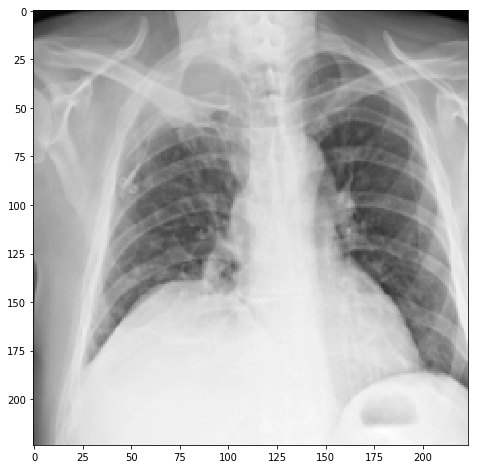

In [8]:

index = 10009
img, _ = train_data[index]
print(torch.sum(img > 0))
print(img)
to_plot = img.cpu().numpy() #+ mean_image
print(to_plot.shape)
plt.imshow(to_plot[0])
plt.show()

## Model Architecture and Forward Pass 

After you understood the core concepts of PyTorch and have a rough idea on how to implement your own model, complete the initialization and forward methods of the `ClassificationCNN` in the `dl4cv/classifiers/classification_cnn.py` file. Note that we do not have to implement a backward pass since this is automatically handled by the `autograd` package.

Use the cell below to check your results:

## Training and Validation with the Solver
We train and validate our previously generated model with a seperate `Solver` class defined in `dl4cv/solver.py`. Complete the `.train()` method and try to come up with an efficient iteration scheme as well as an informative training logger.

Use the cells below to test your solver. A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

<div class="alert alert-info">
    <h3>Note</h3>
    <p>As seen below, the design of our `Solver` class is indepdenent of the particular model or data pipeline. This facilitates the reuse of the class and its modular structure allows the training of different models.</p>
</div>

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

## Train the Network
Now train your model with the full dataset. By training a `ThreeLayerCNN` model for one epoch, you should already achieve greater than 40% accuracy on the validation set. If your training is painfully slow check if you did not forget to call the `nn.Module.cuda()` method.

For the overfitting example we provided you with a set of hyperparamters (`hidden_dim`, `lr`, `weight_decay`, ...). You can start with the same parameter values but in order to maximize your accuracy you should try to train multiple models with different sets of hyperparamters. This process is called hyperparameter optimization.

In [10]:
torch.cuda.is_available()

True

In [11]:
from yz.classifiers.classification_cnn import ClassificationCNN
from yz.classifiers.transferred_alexnet import alexnet
from yz.solver import Solver
from yz.data_utils import get_balanced_weights
from torchvision import models
import torch.nn as nn

weights = get_balanced_weights(train_label_list, 14)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=30, shuffle=False, sampler=sampler, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=30, shuffle=False, num_workers=8)

model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False


model.classifier  = nn.Sequential(
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 14),
)

#list(model.classifier.children())[:-1] = nn.Linear(4096, 14)  
if torch.cuda.is_available():
    print('Cuda available')
    model.cuda()


solver = Solver()
solver.train(model, train_loader, val_loader, log_nth=1, num_epochs=1)

weights: [11.834979956079948, 9.532087499751988, 3.2556861617307438, 6.9455671481458747, 5.0618973019830511, 6.7756476197571684, 4.9272070121054501, 12.432646702181056, 30.27502530434386, 17.530628316511322, 8.7588761741639694, 6.0635212465976114, 9.4502654925111216, 10.668800640213409]


  0%|          | 0/1 [00:00<?, ?it/s]

Cuda available
START TRAIN.



0it [00:00, ?it/s]
1it [00:03,  3.10s/it]

[Iteration 1 / 534] TRAIN loss: 2.662272



2it [00:03,  1.77s/it]

[Iteration 2 / 534] TRAIN loss: 2.642738



3it [00:04,  1.34s/it]

[Iteration 3 / 534] TRAIN loss: 2.642245



4it [00:04,  1.12s/it]

[Iteration 4 / 534] TRAIN loss: 2.664100



5it [00:04,  1.01it/s]

[Iteration 5 / 534] TRAIN loss: 2.637254



6it [00:05,  1.11it/s]

[Iteration 6 / 534] TRAIN loss: 2.666877



7it [00:05,  1.19it/s]

[Iteration 7 / 534] TRAIN loss: 2.657047



8it [00:06,  1.26it/s]

[Iteration 8 / 534] TRAIN loss: 2.625526



9it [00:06,  1.32it/s]

[Iteration 9 / 534] TRAIN loss: 2.643007



10it [00:07,  1.38it/s]

[Iteration 10 / 534] TRAIN loss: 2.639673



11it [00:07,  1.42it/s]

[Iteration 11 / 534] TRAIN loss: 2.638699



12it [00:08,  1.46it/s]

[Iteration 12 / 534] TRAIN loss: 2.637038



13it [00:08,  1.50it/s]

[Iteration 13 / 534] TRAIN loss: 2.640879



14it [00:09,  1.53it/s]

[Iteration 14 / 534] TRAIN loss: 2.688831



15it [00:09,  1.56it/s]

[Iteration 15 / 534] TRAIN loss: 2.679735



16it [00:10,  1.59it/s]

[Iteration 16 / 534] TRAIN loss: 2.649263



17it [00:10,  1.61it/s]

[Iteration 17 / 534] TRAIN loss: 2.681876



18it [00:11,  1.64it/s]

[Iteration 18 / 534] TRAIN loss: 2.665482



19it [00:11,  1.66it/s]

[Iteration 19 / 534] TRAIN loss: 2.687057



20it [00:11,  1.67it/s]

[Iteration 20 / 534] TRAIN loss: 2.667915



21it [00:12,  1.69it/s]

[Iteration 21 / 534] TRAIN loss: 2.645191



22it [00:12,  1.71it/s]

[Iteration 22 / 534] TRAIN loss: 2.641250



23it [00:13,  1.72it/s]

[Iteration 23 / 534] TRAIN loss: 2.649082



24it [00:13,  1.74it/s]

[Iteration 24 / 534] TRAIN loss: 2.643682



25it [00:14,  1.75it/s]

[Iteration 25 / 534] TRAIN loss: 2.639457



26it [00:14,  1.76it/s]

[Iteration 26 / 534] TRAIN loss: 2.673786



27it [00:15,  1.78it/s]

[Iteration 27 / 534] TRAIN loss: 2.623322



28it [00:15,  1.79it/s]

[Iteration 28 / 534] TRAIN loss: 2.644231



29it [00:16,  1.80it/s]

[Iteration 29 / 534] TRAIN loss: 2.605224



30it [00:16,  1.81it/s]

[Iteration 30 / 534] TRAIN loss: 2.641875



31it [00:17,  1.82it/s]

[Iteration 31 / 534] TRAIN loss: 2.644144



32it [00:17,  1.83it/s]

[Iteration 32 / 534] TRAIN loss: 2.618840



33it [00:18,  1.83it/s]

[Iteration 33 / 534] TRAIN loss: 2.614364



34it [00:18,  1.84it/s]

[Iteration 34 / 534] TRAIN loss: 2.644407



35it [00:18,  1.85it/s]

[Iteration 35 / 534] TRAIN loss: 2.678500



36it [00:19,  1.85it/s]

[Iteration 36 / 534] TRAIN loss: 2.669345



37it [00:19,  1.86it/s]

[Iteration 37 / 534] TRAIN loss: 2.657824



38it [00:20,  1.87it/s]

[Iteration 38 / 534] TRAIN loss: 2.601619



39it [00:20,  1.87it/s]

[Iteration 39 / 534] TRAIN loss: 2.649524



40it [00:21,  1.88it/s]

[Iteration 40 / 534] TRAIN loss: 2.675664



41it [00:21,  1.89it/s]

[Iteration 41 / 534] TRAIN loss: 2.659415



42it [00:22,  1.89it/s]

[Iteration 42 / 534] TRAIN loss: 2.641275



43it [00:22,  1.90it/s]

[Iteration 43 / 534] TRAIN loss: 2.629750



44it [00:23,  1.90it/s]

[Iteration 44 / 534] TRAIN loss: 2.655805



45it [00:23,  1.91it/s]

[Iteration 45 / 534] TRAIN loss: 2.643978



46it [00:24,  1.91it/s]

[Iteration 46 / 534] TRAIN loss: 2.613738



47it [00:24,  1.92it/s]

[Iteration 47 / 534] TRAIN loss: 2.642092



48it [00:25,  1.92it/s]

[Iteration 48 / 534] TRAIN loss: 2.641181



49it [00:25,  1.92it/s]

[Iteration 49 / 534] TRAIN loss: 2.685207



50it [00:25,  1.93it/s]

[Iteration 50 / 534] TRAIN loss: 2.646300



51it [00:26,  1.93it/s]

[Iteration 51 / 534] TRAIN loss: 2.694225



52it [00:26,  1.93it/s]

[Iteration 52 / 534] TRAIN loss: 2.668561



53it [00:27,  1.94it/s]

[Iteration 53 / 534] TRAIN loss: 2.641969



54it [00:27,  1.94it/s]

[Iteration 54 / 534] TRAIN loss: 2.634313



55it [00:28,  1.94it/s]

[Iteration 55 / 534] TRAIN loss: 2.638977



56it [00:28,  1.95it/s]

[Iteration 56 / 534] TRAIN loss: 2.634887



57it [00:29,  1.95it/s]

[Iteration 57 / 534] TRAIN loss: 2.661712



58it [00:29,  1.95it/s]

[Iteration 58 / 534] TRAIN loss: 2.671033



59it [00:30,  1.95it/s]

[Iteration 59 / 534] TRAIN loss: 2.630153



60it [00:30,  1.96it/s]

[Iteration 60 / 534] TRAIN loss: 2.644315



61it [00:31,  1.96it/s]

[Iteration 61 / 534] TRAIN loss: 2.657348



62it [00:31,  1.96it/s]

[Iteration 62 / 534] TRAIN loss: 2.645632



63it [00:32,  1.97it/s]

[Iteration 63 / 534] TRAIN loss: 2.654759



64it [00:32,  1.97it/s]

[Iteration 64 / 534] TRAIN loss: 2.654462



65it [00:32,  1.97it/s]

[Iteration 65 / 534] TRAIN loss: 2.641453



66it [00:33,  1.97it/s]

[Iteration 66 / 534] TRAIN loss: 2.609613



67it [00:33,  1.97it/s]

[Iteration 67 / 534] TRAIN loss: 2.642085



68it [00:34,  1.98it/s]

[Iteration 68 / 534] TRAIN loss: 2.626098



69it [00:34,  1.98it/s]

[Iteration 69 / 534] TRAIN loss: 2.659837



70it [00:35,  1.98it/s]

[Iteration 70 / 534] TRAIN loss: 2.655309



71it [00:35,  1.98it/s]

[Iteration 71 / 534] TRAIN loss: 2.667298



72it [00:36,  1.99it/s]

[Iteration 72 / 534] TRAIN loss: 2.631750



73it [00:36,  1.99it/s]

[Iteration 73 / 534] TRAIN loss: 2.658871



74it [00:37,  1.99it/s]

[Iteration 74 / 534] TRAIN loss: 2.658120



75it [00:37,  1.99it/s]

[Iteration 75 / 534] TRAIN loss: 2.643153



76it [00:38,  1.99it/s]

[Iteration 76 / 534] TRAIN loss: 2.639958



77it [00:38,  1.99it/s]

[Iteration 77 / 534] TRAIN loss: 2.650861



78it [00:39,  2.00it/s]

[Iteration 78 / 534] TRAIN loss: 2.635877



79it [00:39,  2.00it/s]

[Iteration 79 / 534] TRAIN loss: 2.620318



80it [00:40,  2.00it/s]

[Iteration 80 / 534] TRAIN loss: 2.632095



81it [00:40,  2.00it/s]
82it [00:40,  2.00it/s]

[Iteration 81 / 534] TRAIN loss: 2.662585
[Iteration 82 / 534] TRAIN loss: 2.692870



83it [00:41,  2.00it/s]

[Iteration 83 / 534] TRAIN loss: 2.604026



84it [00:41,  2.00it/s]

[Iteration 84 / 534] TRAIN loss: 2.628360



85it [00:42,  2.01it/s]

[Iteration 85 / 534] TRAIN loss: 2.604244



86it [00:42,  2.01it/s]

[Iteration 86 / 534] TRAIN loss: 2.667725



87it [00:43,  2.01it/s]

[Iteration 87 / 534] TRAIN loss: 2.616798



88it [00:43,  2.01it/s]

[Iteration 88 / 534] TRAIN loss: 2.613190



89it [00:44,  2.01it/s]

[Iteration 89 / 534] TRAIN loss: 2.624921



90it [00:44,  2.01it/s]

[Iteration 90 / 534] TRAIN loss: 2.662779



91it [00:45,  2.01it/s]

[Iteration 91 / 534] TRAIN loss: 2.641805



92it [00:45,  2.01it/s]

[Iteration 92 / 534] TRAIN loss: 2.646399



93it [00:46,  2.02it/s]

[Iteration 93 / 534] TRAIN loss: 2.623487



94it [00:46,  2.02it/s]

[Iteration 94 / 534] TRAIN loss: 2.633016



95it [00:47,  2.02it/s]
96it [00:47,  2.02it/s]

[Iteration 95 / 534] TRAIN loss: 2.636088
[Iteration 96 / 534] TRAIN loss: 2.641329



97it [00:48,  2.02it/s]

[Iteration 97 / 534] TRAIN loss: 2.661894



98it [00:48,  2.02it/s]

[Iteration 98 / 534] TRAIN loss: 2.640430



99it [00:48,  2.02it/s]

[Iteration 99 / 534] TRAIN loss: 2.633595



100it [00:49,  2.02it/s]

[Iteration 100 / 534] TRAIN loss: 2.609138



101it [00:49,  2.02it/s]

[Iteration 101 / 534] TRAIN loss: 2.676520



102it [00:50,  2.02it/s]

[Iteration 102 / 534] TRAIN loss: 2.657660



103it [00:50,  2.02it/s]

[Iteration 103 / 534] TRAIN loss: 2.595287



104it [00:51,  2.03it/s]

[Iteration 104 / 534] TRAIN loss: 2.603210



105it [00:51,  2.03it/s]

[Iteration 105 / 534] TRAIN loss: 2.665083



106it [00:52,  2.03it/s]

[Iteration 106 / 534] TRAIN loss: 2.638273



107it [00:52,  2.03it/s]

[Iteration 107 / 534] TRAIN loss: 2.635886



108it [00:53,  2.03it/s]

[Iteration 108 / 534] TRAIN loss: 2.653074



109it [00:53,  2.03it/s]

[Iteration 109 / 534] TRAIN loss: 2.622895



110it [00:54,  2.03it/s]
111it [00:54,  2.03it/s]

[Iteration 110 / 534] TRAIN loss: 2.601933
[Iteration 111 / 534] TRAIN loss: 2.612262



112it [00:55,  2.03it/s]

[Iteration 112 / 534] TRAIN loss: 2.599285



113it [00:55,  2.03it/s]

[Iteration 113 / 534] TRAIN loss: 2.635304



114it [00:56,  2.03it/s]

[Iteration 114 / 534] TRAIN loss: 2.599269



115it [00:56,  2.03it/s]

[Iteration 115 / 534] TRAIN loss: 2.614100



116it [00:57,  2.03it/s]

[Iteration 116 / 534] TRAIN loss: 2.619436



117it [00:57,  2.04it/s]

[Iteration 117 / 534] TRAIN loss: 2.647140



118it [00:57,  2.04it/s]

[Iteration 118 / 534] TRAIN loss: 2.652804



119it [00:58,  2.04it/s]

[Iteration 119 / 534] TRAIN loss: 2.638019



120it [00:58,  2.04it/s]

[Iteration 120 / 534] TRAIN loss: 2.644299



121it [00:59,  2.04it/s]

[Iteration 121 / 534] TRAIN loss: 2.629662



122it [00:59,  2.04it/s]

[Iteration 122 / 534] TRAIN loss: 2.612048



123it [01:00,  2.04it/s]

[Iteration 123 / 534] TRAIN loss: 2.626120



124it [01:00,  2.04it/s]

[Iteration 124 / 534] TRAIN loss: 2.632680



125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]

[Iteration 125 / 534] TRAIN loss: 2.669300
[Iteration 126 / 534] TRAIN loss: 2.656014



127it [01:02,  2.04it/s]

[Iteration 127 / 534] TRAIN loss: 2.647183



128it [01:02,  2.04it/s]

[Iteration 128 / 534] TRAIN loss: 2.663206



129it [01:03,  2.04it/s]

[Iteration 129 / 534] TRAIN loss: 2.607905



130it [01:03,  2.04it/s]

[Iteration 130 / 534] TRAIN loss: 2.598799



131it [01:04,  2.04it/s]

[Iteration 131 / 534] TRAIN loss: 2.646698



132it [01:04,  2.04it/s]

[Iteration 132 / 534] TRAIN loss: 2.651394



133it [01:05,  2.04it/s]

[Iteration 133 / 534] TRAIN loss: 2.613594



134it [01:05,  2.04it/s]

[Iteration 134 / 534] TRAIN loss: 2.659569



135it [01:06,  2.04it/s]

[Iteration 135 / 534] TRAIN loss: 2.657683



136it [01:06,  2.05it/s]

[Iteration 136 / 534] TRAIN loss: 2.662770



137it [01:06,  2.05it/s]

[Iteration 137 / 534] TRAIN loss: 2.624766



138it [01:07,  2.05it/s]

[Iteration 138 / 534] TRAIN loss: 2.597844



139it [01:07,  2.05it/s]

[Iteration 139 / 534] TRAIN loss: 2.641347



140it [01:08,  2.05it/s]

[Iteration 140 / 534] TRAIN loss: 2.653612



141it [01:08,  2.05it/s]

[Iteration 141 / 534] TRAIN loss: 2.719243



142it [01:09,  2.05it/s]

[Iteration 142 / 534] TRAIN loss: 2.642667



143it [01:09,  2.05it/s]

[Iteration 143 / 534] TRAIN loss: 2.627435



144it [01:10,  2.05it/s]

[Iteration 144 / 534] TRAIN loss: 2.591504



145it [01:10,  2.05it/s]

[Iteration 145 / 534] TRAIN loss: 2.615825



146it [01:11,  2.05it/s]

[Iteration 146 / 534] TRAIN loss: 2.632229



147it [01:11,  2.05it/s]
148it [01:12,  2.05it/s]

[Iteration 147 / 534] TRAIN loss: 2.664303
[Iteration 148 / 534] TRAIN loss: 2.598138



149it [01:12,  2.05it/s]

[Iteration 149 / 534] TRAIN loss: 2.622061



150it [01:13,  2.05it/s]

[Iteration 150 / 534] TRAIN loss: 2.607768



151it [01:13,  2.05it/s]

[Iteration 151 / 534] TRAIN loss: 2.621697



152it [01:14,  2.05it/s]

[Iteration 152 / 534] TRAIN loss: 2.648186



153it [01:14,  2.05it/s]

[Iteration 153 / 534] TRAIN loss: 2.586789



154it [01:15,  2.05it/s]

[Iteration 154 / 534] TRAIN loss: 2.628477



155it [01:15,  2.05it/s]

[Iteration 155 / 534] TRAIN loss: 2.556872



156it [01:15,  2.05it/s]

[Iteration 156 / 534] TRAIN loss: 2.652558



157it [01:16,  2.05it/s]

[Iteration 157 / 534] TRAIN loss: 2.662748



158it [01:16,  2.05it/s]
159it [01:17,  2.05it/s]

[Iteration 158 / 534] TRAIN loss: 2.648623
[Iteration 159 / 534] TRAIN loss: 2.583720



160it [01:17,  2.05it/s]

[Iteration 160 / 534] TRAIN loss: 2.638003



161it [01:18,  2.06it/s]

[Iteration 161 / 534] TRAIN loss: 2.611515



162it [01:18,  2.06it/s]

[Iteration 162 / 534] TRAIN loss: 2.609589



163it [01:19,  2.06it/s]

[Iteration 163 / 534] TRAIN loss: 2.619639



164it [01:19,  2.06it/s]

[Iteration 164 / 534] TRAIN loss: 2.654995



165it [01:20,  2.06it/s]

[Iteration 165 / 534] TRAIN loss: 2.609468



166it [01:20,  2.06it/s]

[Iteration 166 / 534] TRAIN loss: 2.631644



167it [01:21,  2.06it/s]

[Iteration 167 / 534] TRAIN loss: 2.653825



168it [01:21,  2.06it/s]

[Iteration 168 / 534] TRAIN loss: 2.644238



169it [01:22,  2.06it/s]

[Iteration 169 / 534] TRAIN loss: 2.602407



170it [01:22,  2.06it/s]

[Iteration 170 / 534] TRAIN loss: 2.653821



171it [01:23,  2.06it/s]

[Iteration 171 / 534] TRAIN loss: 2.619323



172it [01:23,  2.06it/s]

[Iteration 172 / 534] TRAIN loss: 2.613482



173it [01:24,  2.06it/s]
174it [01:24,  2.06it/s]

[Iteration 173 / 534] TRAIN loss: 2.644769
[Iteration 174 / 534] TRAIN loss: 2.677381



175it [01:24,  2.06it/s]

[Iteration 175 / 534] TRAIN loss: 2.641161



176it [01:25,  2.06it/s]

[Iteration 176 / 534] TRAIN loss: 2.622266



177it [01:25,  2.06it/s]

[Iteration 177 / 534] TRAIN loss: 2.621555



178it [01:26,  2.06it/s]

[Iteration 178 / 534] TRAIN loss: 2.625926



179it [01:26,  2.06it/s]

[Iteration 179 / 534] TRAIN loss: 2.661357



180it [01:27,  2.06it/s]

[Iteration 180 / 534] TRAIN loss: 2.618413



181it [01:27,  2.06it/s]

[Iteration 181 / 534] TRAIN loss: 2.637777



182it [01:28,  2.06it/s]

[Iteration 182 / 534] TRAIN loss: 2.639962



183it [01:28,  2.06it/s]

[Iteration 183 / 534] TRAIN loss: 2.655702



184it [01:29,  2.06it/s]

[Iteration 184 / 534] TRAIN loss: 2.645375



185it [01:29,  2.06it/s]

[Iteration 185 / 534] TRAIN loss: 2.637342



186it [01:30,  2.06it/s]

[Iteration 186 / 534] TRAIN loss: 2.628759



187it [01:30,  2.06it/s]

[Iteration 187 / 534] TRAIN loss: 2.623950



188it [01:31,  2.06it/s]

[Iteration 188 / 534] TRAIN loss: 2.670021



189it [01:31,  2.06it/s]

[Iteration 189 / 534] TRAIN loss: 2.625169



190it [01:32,  2.06it/s]

[Iteration 190 / 534] TRAIN loss: 2.649119



191it [01:32,  2.06it/s]

[Iteration 191 / 534] TRAIN loss: 2.626235



192it [01:33,  2.06it/s]

[Iteration 192 / 534] TRAIN loss: 2.624917



193it [01:33,  2.06it/s]

[Iteration 193 / 534] TRAIN loss: 2.648420



194it [01:34,  2.06it/s]

[Iteration 194 / 534] TRAIN loss: 2.624547



195it [01:34,  2.06it/s]

[Iteration 195 / 534] TRAIN loss: 2.624556



196it [01:34,  2.06it/s]

[Iteration 196 / 534] TRAIN loss: 2.671269



197it [01:35,  2.06it/s]

[Iteration 197 / 534] TRAIN loss: 2.610222



198it [01:35,  2.06it/s]

[Iteration 198 / 534] TRAIN loss: 2.641818



199it [01:36,  2.06it/s]

[Iteration 199 / 534] TRAIN loss: 2.664607



200it [01:36,  2.06it/s]

[Iteration 200 / 534] TRAIN loss: 2.613176



201it [01:37,  2.06it/s]

[Iteration 201 / 534] TRAIN loss: 2.634633



202it [01:37,  2.06it/s]

[Iteration 202 / 534] TRAIN loss: 2.654660



203it [01:38,  2.06it/s]

[Iteration 203 / 534] TRAIN loss: 2.652472



204it [01:38,  2.06it/s]

[Iteration 204 / 534] TRAIN loss: 2.634888



205it [01:39,  2.06it/s]

[Iteration 205 / 534] TRAIN loss: 2.667128



206it [01:39,  2.07it/s]

[Iteration 206 / 534] TRAIN loss: 2.602816



207it [01:40,  2.07it/s]

[Iteration 207 / 534] TRAIN loss: 2.613909



208it [01:40,  2.07it/s]

[Iteration 208 / 534] TRAIN loss: 2.645460



209it [01:41,  2.07it/s]

[Iteration 209 / 534] TRAIN loss: 2.668815



210it [01:41,  2.07it/s]

[Iteration 210 / 534] TRAIN loss: 2.663596



211it [01:42,  2.07it/s]

[Iteration 211 / 534] TRAIN loss: 2.624539



212it [01:42,  2.07it/s]

[Iteration 212 / 534] TRAIN loss: 2.650866



213it [01:43,  2.07it/s]

[Iteration 213 / 534] TRAIN loss: 2.637614



214it [01:43,  2.07it/s]

[Iteration 214 / 534] TRAIN loss: 2.603526



215it [01:44,  2.07it/s]

[Iteration 215 / 534] TRAIN loss: 2.634418



216it [01:44,  2.07it/s]

[Iteration 216 / 534] TRAIN loss: 2.610481



217it [01:45,  2.07it/s]

[Iteration 217 / 534] TRAIN loss: 2.647355



218it [01:45,  2.07it/s]

[Iteration 218 / 534] TRAIN loss: 2.603746



219it [01:45,  2.07it/s]

[Iteration 219 / 534] TRAIN loss: 2.571364



220it [01:46,  2.07it/s]

[Iteration 220 / 534] TRAIN loss: 2.666625



221it [01:46,  2.07it/s]

[Iteration 221 / 534] TRAIN loss: 2.620886



222it [01:47,  2.07it/s]

[Iteration 222 / 534] TRAIN loss: 2.603892



223it [01:47,  2.07it/s]

[Iteration 223 / 534] TRAIN loss: 2.645561



224it [01:48,  2.07it/s]

[Iteration 224 / 534] TRAIN loss: 2.661853



225it [01:48,  2.07it/s]

[Iteration 225 / 534] TRAIN loss: 2.610639



226it [01:49,  2.07it/s]

[Iteration 226 / 534] TRAIN loss: 2.638610



227it [01:49,  2.07it/s]

[Iteration 227 / 534] TRAIN loss: 2.664040



228it [01:50,  2.07it/s]

[Iteration 228 / 534] TRAIN loss: 2.646348



229it [01:50,  2.07it/s]

[Iteration 229 / 534] TRAIN loss: 2.614560



230it [01:51,  2.07it/s]

[Iteration 230 / 534] TRAIN loss: 2.634438



231it [01:51,  2.07it/s]

[Iteration 231 / 534] TRAIN loss: 2.629438



232it [01:52,  2.07it/s]

[Iteration 232 / 534] TRAIN loss: 2.614801



233it [01:52,  2.07it/s]

[Iteration 233 / 534] TRAIN loss: 2.601939



234it [01:53,  2.07it/s]

[Iteration 234 / 534] TRAIN loss: 2.598597



235it [01:53,  2.07it/s]

[Iteration 235 / 534] TRAIN loss: 2.598375



236it [01:54,  2.07it/s]

[Iteration 236 / 534] TRAIN loss: 2.660980



237it [01:54,  2.07it/s]

[Iteration 237 / 534] TRAIN loss: 2.667169



238it [01:55,  2.07it/s]

[Iteration 238 / 534] TRAIN loss: 2.604342



239it [01:55,  2.07it/s]

[Iteration 239 / 534] TRAIN loss: 2.659716



240it [01:55,  2.07it/s]

[Iteration 240 / 534] TRAIN loss: 2.563011



241it [01:56,  2.07it/s]

[Iteration 241 / 534] TRAIN loss: 2.652246



242it [01:56,  2.07it/s]

[Iteration 242 / 534] TRAIN loss: 2.634621



243it [01:57,  2.07it/s]

[Iteration 243 / 534] TRAIN loss: 2.553172



244it [01:57,  2.07it/s]

[Iteration 244 / 534] TRAIN loss: 2.582872



245it [01:58,  2.07it/s]

[Iteration 245 / 534] TRAIN loss: 2.569388



246it [01:58,  2.07it/s]

[Iteration 246 / 534] TRAIN loss: 2.599141



247it [01:59,  2.07it/s]

[Iteration 247 / 534] TRAIN loss: 2.594475



248it [01:59,  2.07it/s]

[Iteration 248 / 534] TRAIN loss: 2.664725



249it [02:00,  2.07it/s]

[Iteration 249 / 534] TRAIN loss: 2.623443



250it [02:00,  2.07it/s]

[Iteration 250 / 534] TRAIN loss: 2.620469



251it [02:01,  2.07it/s]

[Iteration 251 / 534] TRAIN loss: 2.614775



252it [02:01,  2.07it/s]

[Iteration 252 / 534] TRAIN loss: 2.661737



253it [02:02,  2.07it/s]

[Iteration 253 / 534] TRAIN loss: 2.614422



254it [02:02,  2.07it/s]

[Iteration 254 / 534] TRAIN loss: 2.602785



255it [02:03,  2.07it/s]

[Iteration 255 / 534] TRAIN loss: 2.643080



256it [02:03,  2.07it/s]

[Iteration 256 / 534] TRAIN loss: 2.624913



257it [02:04,  2.07it/s]
258it [02:04,  2.07it/s]

[Iteration 257 / 534] TRAIN loss: 2.605643
[Iteration 258 / 534] TRAIN loss: 2.669608



259it [02:05,  2.07it/s]

[Iteration 259 / 534] TRAIN loss: 2.571543



260it [02:05,  2.07it/s]

[Iteration 260 / 534] TRAIN loss: 2.596710



261it [02:06,  2.07it/s]

[Iteration 261 / 534] TRAIN loss: 2.647843



262it [02:06,  2.07it/s]

[Iteration 262 / 534] TRAIN loss: 2.650702



263it [02:07,  2.07it/s]

[Iteration 263 / 534] TRAIN loss: 2.644222



264it [02:07,  2.07it/s]

[Iteration 264 / 534] TRAIN loss: 2.607318



265it [02:07,  2.07it/s]

[Iteration 265 / 534] TRAIN loss: 2.631797



266it [02:08,  2.07it/s]

[Iteration 266 / 534] TRAIN loss: 2.675467



267it [02:08,  2.07it/s]

[Iteration 267 / 534] TRAIN loss: 2.639733



268it [02:09,  2.07it/s]

[Iteration 268 / 534] TRAIN loss: 2.632607



269it [02:09,  2.07it/s]

[Iteration 269 / 534] TRAIN loss: 2.629310



270it [02:10,  2.07it/s]

[Iteration 270 / 534] TRAIN loss: 2.613667



271it [02:10,  2.07it/s]

[Iteration 271 / 534] TRAIN loss: 2.658411



272it [02:11,  2.07it/s]

[Iteration 272 / 534] TRAIN loss: 2.643608



273it [02:11,  2.07it/s]

[Iteration 273 / 534] TRAIN loss: 2.627528



274it [02:12,  2.07it/s]

[Iteration 274 / 534] TRAIN loss: 2.612248



275it [02:12,  2.07it/s]

[Iteration 275 / 534] TRAIN loss: 2.612386



276it [02:13,  2.07it/s]

[Iteration 276 / 534] TRAIN loss: 2.604717



277it [02:13,  2.07it/s]

[Iteration 277 / 534] TRAIN loss: 2.614356



278it [02:14,  2.07it/s]

[Iteration 278 / 534] TRAIN loss: 2.616328



279it [02:14,  2.07it/s]

[Iteration 279 / 534] TRAIN loss: 2.632444



280it [02:15,  2.07it/s]

[Iteration 280 / 534] TRAIN loss: 2.622512



281it [02:15,  2.07it/s]

[Iteration 281 / 534] TRAIN loss: 2.630553



282it [02:16,  2.07it/s]

[Iteration 282 / 534] TRAIN loss: 2.584962



283it [02:16,  2.07it/s]

[Iteration 283 / 534] TRAIN loss: 2.626817



284it [02:17,  2.07it/s]

[Iteration 284 / 534] TRAIN loss: 2.566130



285it [02:17,  2.07it/s]

[Iteration 285 / 534] TRAIN loss: 2.606643



286it [02:18,  2.07it/s]

[Iteration 286 / 534] TRAIN loss: 2.626836



287it [02:18,  2.07it/s]

[Iteration 287 / 534] TRAIN loss: 2.600822



288it [02:19,  2.07it/s]

[Iteration 288 / 534] TRAIN loss: 2.612241



289it [02:19,  2.07it/s]

[Iteration 289 / 534] TRAIN loss: 2.623237



290it [02:19,  2.07it/s]

[Iteration 290 / 534] TRAIN loss: 2.593141



291it [02:20,  2.07it/s]

[Iteration 291 / 534] TRAIN loss: 2.579571



292it [02:20,  2.07it/s]

[Iteration 292 / 534] TRAIN loss: 2.618293



293it [02:21,  2.07it/s]

[Iteration 293 / 534] TRAIN loss: 2.605529



294it [02:21,  2.07it/s]

[Iteration 294 / 534] TRAIN loss: 2.638624



295it [02:22,  2.07it/s]

[Iteration 295 / 534] TRAIN loss: 2.692800



296it [02:22,  2.07it/s]

[Iteration 296 / 534] TRAIN loss: 2.614429



297it [02:23,  2.07it/s]

[Iteration 297 / 534] TRAIN loss: 2.642209



298it [02:23,  2.07it/s]

[Iteration 298 / 534] TRAIN loss: 2.593861



299it [02:24,  2.07it/s]

[Iteration 299 / 534] TRAIN loss: 2.573245



300it [02:24,  2.07it/s]

[Iteration 300 / 534] TRAIN loss: 2.621128



301it [02:25,  2.07it/s]

[Iteration 301 / 534] TRAIN loss: 2.577640



302it [02:25,  2.07it/s]

[Iteration 302 / 534] TRAIN loss: 2.648336



303it [02:26,  2.07it/s]

[Iteration 303 / 534] TRAIN loss: 2.621630



304it [02:26,  2.07it/s]

[Iteration 304 / 534] TRAIN loss: 2.616516



305it [02:27,  2.07it/s]

[Iteration 305 / 534] TRAIN loss: 2.579822



306it [02:27,  2.07it/s]

[Iteration 306 / 534] TRAIN loss: 2.572942



307it [02:28,  2.07it/s]

[Iteration 307 / 534] TRAIN loss: 2.629397



308it [02:28,  2.07it/s]

[Iteration 308 / 534] TRAIN loss: 2.616522



309it [02:29,  2.07it/s]

[Iteration 309 / 534] TRAIN loss: 2.636318



310it [02:29,  2.07it/s]

[Iteration 310 / 534] TRAIN loss: 2.618106



311it [02:30,  2.07it/s]

[Iteration 311 / 534] TRAIN loss: 2.633897



312it [02:30,  2.07it/s]

[Iteration 312 / 534] TRAIN loss: 2.627678



313it [02:31,  2.07it/s]

[Iteration 313 / 534] TRAIN loss: 2.598519



314it [02:31,  2.07it/s]

[Iteration 314 / 534] TRAIN loss: 2.623295



315it [02:31,  2.07it/s]

[Iteration 315 / 534] TRAIN loss: 2.632881



316it [02:32,  2.07it/s]

[Iteration 316 / 534] TRAIN loss: 2.611771



317it [02:32,  2.07it/s]

[Iteration 317 / 534] TRAIN loss: 2.643457



318it [02:33,  2.07it/s]

[Iteration 318 / 534] TRAIN loss: 2.563054



319it [02:33,  2.07it/s]

[Iteration 319 / 534] TRAIN loss: 2.619487



320it [02:34,  2.07it/s]

[Iteration 320 / 534] TRAIN loss: 2.651997



321it [02:34,  2.07it/s]

[Iteration 321 / 534] TRAIN loss: 2.601220



322it [02:35,  2.07it/s]

[Iteration 322 / 534] TRAIN loss: 2.645496



323it [02:35,  2.07it/s]

[Iteration 323 / 534] TRAIN loss: 2.611239



324it [02:36,  2.07it/s]

[Iteration 324 / 534] TRAIN loss: 2.623997



325it [02:36,  2.07it/s]

[Iteration 325 / 534] TRAIN loss: 2.622755



326it [02:37,  2.07it/s]

[Iteration 326 / 534] TRAIN loss: 2.593386



327it [02:37,  2.07it/s]

[Iteration 327 / 534] TRAIN loss: 2.595382



328it [02:38,  2.07it/s]

[Iteration 328 / 534] TRAIN loss: 2.639553



329it [02:38,  2.07it/s]

[Iteration 329 / 534] TRAIN loss: 2.610529



330it [02:39,  2.07it/s]

[Iteration 330 / 534] TRAIN loss: 2.614663



331it [02:39,  2.07it/s]

[Iteration 331 / 534] TRAIN loss: 2.642338



332it [02:40,  2.07it/s]

[Iteration 332 / 534] TRAIN loss: 2.569294



333it [02:40,  2.07it/s]

[Iteration 333 / 534] TRAIN loss: 2.575261



334it [02:41,  2.07it/s]

[Iteration 334 / 534] TRAIN loss: 2.634682



335it [02:41,  2.07it/s]

[Iteration 335 / 534] TRAIN loss: 2.612482



336it [02:42,  2.07it/s]

[Iteration 336 / 534] TRAIN loss: 2.581848



337it [02:42,  2.07it/s]

[Iteration 337 / 534] TRAIN loss: 2.663216



338it [02:43,  2.07it/s]

[Iteration 338 / 534] TRAIN loss: 2.642591



339it [02:43,  2.07it/s]

[Iteration 339 / 534] TRAIN loss: 2.608905



340it [02:44,  2.07it/s]

[Iteration 340 / 534] TRAIN loss: 2.575595



341it [02:44,  2.07it/s]

[Iteration 341 / 534] TRAIN loss: 2.643351



342it [02:44,  2.07it/s]

[Iteration 342 / 534] TRAIN loss: 2.627769



343it [02:45,  2.07it/s]

[Iteration 343 / 534] TRAIN loss: 2.623273



344it [02:45,  2.07it/s]

[Iteration 344 / 534] TRAIN loss: 2.539359



345it [02:46,  2.07it/s]

[Iteration 345 / 534] TRAIN loss: 2.553423



346it [02:46,  2.07it/s]

[Iteration 346 / 534] TRAIN loss: 2.585376



347it [02:47,  2.07it/s]

[Iteration 347 / 534] TRAIN loss: 2.609465



348it [02:47,  2.07it/s]

[Iteration 348 / 534] TRAIN loss: 2.599717



349it [02:48,  2.07it/s]

[Iteration 349 / 534] TRAIN loss: 2.603802



350it [02:48,  2.07it/s]

[Iteration 350 / 534] TRAIN loss: 2.571761



351it [02:49,  2.07it/s]

[Iteration 351 / 534] TRAIN loss: 2.630665



352it [02:49,  2.07it/s]

[Iteration 352 / 534] TRAIN loss: 2.600724



353it [02:50,  2.07it/s]

[Iteration 353 / 534] TRAIN loss: 2.617379



354it [02:50,  2.07it/s]

[Iteration 354 / 534] TRAIN loss: 2.678165



355it [02:51,  2.07it/s]

[Iteration 355 / 534] TRAIN loss: 2.638707



356it [02:51,  2.07it/s]

[Iteration 356 / 534] TRAIN loss: 2.622860



357it [02:52,  2.07it/s]

[Iteration 357 / 534] TRAIN loss: 2.647432



358it [02:52,  2.07it/s]

[Iteration 358 / 534] TRAIN loss: 2.584292



359it [02:53,  2.07it/s]

[Iteration 359 / 534] TRAIN loss: 2.608420



360it [02:53,  2.07it/s]

[Iteration 360 / 534] TRAIN loss: 2.618678



361it [02:54,  2.07it/s]

[Iteration 361 / 534] TRAIN loss: 2.622331



362it [02:54,  2.07it/s]

[Iteration 362 / 534] TRAIN loss: 2.601274



363it [02:55,  2.07it/s]

[Iteration 363 / 534] TRAIN loss: 2.594023



364it [02:55,  2.07it/s]

[Iteration 364 / 534] TRAIN loss: 2.586236



365it [02:56,  2.07it/s]

[Iteration 365 / 534] TRAIN loss: 2.600783



366it [02:56,  2.07it/s]

[Iteration 366 / 534] TRAIN loss: 2.653180



367it [02:57,  2.07it/s]

[Iteration 367 / 534] TRAIN loss: 2.638354



368it [02:57,  2.07it/s]

[Iteration 368 / 534] TRAIN loss: 2.584147



369it [02:57,  2.07it/s]

[Iteration 369 / 534] TRAIN loss: 2.616889



370it [02:58,  2.07it/s]

[Iteration 370 / 534] TRAIN loss: 2.619650



371it [02:58,  2.07it/s]

[Iteration 371 / 534] TRAIN loss: 2.593924



372it [02:59,  2.07it/s]

[Iteration 372 / 534] TRAIN loss: 2.678618



373it [02:59,  2.07it/s]

[Iteration 373 / 534] TRAIN loss: 2.627993



374it [03:00,  2.07it/s]

[Iteration 374 / 534] TRAIN loss: 2.655770



375it [03:00,  2.07it/s]

[Iteration 375 / 534] TRAIN loss: 2.575224



376it [03:01,  2.07it/s]

[Iteration 376 / 534] TRAIN loss: 2.574510



377it [03:01,  2.07it/s]

[Iteration 377 / 534] TRAIN loss: 2.617759



378it [03:02,  2.07it/s]

[Iteration 378 / 534] TRAIN loss: 2.586891



379it [03:02,  2.07it/s]

[Iteration 379 / 534] TRAIN loss: 2.632311



380it [03:03,  2.07it/s]

[Iteration 380 / 534] TRAIN loss: 2.635154



381it [03:03,  2.07it/s]

[Iteration 381 / 534] TRAIN loss: 2.609658



382it [03:04,  2.07it/s]

[Iteration 382 / 534] TRAIN loss: 2.592441



383it [03:04,  2.07it/s]

[Iteration 383 / 534] TRAIN loss: 2.570406



384it [03:05,  2.07it/s]

[Iteration 384 / 534] TRAIN loss: 2.618903



385it [03:05,  2.07it/s]

[Iteration 385 / 534] TRAIN loss: 2.637278



386it [03:06,  2.07it/s]

[Iteration 386 / 534] TRAIN loss: 2.596491



387it [03:06,  2.07it/s]

[Iteration 387 / 534] TRAIN loss: 2.548379



388it [03:07,  2.07it/s]

[Iteration 388 / 534] TRAIN loss: 2.668535



389it [03:07,  2.07it/s]

[Iteration 389 / 534] TRAIN loss: 2.611043



390it [03:08,  2.07it/s]

[Iteration 390 / 534] TRAIN loss: 2.607300



391it [03:08,  2.07it/s]

[Iteration 391 / 534] TRAIN loss: 2.649253



392it [03:09,  2.07it/s]

[Iteration 392 / 534] TRAIN loss: 2.575658



393it [03:09,  2.07it/s]

[Iteration 393 / 534] TRAIN loss: 2.615016



394it [03:10,  2.07it/s]

[Iteration 394 / 534] TRAIN loss: 2.649713



395it [03:10,  2.07it/s]

[Iteration 395 / 534] TRAIN loss: 2.595189



396it [03:11,  2.07it/s]

[Iteration 396 / 534] TRAIN loss: 2.587217



397it [03:11,  2.07it/s]

[Iteration 397 / 534] TRAIN loss: 2.590203



398it [03:11,  2.07it/s]

[Iteration 398 / 534] TRAIN loss: 2.548889



399it [03:12,  2.07it/s]

[Iteration 399 / 534] TRAIN loss: 2.630184



400it [03:12,  2.07it/s]

[Iteration 400 / 534] TRAIN loss: 2.642617



401it [03:13,  2.07it/s]

[Iteration 401 / 534] TRAIN loss: 2.572445



402it [03:13,  2.07it/s]

[Iteration 402 / 534] TRAIN loss: 2.620712



403it [03:14,  2.07it/s]

[Iteration 403 / 534] TRAIN loss: 2.561752



404it [03:14,  2.07it/s]

[Iteration 404 / 534] TRAIN loss: 2.600818



405it [03:15,  2.07it/s]

[Iteration 405 / 534] TRAIN loss: 2.572846



406it [03:15,  2.07it/s]

[Iteration 406 / 534] TRAIN loss: 2.602166



407it [03:16,  2.07it/s]

[Iteration 407 / 534] TRAIN loss: 2.615433



408it [03:16,  2.07it/s]

[Iteration 408 / 534] TRAIN loss: 2.611487



409it [03:17,  2.07it/s]

[Iteration 409 / 534] TRAIN loss: 2.613117



410it [03:17,  2.07it/s]

[Iteration 410 / 534] TRAIN loss: 2.668779



411it [03:18,  2.07it/s]

[Iteration 411 / 534] TRAIN loss: 2.570768



412it [03:18,  2.07it/s]

[Iteration 412 / 534] TRAIN loss: 2.581753



413it [03:19,  2.07it/s]

[Iteration 413 / 534] TRAIN loss: 2.590420



414it [03:19,  2.07it/s]

[Iteration 414 / 534] TRAIN loss: 2.551306



415it [03:20,  2.07it/s]

[Iteration 415 / 534] TRAIN loss: 2.635292



416it [03:20,  2.07it/s]

[Iteration 416 / 534] TRAIN loss: 2.661418



417it [03:21,  2.07it/s]

[Iteration 417 / 534] TRAIN loss: 2.614892



418it [03:21,  2.07it/s]

[Iteration 418 / 534] TRAIN loss: 2.569312



419it [03:22,  2.07it/s]

[Iteration 419 / 534] TRAIN loss: 2.608298



420it [03:22,  2.07it/s]

[Iteration 420 / 534] TRAIN loss: 2.626467



421it [03:23,  2.07it/s]

[Iteration 421 / 534] TRAIN loss: 2.606053



422it [03:23,  2.07it/s]

[Iteration 422 / 534] TRAIN loss: 2.603386



423it [03:24,  2.07it/s]

[Iteration 423 / 534] TRAIN loss: 2.625112



424it [03:24,  2.07it/s]

[Iteration 424 / 534] TRAIN loss: 2.594371



425it [03:24,  2.07it/s]

[Iteration 425 / 534] TRAIN loss: 2.667499



426it [03:25,  2.07it/s]

[Iteration 426 / 534] TRAIN loss: 2.623572



427it [03:25,  2.07it/s]

[Iteration 427 / 534] TRAIN loss: 2.653076



428it [03:26,  2.07it/s]

[Iteration 428 / 534] TRAIN loss: 2.599151



429it [03:26,  2.07it/s]

[Iteration 429 / 534] TRAIN loss: 2.576470



430it [03:27,  2.07it/s]

[Iteration 430 / 534] TRAIN loss: 2.607533



431it [03:27,  2.07it/s]

[Iteration 431 / 534] TRAIN loss: 2.648320



432it [03:28,  2.07it/s]

[Iteration 432 / 534] TRAIN loss: 2.623279



433it [03:28,  2.07it/s]

[Iteration 433 / 534] TRAIN loss: 2.609228



434it [03:29,  2.07it/s]

[Iteration 434 / 534] TRAIN loss: 2.644399



435it [03:29,  2.07it/s]

[Iteration 435 / 534] TRAIN loss: 2.575014



436it [03:30,  2.07it/s]

[Iteration 436 / 534] TRAIN loss: 2.551011



437it [03:30,  2.07it/s]

[Iteration 437 / 534] TRAIN loss: 2.575770



438it [03:31,  2.07it/s]

[Iteration 438 / 534] TRAIN loss: 2.633349



439it [03:31,  2.07it/s]

[Iteration 439 / 534] TRAIN loss: 2.616650



440it [03:32,  2.07it/s]

[Iteration 440 / 534] TRAIN loss: 2.654506



441it [03:32,  2.07it/s]

[Iteration 441 / 534] TRAIN loss: 2.616648



442it [03:33,  2.07it/s]

[Iteration 442 / 534] TRAIN loss: 2.627305



443it [03:33,  2.07it/s]

[Iteration 443 / 534] TRAIN loss: 2.620388



444it [03:34,  2.07it/s]

[Iteration 444 / 534] TRAIN loss: 2.611907



445it [03:34,  2.07it/s]

[Iteration 445 / 534] TRAIN loss: 2.609764



446it [03:35,  2.07it/s]

[Iteration 446 / 534] TRAIN loss: 2.555006



447it [03:35,  2.07it/s]

[Iteration 447 / 534] TRAIN loss: 2.624190



448it [03:36,  2.07it/s]

[Iteration 448 / 534] TRAIN loss: 2.605192



449it [03:36,  2.07it/s]

[Iteration 449 / 534] TRAIN loss: 2.627554



450it [03:37,  2.07it/s]

[Iteration 450 / 534] TRAIN loss: 2.566363



451it [03:37,  2.07it/s]

[Iteration 451 / 534] TRAIN loss: 2.563849



452it [03:38,  2.07it/s]

[Iteration 452 / 534] TRAIN loss: 2.597336



453it [03:38,  2.07it/s]

[Iteration 453 / 534] TRAIN loss: 2.624844



454it [03:39,  2.07it/s]

[Iteration 454 / 534] TRAIN loss: 2.660520



455it [03:39,  2.07it/s]

[Iteration 455 / 534] TRAIN loss: 2.652344



456it [03:39,  2.07it/s]

[Iteration 456 / 534] TRAIN loss: 2.558310



457it [03:40,  2.07it/s]

[Iteration 457 / 534] TRAIN loss: 2.583739



458it [03:40,  2.07it/s]

[Iteration 458 / 534] TRAIN loss: 2.593417



459it [03:41,  2.07it/s]

[Iteration 459 / 534] TRAIN loss: 2.633605



460it [03:41,  2.07it/s]

[Iteration 460 / 534] TRAIN loss: 2.620541



461it [03:42,  2.07it/s]

[Iteration 461 / 534] TRAIN loss: 2.590905



462it [03:42,  2.07it/s]

[Iteration 462 / 534] TRAIN loss: 2.619915



463it [03:43,  2.07it/s]

[Iteration 463 / 534] TRAIN loss: 2.579324



464it [03:43,  2.07it/s]

[Iteration 464 / 534] TRAIN loss: 2.646712



465it [03:44,  2.07it/s]

[Iteration 465 / 534] TRAIN loss: 2.569719



466it [03:44,  2.07it/s]

[Iteration 466 / 534] TRAIN loss: 2.646538



467it [03:45,  2.07it/s]

[Iteration 467 / 534] TRAIN loss: 2.633401



468it [03:45,  2.07it/s]

[Iteration 468 / 534] TRAIN loss: 2.607713



469it [03:46,  2.07it/s]

[Iteration 469 / 534] TRAIN loss: 2.572102



470it [03:46,  2.07it/s]

[Iteration 470 / 534] TRAIN loss: 2.617568



471it [03:47,  2.07it/s]

[Iteration 471 / 534] TRAIN loss: 2.610111



472it [03:47,  2.07it/s]

[Iteration 472 / 534] TRAIN loss: 2.622458



473it [03:48,  2.07it/s]
474it [03:48,  2.07it/s]

[Iteration 473 / 534] TRAIN loss: 2.616729
[Iteration 474 / 534] TRAIN loss: 2.618388



475it [03:49,  2.07it/s]

[Iteration 475 / 534] TRAIN loss: 2.616494



476it [03:49,  2.07it/s]

[Iteration 476 / 534] TRAIN loss: 2.565743



477it [03:50,  2.07it/s]

[Iteration 477 / 534] TRAIN loss: 2.593358



478it [03:50,  2.07it/s]

[Iteration 478 / 534] TRAIN loss: 2.578696



479it [03:51,  2.07it/s]

[Iteration 479 / 534] TRAIN loss: 2.620108



480it [03:51,  2.07it/s]

[Iteration 480 / 534] TRAIN loss: 2.591272



481it [03:52,  2.07it/s]

[Iteration 481 / 534] TRAIN loss: 2.563254



482it [03:52,  2.07it/s]

[Iteration 482 / 534] TRAIN loss: 2.617649



483it [03:53,  2.07it/s]

[Iteration 483 / 534] TRAIN loss: 2.605087



484it [03:53,  2.07it/s]

[Iteration 484 / 534] TRAIN loss: 2.611775



485it [03:54,  2.07it/s]

[Iteration 485 / 534] TRAIN loss: 2.590434



486it [03:54,  2.07it/s]

[Iteration 486 / 534] TRAIN loss: 2.556566



487it [03:55,  2.07it/s]

[Iteration 487 / 534] TRAIN loss: 2.571077



488it [03:55,  2.07it/s]

[Iteration 488 / 534] TRAIN loss: 2.604958



489it [03:55,  2.07it/s]

[Iteration 489 / 534] TRAIN loss: 2.615487



490it [03:56,  2.07it/s]

[Iteration 490 / 534] TRAIN loss: 2.610916



491it [03:56,  2.07it/s]

[Iteration 491 / 534] TRAIN loss: 2.589070



492it [03:57,  2.07it/s]

[Iteration 492 / 534] TRAIN loss: 2.544202



493it [03:57,  2.07it/s]

[Iteration 493 / 534] TRAIN loss: 2.649559



494it [03:58,  2.07it/s]

[Iteration 494 / 534] TRAIN loss: 2.576200



495it [03:58,  2.07it/s]

[Iteration 495 / 534] TRAIN loss: 2.623362



496it [03:59,  2.07it/s]

[Iteration 496 / 534] TRAIN loss: 2.622680



497it [03:59,  2.07it/s]

[Iteration 497 / 534] TRAIN loss: 2.570899



498it [04:00,  2.07it/s]

[Iteration 498 / 534] TRAIN loss: 2.593953



499it [04:00,  2.07it/s]

[Iteration 499 / 534] TRAIN loss: 2.603712



500it [04:01,  2.07it/s]

[Iteration 500 / 534] TRAIN loss: 2.584110



501it [04:01,  2.07it/s]

[Iteration 501 / 534] TRAIN loss: 2.561034



502it [04:02,  2.07it/s]

[Iteration 502 / 534] TRAIN loss: 2.665076



503it [04:02,  2.07it/s]

[Iteration 503 / 534] TRAIN loss: 2.611089



504it [04:03,  2.07it/s]

[Iteration 504 / 534] TRAIN loss: 2.641356



505it [04:03,  2.07it/s]

[Iteration 505 / 534] TRAIN loss: 2.630860



506it [04:04,  2.07it/s]

[Iteration 506 / 534] TRAIN loss: 2.599383



507it [04:04,  2.07it/s]

[Iteration 507 / 534] TRAIN loss: 2.608983



508it [04:05,  2.07it/s]

[Iteration 508 / 534] TRAIN loss: 2.619090



509it [04:05,  2.07it/s]

[Iteration 509 / 534] TRAIN loss: 2.636212



510it [04:06,  2.07it/s]

[Iteration 510 / 534] TRAIN loss: 2.594153



511it [04:06,  2.07it/s]

[Iteration 511 / 534] TRAIN loss: 2.544895



512it [04:07,  2.07it/s]

[Iteration 512 / 534] TRAIN loss: 2.642137



513it [04:07,  2.07it/s]

[Iteration 513 / 534] TRAIN loss: 2.610823



514it [04:08,  2.07it/s]

[Iteration 514 / 534] TRAIN loss: 2.592965



515it [04:08,  2.07it/s]

[Iteration 515 / 534] TRAIN loss: 2.645103



516it [04:09,  2.07it/s]

[Iteration 516 / 534] TRAIN loss: 2.551147



517it [04:09,  2.07it/s]

[Iteration 517 / 534] TRAIN loss: 2.609816



518it [04:10,  2.07it/s]

[Iteration 518 / 534] TRAIN loss: 2.621906



519it [04:10,  2.07it/s]

[Iteration 519 / 534] TRAIN loss: 2.590930



520it [04:11,  2.07it/s]

[Iteration 520 / 534] TRAIN loss: 2.585050



521it [04:11,  2.07it/s]

[Iteration 521 / 534] TRAIN loss: 2.665609



522it [04:11,  2.07it/s]

[Iteration 522 / 534] TRAIN loss: 2.590206



523it [04:12,  2.07it/s]

[Iteration 523 / 534] TRAIN loss: 2.571441



524it [04:12,  2.07it/s]
525it [04:13,  2.07it/s]

[Iteration 524 / 534] TRAIN loss: 2.650686
[Iteration 525 / 534] TRAIN loss: 2.639655



526it [04:13,  2.07it/s]

[Iteration 526 / 534] TRAIN loss: 2.540665



527it [04:14,  2.07it/s]

[Iteration 527 / 534] TRAIN loss: 2.630954



528it [04:14,  2.07it/s]

[Iteration 528 / 534] TRAIN loss: 2.607193



529it [04:15,  2.07it/s]

[Iteration 529 / 534] TRAIN loss: 2.636992



530it [04:15,  2.07it/s]
531it [04:16,  2.07it/s]

[Iteration 530 / 534] TRAIN loss: 2.617412
[Iteration 531 / 534] TRAIN loss: 2.628701



532it [04:16,  2.07it/s]

[Iteration 532 / 534] TRAIN loss: 2.642910



533it [04:17,  2.07it/s]

[Iteration 533 / 534] TRAIN loss: 2.644989



534it [04:17,  2.07it/s]


[Iteration 534 / 534] TRAIN loss: 2.652270
[Epoch 1 / 1] TRAIN acc: 3.241573



0it [00:00, ?it/s]
1it [00:00,  1.69it/s]
2it [00:01,  1.85it/s]
3it [00:01,  1.93it/s]
4it [00:02,  1.97it/s]
5it [00:02,  2.00it/s]
6it [00:02,  2.01it/s]
7it [00:03,  2.02it/s]
8it [00:03,  2.04it/s]
9it [00:04,  2.04it/s]
10it [00:04,  2.05it/s]
11it [00:05,  2.05it/s]
12it [00:05,  2.06it/s]
13it [00:06,  2.06it/s]
14it [00:06,  2.07it/s]
15it [00:07,  2.07it/s]
16it [00:07,  2.08it/s]
17it [00:08,  2.08it/s]
18it [00:08,  2.08it/s]
19it [00:09,  2.08it/s]
20it [00:09,  2.08it/s]
21it [00:10,  2.08it/s]
22it [00:10,  2.08it/s]
23it [00:11,  2.09it/s]
24it [00:11,  2.09it/s]
25it [00:11,  2.09it/s]
26it [00:12,  2.09it/s]
27it [00:12,  2.09it/s]
28it [00:13,  2.09it/s]
29it [00:13,  2.09it/s]
30it [00:14,  2.09it/s]
31it [00:14,  2.09it/s]
32it [00:15,  2.09it/s]
33it [00:15,  2.09it/s]
34it [00:16,  2.09it/s]
35it [00:16,  2.09it/s]
36it [00:17,  2.09it/s]
37it [00:17,  2.09it/s]
38it [00:18,  2.09it/s]
39it [00:18,  2.10it/s]
40it [00:19,  2.10it/s]
41it [00:19,  2.10it/s]
42it 

[Epoch 1 / 1] VAL acc: 9.095238
Trained in 278 seconds.
FINISH.


VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

In [ ]:
solver = Solver()
solver.train(model, train_loader, val_loader, log_nth=20, num_epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

START TRAIN.



0it [00:00, ?it/s]
1it [00:00,  1.56it/s]

[Iteration 1 / 106800] TRAIN loss: 2.577296



2it [00:01,  1.79it/s]
3it [00:01,  1.87it/s]
4it [00:02,  1.92it/s]
5it [00:02,  1.95it/s]
6it [00:03,  1.97it/s]
7it [00:03,  1.99it/s]
8it [00:04,  2.00it/s]
9it [00:04,  2.00it/s]
10it [00:04,  2.01it/s]
11it [00:05,  2.02it/s]
12it [00:05,  2.02it/s]
13it [00:06,  2.02it/s]
14it [00:06,  2.03it/s]
15it [00:07,  2.03it/s]
16it [00:07,  2.03it/s]
17it [00:08,  2.04it/s]
18it [00:08,  2.04it/s]
19it [00:09,  2.04it/s]
20it [00:09,  2.04it/s]
21it [00:10,  2.05it/s]

[Iteration 21 / 106800] TRAIN loss: 2.576441



22it [00:10,  2.05it/s]
23it [00:11,  2.05it/s]
24it [00:11,  2.05it/s]
25it [00:12,  2.05it/s]
26it [00:12,  2.05it/s]
27it [00:13,  2.05it/s]
28it [00:13,  2.05it/s]
29it [00:14,  2.05it/s]
30it [00:14,  2.05it/s]
31it [00:15,  2.06it/s]
32it [00:15,  2.06it/s]
33it [00:16,  2.06it/s]
34it [00:16,  2.06it/s]
35it [00:17,  2.06it/s]
36it [00:17,  2.06it/s]
37it [00:17,  2.06it/s]
38it [00:18,  2.06it/s]
39it [00:18,  2.06it/s]
40it [00:19,  2.06it/s]
41it [00:19,  2.06it/s]

[Iteration 41 / 106800] TRAIN loss: 2.573388



42it [00:20,  2.06it/s]
43it [00:20,  2.06it/s]
44it [00:21,  2.06it/s]
45it [00:21,  2.06it/s]
46it [00:22,  2.06it/s]
47it [00:22,  2.06it/s]
48it [00:23,  2.06it/s]
49it [00:23,  2.06it/s]
50it [00:24,  2.06it/s]
51it [00:24,  2.06it/s]
52it [00:25,  2.06it/s]
53it [00:25,  2.06it/s]
54it [00:26,  2.06it/s]
55it [00:26,  2.06it/s]
56it [00:27,  2.06it/s]
57it [00:27,  2.06it/s]
58it [00:28,  2.06it/s]
59it [00:28,  2.06it/s]
60it [00:29,  2.06it/s]
61it [00:29,  2.06it/s]

[Iteration 61 / 106800] TRAIN loss: 2.448829



62it [00:30,  2.06it/s]
63it [00:30,  2.06it/s]
64it [00:31,  2.06it/s]
65it [00:31,  2.06it/s]
66it [00:31,  2.06it/s]
67it [00:32,  2.06it/s]
68it [00:32,  2.06it/s]
69it [00:33,  2.06it/s]
70it [00:33,  2.06it/s]
71it [00:34,  2.06it/s]
72it [00:34,  2.06it/s]
73it [00:35,  2.06it/s]
74it [00:35,  2.06it/s]
75it [00:36,  2.06it/s]
76it [00:36,  2.06it/s]
77it [00:37,  2.07it/s]
78it [00:37,  2.07it/s]
79it [00:38,  2.07it/s]
80it [00:38,  2.07it/s]
81it [00:39,  2.07it/s]

[Iteration 81 / 106800] TRAIN loss: 2.586733



82it [00:39,  2.07it/s]
83it [00:40,  2.07it/s]
84it [00:40,  2.07it/s]
85it [00:41,  2.07it/s]
86it [00:41,  2.07it/s]
87it [00:42,  2.07it/s]
88it [00:42,  2.07it/s]
89it [00:43,  2.07it/s]
90it [00:43,  2.07it/s]
91it [00:44,  2.07it/s]
92it [00:44,  2.07it/s]
93it [00:44,  2.07it/s]
94it [00:45,  2.07it/s]
95it [00:45,  2.07it/s]
96it [00:46,  2.07it/s]
97it [00:46,  2.07it/s]
98it [00:47,  2.07it/s]
99it [00:47,  2.07it/s]
100it [00:48,  2.07it/s]
101it [00:48,  2.07it/s]

[Iteration 101 / 106800] TRAIN loss: 2.506543



102it [00:49,  2.07it/s]
103it [00:49,  2.07it/s]
104it [00:50,  2.07it/s]
105it [00:50,  2.07it/s]
106it [00:51,  2.07it/s]
107it [00:51,  2.07it/s]
108it [00:52,  2.07it/s]
109it [00:52,  2.07it/s]
110it [00:53,  2.07it/s]
111it [00:53,  2.07it/s]
112it [00:54,  2.07it/s]
113it [00:54,  2.07it/s]
114it [00:55,  2.07it/s]
115it [00:55,  2.07it/s]
116it [00:56,  2.07it/s]
117it [00:56,  2.07it/s]
118it [00:57,  2.07it/s]
119it [00:57,  2.07it/s]
120it [00:58,  2.07it/s]
121it [00:58,  2.07it/s]

[Iteration 121 / 106800] TRAIN loss: 2.617330



122it [00:59,  2.07it/s]
123it [00:59,  2.07it/s]
124it [01:00,  2.07it/s]
125it [01:00,  2.07it/s]
126it [01:00,  2.07it/s]
127it [01:01,  2.07it/s]
128it [01:01,  2.07it/s]
129it [01:02,  2.07it/s]
130it [01:02,  2.07it/s]
131it [01:03,  2.07it/s]
132it [01:03,  2.07it/s]
133it [01:04,  2.07it/s]
134it [01:04,  2.07it/s]
135it [01:05,  2.07it/s]
136it [01:05,  2.07it/s]
137it [01:06,  2.07it/s]
138it [01:06,  2.07it/s]
139it [01:07,  2.07it/s]
140it [01:07,  2.07it/s]
141it [01:08,  2.07it/s]

[Iteration 141 / 106800] TRAIN loss: 2.420418



142it [01:08,  2.07it/s]
143it [01:09,  2.07it/s]
144it [01:09,  2.07it/s]
145it [01:10,  2.06it/s]
146it [01:10,  2.06it/s]
147it [01:11,  2.06it/s]
148it [01:11,  2.06it/s]
149it [01:12,  2.06it/s]
150it [01:12,  2.06it/s]
151it [01:13,  2.06it/s]
152it [01:13,  2.06it/s]
153it [01:14,  2.06it/s]
154it [01:14,  2.06it/s]
155it [01:15,  2.06it/s]
156it [01:15,  2.06it/s]
157it [01:16,  2.06it/s]
158it [01:16,  2.06it/s]
159it [01:17,  2.06it/s]
160it [01:17,  2.06it/s]
161it [01:18,  2.06it/s]

[Iteration 161 / 106800] TRAIN loss: 2.537246



162it [01:18,  2.06it/s]
163it [01:18,  2.06it/s]
164it [01:19,  2.06it/s]
165it [01:19,  2.06it/s]
166it [01:20,  2.06it/s]
167it [01:20,  2.06it/s]
168it [01:21,  2.06it/s]
169it [01:21,  2.06it/s]
170it [01:22,  2.06it/s]
171it [01:22,  2.06it/s]
172it [01:23,  2.06it/s]
173it [01:23,  2.06it/s]
174it [01:24,  2.06it/s]
175it [01:24,  2.06it/s]
176it [01:25,  2.06it/s]
177it [01:25,  2.06it/s]
178it [01:26,  2.06it/s]
179it [01:26,  2.06it/s]
180it [01:27,  2.06it/s]
181it [01:27,  2.06it/s]

[Iteration 181 / 106800] TRAIN loss: 2.484917



182it [01:28,  2.06it/s]
183it [01:28,  2.06it/s]
184it [01:29,  2.06it/s]
185it [01:29,  2.06it/s]
186it [01:30,  2.06it/s]
187it [01:30,  2.06it/s]
188it [01:31,  2.06it/s]
189it [01:31,  2.06it/s]
190it [01:32,  2.06it/s]
191it [01:32,  2.06it/s]
192it [01:33,  2.06it/s]
193it [01:33,  2.06it/s]
194it [01:34,  2.06it/s]
195it [01:34,  2.06it/s]
196it [01:35,  2.06it/s]
197it [01:35,  2.06it/s]
198it [01:35,  2.06it/s]
199it [01:36,  2.06it/s]
200it [01:36,  2.06it/s]
201it [01:37,  2.06it/s]

[Iteration 201 / 106800] TRAIN loss: 2.511296



202it [01:37,  2.06it/s]
203it [01:38,  2.06it/s]
204it [01:38,  2.06it/s]
205it [01:39,  2.06it/s]
206it [01:39,  2.06it/s]
207it [01:40,  2.06it/s]
208it [01:40,  2.06it/s]
209it [01:41,  2.06it/s]
210it [01:41,  2.06it/s]
211it [01:42,  2.06it/s]
212it [01:42,  2.06it/s]
213it [01:43,  2.06it/s]
214it [01:43,  2.06it/s]
215it [01:44,  2.06it/s]
216it [01:44,  2.06it/s]
217it [01:45,  2.06it/s]
218it [01:45,  2.06it/s]
219it [01:46,  2.06it/s]
220it [01:46,  2.06it/s]
221it [01:47,  2.06it/s]

[Iteration 221 / 106800] TRAIN loss: 2.451447



222it [01:47,  2.06it/s]
223it [01:48,  2.06it/s]
224it [01:48,  2.06it/s]
225it [01:49,  2.06it/s]
226it [01:49,  2.06it/s]
227it [01:50,  2.06it/s]
228it [01:50,  2.06it/s]
229it [01:51,  2.06it/s]
230it [01:51,  2.06it/s]
231it [01:52,  2.06it/s]
232it [01:52,  2.06it/s]
233it [01:53,  2.06it/s]
234it [01:53,  2.06it/s]
235it [01:53,  2.06it/s]
236it [01:54,  2.06it/s]
237it [01:54,  2.06it/s]
238it [01:55,  2.06it/s]
239it [01:55,  2.06it/s]
240it [01:56,  2.06it/s]
241it [01:56,  2.06it/s]

[Iteration 241 / 106800] TRAIN loss: 2.457335



242it [01:57,  2.06it/s]
243it [01:57,  2.06it/s]
244it [01:58,  2.06it/s]
245it [01:58,  2.06it/s]
246it [01:59,  2.06it/s]
247it [01:59,  2.06it/s]
248it [02:00,  2.06it/s]
249it [02:00,  2.06it/s]
250it [02:01,  2.06it/s]
251it [02:01,  2.06it/s]
252it [02:02,  2.06it/s]
253it [02:02,  2.06it/s]
254it [02:03,  2.06it/s]
255it [02:03,  2.06it/s]
256it [02:04,  2.06it/s]
257it [02:04,  2.06it/s]
258it [02:05,  2.06it/s]
259it [02:05,  2.06it/s]
260it [02:06,  2.06it/s]
261it [02:06,  2.06it/s]

[Iteration 261 / 106800] TRAIN loss: 2.512805



262it [02:07,  2.06it/s]
263it [02:07,  2.06it/s]
264it [02:08,  2.06it/s]
265it [02:08,  2.06it/s]
266it [02:09,  2.06it/s]
267it [02:09,  2.06it/s]
268it [02:10,  2.06it/s]
269it [02:10,  2.06it/s]
270it [02:10,  2.06it/s]
271it [02:11,  2.06it/s]
272it [02:11,  2.06it/s]
273it [02:12,  2.06it/s]
274it [02:12,  2.06it/s]
275it [02:13,  2.06it/s]
276it [02:13,  2.06it/s]
277it [02:14,  2.06it/s]
278it [02:14,  2.06it/s]
279it [02:15,  2.06it/s]
280it [02:15,  2.06it/s]
281it [02:16,  2.06it/s]

[Iteration 281 / 106800] TRAIN loss: 2.419318



282it [02:16,  2.06it/s]
283it [02:17,  2.06it/s]
284it [02:17,  2.06it/s]
285it [02:18,  2.06it/s]
286it [02:18,  2.06it/s]
287it [02:19,  2.06it/s]
288it [02:19,  2.06it/s]
289it [02:20,  2.06it/s]
290it [02:20,  2.06it/s]
291it [02:21,  2.06it/s]
292it [02:21,  2.06it/s]
293it [02:22,  2.06it/s]
294it [02:22,  2.06it/s]
295it [02:23,  2.06it/s]
296it [02:23,  2.06it/s]
297it [02:24,  2.06it/s]
298it [02:24,  2.06it/s]
299it [02:25,  2.06it/s]
300it [02:25,  2.06it/s]
301it [02:26,  2.06it/s]

[Iteration 301 / 106800] TRAIN loss: 2.524549



302it [02:26,  2.06it/s]
303it [02:27,  2.06it/s]
304it [02:27,  2.06it/s]
305it [02:28,  2.06it/s]
306it [02:28,  2.06it/s]
307it [02:29,  2.06it/s]
308it [02:29,  2.06it/s]
309it [02:30,  2.06it/s]
310it [02:30,  2.06it/s]
311it [02:31,  2.06it/s]
312it [02:31,  2.06it/s]
313it [02:31,  2.06it/s]
314it [02:32,  2.06it/s]
315it [02:32,  2.06it/s]
316it [02:33,  2.06it/s]
317it [02:33,  2.06it/s]
318it [02:34,  2.06it/s]
319it [02:34,  2.06it/s]
320it [02:35,  2.06it/s]
321it [02:35,  2.06it/s]

[Iteration 321 / 106800] TRAIN loss: 2.601996



322it [02:36,  2.06it/s]
323it [02:36,  2.06it/s]
324it [02:37,  2.06it/s]
325it [02:37,  2.06it/s]
326it [02:38,  2.06it/s]
327it [02:38,  2.06it/s]
328it [02:39,  2.06it/s]
329it [02:39,  2.06it/s]
330it [02:40,  2.06it/s]
331it [02:40,  2.06it/s]
332it [02:41,  2.06it/s]
333it [02:41,  2.06it/s]
334it [02:42,  2.06it/s]
335it [02:42,  2.06it/s]
336it [02:43,  2.06it/s]
337it [02:43,  2.06it/s]
338it [02:44,  2.06it/s]
339it [02:44,  2.06it/s]
340it [02:45,  2.06it/s]
341it [02:45,  2.06it/s]

[Iteration 341 / 106800] TRAIN loss: 2.394904



342it [02:46,  2.06it/s]
343it [02:46,  2.06it/s]
344it [02:47,  2.06it/s]
345it [02:47,  2.06it/s]
346it [02:48,  2.06it/s]
347it [02:48,  2.06it/s]
348it [02:49,  2.06it/s]
349it [02:49,  2.06it/s]
350it [02:50,  2.06it/s]
351it [02:50,  2.06it/s]
352it [02:50,  2.06it/s]
353it [02:51,  2.06it/s]
354it [02:51,  2.06it/s]
355it [02:52,  2.06it/s]
356it [02:52,  2.06it/s]
357it [02:53,  2.06it/s]
358it [02:53,  2.06it/s]
359it [02:54,  2.06it/s]
360it [02:54,  2.06it/s]
361it [02:55,  2.06it/s]

[Iteration 361 / 106800] TRAIN loss: 2.593608



362it [02:55,  2.06it/s]
363it [02:56,  2.06it/s]
364it [02:56,  2.06it/s]
365it [02:57,  2.06it/s]
366it [02:57,  2.06it/s]
367it [02:58,  2.06it/s]
368it [02:58,  2.06it/s]
369it [02:59,  2.06it/s]
370it [02:59,  2.06it/s]
371it [03:00,  2.06it/s]
372it [03:00,  2.06it/s]
373it [03:01,  2.06it/s]
374it [03:01,  2.06it/s]
375it [03:02,  2.06it/s]
376it [03:02,  2.06it/s]
377it [03:03,  2.06it/s]
378it [03:03,  2.06it/s]
379it [03:04,  2.06it/s]
380it [03:04,  2.06it/s]
381it [03:05,  2.06it/s]

[Iteration 381 / 106800] TRAIN loss: 2.536167



382it [03:05,  2.06it/s]
383it [03:06,  2.06it/s]
384it [03:06,  2.06it/s]
385it [03:07,  2.06it/s]
386it [03:07,  2.06it/s]
387it [03:08,  2.06it/s]
388it [03:08,  2.06it/s]
389it [03:09,  2.06it/s]
390it [03:09,  2.06it/s]
391it [03:09,  2.06it/s]
392it [03:10,  2.06it/s]
393it [03:10,  2.06it/s]
394it [03:11,  2.06it/s]
395it [03:11,  2.06it/s]
396it [03:12,  2.06it/s]
397it [03:12,  2.06it/s]
398it [03:13,  2.06it/s]
399it [03:13,  2.06it/s]
400it [03:14,  2.06it/s]
401it [03:14,  2.06it/s]

[Iteration 401 / 106800] TRAIN loss: 2.535267



402it [03:15,  2.06it/s]
403it [03:15,  2.06it/s]
404it [03:16,  2.06it/s]
405it [03:16,  2.06it/s]
406it [03:17,  2.06it/s]
407it [03:17,  2.06it/s]
408it [03:18,  2.06it/s]
409it [03:18,  2.06it/s]
410it [03:19,  2.06it/s]
411it [03:19,  2.06it/s]
412it [03:20,  2.06it/s]
413it [03:20,  2.06it/s]
414it [03:21,  2.06it/s]
415it [03:21,  2.06it/s]
416it [03:22,  2.06it/s]
417it [03:22,  2.06it/s]
418it [03:23,  2.06it/s]
419it [03:23,  2.06it/s]
420it [03:24,  2.06it/s]
421it [03:24,  2.06it/s]

[Iteration 421 / 106800] TRAIN loss: 2.448070



422it [03:25,  2.06it/s]
423it [03:25,  2.06it/s]
424it [03:26,  2.06it/s]
425it [03:26,  2.06it/s]
426it [03:27,  2.06it/s]
427it [03:27,  2.06it/s]
428it [03:28,  2.06it/s]
429it [03:28,  2.06it/s]
430it [03:28,  2.06it/s]
431it [03:29,  2.06it/s]
432it [03:29,  2.06it/s]
433it [03:30,  2.06it/s]
434it [03:30,  2.06it/s]
435it [03:31,  2.06it/s]
436it [03:31,  2.06it/s]
437it [03:32,  2.06it/s]
438it [03:32,  2.06it/s]
439it [03:33,  2.06it/s]
440it [03:33,  2.06it/s]
441it [03:34,  2.06it/s]

[Iteration 441 / 106800] TRAIN loss: 2.626779



442it [03:34,  2.06it/s]
443it [03:35,  2.06it/s]
444it [03:35,  2.06it/s]
445it [03:36,  2.06it/s]
446it [03:36,  2.06it/s]
447it [03:37,  2.06it/s]
448it [03:37,  2.06it/s]
449it [03:38,  2.06it/s]
450it [03:38,  2.06it/s]
451it [03:39,  2.06it/s]
452it [03:39,  2.06it/s]
453it [03:40,  2.06it/s]
454it [03:40,  2.06it/s]
455it [03:41,  2.06it/s]
456it [03:41,  2.06it/s]
457it [03:42,  2.06it/s]
458it [03:42,  2.06it/s]
459it [03:43,  2.06it/s]
460it [03:43,  2.06it/s]
461it [03:44,  2.06it/s]

[Iteration 461 / 106800] TRAIN loss: 2.687606



462it [03:44,  2.06it/s]
463it [03:45,  2.06it/s]
464it [03:45,  2.06it/s]
465it [03:46,  2.06it/s]
466it [03:46,  2.06it/s]
467it [03:47,  2.06it/s]
468it [03:47,  2.06it/s]
469it [03:47,  2.06it/s]
470it [03:48,  2.06it/s]
471it [03:48,  2.06it/s]
472it [03:49,  2.06it/s]
473it [03:49,  2.06it/s]
474it [03:50,  2.06it/s]
475it [03:50,  2.06it/s]
476it [03:51,  2.06it/s]
477it [03:51,  2.06it/s]
478it [03:52,  2.06it/s]
479it [03:52,  2.06it/s]
480it [03:53,  2.06it/s]
481it [03:53,  2.06it/s]

[Iteration 481 / 106800] TRAIN loss: 2.513439



482it [03:54,  2.06it/s]
483it [03:54,  2.06it/s]
484it [03:55,  2.06it/s]
485it [03:55,  2.06it/s]
486it [03:56,  2.06it/s]
487it [03:56,  2.06it/s]
488it [03:57,  2.06it/s]
489it [03:57,  2.06it/s]
490it [03:58,  2.06it/s]
491it [03:58,  2.06it/s]
492it [03:59,  2.06it/s]
493it [03:59,  2.06it/s]
494it [04:00,  2.06it/s]
495it [04:00,  2.06it/s]
496it [04:01,  2.06it/s]
497it [04:01,  2.06it/s]
498it [04:02,  2.06it/s]
499it [04:02,  2.06it/s]
500it [04:03,  2.06it/s]
501it [04:03,  2.06it/s]

[Iteration 501 / 106800] TRAIN loss: 2.491951



502it [04:04,  2.06it/s]
503it [04:04,  2.06it/s]
504it [04:05,  2.06it/s]
505it [04:05,  2.06it/s]
506it [04:06,  2.06it/s]
507it [04:06,  2.06it/s]
508it [04:07,  2.06it/s]
509it [04:07,  2.06it/s]
510it [04:08,  2.06it/s]
511it [04:08,  2.06it/s]
512it [04:08,  2.06it/s]
513it [04:09,  2.06it/s]
514it [04:09,  2.06it/s]
515it [04:10,  2.06it/s]
516it [04:10,  2.06it/s]
517it [04:11,  2.06it/s]
518it [04:11,  2.06it/s]
519it [04:12,  2.06it/s]
520it [04:12,  2.06it/s]
521it [04:13,  2.06it/s]

[Iteration 521 / 106800] TRAIN loss: 2.544498



522it [04:13,  2.06it/s]
523it [04:14,  2.06it/s]
524it [04:14,  2.06it/s]
525it [04:15,  2.06it/s]
526it [04:15,  2.06it/s]
527it [04:16,  2.06it/s]
528it [04:16,  2.06it/s]
529it [04:17,  2.06it/s]
530it [04:17,  2.06it/s]
531it [04:18,  2.06it/s]
532it [04:18,  2.06it/s]
533it [04:19,  2.06it/s]
534it [04:19,  2.06it/s]


[Epoch 1 / 200] TRAIN acc: 4.756554



0it [00:00, ?it/s]
1it [00:00,  1.58it/s]
2it [00:01,  1.80it/s]
3it [00:01,  1.89it/s]
4it [00:02,  1.93it/s]
5it [00:02,  1.96it/s]
6it [00:03,  1.98it/s]
7it [00:03,  2.00it/s]
8it [00:03,  2.01it/s]
9it [00:04,  2.02it/s]
10it [00:04,  2.02it/s]
11it [00:05,  2.03it/s]
12it [00:05,  2.03it/s]
13it [00:06,  2.04it/s]
14it [00:06,  2.04it/s]
15it [00:07,  2.04it/s]
16it [00:07,  2.05it/s]
17it [00:08,  2.05it/s]
18it [00:08,  2.05it/s]
19it [00:09,  2.05it/s]
20it [00:09,  2.06it/s]
21it [00:10,  2.06it/s]
22it [00:10,  2.06it/s]
23it [00:11,  2.06it/s]
24it [00:11,  2.06it/s]
25it [00:12,  2.06it/s]
26it [00:12,  2.07it/s]
27it [00:13,  2.07it/s]
28it [00:13,  2.07it/s]
29it [00:14,  2.07it/s]
30it [00:14,  2.07it/s]
31it [00:14,  2.07it/s]
32it [00:15,  2.07it/s]
33it [00:15,  2.07it/s]
34it [00:16,  2.07it/s]
35it [00:16,  2.07it/s]
36it [00:17,  2.07it/s]
37it [00:17,  2.07it/s]
38it [00:18,  2.07it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 1 / 200] VAL acc: 9.095238



0it [00:00, ?it/s]
1it [00:00,  1.32it/s]
2it [00:01,  1.61it/s]
3it [00:01,  1.74it/s]
4it [00:02,  1.81it/s]
5it [00:02,  1.85it/s]
6it [00:03,  1.88it/s]
7it [00:03,  1.90it/s]

[Iteration 541 / 106800] TRAIN loss: 2.604846



8it [00:04,  1.92it/s]
9it [00:04,  1.93it/s]
10it [00:05,  1.94it/s]
11it [00:05,  1.95it/s]
12it [00:06,  1.96it/s]
13it [00:06,  1.97it/s]
14it [00:07,  1.97it/s]
15it [00:07,  1.98it/s]
16it [00:08,  1.98it/s]
17it [00:08,  1.99it/s]
18it [00:09,  1.99it/s]
19it [00:09,  1.99it/s]
20it [00:10,  2.00it/s]
21it [00:10,  2.00it/s]
22it [00:10,  2.00it/s]
23it [00:11,  2.00it/s]
24it [00:11,  2.00it/s]
25it [00:12,  2.01it/s]
26it [00:12,  2.01it/s]
27it [00:13,  2.01it/s]

[Iteration 561 / 106800] TRAIN loss: 2.506757



28it [00:13,  2.01it/s]
29it [00:14,  2.01it/s]
30it [00:14,  2.01it/s]
31it [00:15,  2.01it/s]
32it [00:15,  2.02it/s]
33it [00:16,  2.02it/s]
34it [00:16,  2.02it/s]
35it [00:17,  2.02it/s]
36it [00:17,  2.02it/s]
37it [00:18,  2.02it/s]
38it [00:18,  2.02it/s]
39it [00:19,  2.02it/s]
40it [00:19,  2.02it/s]
41it [00:20,  2.02it/s]
42it [00:20,  2.02it/s]
43it [00:21,  2.02it/s]
44it [00:21,  2.02it/s]
45it [00:22,  2.02it/s]
46it [00:22,  2.02it/s]
47it [00:23,  2.02it/s]

[Iteration 581 / 106800] TRAIN loss: 2.540272



48it [00:23,  2.02it/s]
49it [00:24,  2.02it/s]
50it [00:24,  2.03it/s]
51it [00:25,  2.03it/s]
52it [00:25,  2.03it/s]
53it [00:26,  2.03it/s]
54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]
56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:30,  2.03it/s]
62it [00:30,  2.03it/s]
63it [00:31,  2.03it/s]
64it [00:31,  2.03it/s]
65it [00:32,  2.03it/s]
66it [00:32,  2.03it/s]
67it [00:32,  2.03it/s]

[Iteration 601 / 106800] TRAIN loss: 2.464591



68it [00:33,  2.03it/s]
69it [00:33,  2.03it/s]
70it [00:34,  2.03it/s]
71it [00:34,  2.03it/s]
72it [00:35,  2.03it/s]
73it [00:35,  2.03it/s]
74it [00:36,  2.03it/s]
75it [00:36,  2.03it/s]
76it [00:37,  2.03it/s]
77it [00:37,  2.03it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]

[Iteration 621 / 106800] TRAIN loss: 2.557490



88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:50,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]

[Iteration 641 / 106800] TRAIN loss: 2.418262



108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]

[Iteration 661 / 106800] TRAIN loss: 2.469357



128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:10,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:10,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]

[Iteration 681 / 106800] TRAIN loss: 2.485691



148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]

[Iteration 701 / 106800] TRAIN loss: 2.436093



168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.04it/s]
186it [01:30,  2.04it/s]
187it [01:31,  2.05it/s]

[Iteration 721 / 106800] TRAIN loss: 2.578093



188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.04it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]

[Iteration 741 / 106800] TRAIN loss: 2.493585



208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:47,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:48,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:49,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]

[Iteration 761 / 106800] TRAIN loss: 2.459329



228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]

[Iteration 781 / 106800] TRAIN loss: 2.711689



248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:08,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]

[Iteration 801 / 106800] TRAIN loss: 2.545916



268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]

[Iteration 821 / 106800] TRAIN loss: 2.508982



288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:28,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]

[Iteration 841 / 106800] TRAIN loss: 2.456473



308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]

[Iteration 861 / 106800] TRAIN loss: 2.535578



328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:49,  2.05it/s]
347it [02:49,  2.05it/s]

[Iteration 881 / 106800] TRAIN loss: 2.486190



348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]

[Iteration 901 / 106800] TRAIN loss: 2.630265



368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:09,  2.05it/s]

[Iteration 921 / 106800] TRAIN loss: 2.433643



388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]

[Iteration 941 / 106800] TRAIN loss: 2.439490



408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:28,  2.05it/s]
427it [03:28,  2.05it/s]

[Iteration 961 / 106800] TRAIN loss: 2.485398



428it [03:29,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:30,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:31,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]

[Iteration 981 / 106800] TRAIN loss: 2.548753



448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:48,  2.05it/s]

[Iteration 1001 / 106800] TRAIN loss: 2.422892



468it [03:48,  2.05it/s]
469it [03:49,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]

[Iteration 1021 / 106800] TRAIN loss: 2.565861



488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]

[Iteration 1041 / 106800] TRAIN loss: 2.543410



508it [04:08,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:09,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:10,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]

[Iteration 1061 / 106800] TRAIN loss: 2.547238



528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 2 / 200] TRAIN acc: 4.837079



0it [00:00, ?it/s]
1it [00:00,  1.60it/s]
2it [00:01,  1.81it/s]
3it [00:01,  1.90it/s]
4it [00:02,  1.94it/s]
5it [00:02,  1.97it/s]
6it [00:03,  1.99it/s]
7it [00:03,  2.00it/s]
8it [00:03,  2.01it/s]
9it [00:04,  2.02it/s]
10it [00:04,  2.03it/s]
11it [00:05,  2.03it/s]
12it [00:05,  2.04it/s]
13it [00:06,  2.04it/s]
14it [00:06,  2.04it/s]
15it [00:07,  2.05it/s]
16it [00:07,  2.05it/s]
17it [00:08,  2.05it/s]
18it [00:08,  2.05it/s]
19it [00:09,  2.05it/s]
20it [00:09,  2.06it/s]
21it [00:10,  2.06it/s]
22it [00:10,  2.06it/s]
23it [00:11,  2.06it/s]
24it [00:11,  2.06it/s]
25it [00:12,  2.06it/s]
26it [00:12,  2.06it/s]
27it [00:13,  2.06it/s]
28it [00:13,  2.07it/s]
29it [00:14,  2.07it/s]
30it [00:14,  2.07it/s]
31it [00:14,  2.07it/s]
32it [00:15,  2.07it/s]
33it [00:15,  2.07it/s]
34it [00:16,  2.07it/s]
35it [00:16,  2.07it/s]
36it [00:17,  2.07it/s]
37it [00:17,  2.08it/s]
38it [00:18,  2.08it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 2 / 200] VAL acc: 9.119048



0it [00:00, ?it/s]
1it [00:00,  1.33it/s]
2it [00:01,  1.61it/s]
3it [00:01,  1.73it/s]
4it [00:02,  1.80it/s]
5it [00:02,  1.84it/s]
6it [00:03,  1.87it/s]
7it [00:03,  1.90it/s]
8it [00:04,  1.91it/s]
9it [00:04,  1.93it/s]
10it [00:05,  1.94it/s]
11it [00:05,  1.95it/s]
12it [00:06,  1.96it/s]
13it [00:06,  1.96it/s]

[Iteration 1081 / 106800] TRAIN loss: 2.490581



14it [00:07,  1.97it/s]
15it [00:07,  1.98it/s]
16it [00:08,  1.98it/s]
17it [00:08,  1.99it/s]
18it [00:09,  1.99it/s]
19it [00:09,  1.99it/s]
20it [00:10,  2.00it/s]
21it [00:10,  2.00it/s]
22it [00:10,  2.00it/s]
23it [00:11,  2.00it/s]
24it [00:11,  2.00it/s]
25it [00:12,  2.01it/s]
26it [00:12,  2.01it/s]
27it [00:13,  2.01it/s]
28it [00:13,  2.01it/s]
29it [00:14,  2.01it/s]
30it [00:14,  2.01it/s]
31it [00:15,  2.02it/s]
32it [00:15,  2.02it/s]
33it [00:16,  2.02it/s]

[Iteration 1101 / 106800] TRAIN loss: 2.581681



34it [00:16,  2.02it/s]
35it [00:17,  2.02it/s]
36it [00:17,  2.02it/s]
37it [00:18,  2.02it/s]
38it [00:18,  2.02it/s]
39it [00:19,  2.02it/s]
40it [00:19,  2.02it/s]
41it [00:20,  2.02it/s]
42it [00:20,  2.03it/s]
43it [00:21,  2.03it/s]
44it [00:21,  2.03it/s]
45it [00:22,  2.03it/s]
46it [00:22,  2.03it/s]
47it [00:23,  2.03it/s]
48it [00:23,  2.03it/s]
49it [00:24,  2.03it/s]
50it [00:24,  2.03it/s]
51it [00:25,  2.03it/s]
52it [00:25,  2.03it/s]
53it [00:26,  2.03it/s]

[Iteration 1121 / 106800] TRAIN loss: 2.452703



54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]
56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:30,  2.03it/s]
62it [00:30,  2.03it/s]
63it [00:31,  2.03it/s]
64it [00:31,  2.03it/s]
65it [00:31,  2.03it/s]
66it [00:32,  2.03it/s]
67it [00:32,  2.03it/s]
68it [00:33,  2.03it/s]
69it [00:33,  2.03it/s]
70it [00:34,  2.03it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]

[Iteration 1141 / 106800] TRAIN loss: 2.469652



74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]

[Iteration 1161 / 106800] TRAIN loss: 2.518425



94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:49,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]

[Iteration 1181 / 106800] TRAIN loss: 2.601772



114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]

[Iteration 1201 / 106800] TRAIN loss: 2.543115



134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:09,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:10,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]

[Iteration 1221 / 106800] TRAIN loss: 2.504186



154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.05it/s]
172it [01:24,  2.05it/s]
173it [01:24,  2.05it/s]

[Iteration 1241 / 106800] TRAIN loss: 2.648106



174it [01:25,  2.05it/s]
175it [01:25,  2.05it/s]
176it [01:26,  2.05it/s]
177it [01:26,  2.05it/s]
178it [01:27,  2.05it/s]
179it [01:27,  2.05it/s]
180it [01:28,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]

[Iteration 1261 / 106800] TRAIN loss: 2.492050



194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]

[Iteration 1281 / 106800] TRAIN loss: 2.478647



214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:47,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:48,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:49,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]

[Iteration 1301 / 106800] TRAIN loss: 2.419702



234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]

[Iteration 1321 / 106800] TRAIN loss: 2.455049



254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:08,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:09,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]

[Iteration 1341 / 106800] TRAIN loss: 2.578250



274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]

[Iteration 1361 / 106800] TRAIN loss: 2.470974



294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:28,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]

[Iteration 1381 / 106800] TRAIN loss: 2.559331



314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]

[Iteration 1401 / 106800] TRAIN loss: 2.470087



334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]

[Iteration 1421 / 106800] TRAIN loss: 2.691761



354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]

[Iteration 1441 / 106800] TRAIN loss: 2.459346



374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]

[Iteration 1461 / 106800] TRAIN loss: 2.583642



394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]

[Iteration 1481 / 106800] TRAIN loss: 2.485160



414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]

[Iteration 1501 / 106800] TRAIN loss: 2.384585



434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]

[Iteration 1521 / 106800] TRAIN loss: 2.505997



454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]

[Iteration 1541 / 106800] TRAIN loss: 2.626284



474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]

[Iteration 1561 / 106800] TRAIN loss: 2.597020



494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:08,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]

[Iteration 1581 / 106800] TRAIN loss: 2.591251



514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]

[Iteration 1601 / 106800] TRAIN loss: 2.503987



534it [04:20,  2.05it/s]


[Epoch 3 / 200] TRAIN acc: 4.835206



0it [00:00, ?it/s]
1it [00:00,  1.61it/s]
2it [00:01,  1.81it/s]
3it [00:01,  1.89it/s]
4it [00:02,  1.94it/s]
5it [00:02,  1.97it/s]
6it [00:03,  1.99it/s]
7it [00:03,  2.00it/s]
8it [00:03,  2.01it/s]
9it [00:04,  2.02it/s]
10it [00:04,  2.03it/s]
11it [00:05,  2.03it/s]
12it [00:05,  2.04it/s]
13it [00:06,  2.04it/s]
14it [00:06,  2.04it/s]
15it [00:07,  2.05it/s]
16it [00:07,  2.05it/s]
17it [00:08,  2.05it/s]
18it [00:08,  2.05it/s]
19it [00:09,  2.06it/s]
20it [00:09,  2.06it/s]
21it [00:10,  2.06it/s]
22it [00:10,  2.06it/s]
23it [00:11,  2.07it/s]
24it [00:11,  2.07it/s]
25it [00:12,  2.07it/s]
26it [00:12,  2.07it/s]
27it [00:13,  2.07it/s]
28it [00:13,  2.07it/s]
29it [00:13,  2.07it/s]
30it [00:14,  2.07it/s]
31it [00:14,  2.07it/s]
32it [00:15,  2.07it/s]
33it [00:15,  2.07it/s]
34it [00:16,  2.08it/s]
35it [00:16,  2.08it/s]
36it [00:17,  2.08it/s]
37it [00:17,  2.08it/s]
38it [00:18,  2.08it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 3 / 200] VAL acc: 9.166667



0it [00:00, ?it/s]
1it [00:00,  1.53it/s]
2it [00:01,  1.75it/s]
3it [00:01,  1.84it/s]
4it [00:02,  1.89it/s]
5it [00:02,  1.92it/s]
6it [00:03,  1.94it/s]
7it [00:03,  1.95it/s]
8it [00:04,  1.97it/s]
9it [00:04,  1.97it/s]
10it [00:05,  1.98it/s]
11it [00:05,  1.99it/s]
12it [00:06,  1.99it/s]
13it [00:06,  2.00it/s]
14it [00:06,  2.00it/s]
15it [00:07,  2.00it/s]
16it [00:07,  2.00it/s]
17it [00:08,  2.01it/s]
18it [00:08,  2.01it/s]
19it [00:09,  2.01it/s]

[Iteration 1621 / 106800] TRAIN loss: 2.548782



20it [00:09,  2.01it/s]
21it [00:10,  2.01it/s]
22it [00:10,  2.02it/s]
23it [00:11,  2.02it/s]
24it [00:11,  2.02it/s]
25it [00:12,  2.02it/s]
26it [00:12,  2.02it/s]
27it [00:13,  2.02it/s]
28it [00:13,  2.02it/s]
29it [00:14,  2.02it/s]
30it [00:14,  2.02it/s]
31it [00:15,  2.02it/s]
32it [00:15,  2.03it/s]
33it [00:16,  2.03it/s]
34it [00:16,  2.03it/s]
35it [00:17,  2.03it/s]
36it [00:17,  2.03it/s]
37it [00:18,  2.03it/s]
38it [00:18,  2.03it/s]
39it [00:19,  2.03it/s]

[Iteration 1641 / 106800] TRAIN loss: 2.473327



40it [00:19,  2.03it/s]
41it [00:20,  2.03it/s]
42it [00:20,  2.03it/s]
43it [00:21,  2.03it/s]
44it [00:21,  2.03it/s]
45it [00:22,  2.03it/s]
46it [00:22,  2.03it/s]
47it [00:23,  2.03it/s]
48it [00:23,  2.03it/s]
49it [00:24,  2.03it/s]
50it [00:24,  2.03it/s]
51it [00:25,  2.03it/s]
52it [00:25,  2.03it/s]
53it [00:26,  2.04it/s]
54it [00:26,  2.04it/s]
55it [00:27,  2.04it/s]
56it [00:27,  2.04it/s]
57it [00:27,  2.04it/s]
58it [00:28,  2.04it/s]
59it [00:28,  2.04it/s]

[Iteration 1661 / 106800] TRAIN loss: 2.584928



60it [00:29,  2.04it/s]
61it [00:29,  2.04it/s]
62it [00:30,  2.04it/s]
63it [00:30,  2.04it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]
68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]
70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]

[Iteration 1681 / 106800] TRAIN loss: 2.475293



80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:46,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:47,  2.04it/s]
99it [00:48,  2.04it/s]

[Iteration 1701 / 106800] TRAIN loss: 2.513577



100it [00:48,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:49,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]

[Iteration 1721 / 106800] TRAIN loss: 2.567116



120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:06,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:07,  2.04it/s]

[Iteration 1741 / 106800] TRAIN loss: 2.469483



140it [01:08,  2.04it/s]
141it [01:08,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:09,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:10,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:12,  2.05it/s]
150it [01:13,  2.05it/s]
151it [01:13,  2.05it/s]
152it [01:14,  2.05it/s]
153it [01:14,  2.05it/s]
154it [01:15,  2.05it/s]
155it [01:15,  2.05it/s]
156it [01:16,  2.05it/s]
157it [01:16,  2.05it/s]
158it [01:17,  2.05it/s]
159it [01:17,  2.05it/s]

[Iteration 1761 / 106800] TRAIN loss: 2.503982



160it [01:18,  2.05it/s]
161it [01:18,  2.05it/s]
162it [01:19,  2.05it/s]
163it [01:19,  2.05it/s]
164it [01:20,  2.05it/s]
165it [01:20,  2.05it/s]
166it [01:21,  2.05it/s]
167it [01:21,  2.05it/s]
168it [01:22,  2.05it/s]
169it [01:22,  2.05it/s]
170it [01:23,  2.05it/s]
171it [01:23,  2.05it/s]
172it [01:24,  2.05it/s]
173it [01:24,  2.05it/s]
174it [01:25,  2.05it/s]
175it [01:25,  2.05it/s]
176it [01:26,  2.05it/s]
177it [01:26,  2.05it/s]
178it [01:26,  2.05it/s]
179it [01:27,  2.05it/s]

[Iteration 1781 / 106800] TRAIN loss: 2.476210



180it [01:27,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]

[Iteration 1801 / 106800] TRAIN loss: 2.414611



200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:47,  2.05it/s]

[Iteration 1821 / 106800] TRAIN loss: 2.474346



220it [01:47,  2.05it/s]
221it [01:47,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]

[Iteration 1841 / 106800] TRAIN loss: 2.642458



240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:05,  2.05it/s]
259it [02:06,  2.05it/s]

[Iteration 1861 / 106800] TRAIN loss: 2.376274



260it [02:06,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:07,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]

[Iteration 1881 / 106800] TRAIN loss: 2.475685



280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]

[Iteration 1901 / 106800] TRAIN loss: 2.512495



300it [02:26,  2.05it/s]
301it [02:26,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]

[Iteration 1921 / 106800] TRAIN loss: 2.560500



320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:44,  2.05it/s]
339it [02:45,  2.05it/s]

[Iteration 1941 / 106800] TRAIN loss: 2.383713



340it [02:45,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:46,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]

[Iteration 1961 / 106800] TRAIN loss: 2.494605



360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:04,  2.05it/s]

[Iteration 1981 / 106800] TRAIN loss: 2.454503



380it [03:05,  2.05it/s]
381it [03:05,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:06,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]

[Iteration 2001 / 106800] TRAIN loss: 2.567034



400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:23,  2.05it/s]
419it [03:24,  2.05it/s]

[Iteration 2021 / 106800] TRAIN loss: 2.641125



420it [03:24,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:25,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:26,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]

[Iteration 2041 / 106800] TRAIN loss: 2.531382



440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:43,  2.05it/s]

[Iteration 2061 / 106800] TRAIN loss: 2.501285



460it [03:44,  2.05it/s]
461it [03:44,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:45,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:46,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]

[Iteration 2081 / 106800] TRAIN loss: 2.475622



480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:02,  2.05it/s]
499it [04:03,  2.05it/s]

[Iteration 2101 / 106800] TRAIN loss: 2.426838



500it [04:03,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:04,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:05,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]

[Iteration 2121 / 106800] TRAIN loss: 2.557562



520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 4 / 200] TRAIN acc: 4.855805



0it [00:00, ?it/s]
1it [00:00,  1.53it/s]
2it [00:01,  1.76it/s]
3it [00:01,  1.85it/s]
4it [00:02,  1.91it/s]
5it [00:02,  1.94it/s]
6it [00:03,  1.96it/s]
7it [00:03,  1.98it/s]
8it [00:04,  1.99it/s]
9it [00:04,  2.00it/s]
10it [00:04,  2.01it/s]
11it [00:05,  2.02it/s]
12it [00:05,  2.02it/s]
13it [00:06,  2.03it/s]
14it [00:06,  2.04it/s]
15it [00:07,  2.04it/s]
16it [00:07,  2.05it/s]
17it [00:08,  2.05it/s]
18it [00:08,  2.05it/s]
19it [00:09,  2.05it/s]
20it [00:09,  2.05it/s]
21it [00:10,  2.06it/s]
22it [00:10,  2.06it/s]
23it [00:11,  2.06it/s]
24it [00:11,  2.06it/s]
25it [00:12,  2.06it/s]
26it [00:12,  2.06it/s]
27it [00:13,  2.06it/s]
28it [00:13,  2.07it/s]
29it [00:14,  2.07it/s]
30it [00:14,  2.07it/s]
31it [00:14,  2.07it/s]
32it [00:15,  2.07it/s]
33it [00:15,  2.07it/s]
34it [00:16,  2.07it/s]
35it [00:16,  2.07it/s]
36it [00:17,  2.07it/s]
37it [00:17,  2.07it/s]
38it [00:18,  2.07it/s]
39it [00:18,  2.07it/s]
40it [00:19,  2.07it/s]
41it [00:19,  2.07it/s]
42it 

[Epoch 4 / 200] VAL acc: 9.142857



0it [00:00, ?it/s]
1it [00:00,  1.17it/s]
2it [00:01,  1.49it/s]
3it [00:01,  1.64it/s]
4it [00:02,  1.73it/s]
5it [00:02,  1.78it/s]

[Iteration 2141 / 106800] TRAIN loss: 2.558753



6it [00:03,  1.82it/s]
7it [00:03,  1.86it/s]
8it [00:04,  1.88it/s]
9it [00:04,  1.90it/s]
10it [00:05,  1.91it/s]
11it [00:05,  1.92it/s]
12it [00:06,  1.93it/s]
13it [00:06,  1.94it/s]
14it [00:07,  1.95it/s]
15it [00:07,  1.95it/s]
16it [00:08,  1.96it/s]
17it [00:08,  1.97it/s]
18it [00:09,  1.97it/s]
19it [00:09,  1.97it/s]
20it [00:10,  1.98it/s]
21it [00:10,  1.98it/s]
22it [00:11,  1.98it/s]
23it [00:11,  1.99it/s]
24it [00:12,  1.99it/s]
25it [00:12,  1.99it/s]

[Iteration 2161 / 106800] TRAIN loss: 2.659338



26it [00:13,  1.99it/s]
27it [00:13,  2.00it/s]
28it [00:14,  2.00it/s]
29it [00:14,  2.00it/s]
30it [00:15,  2.00it/s]
31it [00:15,  2.00it/s]
32it [00:15,  2.00it/s]
33it [00:16,  2.00it/s]
34it [00:16,  2.01it/s]
35it [00:17,  2.01it/s]
36it [00:17,  2.01it/s]
37it [00:18,  2.01it/s]
38it [00:18,  2.01it/s]
39it [00:19,  2.01it/s]
40it [00:19,  2.01it/s]
41it [00:20,  2.01it/s]
42it [00:20,  2.01it/s]
43it [00:21,  2.02it/s]
44it [00:21,  2.02it/s]
45it [00:22,  2.02it/s]

[Iteration 2181 / 106800] TRAIN loss: 2.626734



46it [00:22,  2.02it/s]
47it [00:23,  2.02it/s]
48it [00:23,  2.02it/s]
49it [00:24,  2.02it/s]
50it [00:24,  2.02it/s]
51it [00:25,  2.02it/s]
52it [00:25,  2.02it/s]
53it [00:26,  2.02it/s]
54it [00:26,  2.02it/s]
55it [00:27,  2.02it/s]
56it [00:27,  2.02it/s]
57it [00:28,  2.02it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:30,  2.03it/s]
62it [00:30,  2.03it/s]
63it [00:31,  2.03it/s]
64it [00:31,  2.03it/s]
65it [00:32,  2.03it/s]

[Iteration 2201 / 106800] TRAIN loss: 2.433835



66it [00:32,  2.03it/s]
67it [00:33,  2.03it/s]
68it [00:33,  2.03it/s]
69it [00:33,  2.03it/s]
70it [00:34,  2.03it/s]
71it [00:34,  2.03it/s]
72it [00:35,  2.03it/s]
73it [00:35,  2.03it/s]
74it [00:36,  2.03it/s]
75it [00:36,  2.03it/s]
76it [00:37,  2.03it/s]
77it [00:37,  2.03it/s]
78it [00:38,  2.03it/s]
79it [00:38,  2.03it/s]
80it [00:39,  2.03it/s]
81it [00:39,  2.03it/s]
82it [00:40,  2.03it/s]
83it [00:40,  2.03it/s]
84it [00:41,  2.03it/s]
85it [00:41,  2.03it/s]

[Iteration 2221 / 106800] TRAIN loss: 2.448035



86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:50,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:51,  2.04it/s]
105it [00:51,  2.04it/s]

[Iteration 2241 / 106800] TRAIN loss: 2.504527



106it [00:52,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]

[Iteration 2261 / 106800] TRAIN loss: 2.579765



126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:10,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:10,  2.04it/s]

[Iteration 2281 / 106800] TRAIN loss: 2.662664



146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]

[Iteration 2301 / 106800] TRAIN loss: 2.547126



166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]
182it [01:29,  2.04it/s]
183it [01:29,  2.04it/s]
184it [01:29,  2.04it/s]
185it [01:30,  2.04it/s]

[Iteration 2321 / 106800] TRAIN loss: 2.492404



186it [01:30,  2.04it/s]
187it [01:31,  2.04it/s]
188it [01:31,  2.04it/s]
189it [01:32,  2.04it/s]
190it [01:32,  2.04it/s]
191it [01:33,  2.04it/s]
192it [01:33,  2.04it/s]
193it [01:34,  2.04it/s]
194it [01:34,  2.04it/s]
195it [01:35,  2.04it/s]
196it [01:35,  2.04it/s]
197it [01:36,  2.04it/s]
198it [01:36,  2.04it/s]
199it [01:37,  2.04it/s]
200it [01:37,  2.04it/s]
201it [01:38,  2.04it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.04it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]

[Iteration 2341 / 106800] TRAIN loss: 2.383026



206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:47,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:48,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]

[Iteration 2361 / 106800] TRAIN loss: 2.451820



226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]

[Iteration 2381 / 106800] TRAIN loss: 2.505139



246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:08,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]

[Iteration 2401 / 106800] TRAIN loss: 2.575895



266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]

[Iteration 2421 / 106800] TRAIN loss: 2.584281



286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:28,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]

[Iteration 2441 / 106800] TRAIN loss: 2.396683



306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]

[Iteration 2461 / 106800] TRAIN loss: 2.454028



326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:46,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]

[Iteration 2481 / 106800] TRAIN loss: 2.511848



346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]

[Iteration 2501 / 106800] TRAIN loss: 2.492069



366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]

[Iteration 2521 / 106800] TRAIN loss: 2.472216



386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]

[Iteration 2541 / 106800] TRAIN loss: 2.486610



406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:26,  2.05it/s]
425it [03:27,  2.05it/s]

[Iteration 2561 / 106800] TRAIN loss: 2.518894



426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]

[Iteration 2581 / 106800] TRAIN loss: 2.574132



446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]

[Iteration 2601 / 106800] TRAIN loss: 2.537098



466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]

[Iteration 2621 / 106800] TRAIN loss: 2.417444



486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:05,  2.05it/s]
505it [04:06,  2.05it/s]

[Iteration 2641 / 106800] TRAIN loss: 2.565016



506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]

[Iteration 2661 / 106800] TRAIN loss: 2.662183



526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 5 / 200] TRAIN acc: 5.194757



0it [00:00, ?it/s]
1it [00:00,  1.26it/s]
2it [00:01,  1.58it/s]
3it [00:01,  1.72it/s]
4it [00:02,  1.80it/s]
5it [00:02,  1.85it/s]
6it [00:03,  1.89it/s]
7it [00:03,  1.91it/s]
8it [00:04,  1.93it/s]
9it [00:04,  1.95it/s]
10it [00:05,  1.96it/s]
11it [00:05,  1.97it/s]
12it [00:06,  1.98it/s]
13it [00:06,  1.99it/s]
14it [00:07,  2.00it/s]
15it [00:07,  2.00it/s]
16it [00:07,  2.01it/s]
17it [00:08,  2.01it/s]
18it [00:08,  2.02it/s]
19it [00:09,  2.02it/s]
20it [00:09,  2.02it/s]
21it [00:10,  2.03it/s]
22it [00:10,  2.03it/s]
23it [00:11,  2.03it/s]
24it [00:11,  2.03it/s]
25it [00:12,  2.03it/s]
26it [00:12,  2.04it/s]
27it [00:13,  2.04it/s]
28it [00:13,  2.04it/s]
29it [00:14,  2.05it/s]
30it [00:14,  2.05it/s]
31it [00:15,  2.05it/s]
32it [00:15,  2.05it/s]
33it [00:16,  2.05it/s]
34it [00:16,  2.05it/s]
35it [00:17,  2.05it/s]
36it [00:17,  2.05it/s]
37it [00:18,  2.06it/s]
38it [00:18,  2.06it/s]
39it [00:18,  2.06it/s]
40it [00:19,  2.06it/s]
41it [00:19,  2.06it/s]
42it 

[Epoch 5 / 200] VAL acc: 9.214286



0it [00:00, ?it/s]
1it [00:00,  1.20it/s]
2it [00:01,  1.52it/s]
3it [00:01,  1.67it/s]
4it [00:02,  1.75it/s]
5it [00:02,  1.80it/s]
6it [00:03,  1.84it/s]
7it [00:03,  1.87it/s]
8it [00:04,  1.89it/s]
9it [00:04,  1.91it/s]
10it [00:05,  1.93it/s]
11it [00:05,  1.94it/s]

[Iteration 2681 / 106800] TRAIN loss: 2.431866



12it [00:06,  1.95it/s]
13it [00:06,  1.95it/s]
14it [00:07,  1.96it/s]
15it [00:07,  1.97it/s]
16it [00:08,  1.97it/s]
17it [00:08,  1.98it/s]
18it [00:09,  1.98it/s]
19it [00:09,  1.99it/s]
20it [00:10,  1.99it/s]
21it [00:10,  1.99it/s]
22it [00:11,  1.99it/s]
23it [00:11,  2.00it/s]
24it [00:12,  2.00it/s]
25it [00:12,  2.00it/s]
26it [00:12,  2.00it/s]
27it [00:13,  2.01it/s]
28it [00:13,  2.01it/s]
29it [00:14,  2.01it/s]
30it [00:14,  2.01it/s]
31it [00:15,  2.01it/s]

[Iteration 2701 / 106800] TRAIN loss: 2.474917



32it [00:15,  2.01it/s]
33it [00:16,  2.01it/s]
34it [00:16,  2.01it/s]
35it [00:17,  2.01it/s]
36it [00:17,  2.02it/s]
37it [00:18,  2.02it/s]
38it [00:18,  2.02it/s]
39it [00:19,  2.02it/s]
40it [00:19,  2.02it/s]
41it [00:20,  2.02it/s]
42it [00:20,  2.02it/s]
43it [00:21,  2.02it/s]
44it [00:21,  2.02it/s]
45it [00:22,  2.02it/s]
46it [00:22,  2.02it/s]
47it [00:23,  2.02it/s]
48it [00:23,  2.02it/s]
49it [00:24,  2.02it/s]
50it [00:24,  2.03it/s]
51it [00:25,  2.03it/s]

[Iteration 2721 / 106800] TRAIN loss: 2.521601



52it [00:25,  2.03it/s]
53it [00:26,  2.03it/s]
54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]
56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:30,  2.03it/s]
62it [00:30,  2.03it/s]
63it [00:31,  2.03it/s]
64it [00:31,  2.03it/s]
65it [00:31,  2.03it/s]
66it [00:32,  2.03it/s]
67it [00:32,  2.03it/s]
68it [00:33,  2.03it/s]
69it [00:33,  2.03it/s]
70it [00:34,  2.03it/s]
71it [00:34,  2.03it/s]

[Iteration 2741 / 106800] TRAIN loss: 2.313007



72it [00:35,  2.03it/s]
73it [00:35,  2.03it/s]
74it [00:36,  2.03it/s]
75it [00:36,  2.03it/s]
76it [00:37,  2.03it/s]
77it [00:37,  2.03it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]

[Iteration 2761 / 106800] TRAIN loss: 2.566084



92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:50,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]

[Iteration 2781 / 106800] TRAIN loss: 2.443750



112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]

[Iteration 2801 / 106800] TRAIN loss: 2.454198



132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:10,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:10,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]

[Iteration 2821 / 106800] TRAIN loss: 2.631650



152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]

[Iteration 2841 / 106800] TRAIN loss: 2.515845



172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]
182it [01:29,  2.04it/s]
183it [01:29,  2.04it/s]
184it [01:29,  2.04it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]

[Iteration 2861 / 106800] TRAIN loss: 2.596696



192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]

[Iteration 2881 / 106800] TRAIN loss: 2.478278



212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:47,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:48,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:49,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]

[Iteration 2901 / 106800] TRAIN loss: 2.608726



232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]

[Iteration 2921 / 106800] TRAIN loss: 2.429845



252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:08,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]

[Iteration 2941 / 106800] TRAIN loss: 2.537924



272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]

[Iteration 2961 / 106800] TRAIN loss: 2.460232



292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:28,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:29,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]

[Iteration 2981 / 106800] TRAIN loss: 2.429047



312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]

[Iteration 3001 / 106800] TRAIN loss: 2.403347



332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]

[Iteration 3021 / 106800] TRAIN loss: 2.535726



352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]

[Iteration 3041 / 106800] TRAIN loss: 2.446258



372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]

[Iteration 3061 / 106800] TRAIN loss: 2.462497



392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]

[Iteration 3081 / 106800] TRAIN loss: 2.498387



412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]

[Iteration 3101 / 106800] TRAIN loss: 2.518006



432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]

[Iteration 3121 / 106800] TRAIN loss: 2.560421



452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]

[Iteration 3141 / 106800] TRAIN loss: 2.499682



472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]

[Iteration 3161 / 106800] TRAIN loss: 2.510462



492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]

[Iteration 3181 / 106800] TRAIN loss: 2.583088



512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]

[Iteration 3201 / 106800] TRAIN loss: 2.665298



532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 6 / 200] TRAIN acc: 4.910112



0it [00:00, ?it/s]
1it [00:00,  1.63it/s]
2it [00:01,  1.82it/s]
3it [00:01,  1.89it/s]
4it [00:02,  1.94it/s]
5it [00:02,  1.97it/s]
6it [00:03,  1.99it/s]
7it [00:03,  2.00it/s]
8it [00:03,  2.01it/s]
9it [00:04,  2.02it/s]
10it [00:04,  2.03it/s]
11it [00:05,  2.03it/s]
12it [00:05,  2.04it/s]
13it [00:06,  2.04it/s]
14it [00:06,  2.04it/s]
15it [00:07,  2.04it/s]
16it [00:07,  2.05it/s]
17it [00:08,  2.05it/s]
18it [00:08,  2.06it/s]
19it [00:09,  2.06it/s]
20it [00:09,  2.06it/s]
21it [00:10,  2.06it/s]
22it [00:10,  2.06it/s]
23it [00:11,  2.06it/s]
24it [00:11,  2.07it/s]
25it [00:12,  2.07it/s]
26it [00:12,  2.07it/s]
27it [00:13,  2.07it/s]
28it [00:13,  2.07it/s]
29it [00:14,  2.07it/s]
30it [00:14,  2.07it/s]
31it [00:14,  2.07it/s]
32it [00:15,  2.07it/s]
33it [00:15,  2.07it/s]
34it [00:16,  2.07it/s]
35it [00:16,  2.07it/s]
36it [00:17,  2.07it/s]
37it [00:17,  2.07it/s]
38it [00:18,  2.08it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 6 / 200] VAL acc: 9.357143



0it [00:00, ?it/s]
1it [00:00,  1.62it/s]
2it [00:01,  1.81it/s]
3it [00:01,  1.88it/s]
4it [00:02,  1.92it/s]
5it [00:02,  1.95it/s]
6it [00:03,  1.97it/s]
7it [00:03,  1.98it/s]
8it [00:04,  1.98it/s]
9it [00:04,  1.99it/s]
10it [00:05,  1.99it/s]
11it [00:05,  2.00it/s]
12it [00:05,  2.00it/s]
13it [00:06,  2.01it/s]
14it [00:06,  2.01it/s]
15it [00:07,  2.01it/s]
16it [00:07,  2.02it/s]
17it [00:08,  2.02it/s]

[Iteration 3221 / 106800] TRAIN loss: 2.556723



18it [00:08,  2.02it/s]
19it [00:09,  2.02it/s]
20it [00:09,  2.03it/s]
21it [00:10,  2.03it/s]
22it [00:10,  2.03it/s]
23it [00:11,  2.03it/s]
24it [00:11,  2.03it/s]
25it [00:12,  2.03it/s]
26it [00:12,  2.03it/s]
27it [00:13,  2.03it/s]
28it [00:13,  2.03it/s]
29it [00:14,  2.03it/s]
30it [00:14,  2.03it/s]
31it [00:15,  2.03it/s]
32it [00:15,  2.03it/s]
33it [00:16,  2.03it/s]
34it [00:16,  2.04it/s]
35it [00:17,  2.04it/s]
36it [00:17,  2.04it/s]
37it [00:18,  2.04it/s]

[Iteration 3241 / 106800] TRAIN loss: 2.432981



38it [00:18,  2.04it/s]
39it [00:19,  2.04it/s]
40it [00:19,  2.04it/s]
41it [00:20,  2.04it/s]
42it [00:20,  2.04it/s]
43it [00:21,  2.04it/s]
44it [00:21,  2.04it/s]
45it [00:22,  2.04it/s]
46it [00:22,  2.04it/s]
47it [00:23,  2.04it/s]
48it [00:23,  2.04it/s]
49it [00:23,  2.04it/s]
50it [00:24,  2.04it/s]
51it [00:24,  2.04it/s]
52it [00:25,  2.04it/s]
53it [00:25,  2.04it/s]
54it [00:26,  2.04it/s]
55it [00:26,  2.04it/s]
56it [00:27,  2.04it/s]
57it [00:27,  2.04it/s]

[Iteration 3261 / 106800] TRAIN loss: 2.414320



58it [00:28,  2.04it/s]
59it [00:28,  2.04it/s]
60it [00:29,  2.04it/s]
61it [00:29,  2.04it/s]
62it [00:30,  2.04it/s]
63it [00:30,  2.04it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]
68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]
70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.05it/s]
75it [00:36,  2.05it/s]
76it [00:37,  2.05it/s]
77it [00:37,  2.05it/s]

[Iteration 3281 / 106800] TRAIN loss: 2.439867



78it [00:38,  2.05it/s]
79it [00:38,  2.05it/s]
80it [00:39,  2.05it/s]
81it [00:39,  2.05it/s]
82it [00:40,  2.05it/s]
83it [00:40,  2.05it/s]
84it [00:41,  2.05it/s]
85it [00:41,  2.05it/s]
86it [00:42,  2.05it/s]
87it [00:42,  2.05it/s]
88it [00:43,  2.05it/s]
89it [00:43,  2.05it/s]
90it [00:43,  2.05it/s]
91it [00:44,  2.05it/s]
92it [00:44,  2.05it/s]
93it [00:45,  2.05it/s]
94it [00:45,  2.05it/s]
95it [00:46,  2.05it/s]
96it [00:46,  2.05it/s]
97it [00:47,  2.05it/s]

[Iteration 3301 / 106800] TRAIN loss: 2.663709



98it [00:47,  2.05it/s]
99it [00:48,  2.05it/s]
100it [00:48,  2.05it/s]
101it [00:49,  2.05it/s]
102it [00:49,  2.05it/s]
103it [00:50,  2.05it/s]
104it [00:50,  2.05it/s]
105it [00:51,  2.05it/s]
106it [00:51,  2.05it/s]
107it [00:52,  2.05it/s]
108it [00:52,  2.05it/s]
109it [00:53,  2.05it/s]
110it [00:53,  2.05it/s]
111it [00:54,  2.05it/s]
112it [00:54,  2.05it/s]
113it [00:55,  2.05it/s]
114it [00:55,  2.05it/s]
115it [00:56,  2.05it/s]
116it [00:56,  2.05it/s]
117it [00:57,  2.05it/s]

[Iteration 3321 / 106800] TRAIN loss: 2.353883



118it [00:57,  2.05it/s]
119it [00:58,  2.05it/s]
120it [00:58,  2.05it/s]
121it [00:59,  2.05it/s]
122it [00:59,  2.05it/s]
123it [01:00,  2.05it/s]
124it [01:00,  2.05it/s]
125it [01:01,  2.05it/s]
126it [01:01,  2.05it/s]
127it [01:02,  2.05it/s]
128it [01:02,  2.05it/s]
129it [01:02,  2.05it/s]
130it [01:03,  2.05it/s]
131it [01:03,  2.05it/s]
132it [01:04,  2.05it/s]
133it [01:04,  2.05it/s]
134it [01:05,  2.05it/s]
135it [01:05,  2.05it/s]
136it [01:06,  2.05it/s]
137it [01:06,  2.05it/s]

[Iteration 3341 / 106800] TRAIN loss: 2.578864



138it [01:07,  2.05it/s]
139it [01:07,  2.05it/s]
140it [01:08,  2.05it/s]
141it [01:08,  2.05it/s]
142it [01:09,  2.05it/s]
143it [01:09,  2.05it/s]
144it [01:10,  2.05it/s]
145it [01:10,  2.05it/s]
146it [01:11,  2.05it/s]
147it [01:11,  2.05it/s]
148it [01:12,  2.05it/s]
149it [01:12,  2.05it/s]
150it [01:13,  2.05it/s]
151it [01:13,  2.05it/s]
152it [01:14,  2.05it/s]
153it [01:14,  2.05it/s]
154it [01:15,  2.05it/s]
155it [01:15,  2.05it/s]
156it [01:16,  2.05it/s]
157it [01:16,  2.05it/s]

[Iteration 3361 / 106800] TRAIN loss: 2.390150



158it [01:17,  2.05it/s]
159it [01:17,  2.05it/s]
160it [01:18,  2.05it/s]
161it [01:18,  2.05it/s]
162it [01:19,  2.05it/s]
163it [01:19,  2.05it/s]
164it [01:20,  2.05it/s]
165it [01:20,  2.05it/s]
166it [01:21,  2.05it/s]
167it [01:21,  2.05it/s]
168it [01:22,  2.05it/s]
169it [01:22,  2.05it/s]
170it [01:22,  2.05it/s]
171it [01:23,  2.05it/s]
172it [01:23,  2.05it/s]
173it [01:24,  2.05it/s]
174it [01:24,  2.05it/s]
175it [01:25,  2.05it/s]
176it [01:25,  2.05it/s]
177it [01:26,  2.05it/s]

[Iteration 3381 / 106800] TRAIN loss: 2.586162



178it [01:26,  2.05it/s]
179it [01:27,  2.05it/s]
180it [01:27,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]

[Iteration 3401 / 106800] TRAIN loss: 2.423186



198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:43,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:44,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:45,  2.05it/s]

[Iteration 3421 / 106800] TRAIN loss: 2.546461



218it [01:46,  2.05it/s]
219it [01:46,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:47,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]

[Iteration 3441 / 106800] TRAIN loss: 2.570634



238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:02,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:03,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:04,  2.05it/s]
257it [02:05,  2.05it/s]

[Iteration 3461 / 106800] TRAIN loss: 2.629700



258it [02:05,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:06,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:07,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]

[Iteration 3481 / 106800] TRAIN loss: 2.417684



278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:23,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:24,  2.05it/s]

[Iteration 3501 / 106800] TRAIN loss: 2.451851



298it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:26,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]

[Iteration 3521 / 106800] TRAIN loss: 2.439155



318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:41,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:42,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:43,  2.05it/s]
337it [02:44,  2.05it/s]

[Iteration 3541 / 106800] TRAIN loss: 2.435192



338it [02:44,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:45,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:46,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]

[Iteration 3561 / 106800] TRAIN loss: 2.388847



358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:01,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:02,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:03,  2.05it/s]

[Iteration 3581 / 106800] TRAIN loss: 2.383381



378it [03:04,  2.05it/s]
379it [03:04,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:05,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:06,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]

[Iteration 3601 / 106800] TRAIN loss: 2.599430



398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:21,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:22,  2.05it/s]
417it [03:23,  2.05it/s]

[Iteration 3621 / 106800] TRAIN loss: 2.557969



418it [03:23,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:24,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:25,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:26,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]

[Iteration 3641 / 106800] TRAIN loss: 2.564313



438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:41,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:42,  2.05it/s]

[Iteration 3661 / 106800] TRAIN loss: 2.392195



458it [03:43,  2.05it/s]
459it [03:43,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:44,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:45,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:46,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]

[Iteration 3681 / 106800] TRAIN loss: 2.415165



478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:00,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:01,  2.05it/s]
497it [04:02,  2.05it/s]

[Iteration 3701 / 106800] TRAIN loss: 2.443406



498it [04:02,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:03,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:04,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:05,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]

[Iteration 3721 / 106800] TRAIN loss: 2.449950



518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 7 / 200] TRAIN acc: 5.074906



0it [00:00, ?it/s]
1it [00:00,  1.16it/s]
2it [00:01,  1.48it/s]
3it [00:01,  1.64it/s]
4it [00:02,  1.73it/s]
5it [00:02,  1.79it/s]
6it [00:03,  1.84it/s]
7it [00:03,  1.87it/s]
8it [00:04,  1.89it/s]
9it [00:04,  1.91it/s]
10it [00:05,  1.93it/s]
11it [00:05,  1.94it/s]
12it [00:06,  1.95it/s]
13it [00:06,  1.96it/s]
14it [00:07,  1.97it/s]
15it [00:07,  1.98it/s]
16it [00:08,  1.98it/s]
17it [00:08,  1.99it/s]
18it [00:09,  2.00it/s]
19it [00:09,  2.00it/s]
20it [00:09,  2.01it/s]
21it [00:10,  2.01it/s]
22it [00:10,  2.01it/s]
23it [00:11,  2.02it/s]
24it [00:11,  2.02it/s]
25it [00:12,  2.02it/s]
26it [00:12,  2.02it/s]
27it [00:13,  2.03it/s]
28it [00:13,  2.03it/s]
29it [00:14,  2.03it/s]
30it [00:14,  2.03it/s]
31it [00:15,  2.04it/s]
32it [00:15,  2.04it/s]
33it [00:16,  2.04it/s]
34it [00:16,  2.04it/s]
35it [00:17,  2.04it/s]
36it [00:17,  2.05it/s]
37it [00:18,  2.05it/s]
38it [00:18,  2.05it/s]
39it [00:19,  2.05it/s]
40it [00:19,  2.05it/s]
41it [00:19,  2.05it/s]
42it 

[Epoch 7 / 200] VAL acc: 9.380952



0it [00:00, ?it/s]
1it [00:00,  1.23it/s]
2it [00:01,  1.54it/s]
3it [00:01,  1.68it/s]

[Iteration 3741 / 106800] TRAIN loss: 2.610099



4it [00:02,  1.76it/s]
5it [00:02,  1.80it/s]
6it [00:03,  1.84it/s]
7it [00:03,  1.87it/s]
8it [00:04,  1.89it/s]
9it [00:04,  1.91it/s]
10it [00:05,  1.92it/s]
11it [00:05,  1.93it/s]
12it [00:06,  1.94it/s]
13it [00:06,  1.95it/s]
14it [00:07,  1.96it/s]
15it [00:07,  1.96it/s]
16it [00:08,  1.97it/s]
17it [00:08,  1.98it/s]
18it [00:09,  1.98it/s]
19it [00:09,  1.99it/s]
20it [00:10,  1.99it/s]
21it [00:10,  1.99it/s]
22it [00:11,  1.99it/s]
23it [00:11,  2.00it/s]

[Iteration 3761 / 106800] TRAIN loss: 2.491538



24it [00:12,  2.00it/s]
25it [00:12,  2.00it/s]
26it [00:12,  2.00it/s]
27it [00:13,  2.00it/s]
28it [00:13,  2.01it/s]
29it [00:14,  2.01it/s]
30it [00:14,  2.01it/s]
31it [00:15,  2.01it/s]
32it [00:15,  2.01it/s]
33it [00:16,  2.01it/s]
34it [00:16,  2.01it/s]
35it [00:17,  2.01it/s]
36it [00:17,  2.02it/s]
37it [00:18,  2.02it/s]
38it [00:18,  2.02it/s]
39it [00:19,  2.02it/s]
40it [00:19,  2.02it/s]
41it [00:20,  2.02it/s]
42it [00:20,  2.02it/s]
43it [00:21,  2.02it/s]

[Iteration 3781 / 106800] TRAIN loss: 2.366739



44it [00:21,  2.02it/s]
45it [00:22,  2.02it/s]
46it [00:22,  2.02it/s]
47it [00:23,  2.02it/s]
48it [00:23,  2.02it/s]
49it [00:24,  2.02it/s]
50it [00:24,  2.02it/s]
51it [00:25,  2.02it/s]
52it [00:25,  2.03it/s]
53it [00:26,  2.03it/s]
54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]
56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:30,  2.03it/s]
62it [00:30,  2.03it/s]
63it [00:31,  2.03it/s]

[Iteration 3801 / 106800] TRAIN loss: 2.559548



64it [00:31,  2.03it/s]
65it [00:32,  2.03it/s]
66it [00:32,  2.03it/s]
67it [00:32,  2.03it/s]
68it [00:33,  2.03it/s]
69it [00:33,  2.03it/s]
70it [00:34,  2.03it/s]
71it [00:34,  2.03it/s]
72it [00:35,  2.03it/s]
73it [00:35,  2.03it/s]
74it [00:36,  2.03it/s]
75it [00:36,  2.03it/s]
76it [00:37,  2.03it/s]
77it [00:37,  2.03it/s]
78it [00:38,  2.03it/s]
79it [00:38,  2.03it/s]
80it [00:39,  2.03it/s]
81it [00:39,  2.03it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]

[Iteration 3821 / 106800] TRAIN loss: 2.514323



84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:50,  2.04it/s]
103it [00:50,  2.04it/s]

[Iteration 3841 / 106800] TRAIN loss: 2.422237



104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]

[Iteration 3861 / 106800] TRAIN loss: 2.643874



124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:10,  2.04it/s]

[Iteration 3881 / 106800] TRAIN loss: 2.491158



144it [01:10,  2.04it/s]
145it [01:11,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]

[Iteration 3901 / 106800] TRAIN loss: 2.455697



164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]
182it [01:29,  2.04it/s]
183it [01:29,  2.04it/s]

[Iteration 3921 / 106800] TRAIN loss: 2.620428



184it [01:30,  2.04it/s]
185it [01:30,  2.04it/s]
186it [01:31,  2.04it/s]
187it [01:31,  2.04it/s]
188it [01:31,  2.04it/s]
189it [01:32,  2.04it/s]
190it [01:32,  2.04it/s]
191it [01:33,  2.04it/s]
192it [01:33,  2.04it/s]
193it [01:34,  2.04it/s]
194it [01:34,  2.04it/s]
195it [01:35,  2.04it/s]
196it [01:35,  2.04it/s]
197it [01:36,  2.04it/s]
198it [01:36,  2.04it/s]
199it [01:37,  2.04it/s]
200it [01:37,  2.04it/s]
201it [01:38,  2.04it/s]
202it [01:38,  2.04it/s]
203it [01:39,  2.04it/s]

[Iteration 3941 / 106800] TRAIN loss: 2.542659



204it [01:39,  2.04it/s]
205it [01:40,  2.04it/s]
206it [01:40,  2.04it/s]
207it [01:41,  2.04it/s]
208it [01:41,  2.04it/s]
209it [01:42,  2.04it/s]
210it [01:42,  2.04it/s]
211it [01:43,  2.04it/s]
212it [01:43,  2.04it/s]
213it [01:44,  2.04it/s]
214it [01:44,  2.04it/s]
215it [01:45,  2.04it/s]
216it [01:45,  2.04it/s]
217it [01:46,  2.04it/s]
218it [01:46,  2.04it/s]
219it [01:47,  2.04it/s]
220it [01:47,  2.04it/s]
221it [01:48,  2.04it/s]
222it [01:48,  2.04it/s]
223it [01:49,  2.04it/s]

[Iteration 3961 / 106800] TRAIN loss: 2.501827



224it [01:49,  2.04it/s]
225it [01:50,  2.04it/s]
226it [01:50,  2.04it/s]
227it [01:51,  2.04it/s]
228it [01:51,  2.04it/s]
229it [01:51,  2.04it/s]
230it [01:52,  2.04it/s]
231it [01:52,  2.04it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.04it/s]
234it [01:54,  2.04it/s]
235it [01:54,  2.04it/s]
236it [01:55,  2.04it/s]
237it [01:55,  2.04it/s]
238it [01:56,  2.04it/s]
239it [01:56,  2.04it/s]
240it [01:57,  2.04it/s]
241it [01:57,  2.04it/s]
242it [01:58,  2.04it/s]
243it [01:58,  2.04it/s]

[Iteration 3981 / 106800] TRAIN loss: 2.426047



244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:08,  2.05it/s]
263it [02:08,  2.05it/s]

[Iteration 4001 / 106800] TRAIN loss: 2.352588



264it [02:09,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:10,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:11,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]

[Iteration 4021 / 106800] TRAIN loss: 2.588038



284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:28,  2.05it/s]

[Iteration 4041 / 106800] TRAIN loss: 2.532786



304it [02:28,  2.05it/s]
305it [02:29,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:30,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]

[Iteration 4061 / 106800] TRAIN loss: 2.637970



324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]

[Iteration 4081 / 106800] TRAIN loss: 2.503276



344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:49,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:50,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:51,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]

[Iteration 4101 / 106800] TRAIN loss: 2.530314



364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]

[Iteration 4121 / 106800] TRAIN loss: 2.598243



384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:09,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:10,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]

[Iteration 4141 / 106800] TRAIN loss: 2.423629



404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]

[Iteration 4161 / 106800] TRAIN loss: 2.490206



424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:28,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:29,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]

[Iteration 4181 / 106800] TRAIN loss: 2.363797



444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]

[Iteration 4201 / 106800] TRAIN loss: 2.493860



464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:48,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:49,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]

[Iteration 4221 / 106800] TRAIN loss: 2.539809



484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]

[Iteration 4241 / 106800] TRAIN loss: 2.376949



504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:08,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:09,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]

[Iteration 4261 / 106800] TRAIN loss: 2.374981



524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 8 / 200] TRAIN acc: 5.116105



0it [00:00, ?it/s]
1it [00:00,  1.65it/s]
2it [00:01,  1.84it/s]
3it [00:01,  1.91it/s]
4it [00:02,  1.95it/s]
5it [00:02,  1.98it/s]
6it [00:03,  2.00it/s]
7it [00:03,  2.01it/s]
8it [00:03,  2.02it/s]
9it [00:04,  2.03it/s]
10it [00:04,  2.03it/s]
11it [00:05,  2.04it/s]
12it [00:05,  2.04it/s]
13it [00:06,  2.04it/s]
14it [00:06,  2.05it/s]
15it [00:07,  2.05it/s]
16it [00:07,  2.05it/s]
17it [00:08,  2.06it/s]
18it [00:08,  2.06it/s]
19it [00:09,  2.06it/s]
20it [00:09,  2.06it/s]
21it [00:10,  2.07it/s]
22it [00:10,  2.07it/s]
23it [00:11,  2.07it/s]
24it [00:11,  2.07it/s]
25it [00:12,  2.07it/s]
26it [00:12,  2.07it/s]
27it [00:13,  2.07it/s]
28it [00:13,  2.07it/s]
29it [00:13,  2.07it/s]
30it [00:14,  2.08it/s]
31it [00:14,  2.08it/s]
32it [00:15,  2.08it/s]
33it [00:15,  2.08it/s]
34it [00:16,  2.08it/s]
35it [00:16,  2.08it/s]
36it [00:17,  2.08it/s]
37it [00:17,  2.08it/s]
38it [00:18,  2.08it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 8 / 200] VAL acc: 9.714286



0it [00:00, ?it/s]
1it [00:00,  1.58it/s]
2it [00:01,  1.77it/s]
3it [00:01,  1.85it/s]
4it [00:02,  1.89it/s]
5it [00:02,  1.92it/s]
6it [00:03,  1.94it/s]
7it [00:03,  1.96it/s]
8it [00:04,  1.97it/s]
9it [00:04,  1.98it/s]

[Iteration 4281 / 106800] TRAIN loss: 2.385929



10it [00:05,  1.98it/s]
11it [00:05,  1.99it/s]
12it [00:06,  2.00it/s]
13it [00:06,  2.00it/s]
14it [00:06,  2.00it/s]
15it [00:07,  2.01it/s]
16it [00:07,  2.01it/s]
17it [00:08,  2.01it/s]
18it [00:08,  2.01it/s]
19it [00:09,  2.02it/s]
20it [00:09,  2.02it/s]
21it [00:10,  2.02it/s]
22it [00:10,  2.02it/s]
23it [00:11,  2.02it/s]
24it [00:11,  2.02it/s]
25it [00:12,  2.03it/s]
26it [00:12,  2.03it/s]
27it [00:13,  2.03it/s]
28it [00:13,  2.03it/s]
29it [00:14,  2.03it/s]

[Iteration 4301 / 106800] TRAIN loss: 2.464756



30it [00:14,  2.03it/s]
31it [00:15,  2.03it/s]
32it [00:15,  2.03it/s]
33it [00:16,  2.03it/s]
34it [00:16,  2.03it/s]
35it [00:17,  2.03it/s]
36it [00:17,  2.03it/s]
37it [00:18,  2.03it/s]
38it [00:18,  2.03it/s]
39it [00:19,  2.04it/s]
40it [00:19,  2.04it/s]
41it [00:20,  2.04it/s]
42it [00:20,  2.04it/s]
43it [00:21,  2.04it/s]
44it [00:21,  2.04it/s]
45it [00:22,  2.04it/s]
46it [00:22,  2.04it/s]
47it [00:23,  2.04it/s]
48it [00:23,  2.04it/s]
49it [00:24,  2.04it/s]

[Iteration 4321 / 106800] TRAIN loss: 2.522565



50it [00:24,  2.04it/s]
51it [00:24,  2.04it/s]
52it [00:25,  2.04it/s]
53it [00:25,  2.04it/s]
54it [00:26,  2.04it/s]
55it [00:26,  2.04it/s]
56it [00:27,  2.04it/s]
57it [00:27,  2.04it/s]
58it [00:28,  2.04it/s]
59it [00:28,  2.04it/s]
60it [00:29,  2.04it/s]
61it [00:29,  2.04it/s]
62it [00:30,  2.04it/s]
63it [00:30,  2.04it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]
68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]

[Iteration 4341 / 106800] TRAIN loss: 2.561648



70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.05it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.05it/s]
87it [00:42,  2.05it/s]
88it [00:43,  2.05it/s]
89it [00:43,  2.05it/s]

[Iteration 4361 / 106800] TRAIN loss: 2.528884



90it [00:44,  2.05it/s]
91it [00:44,  2.05it/s]
92it [00:44,  2.05it/s]
93it [00:45,  2.05it/s]
94it [00:45,  2.05it/s]
95it [00:46,  2.05it/s]
96it [00:46,  2.05it/s]
97it [00:47,  2.05it/s]
98it [00:47,  2.05it/s]
99it [00:48,  2.05it/s]
100it [00:48,  2.05it/s]
101it [00:49,  2.05it/s]
102it [00:49,  2.05it/s]
103it [00:50,  2.05it/s]
104it [00:50,  2.05it/s]
105it [00:51,  2.05it/s]
106it [00:51,  2.05it/s]
107it [00:52,  2.05it/s]
108it [00:52,  2.05it/s]
109it [00:53,  2.05it/s]

[Iteration 4381 / 106800] TRAIN loss: 2.531464



110it [00:53,  2.05it/s]
111it [00:54,  2.05it/s]
112it [00:54,  2.05it/s]
113it [00:55,  2.05it/s]
114it [00:55,  2.05it/s]
115it [00:56,  2.05it/s]
116it [00:56,  2.05it/s]
117it [00:57,  2.05it/s]
118it [00:57,  2.05it/s]
119it [00:58,  2.05it/s]
120it [00:58,  2.05it/s]
121it [00:59,  2.05it/s]
122it [00:59,  2.05it/s]
123it [01:00,  2.05it/s]
124it [01:00,  2.05it/s]
125it [01:01,  2.05it/s]
126it [01:01,  2.05it/s]
127it [01:02,  2.05it/s]
128it [01:02,  2.05it/s]
129it [01:03,  2.05it/s]

[Iteration 4401 / 106800] TRAIN loss: 2.583687



130it [01:03,  2.05it/s]
131it [01:03,  2.05it/s]
132it [01:04,  2.05it/s]
133it [01:04,  2.05it/s]
134it [01:05,  2.05it/s]
135it [01:05,  2.05it/s]
136it [01:06,  2.05it/s]
137it [01:06,  2.05it/s]
138it [01:07,  2.05it/s]
139it [01:07,  2.05it/s]
140it [01:08,  2.05it/s]
141it [01:08,  2.05it/s]
142it [01:09,  2.05it/s]
143it [01:09,  2.05it/s]
144it [01:10,  2.05it/s]
145it [01:10,  2.05it/s]
146it [01:11,  2.05it/s]
147it [01:11,  2.05it/s]
148it [01:12,  2.05it/s]
149it [01:12,  2.05it/s]

[Iteration 4421 / 106800] TRAIN loss: 2.566839



150it [01:13,  2.05it/s]
151it [01:13,  2.05it/s]
152it [01:14,  2.05it/s]
153it [01:14,  2.05it/s]
154it [01:15,  2.05it/s]
155it [01:15,  2.05it/s]
156it [01:16,  2.05it/s]
157it [01:16,  2.05it/s]
158it [01:17,  2.05it/s]
159it [01:17,  2.05it/s]
160it [01:18,  2.05it/s]
161it [01:18,  2.05it/s]
162it [01:19,  2.05it/s]
163it [01:19,  2.05it/s]
164it [01:20,  2.05it/s]
165it [01:20,  2.05it/s]
166it [01:21,  2.05it/s]
167it [01:21,  2.05it/s]
168it [01:22,  2.05it/s]
169it [01:22,  2.05it/s]

[Iteration 4441 / 106800] TRAIN loss: 2.460722



170it [01:22,  2.05it/s]
171it [01:23,  2.05it/s]
172it [01:23,  2.05it/s]
173it [01:24,  2.05it/s]
174it [01:24,  2.05it/s]
175it [01:25,  2.05it/s]
176it [01:25,  2.05it/s]
177it [01:26,  2.05it/s]
178it [01:26,  2.05it/s]
179it [01:27,  2.05it/s]
180it [01:27,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]

[Iteration 4461 / 106800] TRAIN loss: 2.477478



190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]

[Iteration 4481 / 106800] TRAIN loss: 2.487384



210it [01:42,  2.05it/s]
211it [01:42,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:43,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:44,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:45,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:46,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:47,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]

[Iteration 4501 / 106800] TRAIN loss: 2.245018



230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]

[Iteration 4521 / 106800] TRAIN loss: 2.513304



250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:02,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:03,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:04,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:05,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:06,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:07,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]

[Iteration 4541 / 106800] TRAIN loss: 2.614620



270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]

[Iteration 4561 / 106800] TRAIN loss: 2.522248



290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:22,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:23,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:24,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:26,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]

[Iteration 4581 / 106800] TRAIN loss: 2.345408



310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]

[Iteration 4601 / 106800] TRAIN loss: 2.319401



330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:41,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:42,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:43,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:44,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:45,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:46,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]

[Iteration 4621 / 106800] TRAIN loss: 2.528845



350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]

[Iteration 4641 / 106800] TRAIN loss: 2.576827



370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:02,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:03,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:04,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:05,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:06,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]

[Iteration 4661 / 106800] TRAIN loss: 2.418781



390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]

[Iteration 4681 / 106800] TRAIN loss: 2.502198



410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:21,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:22,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:23,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:24,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:25,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:26,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]

[Iteration 4701 / 106800] TRAIN loss: 2.572782



430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]

[Iteration 4721 / 106800] TRAIN loss: 2.540433



450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:41,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:42,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:43,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:44,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:45,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:46,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]

[Iteration 4741 / 106800] TRAIN loss: 2.449014



470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]

[Iteration 4761 / 106800] TRAIN loss: 2.569025



490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:01,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:02,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:03,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:04,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:05,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]

[Iteration 4781 / 106800] TRAIN loss: 2.539275



510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]

[Iteration 4801 / 106800] TRAIN loss: 2.372027



530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 9 / 200] TRAIN acc: 5.299625



0it [00:00, ?it/s]
1it [00:00,  1.37it/s]
2it [00:01,  1.64it/s]
3it [00:01,  1.77it/s]
4it [00:02,  1.84it/s]
5it [00:02,  1.88it/s]
6it [00:03,  1.91it/s]
7it [00:03,  1.93it/s]
8it [00:04,  1.95it/s]
9it [00:04,  1.97it/s]
10it [00:05,  1.98it/s]
11it [00:05,  1.99it/s]
12it [00:06,  2.00it/s]
13it [00:06,  2.00it/s]
14it [00:06,  2.01it/s]
15it [00:07,  2.01it/s]
16it [00:07,  2.02it/s]
17it [00:08,  2.02it/s]
18it [00:08,  2.03it/s]
19it [00:09,  2.03it/s]
20it [00:09,  2.04it/s]
21it [00:10,  2.04it/s]
22it [00:10,  2.04it/s]
23it [00:11,  2.04it/s]
24it [00:11,  2.04it/s]
25it [00:12,  2.04it/s]
26it [00:12,  2.05it/s]
27it [00:13,  2.05it/s]
28it [00:13,  2.05it/s]
29it [00:14,  2.05it/s]
30it [00:14,  2.05it/s]
31it [00:15,  2.06it/s]
32it [00:15,  2.06it/s]
33it [00:16,  2.06it/s]
34it [00:16,  2.06it/s]
35it [00:16,  2.06it/s]
36it [00:17,  2.06it/s]
37it [00:17,  2.06it/s]
38it [00:18,  2.06it/s]
39it [00:18,  2.06it/s]
40it [00:19,  2.06it/s]
41it [00:19,  2.07it/s]
42it 

[Epoch 9 / 200] VAL acc: 9.785714



0it [00:00, ?it/s]
1it [00:00,  1.26it/s]
2it [00:01,  1.55it/s]
3it [00:01,  1.69it/s]
4it [00:02,  1.77it/s]
5it [00:02,  1.81it/s]
6it [00:03,  1.85it/s]
7it [00:03,  1.88it/s]
8it [00:04,  1.90it/s]
9it [00:04,  1.91it/s]
10it [00:05,  1.92it/s]
11it [00:05,  1.94it/s]
12it [00:06,  1.94it/s]
13it [00:06,  1.95it/s]
14it [00:07,  1.96it/s]
15it [00:07,  1.96it/s]

[Iteration 4821 / 106800] TRAIN loss: 2.467062



16it [00:08,  1.97it/s]
17it [00:08,  1.97it/s]
18it [00:09,  1.98it/s]
19it [00:09,  1.98it/s]
20it [00:10,  1.99it/s]
21it [00:10,  1.99it/s]
22it [00:11,  1.99it/s]
23it [00:11,  2.00it/s]
24it [00:12,  2.00it/s]
25it [00:12,  2.00it/s]
26it [00:12,  2.00it/s]
27it [00:13,  2.00it/s]
28it [00:13,  2.00it/s]
29it [00:14,  2.01it/s]
30it [00:14,  2.01it/s]
31it [00:15,  2.01it/s]
32it [00:15,  2.01it/s]
33it [00:16,  2.01it/s]
34it [00:16,  2.01it/s]
35it [00:17,  2.01it/s]

[Iteration 4841 / 106800] TRAIN loss: 2.524933



36it [00:17,  2.02it/s]
37it [00:18,  2.02it/s]
38it [00:18,  2.02it/s]
39it [00:19,  2.02it/s]
40it [00:19,  2.02it/s]
41it [00:20,  2.02it/s]
42it [00:20,  2.02it/s]
43it [00:21,  2.02it/s]
44it [00:21,  2.02it/s]
45it [00:22,  2.02it/s]
46it [00:22,  2.02it/s]
47it [00:23,  2.02it/s]
48it [00:23,  2.02it/s]
49it [00:24,  2.03it/s]
50it [00:24,  2.03it/s]
51it [00:25,  2.03it/s]
52it [00:25,  2.03it/s]
53it [00:26,  2.03it/s]
54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]

[Iteration 4861 / 106800] TRAIN loss: 2.244532



56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:30,  2.03it/s]
62it [00:30,  2.03it/s]
63it [00:31,  2.03it/s]
64it [00:31,  2.03it/s]
65it [00:32,  2.03it/s]
66it [00:32,  2.03it/s]
67it [00:32,  2.03it/s]
68it [00:33,  2.03it/s]
69it [00:33,  2.03it/s]
70it [00:34,  2.03it/s]
71it [00:34,  2.03it/s]
72it [00:35,  2.03it/s]
73it [00:35,  2.03it/s]
74it [00:36,  2.03it/s]
75it [00:36,  2.03it/s]

[Iteration 4881 / 106800] TRAIN loss: 2.482865



76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]

[Iteration 4901 / 106800] TRAIN loss: 2.476485



96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:50,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]

[Iteration 4921 / 106800] TRAIN loss: 2.509613



116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]

[Iteration 4941 / 106800] TRAIN loss: 2.583119



136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:10,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:10,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]

[Iteration 4961 / 106800] TRAIN loss: 2.603153



156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.05it/s]
175it [01:25,  2.04it/s]

[Iteration 4981 / 106800] TRAIN loss: 2.395668



176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]
182it [01:28,  2.04it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.04it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]

[Iteration 5001 / 106800] TRAIN loss: 2.567600



196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]

[Iteration 5021 / 106800] TRAIN loss: 2.405504



216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:47,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:48,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:49,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]

[Iteration 5041 / 106800] TRAIN loss: 2.512999



236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]

[Iteration 5061 / 106800] TRAIN loss: 2.487225



256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:08,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:09,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]

[Iteration 5081 / 106800] TRAIN loss: 2.395936



276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]

[Iteration 5101 / 106800] TRAIN loss: 2.446198



296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:28,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:29,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]

[Iteration 5121 / 106800] TRAIN loss: 2.628613



316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]

[Iteration 5141 / 106800] TRAIN loss: 2.396747



336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]

[Iteration 5161 / 106800] TRAIN loss: 2.530376



356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]

[Iteration 5181 / 106800] TRAIN loss: 2.586588



376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]

[Iteration 5201 / 106800] TRAIN loss: 2.398676



396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]

[Iteration 5221 / 106800] TRAIN loss: 2.558039



416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]

[Iteration 5241 / 106800] TRAIN loss: 2.399927



436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]

[Iteration 5261 / 106800] TRAIN loss: 2.440440



456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]

[Iteration 5281 / 106800] TRAIN loss: 2.523112



476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]

[Iteration 5301 / 106800] TRAIN loss: 2.535113



496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]

[Iteration 5321 / 106800] TRAIN loss: 2.404772



516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 10 / 200] TRAIN acc: 5.129213



0it [00:00, ?it/s]
1it [00:00,  1.37it/s]
2it [00:01,  1.65it/s]
3it [00:01,  1.77it/s]
4it [00:02,  1.84it/s]
5it [00:02,  1.89it/s]
6it [00:03,  1.92it/s]
7it [00:03,  1.94it/s]
8it [00:04,  1.96it/s]
9it [00:04,  1.97it/s]
10it [00:05,  1.98it/s]
11it [00:05,  1.99it/s]
12it [00:06,  2.00it/s]
13it [00:06,  2.00it/s]
14it [00:06,  2.01it/s]
15it [00:07,  2.01it/s]
16it [00:07,  2.02it/s]
17it [00:08,  2.02it/s]
18it [00:08,  2.03it/s]
19it [00:09,  2.03it/s]
20it [00:09,  2.03it/s]
21it [00:10,  2.03it/s]
22it [00:10,  2.04it/s]
23it [00:11,  2.04it/s]
24it [00:11,  2.04it/s]
25it [00:12,  2.04it/s]
26it [00:12,  2.04it/s]
27it [00:13,  2.05it/s]
28it [00:13,  2.05it/s]
29it [00:14,  2.05it/s]
30it [00:14,  2.05it/s]
31it [00:15,  2.06it/s]
32it [00:15,  2.06it/s]
33it [00:16,  2.06it/s]
34it [00:16,  2.06it/s]
35it [00:16,  2.06it/s]
36it [00:17,  2.06it/s]
37it [00:17,  2.06it/s]
38it [00:18,  2.06it/s]
39it [00:18,  2.06it/s]
40it [00:19,  2.06it/s]
41it [00:19,  2.06it/s]
42it 

[Epoch 10 / 200] VAL acc: 9.785714



0it [00:00, ?it/s]
1it [00:00,  1.26it/s]

[Iteration 5341 / 106800] TRAIN loss: 2.571813



2it [00:01,  1.55it/s]
3it [00:01,  1.69it/s]
4it [00:02,  1.76it/s]
5it [00:02,  1.81it/s]
6it [00:03,  1.85it/s]
7it [00:03,  1.87it/s]
8it [00:04,  1.89it/s]
9it [00:04,  1.91it/s]
10it [00:05,  1.92it/s]
11it [00:05,  1.93it/s]
12it [00:06,  1.95it/s]
13it [00:06,  1.96it/s]
14it [00:07,  1.96it/s]
15it [00:07,  1.97it/s]
16it [00:08,  1.98it/s]
17it [00:08,  1.98it/s]
18it [00:09,  1.98it/s]
19it [00:09,  1.99it/s]
20it [00:10,  1.99it/s]
21it [00:10,  1.99it/s]

[Iteration 5361 / 106800] TRAIN loss: 2.559489



22it [00:11,  2.00it/s]
23it [00:11,  2.00it/s]
24it [00:12,  2.00it/s]
25it [00:12,  2.00it/s]
26it [00:12,  2.00it/s]
27it [00:13,  2.00it/s]
28it [00:13,  2.01it/s]
29it [00:14,  2.01it/s]
30it [00:14,  2.01it/s]
31it [00:15,  2.01it/s]
32it [00:15,  2.01it/s]
33it [00:16,  2.01it/s]
34it [00:16,  2.01it/s]
35it [00:17,  2.01it/s]
36it [00:17,  2.02it/s]
37it [00:18,  2.02it/s]
38it [00:18,  2.02it/s]
39it [00:19,  2.02it/s]
40it [00:19,  2.02it/s]
41it [00:20,  2.02it/s]

[Iteration 5381 / 106800] TRAIN loss: 2.383500



42it [00:20,  2.02it/s]
43it [00:21,  2.02it/s]
44it [00:21,  2.02it/s]
45it [00:22,  2.02it/s]
46it [00:22,  2.02it/s]
47it [00:23,  2.02it/s]
48it [00:23,  2.02it/s]
49it [00:24,  2.02it/s]
50it [00:24,  2.02it/s]
51it [00:25,  2.02it/s]
52it [00:25,  2.02it/s]
53it [00:26,  2.03it/s]
54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]
56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:30,  2.03it/s]

[Iteration 5401 / 106800] TRAIN loss: 2.446986



62it [00:30,  2.03it/s]
63it [00:31,  2.03it/s]
64it [00:31,  2.03it/s]
65it [00:32,  2.03it/s]
66it [00:32,  2.03it/s]
67it [00:33,  2.03it/s]
68it [00:33,  2.03it/s]
69it [00:33,  2.03it/s]
70it [00:34,  2.03it/s]
71it [00:34,  2.03it/s]
72it [00:35,  2.03it/s]
73it [00:35,  2.03it/s]
74it [00:36,  2.03it/s]
75it [00:36,  2.03it/s]
76it [00:37,  2.03it/s]
77it [00:37,  2.03it/s]
78it [00:38,  2.03it/s]
79it [00:38,  2.03it/s]
80it [00:39,  2.03it/s]
81it [00:39,  2.03it/s]

[Iteration 5421 / 106800] TRAIN loss: 2.451111



82it [00:40,  2.03it/s]
83it [00:40,  2.03it/s]
84it [00:41,  2.03it/s]
85it [00:41,  2.03it/s]
86it [00:42,  2.03it/s]
87it [00:42,  2.03it/s]
88it [00:43,  2.03it/s]
89it [00:43,  2.03it/s]
90it [00:44,  2.03it/s]
91it [00:44,  2.03it/s]
92it [00:45,  2.03it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]

[Iteration 5441 / 106800] TRAIN loss: 2.568596



102it [00:50,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:51,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:52,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:53,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]

[Iteration 5461 / 106800] TRAIN loss: 2.561271



122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]

[Iteration 5481 / 106800] TRAIN loss: 2.432925



142it [01:09,  2.04it/s]
143it [01:10,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:11,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:12,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:13,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]

[Iteration 5501 / 106800] TRAIN loss: 2.478784



162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]

[Iteration 5521 / 106800] TRAIN loss: 2.448446



182it [01:29,  2.04it/s]
183it [01:29,  2.04it/s]
184it [01:30,  2.04it/s]
185it [01:30,  2.04it/s]
186it [01:31,  2.04it/s]
187it [01:31,  2.04it/s]
188it [01:32,  2.04it/s]
189it [01:32,  2.04it/s]
190it [01:33,  2.04it/s]
191it [01:33,  2.04it/s]
192it [01:33,  2.04it/s]
193it [01:34,  2.04it/s]
194it [01:34,  2.04it/s]
195it [01:35,  2.04it/s]
196it [01:35,  2.04it/s]
197it [01:36,  2.04it/s]
198it [01:36,  2.04it/s]
199it [01:37,  2.04it/s]
200it [01:37,  2.04it/s]
201it [01:38,  2.04it/s]

[Iteration 5541 / 106800] TRAIN loss: 2.461339



202it [01:38,  2.04it/s]
203it [01:39,  2.04it/s]
204it [01:39,  2.04it/s]
205it [01:40,  2.04it/s]
206it [01:40,  2.04it/s]
207it [01:41,  2.04it/s]
208it [01:41,  2.04it/s]
209it [01:42,  2.04it/s]
210it [01:42,  2.04it/s]
211it [01:43,  2.04it/s]
212it [01:43,  2.04it/s]
213it [01:44,  2.04it/s]
214it [01:44,  2.04it/s]
215it [01:45,  2.04it/s]
216it [01:45,  2.04it/s]
217it [01:46,  2.04it/s]
218it [01:46,  2.04it/s]
219it [01:47,  2.04it/s]
220it [01:47,  2.04it/s]
221it [01:48,  2.04it/s]

[Iteration 5561 / 106800] TRAIN loss: 2.658122



222it [01:48,  2.04it/s]
223it [01:49,  2.04it/s]
224it [01:49,  2.04it/s]
225it [01:50,  2.04it/s]
226it [01:50,  2.04it/s]
227it [01:51,  2.04it/s]
228it [01:51,  2.04it/s]
229it [01:51,  2.04it/s]
230it [01:52,  2.04it/s]
231it [01:52,  2.04it/s]
232it [01:53,  2.04it/s]
233it [01:53,  2.04it/s]
234it [01:54,  2.04it/s]
235it [01:54,  2.04it/s]
236it [01:55,  2.04it/s]
237it [01:55,  2.04it/s]
238it [01:56,  2.04it/s]
239it [01:56,  2.04it/s]
240it [01:57,  2.04it/s]
241it [01:57,  2.04it/s]

[Iteration 5581 / 106800] TRAIN loss: 2.493492



242it [01:58,  2.04it/s]
243it [01:58,  2.04it/s]
244it [01:59,  2.04it/s]
245it [01:59,  2.04it/s]
246it [02:00,  2.04it/s]
247it [02:00,  2.04it/s]
248it [02:01,  2.04it/s]
249it [02:01,  2.04it/s]
250it [02:02,  2.04it/s]
251it [02:02,  2.04it/s]
252it [02:03,  2.04it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]

[Iteration 5601 / 106800] TRAIN loss: 2.340760



262it [02:08,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:09,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:10,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:11,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:12,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]

[Iteration 5621 / 106800] TRAIN loss: 2.612459



282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]

[Iteration 5641 / 106800] TRAIN loss: 2.355967



302it [02:27,  2.05it/s]
303it [02:28,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:29,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:30,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]

[Iteration 5661 / 106800] TRAIN loss: 2.510184



322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]

[Iteration 5681 / 106800] TRAIN loss: 2.415931



342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:49,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]

[Iteration 5701 / 106800] TRAIN loss: 2.391725



362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]

[Iteration 5721 / 106800] TRAIN loss: 2.613199



382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]

[Iteration 5741 / 106800] TRAIN loss: 2.471954



402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]

[Iteration 5761 / 106800] TRAIN loss: 2.423355



422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:28,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]

[Iteration 5781 / 106800] TRAIN loss: 2.545700



442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]

[Iteration 5801 / 106800] TRAIN loss: 2.541487



462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]

[Iteration 5821 / 106800] TRAIN loss: 2.408582



482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]

[Iteration 5841 / 106800] TRAIN loss: 2.376743



502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]

[Iteration 5861 / 106800] TRAIN loss: 2.362899



522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 11 / 200] TRAIN acc: 5.194757



0it [00:00, ?it/s]
1it [00:00,  1.68it/s]
2it [00:01,  1.84it/s]
3it [00:01,  1.92it/s]
4it [00:02,  1.96it/s]
5it [00:02,  1.98it/s]
6it [00:02,  2.00it/s]
7it [00:03,  2.01it/s]
8it [00:03,  2.02it/s]
9it [00:04,  2.03it/s]
10it [00:04,  2.03it/s]
11it [00:05,  2.04it/s]
12it [00:05,  2.04it/s]
13it [00:06,  2.04it/s]
14it [00:06,  2.05it/s]
15it [00:07,  2.05it/s]
16it [00:07,  2.05it/s]
17it [00:08,  2.05it/s]
18it [00:08,  2.06it/s]
19it [00:09,  2.06it/s]
20it [00:09,  2.06it/s]
21it [00:10,  2.06it/s]
22it [00:10,  2.06it/s]
23it [00:11,  2.07it/s]
24it [00:11,  2.07it/s]
25it [00:12,  2.07it/s]
26it [00:12,  2.07it/s]
27it [00:13,  2.07it/s]
28it [00:13,  2.07it/s]
29it [00:14,  2.07it/s]
30it [00:14,  2.07it/s]
31it [00:14,  2.07it/s]
32it [00:15,  2.07it/s]
33it [00:15,  2.07it/s]
34it [00:16,  2.08it/s]
35it [00:16,  2.08it/s]
36it [00:17,  2.08it/s]
37it [00:17,  2.08it/s]
38it [00:18,  2.08it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 11 / 200] VAL acc: 10.095238



0it [00:00, ?it/s]
1it [00:00,  1.27it/s]
2it [00:01,  1.58it/s]
3it [00:01,  1.71it/s]
4it [00:02,  1.79it/s]
5it [00:02,  1.84it/s]
6it [00:03,  1.87it/s]
7it [00:03,  1.89it/s]

[Iteration 5881 / 106800] TRAIN loss: 2.489641



8it [00:04,  1.91it/s]
9it [00:04,  1.92it/s]
10it [00:05,  1.94it/s]
11it [00:05,  1.94it/s]
12it [00:06,  1.95it/s]
13it [00:06,  1.96it/s]
14it [00:07,  1.96it/s]
15it [00:07,  1.97it/s]
16it [00:08,  1.98it/s]
17it [00:08,  1.98it/s]
18it [00:09,  1.98it/s]
19it [00:09,  1.99it/s]
20it [00:10,  1.99it/s]
21it [00:10,  1.99it/s]
22it [00:11,  1.99it/s]
23it [00:11,  2.00it/s]
24it [00:12,  2.00it/s]
25it [00:12,  2.00it/s]
26it [00:12,  2.00it/s]
27it [00:13,  2.00it/s]

[Iteration 5901 / 106800] TRAIN loss: 2.295276



28it [00:13,  2.01it/s]
29it [00:14,  2.01it/s]
30it [00:14,  2.01it/s]
31it [00:15,  2.01it/s]
32it [00:15,  2.01it/s]
33it [00:16,  2.01it/s]
34it [00:16,  2.01it/s]
35it [00:17,  2.02it/s]
36it [00:17,  2.02it/s]
37it [00:18,  2.02it/s]
38it [00:18,  2.02it/s]
39it [00:19,  2.02it/s]
40it [00:19,  2.02it/s]
41it [00:20,  2.02it/s]
42it [00:20,  2.02it/s]
43it [00:21,  2.02it/s]
44it [00:21,  2.02it/s]
45it [00:22,  2.02it/s]
46it [00:22,  2.02it/s]
47it [00:23,  2.02it/s]

[Iteration 5921 / 106800] TRAIN loss: 2.515438



48it [00:23,  2.03it/s]
49it [00:24,  2.03it/s]
50it [00:24,  2.03it/s]
51it [00:25,  2.03it/s]
52it [00:25,  2.03it/s]
53it [00:26,  2.03it/s]
54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]
56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:30,  2.03it/s]
62it [00:30,  2.03it/s]
63it [00:31,  2.03it/s]
64it [00:31,  2.03it/s]
65it [00:31,  2.03it/s]
66it [00:32,  2.03it/s]
67it [00:32,  2.03it/s]

[Iteration 5941 / 106800] TRAIN loss: 2.531994



68it [00:33,  2.03it/s]
69it [00:33,  2.03it/s]
70it [00:34,  2.03it/s]
71it [00:34,  2.03it/s]
72it [00:35,  2.03it/s]
73it [00:35,  2.03it/s]
74it [00:36,  2.03it/s]
75it [00:36,  2.03it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]

[Iteration 5961 / 106800] TRAIN loss: 2.527824



88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:49,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]

[Iteration 5981 / 106800] TRAIN loss: 2.592934



108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]

[Iteration 6001 / 106800] TRAIN loss: 2.543949



128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:10,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:10,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]

[Iteration 6021 / 106800] TRAIN loss: 2.328507



148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]

[Iteration 6041 / 106800] TRAIN loss: 2.395627



168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]
182it [01:28,  2.04it/s]
183it [01:29,  2.04it/s]
184it [01:29,  2.04it/s]
185it [01:30,  2.04it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.04it/s]

[Iteration 6061 / 106800] TRAIN loss: 2.385026



188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.04it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]

[Iteration 6081 / 106800] TRAIN loss: 2.488847



208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:47,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:48,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:49,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]

[Iteration 6101 / 106800] TRAIN loss: 2.497654



228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]

[Iteration 6121 / 106800] TRAIN loss: 2.327344



248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:08,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:09,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]

[Iteration 6141 / 106800] TRAIN loss: 2.443191



268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]

[Iteration 6161 / 106800] TRAIN loss: 2.414405



288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:28,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]

[Iteration 6181 / 106800] TRAIN loss: 2.651780



308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]

[Iteration 6201 / 106800] TRAIN loss: 2.439456



328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]

[Iteration 6221 / 106800] TRAIN loss: 2.647959



348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]

[Iteration 6241 / 106800] TRAIN loss: 2.362293



368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]

[Iteration 6261 / 106800] TRAIN loss: 2.499790



388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]

[Iteration 6281 / 106800] TRAIN loss: 2.543331



408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:28,  2.05it/s]
427it [03:28,  2.05it/s]

[Iteration 6301 / 106800] TRAIN loss: 2.645475



428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]

[Iteration 6321 / 106800] TRAIN loss: 2.329758



448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:46,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]

[Iteration 6341 / 106800] TRAIN loss: 2.443287



468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]

[Iteration 6361 / 106800] TRAIN loss: 2.384449



488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]

[Iteration 6381 / 106800] TRAIN loss: 2.543809



508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]

[Iteration 6401 / 106800] TRAIN loss: 2.351657



528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 12 / 200] TRAIN acc: 5.310861



0it [00:00, ?it/s]
1it [00:00,  1.63it/s]
2it [00:01,  1.83it/s]
3it [00:01,  1.91it/s]
4it [00:02,  1.95it/s]
5it [00:02,  1.98it/s]
6it [00:03,  2.00it/s]
7it [00:03,  2.01it/s]
8it [00:03,  2.02it/s]
9it [00:04,  2.03it/s]
10it [00:04,  2.04it/s]
11it [00:05,  2.05it/s]
12it [00:05,  2.05it/s]
13it [00:06,  2.05it/s]
14it [00:06,  2.05it/s]
15it [00:07,  2.06it/s]
16it [00:07,  2.06it/s]
17it [00:08,  2.06it/s]
18it [00:08,  2.06it/s]
19it [00:09,  2.06it/s]
20it [00:09,  2.06it/s]
21it [00:10,  2.07it/s]
22it [00:10,  2.07it/s]
23it [00:11,  2.07it/s]
24it [00:11,  2.07it/s]
25it [00:12,  2.07it/s]
26it [00:12,  2.07it/s]
27it [00:13,  2.07it/s]
28it [00:13,  2.07it/s]
29it [00:13,  2.08it/s]
30it [00:14,  2.08it/s]
31it [00:14,  2.08it/s]
32it [00:15,  2.08it/s]
33it [00:15,  2.08it/s]
34it [00:16,  2.08it/s]
35it [00:16,  2.08it/s]
36it [00:17,  2.08it/s]
37it [00:17,  2.08it/s]
38it [00:18,  2.08it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 12 / 200] VAL acc: 10.000000



0it [00:00, ?it/s]
1it [00:00,  1.50it/s]
2it [00:01,  1.74it/s]
3it [00:01,  1.83it/s]
4it [00:02,  1.88it/s]
5it [00:02,  1.91it/s]
6it [00:03,  1.93it/s]
7it [00:03,  1.95it/s]
8it [00:04,  1.96it/s]
9it [00:04,  1.97it/s]
10it [00:05,  1.97it/s]
11it [00:05,  1.98it/s]
12it [00:06,  1.99it/s]
13it [00:06,  1.99it/s]

[Iteration 6421 / 106800] TRAIN loss: 2.427570



14it [00:07,  2.00it/s]
15it [00:07,  2.00it/s]
16it [00:07,  2.00it/s]
17it [00:08,  2.00it/s]
18it [00:08,  2.01it/s]
19it [00:09,  2.01it/s]
20it [00:09,  2.01it/s]
21it [00:10,  2.01it/s]
22it [00:10,  2.01it/s]
23it [00:11,  2.02it/s]
24it [00:11,  2.02it/s]
25it [00:12,  2.02it/s]
26it [00:12,  2.02it/s]
27it [00:13,  2.02it/s]
28it [00:13,  2.02it/s]
29it [00:14,  2.02it/s]
30it [00:14,  2.03it/s]
31it [00:15,  2.03it/s]
32it [00:15,  2.03it/s]
33it [00:16,  2.03it/s]

[Iteration 6441 / 106800] TRAIN loss: 2.448231



34it [00:16,  2.03it/s]
35it [00:17,  2.03it/s]
36it [00:17,  2.03it/s]
37it [00:18,  2.03it/s]
38it [00:18,  2.03it/s]
39it [00:19,  2.03it/s]
40it [00:19,  2.03it/s]
41it [00:20,  2.03it/s]
42it [00:20,  2.03it/s]
43it [00:21,  2.04it/s]
44it [00:21,  2.04it/s]
45it [00:22,  2.04it/s]
46it [00:22,  2.04it/s]
47it [00:23,  2.04it/s]
48it [00:23,  2.04it/s]
49it [00:24,  2.04it/s]
50it [00:24,  2.04it/s]
51it [00:25,  2.04it/s]
52it [00:25,  2.04it/s]
53it [00:25,  2.04it/s]

[Iteration 6461 / 106800] TRAIN loss: 2.453701



54it [00:26,  2.04it/s]
55it [00:26,  2.04it/s]
56it [00:27,  2.04it/s]
57it [00:27,  2.04it/s]
58it [00:28,  2.04it/s]
59it [00:28,  2.04it/s]
60it [00:29,  2.04it/s]
61it [00:29,  2.04it/s]
62it [00:30,  2.04it/s]
63it [00:30,  2.04it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]
68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]
70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]

[Iteration 6481 / 106800] TRAIN loss: 2.490974



74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]

[Iteration 6501 / 106800] TRAIN loss: 2.431912



94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:46,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:47,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:48,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:49,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]

[Iteration 6521 / 106800] TRAIN loss: 2.520184



114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.05it/s]
130it [01:03,  2.05it/s]
131it [01:04,  2.05it/s]
132it [01:04,  2.05it/s]
133it [01:05,  2.05it/s]

[Iteration 6541 / 106800] TRAIN loss: 2.537551



134it [01:05,  2.05it/s]
135it [01:05,  2.05it/s]
136it [01:06,  2.05it/s]
137it [01:06,  2.05it/s]
138it [01:07,  2.05it/s]
139it [01:07,  2.05it/s]
140it [01:08,  2.05it/s]
141it [01:08,  2.05it/s]
142it [01:09,  2.05it/s]
143it [01:09,  2.05it/s]
144it [01:10,  2.05it/s]
145it [01:10,  2.05it/s]
146it [01:11,  2.05it/s]
147it [01:11,  2.05it/s]
148it [01:12,  2.05it/s]
149it [01:12,  2.05it/s]
150it [01:13,  2.05it/s]
151it [01:13,  2.05it/s]
152it [01:14,  2.05it/s]
153it [01:14,  2.05it/s]

[Iteration 6561 / 106800] TRAIN loss: 2.361436



154it [01:15,  2.05it/s]
155it [01:15,  2.05it/s]
156it [01:16,  2.05it/s]
157it [01:16,  2.05it/s]
158it [01:17,  2.05it/s]
159it [01:17,  2.05it/s]
160it [01:18,  2.05it/s]
161it [01:18,  2.05it/s]
162it [01:19,  2.05it/s]
163it [01:19,  2.05it/s]
164it [01:20,  2.05it/s]
165it [01:20,  2.05it/s]
166it [01:21,  2.05it/s]
167it [01:21,  2.05it/s]
168it [01:22,  2.05it/s]
169it [01:22,  2.05it/s]
170it [01:23,  2.05it/s]
171it [01:23,  2.05it/s]
172it [01:24,  2.05it/s]
173it [01:24,  2.05it/s]

[Iteration 6581 / 106800] TRAIN loss: 2.462109



174it [01:24,  2.05it/s]
175it [01:25,  2.05it/s]
176it [01:25,  2.05it/s]
177it [01:26,  2.05it/s]
178it [01:26,  2.05it/s]
179it [01:27,  2.05it/s]
180it [01:27,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]

[Iteration 6601 / 106800] TRAIN loss: 2.614781



194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:43,  2.05it/s]

[Iteration 6621 / 106800] TRAIN loss: 2.518714



214it [01:44,  2.05it/s]
215it [01:44,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:45,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:46,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:47,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]

[Iteration 6641 / 106800] TRAIN loss: 2.509411



234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:02,  2.05it/s]
253it [02:03,  2.05it/s]

[Iteration 6661 / 106800] TRAIN loss: 2.504601



254it [02:03,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:04,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:05,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:06,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:07,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]

[Iteration 6681 / 106800] TRAIN loss: 2.542912



274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:22,  2.05it/s]

[Iteration 6701 / 106800] TRAIN loss: 2.451413



294it [02:23,  2.05it/s]
295it [02:23,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:24,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:26,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]

[Iteration 6721 / 106800] TRAIN loss: 2.473155



314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]

[Iteration 6741 / 106800] TRAIN loss: 2.408753



334it [02:42,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:43,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:44,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:45,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:46,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]

[Iteration 6761 / 106800] TRAIN loss: 2.522581



354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]

[Iteration 6781 / 106800] TRAIN loss: 2.448946



374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:03,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:04,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:05,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:06,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]

[Iteration 6801 / 106800] TRAIN loss: 2.305180



394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]

[Iteration 6821 / 106800] TRAIN loss: 2.393700



414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:22,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:23,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:24,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:25,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:26,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]

[Iteration 6841 / 106800] TRAIN loss: 2.521134



434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]

[Iteration 6861 / 106800] TRAIN loss: 2.460975



454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:43,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:44,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:45,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:46,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]

[Iteration 6881 / 106800] TRAIN loss: 2.404545



474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]

[Iteration 6901 / 106800] TRAIN loss: 2.395297



494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:02,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:03,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:04,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:05,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]

[Iteration 6921 / 106800] TRAIN loss: 2.687221



514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]

[Iteration 6941 / 106800] TRAIN loss: 2.664020



534it [04:20,  2.05it/s]


[Epoch 13 / 200] TRAIN acc: 5.320225



0it [00:00, ?it/s]
1it [00:00,  1.62it/s]
2it [00:01,  1.81it/s]
3it [00:01,  1.89it/s]
4it [00:02,  1.94it/s]
5it [00:02,  1.96it/s]
6it [00:03,  1.98it/s]
7it [00:03,  2.00it/s]
8it [00:03,  2.01it/s]
9it [00:04,  2.02it/s]
10it [00:04,  2.02it/s]
11it [00:05,  2.03it/s]
12it [00:05,  2.04it/s]
13it [00:06,  2.04it/s]
14it [00:06,  2.05it/s]
15it [00:07,  2.05it/s]
16it [00:07,  2.05it/s]
17it [00:08,  2.06it/s]
18it [00:08,  2.06it/s]
19it [00:09,  2.06it/s]
20it [00:09,  2.06it/s]
21it [00:10,  2.06it/s]
22it [00:10,  2.06it/s]
23it [00:11,  2.06it/s]
24it [00:11,  2.07it/s]
25it [00:12,  2.07it/s]
26it [00:12,  2.07it/s]
27it [00:13,  2.07it/s]
28it [00:13,  2.07it/s]
29it [00:14,  2.07it/s]
30it [00:14,  2.07it/s]
31it [00:14,  2.07it/s]
32it [00:15,  2.07it/s]
33it [00:15,  2.07it/s]
34it [00:16,  2.07it/s]
35it [00:16,  2.07it/s]
36it [00:17,  2.07it/s]
37it [00:17,  2.07it/s]
38it [00:18,  2.07it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 13 / 200] VAL acc: 9.904762



0it [00:00, ?it/s]
1it [00:00,  1.35it/s]
2it [00:01,  1.63it/s]
3it [00:01,  1.74it/s]
4it [00:02,  1.82it/s]
5it [00:02,  1.86it/s]
6it [00:03,  1.89it/s]
7it [00:03,  1.91it/s]
8it [00:04,  1.93it/s]
9it [00:04,  1.94it/s]
10it [00:05,  1.95it/s]
11it [00:05,  1.95it/s]
12it [00:06,  1.96it/s]
13it [00:06,  1.97it/s]
14it [00:07,  1.97it/s]
15it [00:07,  1.98it/s]
16it [00:08,  1.98it/s]
17it [00:08,  1.99it/s]
18it [00:09,  1.99it/s]
19it [00:09,  1.99it/s]

[Iteration 6961 / 106800] TRAIN loss: 2.384065



20it [00:10,  2.00it/s]
21it [00:10,  2.00it/s]
22it [00:10,  2.00it/s]
23it [00:11,  2.01it/s]
24it [00:11,  2.01it/s]
25it [00:12,  2.01it/s]
26it [00:12,  2.01it/s]
27it [00:13,  2.01it/s]
28it [00:13,  2.01it/s]
29it [00:14,  2.01it/s]
30it [00:14,  2.02it/s]
31it [00:15,  2.02it/s]
32it [00:15,  2.02it/s]
33it [00:16,  2.02it/s]
34it [00:16,  2.02it/s]
35it [00:17,  2.02it/s]
36it [00:17,  2.02it/s]
37it [00:18,  2.02it/s]
38it [00:18,  2.02it/s]
39it [00:19,  2.02it/s]

[Iteration 6981 / 106800] TRAIN loss: 2.474844



40it [00:19,  2.03it/s]
41it [00:20,  2.03it/s]
42it [00:20,  2.03it/s]
43it [00:21,  2.03it/s]
44it [00:21,  2.03it/s]
45it [00:22,  2.03it/s]
46it [00:22,  2.03it/s]
47it [00:23,  2.03it/s]
48it [00:23,  2.03it/s]
49it [00:24,  2.03it/s]
50it [00:24,  2.03it/s]
51it [00:25,  2.03it/s]
52it [00:25,  2.03it/s]
53it [00:26,  2.03it/s]
54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]
56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]

[Iteration 7001 / 106800] TRAIN loss: 2.441422



60it [00:29,  2.03it/s]
61it [00:29,  2.03it/s]
62it [00:30,  2.03it/s]
63it [00:30,  2.03it/s]
64it [00:31,  2.03it/s]
65it [00:31,  2.03it/s]
66it [00:32,  2.03it/s]
67it [00:32,  2.03it/s]
68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]
70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]

[Iteration 7021 / 106800] TRAIN loss: 2.441644



80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]

[Iteration 7041 / 106800] TRAIN loss: 2.376360



100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:49,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]

[Iteration 7061 / 106800] TRAIN loss: 2.276255



120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]

[Iteration 7081 / 106800] TRAIN loss: 2.587296



140it [01:08,  2.04it/s]
141it [01:08,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:09,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:10,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]

[Iteration 7101 / 106800] TRAIN loss: 2.381031



160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.05it/s]
177it [01:26,  2.05it/s]
178it [01:27,  2.05it/s]
179it [01:27,  2.05it/s]

[Iteration 7121 / 106800] TRAIN loss: 2.273912



180it [01:28,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.04it/s]
187it [01:31,  2.04it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]

[Iteration 7141 / 106800] TRAIN loss: 2.306802



200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:47,  2.05it/s]

[Iteration 7161 / 106800] TRAIN loss: 2.500840



220it [01:47,  2.05it/s]
221it [01:47,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]

[Iteration 7181 / 106800] TRAIN loss: 2.593149



240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]

[Iteration 7201 / 106800] TRAIN loss: 2.392857



260it [02:06,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:07,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]

[Iteration 7221 / 106800] TRAIN loss: 2.317041



280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]

[Iteration 7241 / 106800] TRAIN loss: 2.386756



300it [02:26,  2.05it/s]
301it [02:26,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]

[Iteration 7261 / 106800] TRAIN loss: 2.425382



320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:44,  2.05it/s]
339it [02:45,  2.05it/s]

[Iteration 7281 / 106800] TRAIN loss: 2.356057



340it [02:45,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:46,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]

[Iteration 7301 / 106800] TRAIN loss: 2.369783



360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:04,  2.05it/s]

[Iteration 7321 / 106800] TRAIN loss: 2.396291



380it [03:05,  2.05it/s]
381it [03:05,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:06,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]

[Iteration 7341 / 106800] TRAIN loss: 2.495152



400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:23,  2.05it/s]
419it [03:24,  2.05it/s]

[Iteration 7361 / 106800] TRAIN loss: 2.331835



420it [03:24,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:25,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:26,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]

[Iteration 7381 / 106800] TRAIN loss: 2.476249



440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:42,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:43,  2.05it/s]

[Iteration 7401 / 106800] TRAIN loss: 2.503440



460it [03:44,  2.05it/s]
461it [03:44,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:45,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:46,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]

[Iteration 7421 / 106800] TRAIN loss: 2.454527



480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:01,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:02,  2.05it/s]
499it [04:03,  2.05it/s]

[Iteration 7441 / 106800] TRAIN loss: 2.392907



500it [04:03,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:04,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:05,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]

[Iteration 7461 / 106800] TRAIN loss: 2.446286



520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 14 / 200] TRAIN acc: 5.397004



0it [00:00, ?it/s]
1it [00:00,  1.63it/s]
2it [00:01,  1.84it/s]
3it [00:01,  1.92it/s]
4it [00:02,  1.96it/s]
5it [00:02,  1.99it/s]
6it [00:02,  2.00it/s]
7it [00:03,  2.01it/s]
8it [00:03,  2.02it/s]
9it [00:04,  2.03it/s]
10it [00:04,  2.04it/s]
11it [00:05,  2.04it/s]
12it [00:05,  2.04it/s]
13it [00:06,  2.05it/s]
14it [00:06,  2.05it/s]
15it [00:07,  2.05it/s]
16it [00:07,  2.06it/s]
17it [00:08,  2.06it/s]
18it [00:08,  2.06it/s]
19it [00:09,  2.06it/s]
20it [00:09,  2.06it/s]
21it [00:10,  2.06it/s]
22it [00:10,  2.06it/s]
23it [00:11,  2.07it/s]
24it [00:11,  2.07it/s]
25it [00:12,  2.07it/s]
26it [00:12,  2.07it/s]
27it [00:13,  2.07it/s]
28it [00:13,  2.07it/s]
29it [00:14,  2.07it/s]
30it [00:14,  2.07it/s]
31it [00:14,  2.07it/s]
32it [00:15,  2.07it/s]
33it [00:15,  2.07it/s]
34it [00:16,  2.07it/s]
35it [00:16,  2.07it/s]
36it [00:17,  2.07it/s]
37it [00:17,  2.07it/s]
38it [00:18,  2.08it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 14 / 200] VAL acc: 9.976190



0it [00:00, ?it/s]
1it [00:00,  1.14it/s]
2it [00:01,  1.47it/s]
3it [00:01,  1.63it/s]
4it [00:02,  1.72it/s]
5it [00:02,  1.77it/s]

[Iteration 7481 / 106800] TRAIN loss: 2.363677



6it [00:03,  1.81it/s]
7it [00:03,  1.84it/s]
8it [00:04,  1.87it/s]
9it [00:04,  1.89it/s]
10it [00:05,  1.91it/s]
11it [00:05,  1.92it/s]
12it [00:06,  1.93it/s]
13it [00:06,  1.94it/s]
14it [00:07,  1.95it/s]
15it [00:07,  1.95it/s]
16it [00:08,  1.96it/s]
17it [00:08,  1.96it/s]
18it [00:09,  1.97it/s]
19it [00:09,  1.97it/s]
20it [00:10,  1.97it/s]
21it [00:10,  1.98it/s]
22it [00:11,  1.98it/s]
23it [00:11,  1.98it/s]
24it [00:12,  1.99it/s]
25it [00:12,  1.99it/s]

[Iteration 7501 / 106800] TRAIN loss: 2.511414



26it [00:13,  1.99it/s]
27it [00:13,  1.99it/s]
28it [00:14,  1.99it/s]
29it [00:14,  2.00it/s]
30it [00:14,  2.00it/s]
31it [00:15,  2.00it/s]
32it [00:15,  2.00it/s]
33it [00:16,  2.01it/s]
34it [00:16,  2.01it/s]
35it [00:17,  2.01it/s]
36it [00:17,  2.01it/s]
37it [00:18,  2.01it/s]
38it [00:18,  2.01it/s]
39it [00:19,  2.01it/s]
40it [00:19,  2.01it/s]
41it [00:20,  2.01it/s]
42it [00:20,  2.02it/s]
43it [00:21,  2.02it/s]
44it [00:21,  2.02it/s]
45it [00:22,  2.02it/s]

[Iteration 7521 / 106800] TRAIN loss: 2.580809



46it [00:22,  2.02it/s]
47it [00:23,  2.02it/s]
48it [00:23,  2.02it/s]
49it [00:24,  2.02it/s]
50it [00:24,  2.02it/s]
51it [00:25,  2.02it/s]
52it [00:25,  2.02it/s]
53it [00:26,  2.02it/s]
54it [00:26,  2.02it/s]
55it [00:27,  2.02it/s]
56it [00:27,  2.02it/s]
57it [00:28,  2.02it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:30,  2.03it/s]
62it [00:30,  2.03it/s]
63it [00:31,  2.03it/s]
64it [00:31,  2.03it/s]
65it [00:32,  2.03it/s]

[Iteration 7541 / 106800] TRAIN loss: 2.533379



66it [00:32,  2.03it/s]
67it [00:33,  2.03it/s]
68it [00:33,  2.03it/s]
69it [00:34,  2.03it/s]
70it [00:34,  2.03it/s]
71it [00:34,  2.03it/s]
72it [00:35,  2.03it/s]
73it [00:35,  2.03it/s]
74it [00:36,  2.03it/s]
75it [00:36,  2.03it/s]
76it [00:37,  2.03it/s]
77it [00:37,  2.03it/s]
78it [00:38,  2.03it/s]
79it [00:38,  2.03it/s]
80it [00:39,  2.03it/s]
81it [00:39,  2.03it/s]
82it [00:40,  2.03it/s]
83it [00:40,  2.03it/s]
84it [00:41,  2.03it/s]
85it [00:41,  2.03it/s]

[Iteration 7561 / 106800] TRAIN loss: 2.416681



86it [00:42,  2.03it/s]
87it [00:42,  2.03it/s]
88it [00:43,  2.03it/s]
89it [00:43,  2.03it/s]
90it [00:44,  2.03it/s]
91it [00:44,  2.03it/s]
92it [00:45,  2.03it/s]
93it [00:45,  2.03it/s]
94it [00:46,  2.03it/s]
95it [00:46,  2.03it/s]
96it [00:47,  2.03it/s]
97it [00:47,  2.03it/s]
98it [00:48,  2.03it/s]
99it [00:48,  2.03it/s]
100it [00:49,  2.03it/s]
101it [00:49,  2.03it/s]
102it [00:50,  2.03it/s]
103it [00:50,  2.03it/s]
104it [00:51,  2.03it/s]
105it [00:51,  2.03it/s]

[Iteration 7581 / 106800] TRAIN loss: 2.366023



106it [00:52,  2.03it/s]
107it [00:52,  2.03it/s]
108it [00:53,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:54,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]

[Iteration 7601 / 106800] TRAIN loss: 2.400583



126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:10,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:11,  2.04it/s]

[Iteration 7621 / 106800] TRAIN loss: 2.373612



146it [01:11,  2.04it/s]
147it [01:12,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:13,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:14,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]

[Iteration 7641 / 106800] TRAIN loss: 2.464981



166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]
182it [01:29,  2.04it/s]
183it [01:29,  2.04it/s]
184it [01:30,  2.04it/s]
185it [01:30,  2.04it/s]

[Iteration 7661 / 106800] TRAIN loss: 2.559519



186it [01:31,  2.04it/s]
187it [01:31,  2.04it/s]
188it [01:32,  2.04it/s]
189it [01:32,  2.04it/s]
190it [01:33,  2.04it/s]
191it [01:33,  2.04it/s]
192it [01:34,  2.04it/s]
193it [01:34,  2.04it/s]
194it [01:35,  2.04it/s]
195it [01:35,  2.04it/s]
196it [01:36,  2.04it/s]
197it [01:36,  2.04it/s]
198it [01:36,  2.04it/s]
199it [01:37,  2.04it/s]
200it [01:37,  2.04it/s]
201it [01:38,  2.04it/s]
202it [01:38,  2.04it/s]
203it [01:39,  2.04it/s]
204it [01:39,  2.04it/s]
205it [01:40,  2.04it/s]

[Iteration 7681 / 106800] TRAIN loss: 2.368603



206it [01:40,  2.04it/s]
207it [01:41,  2.04it/s]
208it [01:41,  2.04it/s]
209it [01:42,  2.04it/s]
210it [01:42,  2.04it/s]
211it [01:43,  2.04it/s]
212it [01:43,  2.04it/s]
213it [01:44,  2.04it/s]
214it [01:44,  2.04it/s]
215it [01:45,  2.04it/s]
216it [01:45,  2.04it/s]
217it [01:46,  2.04it/s]
218it [01:46,  2.04it/s]
219it [01:47,  2.04it/s]
220it [01:47,  2.04it/s]
221it [01:48,  2.04it/s]
222it [01:48,  2.04it/s]
223it [01:49,  2.04it/s]
224it [01:49,  2.04it/s]
225it [01:50,  2.04it/s]

[Iteration 7701 / 106800] TRAIN loss: 2.517888



226it [01:50,  2.04it/s]
227it [01:51,  2.04it/s]
228it [01:51,  2.04it/s]
229it [01:52,  2.04it/s]
230it [01:52,  2.04it/s]
231it [01:53,  2.04it/s]
232it [01:53,  2.04it/s]
233it [01:54,  2.04it/s]
234it [01:54,  2.04it/s]
235it [01:54,  2.04it/s]
236it [01:55,  2.04it/s]
237it [01:55,  2.04it/s]
238it [01:56,  2.04it/s]
239it [01:56,  2.04it/s]
240it [01:57,  2.04it/s]
241it [01:57,  2.04it/s]
242it [01:58,  2.04it/s]
243it [01:58,  2.04it/s]
244it [01:59,  2.04it/s]
245it [01:59,  2.04it/s]

[Iteration 7721 / 106800] TRAIN loss: 2.557710



246it [02:00,  2.04it/s]
247it [02:00,  2.04it/s]
248it [02:01,  2.04it/s]
249it [02:01,  2.04it/s]
250it [02:02,  2.04it/s]
251it [02:02,  2.04it/s]
252it [02:03,  2.04it/s]
253it [02:03,  2.04it/s]
254it [02:04,  2.04it/s]
255it [02:04,  2.04it/s]
256it [02:05,  2.04it/s]
257it [02:05,  2.04it/s]
258it [02:06,  2.04it/s]
259it [02:06,  2.04it/s]
260it [02:07,  2.04it/s]
261it [02:07,  2.04it/s]
262it [02:08,  2.04it/s]
263it [02:08,  2.04it/s]
264it [02:09,  2.04it/s]
265it [02:09,  2.04it/s]

[Iteration 7741 / 106800] TRAIN loss: 2.378042



266it [02:10,  2.04it/s]
267it [02:10,  2.04it/s]
268it [02:11,  2.04it/s]
269it [02:11,  2.04it/s]
270it [02:12,  2.04it/s]
271it [02:12,  2.04it/s]
272it [02:13,  2.04it/s]
273it [02:13,  2.04it/s]
274it [02:14,  2.04it/s]
275it [02:14,  2.04it/s]
276it [02:15,  2.04it/s]
277it [02:15,  2.04it/s]
278it [02:16,  2.04it/s]
279it [02:16,  2.04it/s]
280it [02:16,  2.04it/s]
281it [02:17,  2.04it/s]
282it [02:17,  2.04it/s]
283it [02:18,  2.04it/s]
284it [02:18,  2.04it/s]
285it [02:19,  2.04it/s]

[Iteration 7761 / 106800] TRAIN loss: 2.403777



286it [02:19,  2.04it/s]
287it [02:20,  2.04it/s]
288it [02:20,  2.04it/s]
289it [02:21,  2.04it/s]
290it [02:21,  2.04it/s]
291it [02:22,  2.04it/s]
292it [02:22,  2.04it/s]
293it [02:23,  2.04it/s]
294it [02:23,  2.04it/s]
295it [02:24,  2.04it/s]
296it [02:24,  2.04it/s]
297it [02:25,  2.04it/s]
298it [02:25,  2.04it/s]
299it [02:26,  2.04it/s]
300it [02:26,  2.04it/s]
301it [02:27,  2.04it/s]
302it [02:27,  2.04it/s]
303it [02:28,  2.04it/s]
304it [02:28,  2.04it/s]
305it [02:29,  2.04it/s]

[Iteration 7781 / 106800] TRAIN loss: 2.474870



306it [02:29,  2.04it/s]
307it [02:30,  2.04it/s]
308it [02:30,  2.05it/s]
309it [02:31,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:32,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:33,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:34,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]

[Iteration 7801 / 106800] TRAIN loss: 2.303575



326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]

[Iteration 7821 / 106800] TRAIN loss: 2.434094



346it [02:49,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:50,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:51,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:52,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:53,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:54,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:55,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]

[Iteration 7841 / 106800] TRAIN loss: 2.645820



366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]

[Iteration 7861 / 106800] TRAIN loss: 2.606603



386it [03:08,  2.05it/s]
387it [03:09,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:10,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:11,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:12,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:13,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:14,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:15,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:16,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]

[Iteration 7881 / 106800] TRAIN loss: 2.510046



406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]

[Iteration 7901 / 106800] TRAIN loss: 2.436286



426it [03:28,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:29,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:30,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:31,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:32,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:33,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:34,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:35,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]

[Iteration 7921 / 106800] TRAIN loss: 2.251849



446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]

[Iteration 7941 / 106800] TRAIN loss: 2.439496



466it [03:47,  2.05it/s]
467it [03:48,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:49,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:50,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:51,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:52,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:53,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:54,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:55,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:56,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]

[Iteration 7961 / 106800] TRAIN loss: 2.557970



486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]

[Iteration 7981 / 106800] TRAIN loss: 2.515312



506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:08,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:09,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:10,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:11,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:12,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:13,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:14,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]

[Iteration 8001 / 106800] TRAIN loss: 2.597385



526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 15 / 200] TRAIN acc: 5.398876



0it [00:00, ?it/s]
1it [00:00,  1.56it/s]
2it [00:01,  1.79it/s]
3it [00:01,  1.89it/s]
4it [00:02,  1.93it/s]
5it [00:02,  1.96it/s]
6it [00:03,  1.98it/s]
7it [00:03,  2.00it/s]
8it [00:03,  2.01it/s]
9it [00:04,  2.01it/s]
10it [00:04,  2.02it/s]
11it [00:05,  2.03it/s]
12it [00:05,  2.03it/s]
13it [00:06,  2.03it/s]
14it [00:06,  2.04it/s]
15it [00:07,  2.04it/s]
16it [00:07,  2.05it/s]
17it [00:08,  2.05it/s]
18it [00:08,  2.05it/s]
19it [00:09,  2.06it/s]
20it [00:09,  2.06it/s]
21it [00:10,  2.06it/s]
22it [00:10,  2.06it/s]
23it [00:11,  2.06it/s]
24it [00:11,  2.06it/s]
25it [00:12,  2.06it/s]
26it [00:12,  2.06it/s]
27it [00:13,  2.06it/s]
28it [00:13,  2.07it/s]
29it [00:14,  2.07it/s]
30it [00:14,  2.07it/s]
31it [00:14,  2.07it/s]
32it [00:15,  2.07it/s]
33it [00:15,  2.07it/s]
34it [00:16,  2.07it/s]
35it [00:16,  2.07it/s]
36it [00:17,  2.07it/s]
37it [00:17,  2.07it/s]
38it [00:18,  2.07it/s]
39it [00:18,  2.07it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 15 / 200] VAL acc: 10.047619



0it [00:00, ?it/s]
1it [00:00,  1.55it/s]
2it [00:01,  1.76it/s]
3it [00:01,  1.85it/s]
4it [00:02,  1.89it/s]
5it [00:02,  1.92it/s]
6it [00:03,  1.94it/s]
7it [00:03,  1.95it/s]
8it [00:04,  1.96it/s]
9it [00:04,  1.97it/s]
10it [00:05,  1.98it/s]
11it [00:05,  1.99it/s]

[Iteration 8021 / 106800] TRAIN loss: 2.509245



12it [00:06,  1.99it/s]
13it [00:06,  1.99it/s]
14it [00:07,  2.00it/s]
15it [00:07,  2.00it/s]
16it [00:07,  2.01it/s]
17it [00:08,  2.01it/s]
18it [00:08,  2.01it/s]
19it [00:09,  2.02it/s]
20it [00:09,  2.02it/s]
21it [00:10,  2.02it/s]
22it [00:10,  2.02it/s]
23it [00:11,  2.02it/s]
24it [00:11,  2.02it/s]
25it [00:12,  2.02it/s]
26it [00:12,  2.03it/s]
27it [00:13,  2.03it/s]
28it [00:13,  2.03it/s]
29it [00:14,  2.03it/s]
30it [00:14,  2.03it/s]
31it [00:15,  2.03it/s]

[Iteration 8041 / 106800] TRAIN loss: 2.469162



32it [00:15,  2.03it/s]
33it [00:16,  2.03it/s]
34it [00:16,  2.03it/s]
35it [00:17,  2.03it/s]
36it [00:17,  2.03it/s]
37it [00:18,  2.03it/s]
38it [00:18,  2.03it/s]
39it [00:19,  2.03it/s]
40it [00:19,  2.03it/s]
41it [00:20,  2.03it/s]
42it [00:20,  2.04it/s]
43it [00:21,  2.04it/s]
44it [00:21,  2.04it/s]
45it [00:22,  2.04it/s]
46it [00:22,  2.04it/s]
47it [00:23,  2.04it/s]
48it [00:23,  2.04it/s]
49it [00:24,  2.04it/s]
50it [00:24,  2.04it/s]
51it [00:25,  2.04it/s]

[Iteration 8061 / 106800] TRAIN loss: 2.429394



52it [00:25,  2.04it/s]
53it [00:25,  2.04it/s]
54it [00:26,  2.04it/s]
55it [00:26,  2.04it/s]
56it [00:27,  2.04it/s]
57it [00:27,  2.04it/s]
58it [00:28,  2.04it/s]
59it [00:28,  2.04it/s]
60it [00:29,  2.04it/s]
61it [00:29,  2.04it/s]
62it [00:30,  2.04it/s]
63it [00:30,  2.04it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]
68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]
70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]

[Iteration 8081 / 106800] TRAIN loss: 2.444490



72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]

[Iteration 8101 / 106800] TRAIN loss: 2.476147



92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:47,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:48,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:49,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]

[Iteration 8121 / 106800] TRAIN loss: 2.324180



112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.05it/s]
122it [00:59,  2.05it/s]
123it [01:00,  2.05it/s]
124it [01:00,  2.05it/s]
125it [01:01,  2.05it/s]
126it [01:01,  2.05it/s]
127it [01:02,  2.05it/s]
128it [01:02,  2.05it/s]
129it [01:03,  2.05it/s]
130it [01:03,  2.05it/s]
131it [01:04,  2.05it/s]

[Iteration 8141 / 106800] TRAIN loss: 2.414723



132it [01:04,  2.05it/s]
133it [01:05,  2.05it/s]
134it [01:05,  2.05it/s]
135it [01:06,  2.05it/s]
136it [01:06,  2.05it/s]
137it [01:06,  2.05it/s]
138it [01:07,  2.05it/s]
139it [01:07,  2.05it/s]
140it [01:08,  2.05it/s]
141it [01:08,  2.05it/s]
142it [01:09,  2.05it/s]
143it [01:09,  2.05it/s]
144it [01:10,  2.05it/s]
145it [01:10,  2.05it/s]
146it [01:11,  2.05it/s]
147it [01:11,  2.05it/s]
148it [01:12,  2.05it/s]
149it [01:12,  2.05it/s]
150it [01:13,  2.05it/s]
151it [01:13,  2.05it/s]

[Iteration 8161 / 106800] TRAIN loss: 2.397448



152it [01:14,  2.05it/s]
153it [01:14,  2.05it/s]
154it [01:15,  2.05it/s]
155it [01:15,  2.05it/s]
156it [01:16,  2.05it/s]
157it [01:16,  2.05it/s]
158it [01:17,  2.05it/s]
159it [01:17,  2.05it/s]
160it [01:18,  2.05it/s]
161it [01:18,  2.05it/s]
162it [01:19,  2.05it/s]
163it [01:19,  2.05it/s]
164it [01:20,  2.05it/s]
165it [01:20,  2.05it/s]
166it [01:21,  2.05it/s]
167it [01:21,  2.05it/s]
168it [01:22,  2.05it/s]
169it [01:22,  2.05it/s]
170it [01:23,  2.05it/s]
171it [01:23,  2.05it/s]

[Iteration 8181 / 106800] TRAIN loss: 2.379339



172it [01:24,  2.05it/s]
173it [01:24,  2.05it/s]
174it [01:25,  2.05it/s]
175it [01:25,  2.05it/s]
176it [01:26,  2.05it/s]
177it [01:26,  2.05it/s]
178it [01:27,  2.05it/s]
179it [01:27,  2.05it/s]
180it [01:27,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]

[Iteration 8201 / 106800] TRAIN loss: 2.367616



192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]

[Iteration 8221 / 106800] TRAIN loss: 2.380409



212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:47,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:47,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]

[Iteration 8241 / 106800] TRAIN loss: 2.401251



232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]

[Iteration 8261 / 106800] TRAIN loss: 2.566162



252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:08,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]

[Iteration 8281 / 106800] TRAIN loss: 2.318676



272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]

[Iteration 8301 / 106800] TRAIN loss: 2.290789



292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:28,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]

[Iteration 8321 / 106800] TRAIN loss: 2.526592



312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]

[Iteration 8341 / 106800] TRAIN loss: 2.302637



332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]

[Iteration 8361 / 106800] TRAIN loss: 2.423640



352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]

[Iteration 8381 / 106800] TRAIN loss: 2.618041



372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]

[Iteration 8401 / 106800] TRAIN loss: 2.630412



392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]

[Iteration 8421 / 106800] TRAIN loss: 2.544236



412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]

[Iteration 8441 / 106800] TRAIN loss: 2.584454



432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]

[Iteration 8461 / 106800] TRAIN loss: 2.255263



452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:48,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]

[Iteration 8481 / 106800] TRAIN loss: 2.425611



472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]

[Iteration 8501 / 106800] TRAIN loss: 2.422087



492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]

[Iteration 8521 / 106800] TRAIN loss: 2.388070



512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]

[Iteration 8541 / 106800] TRAIN loss: 2.324244



532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 16 / 200] TRAIN acc: 5.434457



0it [00:00, ?it/s]
1it [00:00,  1.26it/s]
2it [00:01,  1.57it/s]
3it [00:01,  1.71it/s]
4it [00:02,  1.80it/s]
5it [00:02,  1.85it/s]
6it [00:03,  1.89it/s]
7it [00:03,  1.92it/s]
8it [00:04,  1.93it/s]
9it [00:04,  1.95it/s]
10it [00:05,  1.96it/s]
11it [00:05,  1.97it/s]
12it [00:06,  1.98it/s]
13it [00:06,  1.99it/s]
14it [00:06,  2.00it/s]
15it [00:07,  2.01it/s]
16it [00:07,  2.02it/s]
17it [00:08,  2.02it/s]
18it [00:08,  2.03it/s]
19it [00:09,  2.03it/s]
20it [00:09,  2.03it/s]
21it [00:10,  2.03it/s]
22it [00:10,  2.04it/s]
23it [00:11,  2.04it/s]
24it [00:11,  2.04it/s]
25it [00:12,  2.04it/s]
26it [00:12,  2.05it/s]
27it [00:13,  2.05it/s]
28it [00:13,  2.05it/s]
29it [00:14,  2.05it/s]
30it [00:14,  2.05it/s]
31it [00:15,  2.05it/s]
32it [00:15,  2.05it/s]
33it [00:16,  2.05it/s]
34it [00:16,  2.06it/s]
35it [00:17,  2.06it/s]
36it [00:17,  2.06it/s]
37it [00:17,  2.06it/s]
38it [00:18,  2.06it/s]
39it [00:18,  2.06it/s]
40it [00:19,  2.06it/s]
41it [00:19,  2.06it/s]
42it 

[Epoch 16 / 200] VAL acc: 10.238095



0it [00:00, ?it/s]
1it [00:00,  1.51it/s]
2it [00:01,  1.75it/s]
3it [00:01,  1.83it/s]
4it [00:02,  1.88it/s]
5it [00:02,  1.91it/s]
6it [00:03,  1.94it/s]
7it [00:03,  1.95it/s]
8it [00:04,  1.96it/s]
9it [00:04,  1.97it/s]
10it [00:05,  1.98it/s]
11it [00:05,  1.98it/s]
12it [00:06,  1.99it/s]
13it [00:06,  1.99it/s]
14it [00:07,  2.00it/s]
15it [00:07,  2.00it/s]
16it [00:07,  2.01it/s]
17it [00:08,  2.01it/s]

[Iteration 8561 / 106800] TRAIN loss: 2.299692



18it [00:08,  2.01it/s]
19it [00:09,  2.02it/s]
20it [00:09,  2.02it/s]
21it [00:10,  2.02it/s]
22it [00:10,  2.02it/s]
23it [00:11,  2.02it/s]
24it [00:11,  2.02it/s]
25it [00:12,  2.02it/s]
26it [00:12,  2.02it/s]
27it [00:13,  2.02it/s]
28it [00:13,  2.02it/s]
29it [00:14,  2.02it/s]
30it [00:14,  2.03it/s]
31it [00:15,  2.03it/s]
32it [00:15,  2.03it/s]
33it [00:16,  2.03it/s]
34it [00:16,  2.03it/s]
35it [00:17,  2.03it/s]
36it [00:17,  2.03it/s]
37it [00:18,  2.03it/s]

[Iteration 8581 / 106800] TRAIN loss: 2.414788



38it [00:18,  2.03it/s]
39it [00:19,  2.03it/s]
40it [00:19,  2.03it/s]
41it [00:20,  2.03it/s]
42it [00:20,  2.04it/s]
43it [00:21,  2.04it/s]
44it [00:21,  2.04it/s]
45it [00:22,  2.04it/s]
46it [00:22,  2.04it/s]
47it [00:23,  2.04it/s]
48it [00:23,  2.04it/s]
49it [00:24,  2.04it/s]
50it [00:24,  2.04it/s]
51it [00:25,  2.04it/s]
52it [00:25,  2.04it/s]
53it [00:26,  2.04it/s]
54it [00:26,  2.04it/s]
55it [00:26,  2.04it/s]
56it [00:27,  2.04it/s]
57it [00:27,  2.04it/s]

[Iteration 8601 / 106800] TRAIN loss: 2.640204



58it [00:28,  2.04it/s]
59it [00:28,  2.04it/s]
60it [00:29,  2.04it/s]
61it [00:29,  2.04it/s]
62it [00:30,  2.04it/s]
63it [00:30,  2.04it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]
68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]
70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]

[Iteration 8621 / 106800] TRAIN loss: 2.465047



78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]

[Iteration 8641 / 106800] TRAIN loss: 2.469271



98it [00:47,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:48,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:49,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]

[Iteration 8661 / 106800] TRAIN loss: 2.438240



118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.05it/s]
121it [00:59,  2.05it/s]
122it [00:59,  2.05it/s]
123it [01:00,  2.05it/s]
124it [01:00,  2.05it/s]
125it [01:01,  2.05it/s]
126it [01:01,  2.05it/s]
127it [01:02,  2.05it/s]
128it [01:02,  2.05it/s]
129it [01:03,  2.05it/s]
130it [01:03,  2.05it/s]
131it [01:04,  2.05it/s]
132it [01:04,  2.05it/s]
133it [01:05,  2.05it/s]
134it [01:05,  2.05it/s]
135it [01:05,  2.05it/s]
136it [01:06,  2.05it/s]
137it [01:06,  2.05it/s]

[Iteration 8681 / 106800] TRAIN loss: 2.574044



138it [01:07,  2.05it/s]
139it [01:07,  2.05it/s]
140it [01:08,  2.05it/s]
141it [01:08,  2.05it/s]
142it [01:09,  2.05it/s]
143it [01:09,  2.05it/s]
144it [01:10,  2.05it/s]
145it [01:10,  2.05it/s]
146it [01:11,  2.05it/s]
147it [01:11,  2.05it/s]
148it [01:12,  2.05it/s]
149it [01:12,  2.05it/s]
150it [01:13,  2.05it/s]
151it [01:13,  2.05it/s]
152it [01:14,  2.05it/s]
153it [01:14,  2.05it/s]
154it [01:15,  2.05it/s]
155it [01:15,  2.05it/s]
156it [01:16,  2.05it/s]
157it [01:16,  2.05it/s]

[Iteration 8701 / 106800] TRAIN loss: 2.450501



158it [01:17,  2.05it/s]
159it [01:17,  2.05it/s]
160it [01:18,  2.05it/s]
161it [01:18,  2.05it/s]
162it [01:19,  2.05it/s]
163it [01:19,  2.05it/s]
164it [01:20,  2.05it/s]
165it [01:20,  2.05it/s]
166it [01:21,  2.05it/s]
167it [01:21,  2.05it/s]
168it [01:22,  2.05it/s]
169it [01:22,  2.05it/s]
170it [01:23,  2.05it/s]
171it [01:23,  2.05it/s]
172it [01:24,  2.05it/s]
173it [01:24,  2.05it/s]
174it [01:25,  2.05it/s]
175it [01:25,  2.05it/s]
176it [01:25,  2.05it/s]
177it [01:26,  2.05it/s]

[Iteration 8721 / 106800] TRAIN loss: 2.501581



178it [01:26,  2.05it/s]
179it [01:27,  2.05it/s]
180it [01:27,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]

[Iteration 8741 / 106800] TRAIN loss: 2.353078



198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:44,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:45,  2.05it/s]

[Iteration 8761 / 106800] TRAIN loss: 2.404435



218it [01:46,  2.05it/s]
219it [01:46,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:47,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]

[Iteration 8781 / 106800] TRAIN loss: 2.467837



238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:03,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:04,  2.05it/s]
257it [02:05,  2.05it/s]

[Iteration 8801 / 106800] TRAIN loss: 2.365062



258it [02:05,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:06,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:07,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]

[Iteration 8821 / 106800] TRAIN loss: 2.446580



278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:23,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:24,  2.05it/s]

[Iteration 8841 / 106800] TRAIN loss: 2.471744



298it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:26,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]

[Iteration 8861 / 106800] TRAIN loss: 2.515864



318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:42,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:43,  2.05it/s]
337it [02:44,  2.05it/s]

[Iteration 8881 / 106800] TRAIN loss: 2.474271



338it [02:44,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:45,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:46,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]

[Iteration 8901 / 106800] TRAIN loss: 2.389353



358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:02,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:03,  2.05it/s]

[Iteration 8921 / 106800] TRAIN loss: 2.500727



378it [03:04,  2.05it/s]
379it [03:04,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:05,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:06,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]

[Iteration 8941 / 106800] TRAIN loss: 2.625591



398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:22,  2.05it/s]
417it [03:23,  2.05it/s]

[Iteration 8961 / 106800] TRAIN loss: 2.457188



418it [03:23,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:24,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:25,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:26,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]

[Iteration 8981 / 106800] TRAIN loss: 2.347539



438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:42,  2.05it/s]

[Iteration 9001 / 106800] TRAIN loss: 2.492713



458it [03:43,  2.05it/s]
459it [03:43,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:44,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:45,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:46,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]

[Iteration 9021 / 106800] TRAIN loss: 2.485399



478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [03:59,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:00,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:01,  2.05it/s]
497it [04:02,  2.05it/s]

[Iteration 9041 / 106800] TRAIN loss: 2.420254



498it [04:02,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:03,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:04,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:05,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]

[Iteration 9061 / 106800] TRAIN loss: 2.464017



518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 17 / 200] TRAIN acc: 5.213483



0it [00:00, ?it/s]
1it [00:00,  1.60it/s]
2it [00:01,  1.79it/s]
3it [00:01,  1.88it/s]
4it [00:02,  1.94it/s]
5it [00:02,  1.97it/s]
6it [00:03,  1.99it/s]
7it [00:03,  2.01it/s]
8it [00:03,  2.02it/s]
9it [00:04,  2.02it/s]
10it [00:04,  2.03it/s]
11it [00:05,  2.03it/s]
12it [00:05,  2.04it/s]
13it [00:06,  2.04it/s]
14it [00:06,  2.05it/s]
15it [00:07,  2.05it/s]
16it [00:07,  2.05it/s]
17it [00:08,  2.05it/s]
18it [00:08,  2.06it/s]
19it [00:09,  2.06it/s]
20it [00:09,  2.06it/s]
21it [00:10,  2.06it/s]
22it [00:10,  2.06it/s]
23it [00:11,  2.06it/s]
24it [00:11,  2.07it/s]
25it [00:12,  2.07it/s]
26it [00:12,  2.07it/s]
27it [00:13,  2.07it/s]
28it [00:13,  2.07it/s]
29it [00:13,  2.07it/s]
30it [00:14,  2.07it/s]
31it [00:14,  2.07it/s]
32it [00:15,  2.07it/s]
33it [00:15,  2.07it/s]
34it [00:16,  2.07it/s]
35it [00:16,  2.08it/s]
36it [00:17,  2.08it/s]
37it [00:17,  2.08it/s]
38it [00:18,  2.08it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 17 / 200] VAL acc: 9.880952



0it [00:00, ?it/s]
1it [00:00,  1.29it/s]
2it [00:01,  1.58it/s]
3it [00:01,  1.72it/s]

[Iteration 9081 / 106800] TRAIN loss: 2.457272



4it [00:02,  1.79it/s]
5it [00:02,  1.84it/s]
6it [00:03,  1.87it/s]
7it [00:03,  1.89it/s]
8it [00:04,  1.91it/s]
9it [00:04,  1.93it/s]
10it [00:05,  1.94it/s]
11it [00:05,  1.95it/s]
12it [00:06,  1.96it/s]
13it [00:06,  1.96it/s]
14it [00:07,  1.97it/s]
15it [00:07,  1.97it/s]
16it [00:08,  1.98it/s]
17it [00:08,  1.98it/s]
18it [00:09,  1.98it/s]
19it [00:09,  1.99it/s]
20it [00:10,  1.99it/s]
21it [00:10,  1.99it/s]
22it [00:11,  1.99it/s]
23it [00:11,  2.00it/s]

[Iteration 9101 / 106800] TRAIN loss: 2.518829



24it [00:12,  2.00it/s]
25it [00:12,  2.00it/s]
26it [00:12,  2.01it/s]
27it [00:13,  2.01it/s]
28it [00:13,  2.01it/s]
29it [00:14,  2.01it/s]
30it [00:14,  2.01it/s]
31it [00:15,  2.01it/s]
32it [00:15,  2.02it/s]
33it [00:16,  2.02it/s]
34it [00:16,  2.02it/s]
35it [00:17,  2.02it/s]
36it [00:17,  2.02it/s]
37it [00:18,  2.02it/s]
38it [00:18,  2.02it/s]
39it [00:19,  2.02it/s]
40it [00:19,  2.02it/s]
41it [00:20,  2.02it/s]
42it [00:20,  2.02it/s]
43it [00:21,  2.02it/s]

[Iteration 9121 / 106800] TRAIN loss: 2.480106



44it [00:21,  2.02it/s]
45it [00:22,  2.02it/s]
46it [00:22,  2.02it/s]
47it [00:23,  2.03it/s]
48it [00:23,  2.03it/s]
49it [00:24,  2.03it/s]
50it [00:24,  2.03it/s]
51it [00:25,  2.03it/s]
52it [00:25,  2.03it/s]
53it [00:26,  2.03it/s]
54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]
56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:30,  2.03it/s]
62it [00:30,  2.03it/s]
63it [00:31,  2.03it/s]

[Iteration 9141 / 106800] TRAIN loss: 2.449892



64it [00:31,  2.03it/s]
65it [00:31,  2.03it/s]
66it [00:32,  2.03it/s]
67it [00:32,  2.03it/s]
68it [00:33,  2.03it/s]
69it [00:33,  2.03it/s]
70it [00:34,  2.03it/s]
71it [00:34,  2.03it/s]
72it [00:35,  2.03it/s]
73it [00:35,  2.03it/s]
74it [00:36,  2.03it/s]
75it [00:36,  2.03it/s]
76it [00:37,  2.03it/s]
77it [00:37,  2.03it/s]
78it [00:38,  2.03it/s]
79it [00:38,  2.03it/s]
80it [00:39,  2.03it/s]
81it [00:39,  2.03it/s]
82it [00:40,  2.03it/s]
83it [00:40,  2.03it/s]

[Iteration 9161 / 106800] TRAIN loss: 2.418104



84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:50,  2.04it/s]
103it [00:50,  2.04it/s]

[Iteration 9181 / 106800] TRAIN loss: 2.421041



104it [00:51,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:52,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]

[Iteration 9201 / 106800] TRAIN loss: 2.430858



124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:10,  2.04it/s]

[Iteration 9221 / 106800] TRAIN loss: 2.465765



144it [01:10,  2.04it/s]
145it [01:11,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]

[Iteration 9241 / 106800] TRAIN loss: 2.471602



164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]
182it [01:29,  2.04it/s]
183it [01:29,  2.04it/s]

[Iteration 9261 / 106800] TRAIN loss: 2.365025



184it [01:30,  2.04it/s]
185it [01:30,  2.04it/s]
186it [01:31,  2.04it/s]
187it [01:31,  2.04it/s]
188it [01:32,  2.04it/s]
189it [01:32,  2.04it/s]
190it [01:32,  2.04it/s]
191it [01:33,  2.04it/s]
192it [01:33,  2.04it/s]
193it [01:34,  2.04it/s]
194it [01:34,  2.04it/s]
195it [01:35,  2.04it/s]
196it [01:35,  2.04it/s]
197it [01:36,  2.04it/s]
198it [01:36,  2.04it/s]
199it [01:37,  2.04it/s]
200it [01:37,  2.04it/s]
201it [01:38,  2.04it/s]
202it [01:38,  2.04it/s]
203it [01:39,  2.04it/s]

[Iteration 9281 / 106800] TRAIN loss: 2.497707



204it [01:39,  2.04it/s]
205it [01:40,  2.04it/s]
206it [01:40,  2.04it/s]
207it [01:41,  2.04it/s]
208it [01:41,  2.04it/s]
209it [01:42,  2.04it/s]
210it [01:42,  2.04it/s]
211it [01:43,  2.04it/s]
212it [01:43,  2.04it/s]
213it [01:44,  2.04it/s]
214it [01:44,  2.04it/s]
215it [01:45,  2.04it/s]
216it [01:45,  2.04it/s]
217it [01:46,  2.04it/s]
218it [01:46,  2.04it/s]
219it [01:47,  2.04it/s]
220it [01:47,  2.04it/s]
221it [01:48,  2.04it/s]
222it [01:48,  2.04it/s]
223it [01:49,  2.04it/s]

[Iteration 9301 / 106800] TRAIN loss: 2.290048



224it [01:49,  2.04it/s]
225it [01:50,  2.04it/s]
226it [01:50,  2.04it/s]
227it [01:51,  2.04it/s]
228it [01:51,  2.04it/s]
229it [01:51,  2.04it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]

[Iteration 9321 / 106800] TRAIN loss: 2.473502



244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:08,  2.05it/s]
263it [02:08,  2.05it/s]

[Iteration 9341 / 106800] TRAIN loss: 2.377338



264it [02:09,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:10,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:11,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:12,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]

[Iteration 9361 / 106800] TRAIN loss: 2.393342



284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:28,  2.05it/s]

[Iteration 9381 / 106800] TRAIN loss: 2.470122



304it [02:28,  2.05it/s]
305it [02:29,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:30,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]

[Iteration 9401 / 106800] TRAIN loss: 2.421330



324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]

[Iteration 9421 / 106800] TRAIN loss: 2.547499



344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:49,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:50,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:51,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]

[Iteration 9441 / 106800] TRAIN loss: 2.392262



364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]

[Iteration 9461 / 106800] TRAIN loss: 2.390107



384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:09,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:10,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]

[Iteration 9481 / 106800] TRAIN loss: 2.226626



404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]

[Iteration 9501 / 106800] TRAIN loss: 2.332022



424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:28,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:29,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]

[Iteration 9521 / 106800] TRAIN loss: 2.343132



444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]

[Iteration 9541 / 106800] TRAIN loss: 2.328516



464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:48,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:49,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]

[Iteration 9561 / 106800] TRAIN loss: 2.353703



484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]

[Iteration 9581 / 106800] TRAIN loss: 2.376047



504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:08,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]

[Iteration 9601 / 106800] TRAIN loss: 2.326946



524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 18 / 200] TRAIN acc: 5.488764



0it [00:00, ?it/s]
1it [00:00,  1.32it/s]
2it [00:01,  1.61it/s]
3it [00:01,  1.74it/s]
4it [00:02,  1.82it/s]
5it [00:02,  1.86it/s]
6it [00:03,  1.90it/s]
7it [00:03,  1.93it/s]
8it [00:04,  1.95it/s]
9it [00:04,  1.96it/s]
10it [00:05,  1.97it/s]
11it [00:05,  1.98it/s]
12it [00:06,  1.99it/s]
13it [00:06,  2.00it/s]
14it [00:06,  2.01it/s]
15it [00:07,  2.01it/s]
16it [00:07,  2.02it/s]
17it [00:08,  2.03it/s]
18it [00:08,  2.03it/s]
19it [00:09,  2.03it/s]
20it [00:09,  2.04it/s]
21it [00:10,  2.04it/s]
22it [00:10,  2.04it/s]
23it [00:11,  2.04it/s]
24it [00:11,  2.05it/s]
25it [00:12,  2.05it/s]
26it [00:12,  2.05it/s]
27it [00:13,  2.05it/s]
28it [00:13,  2.05it/s]
29it [00:14,  2.05it/s]
30it [00:14,  2.06it/s]
31it [00:15,  2.06it/s]
32it [00:15,  2.06it/s]
33it [00:16,  2.06it/s]
34it [00:16,  2.06it/s]
35it [00:16,  2.06it/s]
36it [00:17,  2.06it/s]
37it [00:17,  2.06it/s]
38it [00:18,  2.06it/s]
39it [00:18,  2.06it/s]
40it [00:19,  2.07it/s]
41it [00:19,  2.07it/s]
42it 

[Epoch 18 / 200] VAL acc: 10.119048



0it [00:00, ?it/s]
1it [00:00,  1.30it/s]
2it [00:01,  1.59it/s]
3it [00:01,  1.72it/s]
4it [00:02,  1.79it/s]
5it [00:02,  1.84it/s]
6it [00:03,  1.87it/s]
7it [00:03,  1.89it/s]
8it [00:04,  1.91it/s]
9it [00:04,  1.92it/s]

[Iteration 9621 / 106800] TRAIN loss: 2.347221



10it [00:05,  1.94it/s]
11it [00:05,  1.95it/s]
12it [00:06,  1.95it/s]
13it [00:06,  1.96it/s]
14it [00:07,  1.97it/s]
15it [00:07,  1.97it/s]
16it [00:08,  1.97it/s]
17it [00:08,  1.98it/s]
18it [00:09,  1.98it/s]
19it [00:09,  1.99it/s]
20it [00:10,  1.99it/s]
21it [00:10,  1.99it/s]
22it [00:11,  1.99it/s]
23it [00:11,  2.00it/s]
24it [00:12,  2.00it/s]
25it [00:12,  2.00it/s]
26it [00:12,  2.00it/s]
27it [00:13,  2.00it/s]
28it [00:13,  2.01it/s]
29it [00:14,  2.01it/s]

[Iteration 9641 / 106800] TRAIN loss: 2.557260



30it [00:14,  2.01it/s]
31it [00:15,  2.01it/s]
32it [00:15,  2.01it/s]
33it [00:16,  2.01it/s]
34it [00:16,  2.01it/s]
35it [00:17,  2.01it/s]
36it [00:17,  2.02it/s]
37it [00:18,  2.02it/s]
38it [00:18,  2.02it/s]
39it [00:19,  2.02it/s]
40it [00:19,  2.02it/s]
41it [00:20,  2.02it/s]
42it [00:20,  2.02it/s]
43it [00:21,  2.02it/s]
44it [00:21,  2.02it/s]
45it [00:22,  2.02it/s]
46it [00:22,  2.02it/s]
47it [00:23,  2.02it/s]
48it [00:23,  2.02it/s]
49it [00:24,  2.02it/s]

[Iteration 9661 / 106800] TRAIN loss: 2.339557



50it [00:24,  2.03it/s]
51it [00:25,  2.03it/s]
52it [00:25,  2.03it/s]
53it [00:26,  2.03it/s]
54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]
56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:30,  2.03it/s]
62it [00:30,  2.03it/s]
63it [00:31,  2.03it/s]
64it [00:31,  2.03it/s]
65it [00:31,  2.03it/s]
66it [00:32,  2.03it/s]
67it [00:32,  2.03it/s]
68it [00:33,  2.03it/s]
69it [00:33,  2.03it/s]

[Iteration 9681 / 106800] TRAIN loss: 2.491051



70it [00:34,  2.03it/s]
71it [00:34,  2.03it/s]
72it [00:35,  2.03it/s]
73it [00:35,  2.03it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]

[Iteration 9701 / 106800] TRAIN loss: 2.430969



90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:50,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:51,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]

[Iteration 9721 / 106800] TRAIN loss: 2.335178



110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]

[Iteration 9741 / 106800] TRAIN loss: 2.536641



130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:10,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:10,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]

[Iteration 9761 / 106800] TRAIN loss: 2.393914



150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]

[Iteration 9781 / 106800] TRAIN loss: 2.371445



170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]
182it [01:29,  2.04it/s]
183it [01:29,  2.04it/s]
184it [01:29,  2.04it/s]
185it [01:30,  2.04it/s]
186it [01:30,  2.04it/s]
187it [01:31,  2.04it/s]
188it [01:31,  2.04it/s]
189it [01:32,  2.04it/s]

[Iteration 9801 / 106800] TRAIN loss: 2.313985



190it [01:32,  2.04it/s]
191it [01:33,  2.04it/s]
192it [01:33,  2.04it/s]
193it [01:34,  2.04it/s]
194it [01:34,  2.04it/s]
195it [01:35,  2.04it/s]
196it [01:35,  2.04it/s]
197it [01:36,  2.04it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]

[Iteration 9821 / 106800] TRAIN loss: 2.395080



210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:47,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:48,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]

[Iteration 9841 / 106800] TRAIN loss: 2.466663



230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]

[Iteration 9861 / 106800] TRAIN loss: 2.492738



250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:07,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]

[Iteration 9881 / 106800] TRAIN loss: 2.226551



270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]

[Iteration 9901 / 106800] TRAIN loss: 2.515703



290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:26,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]

[Iteration 9921 / 106800] TRAIN loss: 2.332865



310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]

[Iteration 9941 / 106800] TRAIN loss: 2.443586



330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:45,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:46,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]

[Iteration 9961 / 106800] TRAIN loss: 2.303918



350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]

[Iteration 9981 / 106800] TRAIN loss: 2.477356



370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:05,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:06,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]

[Iteration 10001 / 106800] TRAIN loss: 2.316974



390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]

[Iteration 10021 / 106800] TRAIN loss: 2.392071



410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:25,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:26,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]

[Iteration 10041 / 106800] TRAIN loss: 2.502240



430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]

[Iteration 10061 / 106800] TRAIN loss: 2.503954



450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:45,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:46,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]

[Iteration 10081 / 106800] TRAIN loss: 2.416701



470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]

[Iteration 10101 / 106800] TRAIN loss: 2.445005



490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:03,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:04,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:05,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]

[Iteration 10121 / 106800] TRAIN loss: 2.525183



510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]

[Iteration 10141 / 106800] TRAIN loss: 2.412203



530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 19 / 200] TRAIN acc: 5.625468



0it [00:00, ?it/s]
1it [00:00,  1.59it/s]
2it [00:01,  1.80it/s]
3it [00:01,  1.89it/s]
4it [00:02,  1.94it/s]
5it [00:02,  1.98it/s]
6it [00:03,  2.00it/s]
7it [00:03,  2.01it/s]
8it [00:03,  2.02it/s]
9it [00:04,  2.03it/s]
10it [00:04,  2.04it/s]
11it [00:05,  2.04it/s]
12it [00:05,  2.04it/s]
13it [00:06,  2.05it/s]
14it [00:06,  2.05it/s]
15it [00:07,  2.05it/s]
16it [00:07,  2.06it/s]
17it [00:08,  2.06it/s]
18it [00:08,  2.06it/s]
19it [00:09,  2.06it/s]
20it [00:09,  2.06it/s]
21it [00:10,  2.06it/s]
22it [00:10,  2.07it/s]
23it [00:11,  2.07it/s]
24it [00:11,  2.07it/s]
25it [00:12,  2.07it/s]
26it [00:12,  2.07it/s]
27it [00:13,  2.07it/s]
28it [00:13,  2.07it/s]
29it [00:13,  2.07it/s]
30it [00:14,  2.07it/s]
31it [00:14,  2.07it/s]
32it [00:15,  2.07it/s]
33it [00:15,  2.07it/s]
34it [00:16,  2.08it/s]
35it [00:16,  2.08it/s]
36it [00:17,  2.08it/s]
37it [00:17,  2.08it/s]
38it [00:18,  2.08it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 19 / 200] VAL acc: 9.928571



0it [00:00, ?it/s]
1it [00:00,  1.20it/s]
2it [00:01,  1.52it/s]
3it [00:01,  1.66it/s]
4it [00:02,  1.75it/s]
5it [00:02,  1.80it/s]
6it [00:03,  1.84it/s]
7it [00:03,  1.86it/s]
8it [00:04,  1.89it/s]
9it [00:04,  1.91it/s]
10it [00:05,  1.93it/s]
11it [00:05,  1.94it/s]
12it [00:06,  1.94it/s]
13it [00:06,  1.95it/s]
14it [00:07,  1.96it/s]
15it [00:07,  1.96it/s]

[Iteration 10161 / 106800] TRAIN loss: 2.443926



16it [00:08,  1.97it/s]
17it [00:08,  1.97it/s]
18it [00:09,  1.98it/s]
19it [00:09,  1.98it/s]
20it [00:10,  1.98it/s]
21it [00:10,  1.98it/s]
22it [00:11,  1.99it/s]
23it [00:11,  1.99it/s]
24it [00:12,  1.99it/s]
25it [00:12,  2.00it/s]
26it [00:13,  2.00it/s]
27it [00:13,  2.00it/s]
28it [00:13,  2.00it/s]
29it [00:14,  2.00it/s]
30it [00:14,  2.01it/s]
31it [00:15,  2.01it/s]
32it [00:15,  2.01it/s]
33it [00:16,  2.01it/s]
34it [00:16,  2.01it/s]
35it [00:17,  2.01it/s]

[Iteration 10181 / 106800] TRAIN loss: 2.443700



36it [00:17,  2.02it/s]
37it [00:18,  2.02it/s]
38it [00:18,  2.02it/s]
39it [00:19,  2.02it/s]
40it [00:19,  2.02it/s]
41it [00:20,  2.02it/s]
42it [00:20,  2.02it/s]
43it [00:21,  2.02it/s]
44it [00:21,  2.02it/s]
45it [00:22,  2.02it/s]
46it [00:22,  2.02it/s]
47it [00:23,  2.02it/s]
48it [00:23,  2.02it/s]
49it [00:24,  2.02it/s]
50it [00:24,  2.02it/s]
51it [00:25,  2.03it/s]
52it [00:25,  2.03it/s]
53it [00:26,  2.03it/s]
54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]

[Iteration 10201 / 106800] TRAIN loss: 2.536874



56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:30,  2.03it/s]
62it [00:30,  2.03it/s]
63it [00:31,  2.03it/s]
64it [00:31,  2.03it/s]
65it [00:32,  2.03it/s]
66it [00:32,  2.03it/s]
67it [00:32,  2.03it/s]
68it [00:33,  2.03it/s]
69it [00:33,  2.03it/s]
70it [00:34,  2.03it/s]
71it [00:34,  2.03it/s]
72it [00:35,  2.03it/s]
73it [00:35,  2.03it/s]
74it [00:36,  2.03it/s]
75it [00:36,  2.03it/s]

[Iteration 10221 / 106800] TRAIN loss: 2.428290



76it [00:37,  2.03it/s]
77it [00:37,  2.03it/s]
78it [00:38,  2.03it/s]
79it [00:38,  2.03it/s]
80it [00:39,  2.03it/s]
81it [00:39,  2.03it/s]
82it [00:40,  2.03it/s]
83it [00:40,  2.03it/s]
84it [00:41,  2.03it/s]
85it [00:41,  2.03it/s]
86it [00:42,  2.03it/s]
87it [00:42,  2.03it/s]
88it [00:43,  2.03it/s]
89it [00:43,  2.03it/s]
90it [00:44,  2.03it/s]
91it [00:44,  2.03it/s]
92it [00:45,  2.03it/s]
93it [00:45,  2.03it/s]
94it [00:46,  2.03it/s]
95it [00:46,  2.03it/s]

[Iteration 10241 / 106800] TRAIN loss: 2.433933



96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:50,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:51,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:52,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:53,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]

[Iteration 10261 / 106800] TRAIN loss: 2.306304



116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]

[Iteration 10281 / 106800] TRAIN loss: 2.376925



136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:10,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:11,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]

[Iteration 10301 / 106800] TRAIN loss: 2.408502



156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]

[Iteration 10321 / 106800] TRAIN loss: 2.423899



176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]
182it [01:29,  2.04it/s]
183it [01:29,  2.04it/s]
184it [01:30,  2.04it/s]
185it [01:30,  2.04it/s]
186it [01:31,  2.04it/s]
187it [01:31,  2.04it/s]
188it [01:31,  2.04it/s]
189it [01:32,  2.04it/s]
190it [01:32,  2.04it/s]
191it [01:33,  2.04it/s]
192it [01:33,  2.04it/s]
193it [01:34,  2.04it/s]
194it [01:34,  2.04it/s]
195it [01:35,  2.04it/s]

[Iteration 10341 / 106800] TRAIN loss: 2.282325



196it [01:35,  2.04it/s]
197it [01:36,  2.04it/s]
198it [01:36,  2.04it/s]
199it [01:37,  2.04it/s]
200it [01:37,  2.04it/s]
201it [01:38,  2.04it/s]
202it [01:38,  2.04it/s]
203it [01:39,  2.04it/s]
204it [01:39,  2.04it/s]
205it [01:40,  2.04it/s]
206it [01:40,  2.04it/s]
207it [01:41,  2.04it/s]
208it [01:41,  2.04it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]

[Iteration 10361 / 106800] TRAIN loss: 2.506477



216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:47,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:48,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:49,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:50,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]

[Iteration 10381 / 106800] TRAIN loss: 2.565039



236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]

[Iteration 10401 / 106800] TRAIN loss: 2.463326



256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:08,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:09,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:10,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:11,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]

[Iteration 10421 / 106800] TRAIN loss: 2.481468



276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]

[Iteration 10441 / 106800] TRAIN loss: 2.485840



296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:28,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]

[Iteration 10461 / 106800] TRAIN loss: 2.408882



316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]

[Iteration 10481 / 106800] TRAIN loss: 2.195589



336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:49,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]

[Iteration 10501 / 106800] TRAIN loss: 2.399688



356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]

[Iteration 10521 / 106800] TRAIN loss: 2.437534



376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]

[Iteration 10541 / 106800] TRAIN loss: 2.275903



396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]

[Iteration 10561 / 106800] TRAIN loss: 2.536037



416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:28,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:29,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]

[Iteration 10581 / 106800] TRAIN loss: 2.276310



436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]

[Iteration 10601 / 106800] TRAIN loss: 2.347457



456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:48,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]

[Iteration 10621 / 106800] TRAIN loss: 2.372773



476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]

[Iteration 10641 / 106800] TRAIN loss: 2.361839



496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:08,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:09,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]

[Iteration 10661 / 106800] TRAIN loss: 2.313365



516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 20 / 200] TRAIN acc: 5.531835



0it [00:00, ?it/s]
1it [00:00,  1.70it/s]
2it [00:01,  1.88it/s]
3it [00:01,  1.95it/s]
4it [00:02,  1.98it/s]
5it [00:02,  2.00it/s]
6it [00:02,  2.02it/s]
7it [00:03,  2.02it/s]
8it [00:03,  2.03it/s]
9it [00:04,  2.04it/s]
10it [00:04,  2.04it/s]
11it [00:05,  2.05it/s]
12it [00:05,  2.05it/s]
13it [00:06,  2.05it/s]
14it [00:06,  2.06it/s]
15it [00:07,  2.06it/s]
16it [00:07,  2.06it/s]
17it [00:08,  2.07it/s]
18it [00:08,  2.07it/s]
19it [00:09,  2.07it/s]
20it [00:09,  2.07it/s]
21it [00:10,  2.07it/s]
22it [00:10,  2.07it/s]
23it [00:11,  2.07it/s]
24it [00:11,  2.07it/s]
25it [00:12,  2.07it/s]
26it [00:12,  2.07it/s]
27it [00:13,  2.07it/s]
28it [00:13,  2.07it/s]
29it [00:13,  2.07it/s]
30it [00:14,  2.08it/s]
31it [00:14,  2.08it/s]
32it [00:15,  2.08it/s]
33it [00:15,  2.08it/s]
34it [00:16,  2.08it/s]
35it [00:16,  2.08it/s]
36it [00:17,  2.08it/s]
37it [00:17,  2.08it/s]
38it [00:18,  2.08it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 20 / 200] VAL acc: 9.904762



0it [00:00, ?it/s]
1it [00:00,  1.30it/s]

[Iteration 10681 / 106800] TRAIN loss: 2.425070



2it [00:01,  1.59it/s]
3it [00:01,  1.72it/s]
4it [00:02,  1.79it/s]
5it [00:02,  1.84it/s]
6it [00:03,  1.87it/s]
7it [00:03,  1.89it/s]
8it [00:04,  1.91it/s]
9it [00:04,  1.92it/s]
10it [00:05,  1.94it/s]
11it [00:05,  1.95it/s]
12it [00:06,  1.95it/s]
13it [00:06,  1.96it/s]
14it [00:07,  1.97it/s]
15it [00:07,  1.97it/s]
16it [00:08,  1.97it/s]
17it [00:08,  1.98it/s]
18it [00:09,  1.98it/s]
19it [00:09,  1.98it/s]
20it [00:10,  1.99it/s]
21it [00:10,  1.99it/s]

[Iteration 10701 / 106800] TRAIN loss: 2.542312



22it [00:11,  1.99it/s]
23it [00:11,  2.00it/s]
24it [00:12,  2.00it/s]
25it [00:12,  2.00it/s]
26it [00:12,  2.00it/s]
27it [00:13,  2.01it/s]
28it [00:13,  2.01it/s]
29it [00:14,  2.01it/s]
30it [00:14,  2.01it/s]
31it [00:15,  2.01it/s]
32it [00:15,  2.01it/s]
33it [00:16,  2.01it/s]
34it [00:16,  2.02it/s]
35it [00:17,  2.02it/s]
36it [00:17,  2.02it/s]
37it [00:18,  2.02it/s]
38it [00:18,  2.02it/s]
39it [00:19,  2.02it/s]
40it [00:19,  2.02it/s]
41it [00:20,  2.02it/s]

[Iteration 10721 / 106800] TRAIN loss: 2.561569



42it [00:20,  2.02it/s]
43it [00:21,  2.02it/s]
44it [00:21,  2.02it/s]
45it [00:22,  2.02it/s]
46it [00:22,  2.02it/s]
47it [00:23,  2.02it/s]
48it [00:23,  2.02it/s]
49it [00:24,  2.03it/s]
50it [00:24,  2.03it/s]
51it [00:25,  2.03it/s]
52it [00:25,  2.03it/s]
53it [00:26,  2.03it/s]
54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]
56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:30,  2.03it/s]

[Iteration 10741 / 106800] TRAIN loss: 2.408653



62it [00:30,  2.03it/s]
63it [00:31,  2.03it/s]
64it [00:31,  2.03it/s]
65it [00:31,  2.03it/s]
66it [00:32,  2.03it/s]
67it [00:32,  2.03it/s]
68it [00:33,  2.03it/s]
69it [00:33,  2.03it/s]
70it [00:34,  2.03it/s]
71it [00:34,  2.03it/s]
72it [00:35,  2.03it/s]
73it [00:35,  2.03it/s]
74it [00:36,  2.03it/s]
75it [00:36,  2.03it/s]
76it [00:37,  2.03it/s]
77it [00:37,  2.03it/s]
78it [00:38,  2.03it/s]
79it [00:38,  2.03it/s]
80it [00:39,  2.03it/s]
81it [00:39,  2.03it/s]

[Iteration 10761 / 106800] TRAIN loss: 2.365259



82it [00:40,  2.03it/s]
83it [00:40,  2.03it/s]
84it [00:41,  2.03it/s]
85it [00:41,  2.03it/s]
86it [00:42,  2.03it/s]
87it [00:42,  2.03it/s]
88it [00:43,  2.03it/s]
89it [00:43,  2.03it/s]
90it [00:44,  2.03it/s]
91it [00:44,  2.03it/s]
92it [00:45,  2.03it/s]
93it [00:45,  2.03it/s]
94it [00:46,  2.03it/s]
95it [00:46,  2.03it/s]
96it [00:47,  2.03it/s]
97it [00:47,  2.03it/s]
98it [00:48,  2.03it/s]
99it [00:48,  2.03it/s]
100it [00:49,  2.03it/s]
101it [00:49,  2.04it/s]

[Iteration 10781 / 106800] TRAIN loss: 2.388231



102it [00:50,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:51,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:52,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:53,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:54,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:55,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]

[Iteration 10801 / 106800] TRAIN loss: 2.448735



122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]

[Iteration 10821 / 106800] TRAIN loss: 2.377797



142it [01:09,  2.04it/s]
143it [01:10,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:11,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:12,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:13,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:14,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]

[Iteration 10841 / 106800] TRAIN loss: 2.191369



162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]

[Iteration 10861 / 106800] TRAIN loss: 2.180917



182it [01:29,  2.04it/s]
183it [01:29,  2.04it/s]
184it [01:30,  2.04it/s]
185it [01:30,  2.04it/s]
186it [01:31,  2.04it/s]
187it [01:31,  2.04it/s]
188it [01:32,  2.04it/s]
189it [01:32,  2.04it/s]
190it [01:33,  2.04it/s]
191it [01:33,  2.04it/s]
192it [01:34,  2.04it/s]
193it [01:34,  2.04it/s]
194it [01:34,  2.04it/s]
195it [01:35,  2.04it/s]
196it [01:35,  2.04it/s]
197it [01:36,  2.04it/s]
198it [01:36,  2.04it/s]
199it [01:37,  2.04it/s]
200it [01:37,  2.04it/s]
201it [01:38,  2.04it/s]

[Iteration 10881 / 106800] TRAIN loss: 2.312648



202it [01:38,  2.04it/s]
203it [01:39,  2.04it/s]
204it [01:39,  2.04it/s]
205it [01:40,  2.04it/s]
206it [01:40,  2.04it/s]
207it [01:41,  2.04it/s]
208it [01:41,  2.04it/s]
209it [01:42,  2.04it/s]
210it [01:42,  2.04it/s]
211it [01:43,  2.04it/s]
212it [01:43,  2.04it/s]
213it [01:44,  2.04it/s]
214it [01:44,  2.04it/s]
215it [01:45,  2.04it/s]
216it [01:45,  2.04it/s]
217it [01:46,  2.04it/s]
218it [01:46,  2.04it/s]
219it [01:47,  2.04it/s]
220it [01:47,  2.04it/s]
221it [01:48,  2.04it/s]

[Iteration 10901 / 106800] TRAIN loss: 2.289927



222it [01:48,  2.04it/s]
223it [01:49,  2.04it/s]
224it [01:49,  2.04it/s]
225it [01:50,  2.04it/s]
226it [01:50,  2.04it/s]
227it [01:51,  2.04it/s]
228it [01:51,  2.04it/s]
229it [01:52,  2.04it/s]
230it [01:52,  2.04it/s]
231it [01:53,  2.04it/s]
232it [01:53,  2.04it/s]
233it [01:54,  2.04it/s]
234it [01:54,  2.04it/s]
235it [01:54,  2.04it/s]
236it [01:55,  2.04it/s]
237it [01:55,  2.04it/s]
238it [01:56,  2.04it/s]
239it [01:56,  2.04it/s]
240it [01:57,  2.04it/s]
241it [01:57,  2.04it/s]

[Iteration 10921 / 106800] TRAIN loss: 2.307713



242it [01:58,  2.04it/s]
243it [01:58,  2.04it/s]
244it [01:59,  2.04it/s]
245it [01:59,  2.04it/s]
246it [02:00,  2.04it/s]
247it [02:00,  2.04it/s]
248it [02:01,  2.04it/s]
249it [02:01,  2.04it/s]
250it [02:02,  2.04it/s]
251it [02:02,  2.04it/s]
252it [02:03,  2.04it/s]
253it [02:03,  2.04it/s]
254it [02:04,  2.04it/s]
255it [02:04,  2.04it/s]
256it [02:05,  2.04it/s]
257it [02:05,  2.04it/s]
258it [02:06,  2.04it/s]
259it [02:06,  2.04it/s]
260it [02:07,  2.04it/s]
261it [02:07,  2.04it/s]

[Iteration 10941 / 106800] TRAIN loss: 2.361530



262it [02:08,  2.04it/s]
263it [02:08,  2.04it/s]
264it [02:09,  2.04it/s]
265it [02:09,  2.04it/s]
266it [02:10,  2.04it/s]
267it [02:10,  2.04it/s]
268it [02:11,  2.04it/s]
269it [02:11,  2.04it/s]
270it [02:12,  2.04it/s]
271it [02:12,  2.04it/s]
272it [02:13,  2.04it/s]
273it [02:13,  2.04it/s]
274it [02:14,  2.04it/s]
275it [02:14,  2.04it/s]
276it [02:15,  2.04it/s]
277it [02:15,  2.04it/s]
278it [02:16,  2.04it/s]
279it [02:16,  2.04it/s]
280it [02:16,  2.04it/s]
281it [02:17,  2.04it/s]

[Iteration 10961 / 106800] TRAIN loss: 2.361487



282it [02:17,  2.04it/s]
283it [02:18,  2.04it/s]
284it [02:18,  2.04it/s]
285it [02:19,  2.04it/s]
286it [02:19,  2.04it/s]
287it [02:20,  2.04it/s]
288it [02:20,  2.04it/s]
289it [02:21,  2.04it/s]
290it [02:21,  2.04it/s]
291it [02:22,  2.04it/s]
292it [02:22,  2.04it/s]
293it [02:23,  2.04it/s]
294it [02:23,  2.04it/s]
295it [02:24,  2.04it/s]
296it [02:24,  2.04it/s]
297it [02:25,  2.04it/s]
298it [02:25,  2.04it/s]
299it [02:26,  2.04it/s]
300it [02:26,  2.04it/s]
301it [02:27,  2.04it/s]

[Iteration 10981 / 106800] TRAIN loss: 2.364679



302it [02:27,  2.04it/s]
303it [02:28,  2.04it/s]
304it [02:28,  2.04it/s]
305it [02:29,  2.04it/s]
306it [02:29,  2.04it/s]
307it [02:30,  2.04it/s]
308it [02:30,  2.04it/s]
309it [02:31,  2.04it/s]
310it [02:31,  2.04it/s]
311it [02:32,  2.04it/s]
312it [02:32,  2.04it/s]
313it [02:33,  2.04it/s]
314it [02:33,  2.04it/s]
315it [02:34,  2.04it/s]
316it [02:34,  2.04it/s]
317it [02:35,  2.04it/s]
318it [02:35,  2.04it/s]
319it [02:36,  2.04it/s]
320it [02:36,  2.04it/s]
321it [02:37,  2.04it/s]

[Iteration 11001 / 106800] TRAIN loss: 2.363303



322it [02:37,  2.04it/s]
323it [02:38,  2.04it/s]
324it [02:38,  2.04it/s]
325it [02:39,  2.04it/s]
326it [02:39,  2.04it/s]
327it [02:40,  2.04it/s]
328it [02:40,  2.04it/s]
329it [02:40,  2.04it/s]
330it [02:41,  2.04it/s]
331it [02:41,  2.04it/s]
332it [02:42,  2.04it/s]
333it [02:42,  2.04it/s]
334it [02:43,  2.04it/s]
335it [02:43,  2.04it/s]
336it [02:44,  2.04it/s]
337it [02:44,  2.04it/s]
338it [02:45,  2.04it/s]
339it [02:45,  2.04it/s]
340it [02:46,  2.04it/s]
341it [02:46,  2.04it/s]

[Iteration 11021 / 106800] TRAIN loss: 2.377873



342it [02:47,  2.04it/s]
343it [02:47,  2.04it/s]
344it [02:48,  2.04it/s]
345it [02:48,  2.04it/s]
346it [02:49,  2.04it/s]
347it [02:49,  2.04it/s]
348it [02:50,  2.04it/s]
349it [02:50,  2.04it/s]
350it [02:51,  2.04it/s]
351it [02:51,  2.04it/s]
352it [02:52,  2.04it/s]
353it [02:52,  2.04it/s]
354it [02:53,  2.04it/s]
355it [02:53,  2.04it/s]
356it [02:54,  2.04it/s]
357it [02:54,  2.04it/s]
358it [02:55,  2.04it/s]
359it [02:55,  2.04it/s]
360it [02:56,  2.04it/s]
361it [02:56,  2.04it/s]

[Iteration 11041 / 106800] TRAIN loss: 2.407664



362it [02:57,  2.04it/s]
363it [02:57,  2.04it/s]
364it [02:58,  2.04it/s]
365it [02:58,  2.04it/s]
366it [02:59,  2.04it/s]
367it [02:59,  2.04it/s]
368it [02:59,  2.04it/s]
369it [03:00,  2.04it/s]
370it [03:00,  2.04it/s]
371it [03:01,  2.04it/s]
372it [03:01,  2.04it/s]
373it [03:02,  2.04it/s]
374it [03:02,  2.04it/s]
375it [03:03,  2.04it/s]
376it [03:03,  2.04it/s]
377it [03:04,  2.04it/s]
378it [03:04,  2.04it/s]
379it [03:05,  2.04it/s]
380it [03:05,  2.04it/s]
381it [03:06,  2.04it/s]

[Iteration 11061 / 106800] TRAIN loss: 2.270486



382it [03:06,  2.04it/s]
383it [03:07,  2.04it/s]
384it [03:07,  2.04it/s]
385it [03:08,  2.04it/s]
386it [03:08,  2.04it/s]
387it [03:09,  2.04it/s]
388it [03:09,  2.04it/s]
389it [03:10,  2.04it/s]
390it [03:10,  2.04it/s]
391it [03:11,  2.04it/s]
392it [03:11,  2.04it/s]
393it [03:12,  2.04it/s]
394it [03:12,  2.04it/s]
395it [03:13,  2.04it/s]
396it [03:13,  2.04it/s]
397it [03:14,  2.04it/s]
398it [03:14,  2.04it/s]
399it [03:15,  2.04it/s]
400it [03:15,  2.04it/s]
401it [03:16,  2.04it/s]

[Iteration 11081 / 106800] TRAIN loss: 2.527010



402it [03:16,  2.04it/s]
403it [03:17,  2.04it/s]
404it [03:17,  2.04it/s]
405it [03:18,  2.04it/s]
406it [03:18,  2.04it/s]
407it [03:19,  2.04it/s]
408it [03:19,  2.04it/s]
409it [03:20,  2.04it/s]
410it [03:20,  2.04it/s]
411it [03:21,  2.04it/s]
412it [03:21,  2.04it/s]
413it [03:21,  2.04it/s]
414it [03:22,  2.04it/s]
415it [03:22,  2.04it/s]
416it [03:23,  2.04it/s]
417it [03:23,  2.04it/s]
418it [03:24,  2.04it/s]
419it [03:24,  2.04it/s]
420it [03:25,  2.04it/s]
421it [03:25,  2.04it/s]

[Iteration 11101 / 106800] TRAIN loss: 2.218684



422it [03:26,  2.04it/s]
423it [03:26,  2.04it/s]
424it [03:27,  2.04it/s]
425it [03:27,  2.04it/s]
426it [03:28,  2.04it/s]
427it [03:28,  2.04it/s]
428it [03:29,  2.04it/s]
429it [03:29,  2.04it/s]
430it [03:30,  2.04it/s]
431it [03:30,  2.04it/s]
432it [03:31,  2.04it/s]
433it [03:31,  2.04it/s]
434it [03:32,  2.04it/s]
435it [03:32,  2.04it/s]
436it [03:33,  2.04it/s]
437it [03:33,  2.04it/s]
438it [03:34,  2.04it/s]
439it [03:34,  2.04it/s]
440it [03:35,  2.04it/s]
441it [03:35,  2.04it/s]

[Iteration 11121 / 106800] TRAIN loss: 2.458201



442it [03:36,  2.04it/s]
443it [03:36,  2.04it/s]
444it [03:37,  2.04it/s]
445it [03:37,  2.04it/s]
446it [03:38,  2.04it/s]
447it [03:38,  2.04it/s]
448it [03:39,  2.04it/s]
449it [03:39,  2.04it/s]
450it [03:40,  2.04it/s]
451it [03:40,  2.04it/s]
452it [03:41,  2.04it/s]
453it [03:41,  2.04it/s]
454it [03:42,  2.04it/s]
455it [03:42,  2.04it/s]
456it [03:42,  2.04it/s]
457it [03:43,  2.04it/s]
458it [03:43,  2.04it/s]
459it [03:44,  2.04it/s]
460it [03:44,  2.04it/s]
461it [03:45,  2.04it/s]

[Iteration 11141 / 106800] TRAIN loss: 2.528479



462it [03:45,  2.04it/s]
463it [03:46,  2.04it/s]
464it [03:46,  2.04it/s]
465it [03:47,  2.04it/s]
466it [03:47,  2.04it/s]
467it [03:48,  2.04it/s]
468it [03:48,  2.04it/s]
469it [03:49,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:50,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:51,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:52,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:53,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:54,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:55,  2.05it/s]

[Iteration 11161 / 106800] TRAIN loss: 2.389038



482it [03:55,  2.05it/s]
483it [03:56,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:57,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:58,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:59,  2.05it/s]
490it [03:59,  2.05it/s]
491it [04:00,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:01,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:02,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:03,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]

[Iteration 11181 / 106800] TRAIN loss: 2.464734



502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:08,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:09,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:10,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:11,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:12,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:13,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:14,  2.05it/s]
521it [04:14,  2.05it/s]

[Iteration 11201 / 106800] TRAIN loss: 2.568466



522it [04:15,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:16,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:17,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:18,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:19,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:20,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 21 / 200] TRAIN acc: 5.616105



0it [00:00, ?it/s]
1it [00:00,  1.15it/s]
2it [00:01,  1.47it/s]
3it [00:01,  1.63it/s]
4it [00:02,  1.73it/s]
5it [00:02,  1.79it/s]
6it [00:03,  1.83it/s]
7it [00:03,  1.86it/s]
8it [00:04,  1.89it/s]
9it [00:04,  1.91it/s]
10it [00:05,  1.92it/s]
11it [00:05,  1.94it/s]
12it [00:06,  1.95it/s]
13it [00:06,  1.96it/s]
14it [00:07,  1.97it/s]
15it [00:07,  1.98it/s]
16it [00:08,  1.98it/s]
17it [00:08,  1.99it/s]
18it [00:09,  2.00it/s]
19it [00:09,  2.00it/s]
20it [00:09,  2.01it/s]
21it [00:10,  2.01it/s]
22it [00:10,  2.02it/s]
23it [00:11,  2.02it/s]
24it [00:11,  2.02it/s]
25it [00:12,  2.02it/s]
26it [00:12,  2.03it/s]
27it [00:13,  2.03it/s]
28it [00:13,  2.03it/s]
29it [00:14,  2.03it/s]
30it [00:14,  2.03it/s]
31it [00:15,  2.04it/s]
32it [00:15,  2.04it/s]
33it [00:16,  2.04it/s]
34it [00:16,  2.04it/s]
35it [00:17,  2.04it/s]
36it [00:17,  2.04it/s]
37it [00:18,  2.05it/s]
38it [00:18,  2.05it/s]
39it [00:19,  2.05it/s]
40it [00:19,  2.05it/s]
41it [00:19,  2.05it/s]
42it 

[Epoch 21 / 200] VAL acc: 10.142857



0it [00:00, ?it/s]
1it [00:00,  1.51it/s]
2it [00:01,  1.74it/s]
3it [00:01,  1.83it/s]
4it [00:02,  1.88it/s]
5it [00:02,  1.91it/s]
6it [00:03,  1.94it/s]
7it [00:03,  1.95it/s]

[Iteration 11221 / 106800] TRAIN loss: 2.416332



8it [00:04,  1.96it/s]
9it [00:04,  1.97it/s]
10it [00:05,  1.98it/s]
11it [00:05,  1.98it/s]
12it [00:06,  1.99it/s]
13it [00:06,  1.99it/s]
14it [00:07,  2.00it/s]
15it [00:07,  2.00it/s]
16it [00:07,  2.00it/s]
17it [00:08,  2.00it/s]
18it [00:08,  2.01it/s]
19it [00:09,  2.01it/s]
20it [00:09,  2.01it/s]
21it [00:10,  2.01it/s]
22it [00:10,  2.01it/s]
23it [00:11,  2.02it/s]
24it [00:11,  2.02it/s]
25it [00:12,  2.02it/s]
26it [00:12,  2.02it/s]
27it [00:13,  2.02it/s]

[Iteration 11241 / 106800] TRAIN loss: 2.514155



28it [00:13,  2.02it/s]
29it [00:14,  2.02it/s]
30it [00:14,  2.02it/s]
31it [00:15,  2.02it/s]
32it [00:15,  2.03it/s]
33it [00:16,  2.03it/s]
34it [00:16,  2.03it/s]
35it [00:17,  2.03it/s]
36it [00:17,  2.03it/s]
37it [00:18,  2.03it/s]
38it [00:18,  2.03it/s]
39it [00:19,  2.03it/s]
40it [00:19,  2.03it/s]
41it [00:20,  2.03it/s]
42it [00:20,  2.03it/s]
43it [00:21,  2.03it/s]
44it [00:21,  2.03it/s]
45it [00:22,  2.03it/s]
46it [00:22,  2.03it/s]
47it [00:23,  2.03it/s]

[Iteration 11261 / 106800] TRAIN loss: 2.392806



48it [00:23,  2.03it/s]
49it [00:24,  2.04it/s]
50it [00:24,  2.04it/s]
51it [00:25,  2.04it/s]
52it [00:25,  2.04it/s]
53it [00:26,  2.04it/s]
54it [00:26,  2.04it/s]
55it [00:27,  2.04it/s]
56it [00:27,  2.04it/s]
57it [00:27,  2.04it/s]
58it [00:28,  2.04it/s]
59it [00:28,  2.04it/s]
60it [00:29,  2.04it/s]
61it [00:29,  2.04it/s]
62it [00:30,  2.04it/s]
63it [00:30,  2.04it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]

[Iteration 11281 / 106800] TRAIN loss: 2.436232



68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]
70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]

[Iteration 11301 / 106800] TRAIN loss: 2.386235



88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:46,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:47,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:48,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:49,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]

[Iteration 11321 / 106800] TRAIN loss: 2.434968



108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]

[Iteration 11341 / 106800] TRAIN loss: 2.618360



128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:08,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:09,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:10,  2.05it/s]
146it [01:11,  2.05it/s]
147it [01:11,  2.05it/s]

[Iteration 11361 / 106800] TRAIN loss: 2.354189



148it [01:12,  2.05it/s]
149it [01:12,  2.05it/s]
150it [01:13,  2.05it/s]
151it [01:13,  2.05it/s]
152it [01:14,  2.05it/s]
153it [01:14,  2.05it/s]
154it [01:15,  2.05it/s]
155it [01:15,  2.05it/s]
156it [01:16,  2.05it/s]
157it [01:16,  2.05it/s]
158it [01:17,  2.05it/s]
159it [01:17,  2.05it/s]
160it [01:18,  2.05it/s]
161it [01:18,  2.05it/s]
162it [01:19,  2.05it/s]
163it [01:19,  2.05it/s]
164it [01:20,  2.05it/s]
165it [01:20,  2.05it/s]
166it [01:21,  2.05it/s]
167it [01:21,  2.05it/s]

[Iteration 11381 / 106800] TRAIN loss: 2.321759



168it [01:22,  2.05it/s]
169it [01:22,  2.05it/s]
170it [01:23,  2.05it/s]
171it [01:23,  2.05it/s]
172it [01:24,  2.05it/s]
173it [01:24,  2.05it/s]
174it [01:25,  2.05it/s]
175it [01:25,  2.05it/s]
176it [01:26,  2.05it/s]
177it [01:26,  2.05it/s]
178it [01:26,  2.05it/s]
179it [01:27,  2.05it/s]
180it [01:27,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]

[Iteration 11401 / 106800] TRAIN loss: 2.233295



188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]

[Iteration 11421 / 106800] TRAIN loss: 2.433326



208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:47,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:47,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]

[Iteration 11441 / 106800] TRAIN loss: 2.207766



228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]

[Iteration 11461 / 106800] TRAIN loss: 2.349369



248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:06,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:07,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]

[Iteration 11481 / 106800] TRAIN loss: 2.465976



268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]

[Iteration 11501 / 106800] TRAIN loss: 2.175660



288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]

[Iteration 11521 / 106800] TRAIN loss: 2.284857



308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]

[Iteration 11541 / 106800] TRAIN loss: 2.604463



328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]

[Iteration 11561 / 106800] TRAIN loss: 2.295454



348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]

[Iteration 11581 / 106800] TRAIN loss: 2.391297



368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]

[Iteration 11601 / 106800] TRAIN loss: 2.336418



388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]

[Iteration 11621 / 106800] TRAIN loss: 2.414779



408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:28,  2.05it/s]
427it [03:28,  2.05it/s]

[Iteration 11641 / 106800] TRAIN loss: 2.340522



428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]

[Iteration 11661 / 106800] TRAIN loss: 2.264121



448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:48,  2.05it/s]

[Iteration 11681 / 106800] TRAIN loss: 2.384855



468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]

[Iteration 11701 / 106800] TRAIN loss: 2.324046



488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]

[Iteration 11721 / 106800] TRAIN loss: 2.413880



508it [04:08,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:09,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]

[Iteration 11741 / 106800] TRAIN loss: 2.509058



528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 22 / 200] TRAIN acc: 5.674157



0it [00:00, ?it/s]
1it [00:00,  1.31it/s]
2it [00:01,  1.60it/s]
3it [00:01,  1.74it/s]
4it [00:02,  1.82it/s]
5it [00:02,  1.87it/s]
6it [00:03,  1.90it/s]
7it [00:03,  1.92it/s]
8it [00:04,  1.94it/s]
9it [00:04,  1.96it/s]
10it [00:05,  1.97it/s]
11it [00:05,  1.98it/s]
12it [00:06,  1.99it/s]
13it [00:06,  1.99it/s]
14it [00:07,  2.00it/s]
15it [00:07,  2.00it/s]
16it [00:07,  2.01it/s]
17it [00:08,  2.01it/s]
18it [00:08,  2.02it/s]
19it [00:09,  2.02it/s]
20it [00:09,  2.03it/s]
21it [00:10,  2.03it/s]
22it [00:10,  2.03it/s]
23it [00:11,  2.03it/s]
24it [00:11,  2.04it/s]
25it [00:12,  2.04it/s]
26it [00:12,  2.04it/s]
27it [00:13,  2.04it/s]
28it [00:13,  2.04it/s]
29it [00:14,  2.05it/s]
30it [00:14,  2.05it/s]
31it [00:15,  2.05it/s]
32it [00:15,  2.05it/s]
33it [00:16,  2.05it/s]
34it [00:16,  2.05it/s]
35it [00:17,  2.05it/s]
36it [00:17,  2.06it/s]
37it [00:17,  2.06it/s]
38it [00:18,  2.06it/s]
39it [00:18,  2.06it/s]
40it [00:19,  2.06it/s]
41it [00:19,  2.06it/s]
42it 

[Epoch 22 / 200] VAL acc: 10.261905



0it [00:00, ?it/s]
1it [00:00,  1.16it/s]
2it [00:01,  1.48it/s]
3it [00:01,  1.63it/s]
4it [00:02,  1.72it/s]
5it [00:02,  1.77it/s]
6it [00:03,  1.81it/s]
7it [00:03,  1.84it/s]
8it [00:04,  1.87it/s]
9it [00:04,  1.88it/s]
10it [00:05,  1.90it/s]
11it [00:05,  1.91it/s]
12it [00:06,  1.92it/s]
13it [00:06,  1.93it/s]

[Iteration 11761 / 106800] TRAIN loss: 2.310479



14it [00:07,  1.94it/s]
15it [00:07,  1.95it/s]
16it [00:08,  1.95it/s]
17it [00:08,  1.96it/s]
18it [00:09,  1.96it/s]
19it [00:09,  1.97it/s]
20it [00:10,  1.97it/s]
21it [00:10,  1.97it/s]
22it [00:11,  1.98it/s]
23it [00:11,  1.98it/s]
24it [00:12,  1.98it/s]
25it [00:12,  1.99it/s]
26it [00:13,  1.99it/s]
27it [00:13,  1.99it/s]
28it [00:14,  1.99it/s]
29it [00:14,  2.00it/s]
30it [00:15,  2.00it/s]
31it [00:15,  2.00it/s]
32it [00:15,  2.00it/s]
33it [00:16,  2.01it/s]

[Iteration 11781 / 106800] TRAIN loss: 2.408012



34it [00:16,  2.01it/s]
35it [00:17,  2.01it/s]
36it [00:17,  2.01it/s]
37it [00:18,  2.01it/s]
38it [00:18,  2.01it/s]
39it [00:19,  2.01it/s]
40it [00:19,  2.01it/s]
41it [00:20,  2.01it/s]
42it [00:20,  2.01it/s]
43it [00:21,  2.02it/s]
44it [00:21,  2.02it/s]
45it [00:22,  2.02it/s]
46it [00:22,  2.02it/s]
47it [00:23,  2.02it/s]
48it [00:23,  2.02it/s]
49it [00:24,  2.02it/s]
50it [00:24,  2.02it/s]
51it [00:25,  2.02it/s]
52it [00:25,  2.02it/s]
53it [00:26,  2.02it/s]

[Iteration 11801 / 106800] TRAIN loss: 2.194304



54it [00:26,  2.02it/s]
55it [00:27,  2.03it/s]
56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:30,  2.03it/s]
62it [00:30,  2.03it/s]
63it [00:31,  2.03it/s]
64it [00:31,  2.03it/s]
65it [00:32,  2.03it/s]
66it [00:32,  2.03it/s]
67it [00:33,  2.03it/s]
68it [00:33,  2.03it/s]
69it [00:33,  2.03it/s]
70it [00:34,  2.03it/s]
71it [00:34,  2.03it/s]
72it [00:35,  2.03it/s]
73it [00:35,  2.03it/s]

[Iteration 11821 / 106800] TRAIN loss: 2.321115



74it [00:36,  2.03it/s]
75it [00:36,  2.03it/s]
76it [00:37,  2.03it/s]
77it [00:37,  2.03it/s]
78it [00:38,  2.03it/s]
79it [00:38,  2.03it/s]
80it [00:39,  2.03it/s]
81it [00:39,  2.03it/s]
82it [00:40,  2.03it/s]
83it [00:40,  2.03it/s]
84it [00:41,  2.03it/s]
85it [00:41,  2.03it/s]
86it [00:42,  2.03it/s]
87it [00:42,  2.03it/s]
88it [00:43,  2.03it/s]
89it [00:43,  2.03it/s]
90it [00:44,  2.03it/s]
91it [00:44,  2.03it/s]
92it [00:45,  2.03it/s]
93it [00:45,  2.03it/s]

[Iteration 11841 / 106800] TRAIN loss: 2.426293



94it [00:46,  2.03it/s]
95it [00:46,  2.03it/s]
96it [00:47,  2.03it/s]
97it [00:47,  2.03it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:50,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:51,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:52,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:53,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]

[Iteration 11861 / 106800] TRAIN loss: 2.416176



114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]

[Iteration 11881 / 106800] TRAIN loss: 2.379346



134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:10,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:11,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:12,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:13,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]

[Iteration 11901 / 106800] TRAIN loss: 2.345064



154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]

[Iteration 11921 / 106800] TRAIN loss: 2.487181



174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]
182it [01:29,  2.04it/s]
183it [01:29,  2.04it/s]
184it [01:30,  2.04it/s]
185it [01:30,  2.04it/s]
186it [01:31,  2.04it/s]
187it [01:31,  2.04it/s]
188it [01:32,  2.04it/s]
189it [01:32,  2.04it/s]
190it [01:33,  2.04it/s]
191it [01:33,  2.04it/s]
192it [01:34,  2.04it/s]
193it [01:34,  2.04it/s]

[Iteration 11941 / 106800] TRAIN loss: 2.358568



194it [01:34,  2.04it/s]
195it [01:35,  2.04it/s]
196it [01:35,  2.04it/s]
197it [01:36,  2.04it/s]
198it [01:36,  2.04it/s]
199it [01:37,  2.04it/s]
200it [01:37,  2.04it/s]
201it [01:38,  2.04it/s]
202it [01:38,  2.04it/s]
203it [01:39,  2.04it/s]
204it [01:39,  2.04it/s]
205it [01:40,  2.04it/s]
206it [01:40,  2.04it/s]
207it [01:41,  2.04it/s]
208it [01:41,  2.04it/s]
209it [01:42,  2.04it/s]
210it [01:42,  2.04it/s]
211it [01:43,  2.04it/s]
212it [01:43,  2.04it/s]
213it [01:44,  2.04it/s]

[Iteration 11961 / 106800] TRAIN loss: 2.447280



214it [01:44,  2.04it/s]
215it [01:45,  2.04it/s]
216it [01:45,  2.04it/s]
217it [01:46,  2.04it/s]
218it [01:46,  2.04it/s]
219it [01:47,  2.04it/s]
220it [01:47,  2.04it/s]
221it [01:48,  2.04it/s]
222it [01:48,  2.04it/s]
223it [01:49,  2.04it/s]
224it [01:49,  2.04it/s]
225it [01:50,  2.04it/s]
226it [01:50,  2.04it/s]
227it [01:51,  2.04it/s]
228it [01:51,  2.04it/s]
229it [01:52,  2.04it/s]
230it [01:52,  2.04it/s]
231it [01:53,  2.04it/s]
232it [01:53,  2.04it/s]
233it [01:54,  2.04it/s]

[Iteration 11981 / 106800] TRAIN loss: 2.373763



234it [01:54,  2.04it/s]
235it [01:54,  2.04it/s]
236it [01:55,  2.04it/s]
237it [01:55,  2.04it/s]
238it [01:56,  2.04it/s]
239it [01:56,  2.04it/s]
240it [01:57,  2.04it/s]
241it [01:57,  2.04it/s]
242it [01:58,  2.04it/s]
243it [01:58,  2.04it/s]
244it [01:59,  2.04it/s]
245it [01:59,  2.04it/s]
246it [02:00,  2.04it/s]
247it [02:00,  2.04it/s]
248it [02:01,  2.04it/s]
249it [02:01,  2.04it/s]
250it [02:02,  2.04it/s]
251it [02:02,  2.04it/s]
252it [02:03,  2.04it/s]
253it [02:03,  2.04it/s]

[Iteration 12001 / 106800] TRAIN loss: 2.467928



254it [02:04,  2.04it/s]
255it [02:04,  2.04it/s]
256it [02:05,  2.04it/s]
257it [02:05,  2.04it/s]
258it [02:06,  2.04it/s]
259it [02:06,  2.04it/s]
260it [02:07,  2.04it/s]
261it [02:07,  2.04it/s]
262it [02:08,  2.04it/s]
263it [02:08,  2.04it/s]
264it [02:09,  2.04it/s]
265it [02:09,  2.04it/s]
266it [02:10,  2.04it/s]
267it [02:10,  2.04it/s]
268it [02:11,  2.04it/s]
269it [02:11,  2.04it/s]
270it [02:12,  2.04it/s]
271it [02:12,  2.04it/s]
272it [02:13,  2.04it/s]
273it [02:13,  2.04it/s]

[Iteration 12021 / 106800] TRAIN loss: 2.504597



274it [02:14,  2.04it/s]
275it [02:14,  2.04it/s]
276it [02:15,  2.04it/s]
277it [02:15,  2.04it/s]
278it [02:15,  2.04it/s]
279it [02:16,  2.04it/s]
280it [02:16,  2.04it/s]
281it [02:17,  2.04it/s]
282it [02:17,  2.04it/s]
283it [02:18,  2.04it/s]
284it [02:18,  2.04it/s]
285it [02:19,  2.04it/s]
286it [02:19,  2.04it/s]
287it [02:20,  2.04it/s]
288it [02:20,  2.04it/s]
289it [02:21,  2.04it/s]
290it [02:21,  2.04it/s]
291it [02:22,  2.04it/s]
292it [02:22,  2.04it/s]
293it [02:23,  2.04it/s]

[Iteration 12041 / 106800] TRAIN loss: 2.325170



294it [02:23,  2.04it/s]
295it [02:24,  2.04it/s]
296it [02:24,  2.04it/s]
297it [02:25,  2.04it/s]
298it [02:25,  2.04it/s]
299it [02:26,  2.04it/s]
300it [02:26,  2.04it/s]
301it [02:27,  2.04it/s]
302it [02:27,  2.04it/s]
303it [02:28,  2.04it/s]
304it [02:28,  2.04it/s]
305it [02:29,  2.04it/s]
306it [02:29,  2.04it/s]
307it [02:30,  2.04it/s]
308it [02:30,  2.05it/s]
309it [02:31,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:32,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:33,  2.05it/s]

[Iteration 12061 / 106800] TRAIN loss: 2.385707



314it [02:33,  2.05it/s]
315it [02:34,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]

[Iteration 12081 / 106800] TRAIN loss: 2.295865



334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:49,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:50,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:51,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:52,  2.05it/s]
353it [02:52,  2.05it/s]

[Iteration 12101 / 106800] TRAIN loss: 2.355051



354it [02:53,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:54,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]

[Iteration 12121 / 106800] TRAIN loss: 2.497524



374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:09,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:10,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:11,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:12,  2.05it/s]

[Iteration 12141 / 106800] TRAIN loss: 2.537472



394it [03:12,  2.05it/s]
395it [03:13,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:14,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:15,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]

[Iteration 12161 / 106800] TRAIN loss: 2.564681



414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:28,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:29,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:30,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:31,  2.05it/s]
433it [03:31,  2.05it/s]

[Iteration 12181 / 106800] TRAIN loss: 2.229473



434it [03:32,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:33,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:34,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]

[Iteration 12201 / 106800] TRAIN loss: 2.383620



454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:48,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:49,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:50,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:51,  2.05it/s]

[Iteration 12221 / 106800] TRAIN loss: 2.470851



474it [03:51,  2.05it/s]
475it [03:52,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:53,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:54,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:55,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]

[Iteration 12241 / 106800] TRAIN loss: 2.430858



494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:08,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:09,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:10,  2.05it/s]
513it [04:10,  2.05it/s]

[Iteration 12261 / 106800] TRAIN loss: 2.449716



514it [04:11,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:12,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:13,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]

[Iteration 12281 / 106800] TRAIN loss: 2.524559



534it [04:20,  2.05it/s]


[Epoch 23 / 200] TRAIN acc: 5.807116



0it [00:00, ?it/s]
1it [00:00,  1.55it/s]
2it [00:01,  1.77it/s]
3it [00:01,  1.86it/s]
4it [00:02,  1.91it/s]
5it [00:02,  1.94it/s]
6it [00:03,  1.97it/s]
7it [00:03,  1.98it/s]
8it [00:04,  2.00it/s]
9it [00:04,  2.00it/s]
10it [00:04,  2.01it/s]
11it [00:05,  2.02it/s]
12it [00:05,  2.03it/s]
13it [00:06,  2.03it/s]
14it [00:06,  2.03it/s]
15it [00:07,  2.04it/s]
16it [00:07,  2.04it/s]
17it [00:08,  2.05it/s]
18it [00:08,  2.05it/s]
19it [00:09,  2.05it/s]
20it [00:09,  2.05it/s]
21it [00:10,  2.06it/s]
22it [00:10,  2.06it/s]
23it [00:11,  2.06it/s]
24it [00:11,  2.06it/s]
25it [00:12,  2.06it/s]
26it [00:12,  2.06it/s]
27it [00:13,  2.06it/s]
28it [00:13,  2.06it/s]
29it [00:14,  2.07it/s]
30it [00:14,  2.07it/s]
31it [00:14,  2.07it/s]
32it [00:15,  2.07it/s]
33it [00:15,  2.07it/s]
34it [00:16,  2.07it/s]
35it [00:16,  2.07it/s]
36it [00:17,  2.07it/s]
37it [00:17,  2.07it/s]
38it [00:18,  2.07it/s]
39it [00:18,  2.07it/s]
40it [00:19,  2.07it/s]
41it [00:19,  2.07it/s]
42it 

[Epoch 23 / 200] VAL acc: 10.047619



0it [00:00, ?it/s]
1it [00:00,  1.50it/s]
2it [00:01,  1.73it/s]
3it [00:01,  1.82it/s]
4it [00:02,  1.88it/s]
5it [00:02,  1.91it/s]
6it [00:03,  1.93it/s]
7it [00:03,  1.94it/s]
8it [00:04,  1.95it/s]
9it [00:04,  1.96it/s]
10it [00:05,  1.97it/s]
11it [00:05,  1.98it/s]
12it [00:06,  1.99it/s]
13it [00:06,  1.99it/s]
14it [00:07,  2.00it/s]
15it [00:07,  2.00it/s]
16it [00:07,  2.00it/s]
17it [00:08,  2.01it/s]
18it [00:08,  2.01it/s]
19it [00:09,  2.01it/s]

[Iteration 12301 / 106800] TRAIN loss: 2.407797



20it [00:09,  2.02it/s]
21it [00:10,  2.02it/s]
22it [00:10,  2.02it/s]
23it [00:11,  2.02it/s]
24it [00:11,  2.02it/s]
25it [00:12,  2.02it/s]
26it [00:12,  2.02it/s]
27it [00:13,  2.02it/s]
28it [00:13,  2.02it/s]
29it [00:14,  2.03it/s]
30it [00:14,  2.03it/s]
31it [00:15,  2.03it/s]
32it [00:15,  2.03it/s]
33it [00:16,  2.03it/s]
34it [00:16,  2.03it/s]
35it [00:17,  2.03it/s]
36it [00:17,  2.03it/s]
37it [00:18,  2.03it/s]
38it [00:18,  2.03it/s]
39it [00:19,  2.03it/s]

[Iteration 12321 / 106800] TRAIN loss: 2.330390



40it [00:19,  2.04it/s]
41it [00:20,  2.04it/s]
42it [00:20,  2.04it/s]
43it [00:21,  2.04it/s]
44it [00:21,  2.04it/s]
45it [00:22,  2.04it/s]
46it [00:22,  2.04it/s]
47it [00:23,  2.04it/s]
48it [00:23,  2.04it/s]
49it [00:24,  2.04it/s]
50it [00:24,  2.04it/s]
51it [00:25,  2.04it/s]
52it [00:25,  2.04it/s]
53it [00:25,  2.04it/s]
54it [00:26,  2.04it/s]
55it [00:26,  2.04it/s]
56it [00:27,  2.04it/s]
57it [00:27,  2.04it/s]
58it [00:28,  2.04it/s]
59it [00:28,  2.04it/s]

[Iteration 12341 / 106800] TRAIN loss: 2.322369



60it [00:29,  2.04it/s]
61it [00:29,  2.04it/s]
62it [00:30,  2.04it/s]
63it [00:30,  2.04it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]
68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]
70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]

[Iteration 12361 / 106800] TRAIN loss: 2.366477



80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:46,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:47,  2.04it/s]
99it [00:48,  2.04it/s]

[Iteration 12381 / 106800] TRAIN loss: 2.505806



100it [00:48,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:49,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]

[Iteration 12401 / 106800] TRAIN loss: 2.332905



120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.05it/s]
137it [01:06,  2.05it/s]
138it [01:07,  2.05it/s]
139it [01:07,  2.05it/s]

[Iteration 12421 / 106800] TRAIN loss: 2.300538



140it [01:08,  2.05it/s]
141it [01:08,  2.05it/s]
142it [01:09,  2.05it/s]
143it [01:09,  2.05it/s]
144it [01:10,  2.05it/s]
145it [01:10,  2.05it/s]
146it [01:11,  2.05it/s]
147it [01:11,  2.05it/s]
148it [01:12,  2.05it/s]
149it [01:12,  2.05it/s]
150it [01:13,  2.05it/s]
151it [01:13,  2.05it/s]
152it [01:14,  2.05it/s]
153it [01:14,  2.05it/s]
154it [01:15,  2.05it/s]
155it [01:15,  2.05it/s]
156it [01:16,  2.05it/s]
157it [01:16,  2.05it/s]
158it [01:17,  2.05it/s]
159it [01:17,  2.05it/s]

[Iteration 12441 / 106800] TRAIN loss: 2.409809



160it [01:18,  2.05it/s]
161it [01:18,  2.05it/s]
162it [01:19,  2.05it/s]
163it [01:19,  2.05it/s]
164it [01:20,  2.05it/s]
165it [01:20,  2.05it/s]
166it [01:21,  2.05it/s]
167it [01:21,  2.05it/s]
168it [01:22,  2.05it/s]
169it [01:22,  2.05it/s]
170it [01:23,  2.05it/s]
171it [01:23,  2.05it/s]
172it [01:24,  2.05it/s]
173it [01:24,  2.05it/s]
174it [01:25,  2.05it/s]
175it [01:25,  2.05it/s]
176it [01:26,  2.05it/s]
177it [01:26,  2.05it/s]
178it [01:26,  2.05it/s]
179it [01:27,  2.05it/s]

[Iteration 12461 / 106800] TRAIN loss: 2.553499



180it [01:27,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]

[Iteration 12481 / 106800] TRAIN loss: 2.370159



200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:45,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:46,  2.05it/s]

[Iteration 12501 / 106800] TRAIN loss: 2.355606



220it [01:47,  2.05it/s]
221it [01:47,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]

[Iteration 12521 / 106800] TRAIN loss: 2.580293



240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:05,  2.05it/s]
259it [02:06,  2.05it/s]

[Iteration 12541 / 106800] TRAIN loss: 2.500713



260it [02:06,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:07,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]

[Iteration 12561 / 106800] TRAIN loss: 2.459181



280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]

[Iteration 12581 / 106800] TRAIN loss: 2.362576



300it [02:26,  2.05it/s]
301it [02:26,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]

[Iteration 12601 / 106800] TRAIN loss: 2.534312



320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:44,  2.05it/s]
339it [02:45,  2.05it/s]

[Iteration 12621 / 106800] TRAIN loss: 2.303894



340it [02:45,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:46,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]

[Iteration 12641 / 106800] TRAIN loss: 2.307893



360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:03,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:04,  2.05it/s]

[Iteration 12661 / 106800] TRAIN loss: 2.292627



380it [03:05,  2.05it/s]
381it [03:05,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:06,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]

[Iteration 12681 / 106800] TRAIN loss: 2.571503



400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:23,  2.05it/s]
419it [03:24,  2.05it/s]

[Iteration 12701 / 106800] TRAIN loss: 2.510264



420it [03:24,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:25,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:26,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]

[Iteration 12721 / 106800] TRAIN loss: 2.483459



440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]

[Iteration 12741 / 106800] TRAIN loss: 2.400807



460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:45,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:46,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]

[Iteration 12761 / 106800] TRAIN loss: 2.450752



480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]

[Iteration 12781 / 106800] TRAIN loss: 2.307712



500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:04,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:05,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]

[Iteration 12801 / 106800] TRAIN loss: 2.277420



520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 24 / 200] TRAIN acc: 5.852060



0it [00:00, ?it/s]
1it [00:00,  1.22it/s]
2it [00:01,  1.54it/s]
3it [00:01,  1.68it/s]
4it [00:02,  1.77it/s]
5it [00:02,  1.83it/s]
6it [00:03,  1.87it/s]
7it [00:03,  1.90it/s]
8it [00:04,  1.92it/s]
9it [00:04,  1.94it/s]
10it [00:05,  1.95it/s]
11it [00:05,  1.96it/s]
12it [00:06,  1.97it/s]
13it [00:06,  1.98it/s]
14it [00:07,  1.99it/s]
15it [00:07,  2.00it/s]
16it [00:07,  2.00it/s]
17it [00:08,  2.01it/s]
18it [00:08,  2.02it/s]
19it [00:09,  2.02it/s]
20it [00:09,  2.02it/s]
21it [00:10,  2.02it/s]
22it [00:10,  2.03it/s]
23it [00:11,  2.03it/s]
24it [00:11,  2.03it/s]
25it [00:12,  2.03it/s]
26it [00:12,  2.04it/s]
27it [00:13,  2.04it/s]
28it [00:13,  2.04it/s]
29it [00:14,  2.04it/s]
30it [00:14,  2.05it/s]
31it [00:15,  2.05it/s]
32it [00:15,  2.05it/s]
33it [00:16,  2.05it/s]
34it [00:16,  2.05it/s]
35it [00:17,  2.05it/s]
36it [00:17,  2.05it/s]
37it [00:18,  2.06it/s]
38it [00:18,  2.06it/s]
39it [00:18,  2.06it/s]
40it [00:19,  2.06it/s]
41it [00:19,  2.06it/s]
42it 

[Epoch 24 / 200] VAL acc: 10.190476



0it [00:00, ?it/s]
1it [00:00,  1.13it/s]
2it [00:01,  1.47it/s]
3it [00:01,  1.62it/s]
4it [00:02,  1.71it/s]
5it [00:02,  1.76it/s]

[Iteration 12821 / 106800] TRAIN loss: 2.354435



6it [00:03,  1.80it/s]
7it [00:03,  1.83it/s]
8it [00:04,  1.86it/s]
9it [00:04,  1.88it/s]
10it [00:05,  1.89it/s]
11it [00:05,  1.91it/s]
12it [00:06,  1.92it/s]
13it [00:06,  1.93it/s]
14it [00:07,  1.93it/s]
15it [00:07,  1.94it/s]
16it [00:08,  1.95it/s]
17it [00:08,  1.96it/s]
18it [00:09,  1.96it/s]
19it [00:09,  1.97it/s]
20it [00:10,  1.97it/s]
21it [00:10,  1.98it/s]
22it [00:11,  1.98it/s]
23it [00:11,  1.98it/s]
24it [00:12,  1.99it/s]
25it [00:12,  1.99it/s]

[Iteration 12841 / 106800] TRAIN loss: 2.183537



26it [00:13,  1.99it/s]
27it [00:13,  1.99it/s]
28it [00:14,  1.99it/s]
29it [00:14,  2.00it/s]
30it [00:15,  2.00it/s]
31it [00:15,  2.00it/s]
32it [00:15,  2.00it/s]
33it [00:16,  2.00it/s]
34it [00:16,  2.00it/s]
35it [00:17,  2.00it/s]
36it [00:17,  2.01it/s]
37it [00:18,  2.01it/s]
38it [00:18,  2.01it/s]
39it [00:19,  2.01it/s]
40it [00:19,  2.01it/s]
41it [00:20,  2.01it/s]
42it [00:20,  2.01it/s]
43it [00:21,  2.01it/s]
44it [00:21,  2.01it/s]
45it [00:22,  2.01it/s]

[Iteration 12861 / 106800] TRAIN loss: 2.434167



46it [00:22,  2.02it/s]
47it [00:23,  2.02it/s]
48it [00:23,  2.02it/s]
49it [00:24,  2.02it/s]
50it [00:24,  2.02it/s]
51it [00:25,  2.02it/s]
52it [00:25,  2.02it/s]
53it [00:26,  2.02it/s]
54it [00:26,  2.02it/s]
55it [00:27,  2.02it/s]
56it [00:27,  2.02it/s]
57it [00:28,  2.02it/s]
58it [00:28,  2.02it/s]
59it [00:29,  2.02it/s]
60it [00:29,  2.02it/s]
61it [00:30,  2.02it/s]
62it [00:30,  2.02it/s]
63it [00:31,  2.02it/s]
64it [00:31,  2.02it/s]
65it [00:32,  2.02it/s]

[Iteration 12881 / 106800] TRAIN loss: 2.558501



66it [00:32,  2.02it/s]
67it [00:33,  2.02it/s]
68it [00:33,  2.02it/s]
69it [00:34,  2.03it/s]
70it [00:34,  2.03it/s]
71it [00:35,  2.03it/s]
72it [00:35,  2.03it/s]
73it [00:36,  2.03it/s]
74it [00:36,  2.03it/s]
75it [00:36,  2.03it/s]
76it [00:37,  2.03it/s]
77it [00:37,  2.03it/s]
78it [00:38,  2.03it/s]
79it [00:38,  2.03it/s]
80it [00:39,  2.03it/s]
81it [00:39,  2.03it/s]
82it [00:40,  2.03it/s]
83it [00:40,  2.03it/s]
84it [00:41,  2.03it/s]
85it [00:41,  2.03it/s]

[Iteration 12901 / 106800] TRAIN loss: 2.622523



86it [00:42,  2.03it/s]
87it [00:42,  2.03it/s]
88it [00:43,  2.03it/s]
89it [00:43,  2.03it/s]
90it [00:44,  2.03it/s]
91it [00:44,  2.03it/s]
92it [00:45,  2.03it/s]
93it [00:45,  2.03it/s]
94it [00:46,  2.03it/s]
95it [00:46,  2.03it/s]
96it [00:47,  2.03it/s]
97it [00:47,  2.03it/s]
98it [00:48,  2.03it/s]
99it [00:48,  2.03it/s]
100it [00:49,  2.03it/s]
101it [00:49,  2.03it/s]
102it [00:50,  2.03it/s]
103it [00:50,  2.03it/s]
104it [00:51,  2.04it/s]
105it [00:51,  2.04it/s]

[Iteration 12921 / 106800] TRAIN loss: 2.467471



106it [00:52,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:53,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:54,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:55,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]

[Iteration 12941 / 106800] TRAIN loss: 2.454376



126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:10,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:11,  2.04it/s]

[Iteration 12961 / 106800] TRAIN loss: 2.231815



146it [01:11,  2.04it/s]
147it [01:12,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:13,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:14,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:15,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:16,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:17,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]

[Iteration 12981 / 106800] TRAIN loss: 2.409136



166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]
182it [01:29,  2.04it/s]
183it [01:29,  2.04it/s]
184it [01:30,  2.04it/s]
185it [01:30,  2.04it/s]

[Iteration 13001 / 106800] TRAIN loss: 2.562485



186it [01:31,  2.04it/s]
187it [01:31,  2.04it/s]
188it [01:32,  2.04it/s]
189it [01:32,  2.04it/s]
190it [01:33,  2.04it/s]
191it [01:33,  2.04it/s]
192it [01:34,  2.04it/s]
193it [01:34,  2.04it/s]
194it [01:35,  2.04it/s]
195it [01:35,  2.04it/s]
196it [01:36,  2.04it/s]
197it [01:36,  2.04it/s]
198it [01:36,  2.04it/s]
199it [01:37,  2.04it/s]
200it [01:37,  2.04it/s]
201it [01:38,  2.04it/s]
202it [01:38,  2.04it/s]
203it [01:39,  2.04it/s]
204it [01:39,  2.04it/s]
205it [01:40,  2.04it/s]

[Iteration 13021 / 106800] TRAIN loss: 2.529726



206it [01:40,  2.04it/s]
207it [01:41,  2.04it/s]
208it [01:41,  2.04it/s]
209it [01:42,  2.04it/s]
210it [01:42,  2.04it/s]
211it [01:43,  2.04it/s]
212it [01:43,  2.04it/s]
213it [01:44,  2.04it/s]
214it [01:44,  2.04it/s]
215it [01:45,  2.04it/s]
216it [01:45,  2.04it/s]
217it [01:46,  2.04it/s]
218it [01:46,  2.04it/s]
219it [01:47,  2.04it/s]
220it [01:47,  2.04it/s]
221it [01:48,  2.04it/s]
222it [01:48,  2.04it/s]
223it [01:49,  2.04it/s]
224it [01:49,  2.04it/s]
225it [01:50,  2.04it/s]

[Iteration 13041 / 106800] TRAIN loss: 2.570968



226it [01:50,  2.04it/s]
227it [01:51,  2.04it/s]
228it [01:51,  2.04it/s]
229it [01:52,  2.04it/s]
230it [01:52,  2.04it/s]
231it [01:53,  2.04it/s]
232it [01:53,  2.04it/s]
233it [01:54,  2.04it/s]
234it [01:54,  2.04it/s]
235it [01:55,  2.04it/s]
236it [01:55,  2.04it/s]
237it [01:56,  2.04it/s]
238it [01:56,  2.04it/s]
239it [01:57,  2.04it/s]
240it [01:57,  2.04it/s]
241it [01:57,  2.04it/s]
242it [01:58,  2.04it/s]
243it [01:58,  2.04it/s]
244it [01:59,  2.04it/s]
245it [01:59,  2.04it/s]

[Iteration 13061 / 106800] TRAIN loss: 2.460204



246it [02:00,  2.04it/s]
247it [02:00,  2.04it/s]
248it [02:01,  2.04it/s]
249it [02:01,  2.04it/s]
250it [02:02,  2.04it/s]
251it [02:02,  2.04it/s]
252it [02:03,  2.04it/s]
253it [02:03,  2.04it/s]
254it [02:04,  2.04it/s]
255it [02:04,  2.04it/s]
256it [02:05,  2.04it/s]
257it [02:05,  2.04it/s]
258it [02:06,  2.04it/s]
259it [02:06,  2.04it/s]
260it [02:07,  2.04it/s]
261it [02:07,  2.04it/s]
262it [02:08,  2.04it/s]
263it [02:08,  2.04it/s]
264it [02:09,  2.04it/s]
265it [02:09,  2.04it/s]

[Iteration 13081 / 106800] TRAIN loss: 2.372049



266it [02:10,  2.04it/s]
267it [02:10,  2.04it/s]
268it [02:11,  2.04it/s]
269it [02:11,  2.04it/s]
270it [02:12,  2.04it/s]
271it [02:12,  2.04it/s]
272it [02:13,  2.04it/s]
273it [02:13,  2.04it/s]
274it [02:14,  2.04it/s]
275it [02:14,  2.04it/s]
276it [02:15,  2.04it/s]
277it [02:15,  2.04it/s]
278it [02:16,  2.04it/s]
279it [02:16,  2.04it/s]
280it [02:17,  2.04it/s]
281it [02:17,  2.04it/s]
282it [02:17,  2.04it/s]
283it [02:18,  2.04it/s]
284it [02:18,  2.04it/s]
285it [02:19,  2.04it/s]

[Iteration 13101 / 106800] TRAIN loss: 2.435672



286it [02:19,  2.04it/s]
287it [02:20,  2.04it/s]
288it [02:20,  2.04it/s]
289it [02:21,  2.04it/s]
290it [02:21,  2.04it/s]
291it [02:22,  2.04it/s]
292it [02:22,  2.04it/s]
293it [02:23,  2.04it/s]
294it [02:23,  2.04it/s]
295it [02:24,  2.04it/s]
296it [02:24,  2.04it/s]
297it [02:25,  2.04it/s]
298it [02:25,  2.04it/s]
299it [02:26,  2.04it/s]
300it [02:26,  2.04it/s]
301it [02:27,  2.04it/s]
302it [02:27,  2.04it/s]
303it [02:28,  2.04it/s]
304it [02:28,  2.04it/s]
305it [02:29,  2.04it/s]

[Iteration 13121 / 106800] TRAIN loss: 2.342725



306it [02:29,  2.04it/s]
307it [02:30,  2.04it/s]
308it [02:30,  2.04it/s]
309it [02:31,  2.04it/s]
310it [02:31,  2.04it/s]
311it [02:32,  2.04it/s]
312it [02:32,  2.04it/s]
313it [02:33,  2.04it/s]
314it [02:33,  2.04it/s]
315it [02:34,  2.04it/s]
316it [02:34,  2.04it/s]
317it [02:35,  2.04it/s]
318it [02:35,  2.04it/s]
319it [02:36,  2.04it/s]
320it [02:36,  2.04it/s]
321it [02:37,  2.04it/s]
322it [02:37,  2.04it/s]
323it [02:38,  2.04it/s]
324it [02:38,  2.04it/s]
325it [02:38,  2.04it/s]

[Iteration 13141 / 106800] TRAIN loss: 2.535068



326it [02:39,  2.04it/s]
327it [02:39,  2.04it/s]
328it [02:40,  2.04it/s]
329it [02:40,  2.04it/s]
330it [02:41,  2.04it/s]
331it [02:41,  2.04it/s]
332it [02:42,  2.04it/s]
333it [02:42,  2.04it/s]
334it [02:43,  2.04it/s]
335it [02:43,  2.04it/s]
336it [02:44,  2.04it/s]
337it [02:44,  2.04it/s]
338it [02:45,  2.04it/s]
339it [02:45,  2.04it/s]
340it [02:46,  2.04it/s]
341it [02:46,  2.04it/s]
342it [02:47,  2.04it/s]
343it [02:47,  2.04it/s]
344it [02:48,  2.04it/s]
345it [02:48,  2.04it/s]

[Iteration 13161 / 106800] TRAIN loss: 2.498379



346it [02:49,  2.04it/s]
347it [02:49,  2.04it/s]
348it [02:50,  2.04it/s]
349it [02:50,  2.04it/s]
350it [02:51,  2.04it/s]
351it [02:51,  2.04it/s]
352it [02:52,  2.04it/s]
353it [02:52,  2.04it/s]
354it [02:53,  2.04it/s]
355it [02:53,  2.04it/s]
356it [02:54,  2.04it/s]
357it [02:54,  2.04it/s]
358it [02:55,  2.04it/s]
359it [02:55,  2.04it/s]
360it [02:56,  2.04it/s]
361it [02:56,  2.04it/s]
362it [02:57,  2.04it/s]
363it [02:57,  2.04it/s]
364it [02:58,  2.04it/s]
365it [02:58,  2.04it/s]

[Iteration 13181 / 106800] TRAIN loss: 2.391820



366it [02:58,  2.04it/s]
367it [02:59,  2.04it/s]
368it [02:59,  2.04it/s]
369it [03:00,  2.04it/s]
370it [03:00,  2.04it/s]
371it [03:01,  2.04it/s]
372it [03:01,  2.04it/s]
373it [03:02,  2.04it/s]
374it [03:02,  2.04it/s]
375it [03:03,  2.04it/s]
376it [03:03,  2.04it/s]
377it [03:04,  2.04it/s]
378it [03:04,  2.04it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]

[Iteration 13201 / 106800] TRAIN loss: 2.477691



386it [03:08,  2.05it/s]
387it [03:09,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:10,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:11,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:12,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:13,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:14,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:15,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:16,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:17,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:18,  2.05it/s]

[Iteration 13221 / 106800] TRAIN loss: 2.418680



406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]

[Iteration 13241 / 106800] TRAIN loss: 2.327034



426it [03:28,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:29,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:30,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:31,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:32,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:33,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:34,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:35,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:36,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:37,  2.05it/s]
445it [03:37,  2.05it/s]

[Iteration 13261 / 106800] TRAIN loss: 2.433524



446it [03:38,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:39,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]

[Iteration 13281 / 106800] TRAIN loss: 2.529437



466it [03:47,  2.05it/s]
467it [03:48,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:49,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:50,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:51,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:52,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:53,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:54,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:55,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:56,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:57,  2.05it/s]

[Iteration 13301 / 106800] TRAIN loss: 2.467450



486it [03:57,  2.05it/s]
487it [03:58,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]

[Iteration 13321 / 106800] TRAIN loss: 2.462737



506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:08,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:09,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:10,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:11,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:12,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:13,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:14,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:15,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:16,  2.05it/s]
525it [04:16,  2.05it/s]

[Iteration 13341 / 106800] TRAIN loss: 2.392557



526it [04:17,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:18,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:19,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 25 / 200] TRAIN acc: 5.863296



0it [00:00, ?it/s]
1it [00:00,  1.55it/s]
2it [00:01,  1.77it/s]
3it [00:01,  1.87it/s]
4it [00:02,  1.92it/s]
5it [00:02,  1.95it/s]
6it [00:03,  1.97it/s]
7it [00:03,  1.99it/s]
8it [00:04,  2.00it/s]
9it [00:04,  2.01it/s]
10it [00:04,  2.02it/s]
11it [00:05,  2.02it/s]
12it [00:05,  2.03it/s]
13it [00:06,  2.03it/s]
14it [00:06,  2.04it/s]
15it [00:07,  2.04it/s]
16it [00:07,  2.05it/s]
17it [00:08,  2.05it/s]
18it [00:08,  2.05it/s]
19it [00:09,  2.05it/s]
20it [00:09,  2.06it/s]
21it [00:10,  2.06it/s]
22it [00:10,  2.06it/s]
23it [00:11,  2.06it/s]
24it [00:11,  2.06it/s]
25it [00:12,  2.06it/s]
26it [00:12,  2.06it/s]
27it [00:13,  2.07it/s]
28it [00:13,  2.07it/s]
29it [00:14,  2.07it/s]
30it [00:14,  2.07it/s]
31it [00:14,  2.07it/s]
32it [00:15,  2.07it/s]
33it [00:15,  2.07it/s]
34it [00:16,  2.07it/s]
35it [00:16,  2.07it/s]
36it [00:17,  2.07it/s]
37it [00:17,  2.07it/s]
38it [00:18,  2.07it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 25 / 200] VAL acc: 10.142857



0it [00:00, ?it/s]
1it [00:00,  1.12it/s]
2it [00:01,  1.45it/s]
3it [00:01,  1.61it/s]
4it [00:02,  1.70it/s]
5it [00:02,  1.76it/s]
6it [00:03,  1.80it/s]
7it [00:03,  1.83it/s]
8it [00:04,  1.86it/s]
9it [00:04,  1.88it/s]
10it [00:05,  1.90it/s]
11it [00:05,  1.91it/s]

[Iteration 13361 / 106800] TRAIN loss: 2.371656



12it [00:06,  1.92it/s]
13it [00:06,  1.93it/s]
14it [00:07,  1.94it/s]
15it [00:07,  1.94it/s]
16it [00:08,  1.95it/s]
17it [00:08,  1.95it/s]
18it [00:09,  1.96it/s]
19it [00:09,  1.96it/s]
20it [00:10,  1.97it/s]
21it [00:10,  1.97it/s]
22it [00:11,  1.97it/s]
23it [00:11,  1.98it/s]
24it [00:12,  1.98it/s]
25it [00:12,  1.98it/s]
26it [00:13,  1.98it/s]
27it [00:13,  1.99it/s]
28it [00:14,  1.99it/s]
29it [00:14,  1.99it/s]
30it [00:15,  1.99it/s]
31it [00:15,  1.99it/s]

[Iteration 13381 / 106800] TRAIN loss: 2.443428



32it [00:16,  2.00it/s]
33it [00:16,  2.00it/s]
34it [00:17,  2.00it/s]
35it [00:17,  2.00it/s]
36it [00:17,  2.00it/s]
37it [00:18,  2.00it/s]
38it [00:18,  2.00it/s]
39it [00:19,  2.01it/s]
40it [00:19,  2.01it/s]
41it [00:20,  2.01it/s]
42it [00:20,  2.01it/s]
43it [00:21,  2.01it/s]
44it [00:21,  2.01it/s]
45it [00:22,  2.01it/s]
46it [00:22,  2.01it/s]
47it [00:23,  2.01it/s]
48it [00:23,  2.01it/s]
49it [00:24,  2.01it/s]
50it [00:24,  2.01it/s]
51it [00:25,  2.01it/s]

[Iteration 13401 / 106800] TRAIN loss: 2.487521



52it [00:25,  2.02it/s]
53it [00:26,  2.02it/s]
54it [00:26,  2.02it/s]
55it [00:27,  2.02it/s]
56it [00:27,  2.02it/s]
57it [00:28,  2.02it/s]
58it [00:28,  2.02it/s]
59it [00:29,  2.02it/s]
60it [00:29,  2.02it/s]
61it [00:30,  2.02it/s]
62it [00:30,  2.02it/s]
63it [00:31,  2.02it/s]
64it [00:31,  2.02it/s]
65it [00:32,  2.02it/s]
66it [00:32,  2.02it/s]
67it [00:33,  2.02it/s]
68it [00:33,  2.02it/s]
69it [00:34,  2.03it/s]
70it [00:34,  2.03it/s]
71it [00:35,  2.03it/s]

[Iteration 13421 / 106800] TRAIN loss: 2.420249



72it [00:35,  2.03it/s]
73it [00:36,  2.03it/s]
74it [00:36,  2.03it/s]
75it [00:36,  2.03it/s]
76it [00:37,  2.03it/s]
77it [00:37,  2.03it/s]
78it [00:38,  2.03it/s]
79it [00:38,  2.03it/s]
80it [00:39,  2.03it/s]
81it [00:39,  2.03it/s]
82it [00:40,  2.03it/s]
83it [00:40,  2.03it/s]
84it [00:41,  2.03it/s]
85it [00:41,  2.03it/s]
86it [00:42,  2.03it/s]
87it [00:42,  2.03it/s]
88it [00:43,  2.03it/s]
89it [00:43,  2.03it/s]
90it [00:44,  2.03it/s]
91it [00:44,  2.03it/s]

[Iteration 13441 / 106800] TRAIN loss: 2.446671



92it [00:45,  2.03it/s]
93it [00:45,  2.03it/s]
94it [00:46,  2.03it/s]
95it [00:46,  2.03it/s]
96it [00:47,  2.03it/s]
97it [00:47,  2.03it/s]
98it [00:48,  2.03it/s]
99it [00:48,  2.03it/s]
100it [00:49,  2.03it/s]
101it [00:49,  2.03it/s]
102it [00:50,  2.03it/s]
103it [00:50,  2.03it/s]
104it [00:51,  2.03it/s]
105it [00:51,  2.03it/s]
106it [00:52,  2.03it/s]
107it [00:52,  2.03it/s]
108it [00:53,  2.03it/s]
109it [00:53,  2.03it/s]
110it [00:54,  2.03it/s]
111it [00:54,  2.03it/s]

[Iteration 13461 / 106800] TRAIN loss: 2.520061



112it [00:55,  2.03it/s]
113it [00:55,  2.04it/s]
114it [00:56,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]

[Iteration 13481 / 106800] TRAIN loss: 2.355942



132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:10,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:11,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:12,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:13,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:14,  2.04it/s]

[Iteration 13501 / 106800] TRAIN loss: 2.543927



152it [01:14,  2.04it/s]
153it [01:15,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]

[Iteration 13521 / 106800] TRAIN loss: 2.331954



172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]
182it [01:29,  2.04it/s]
183it [01:29,  2.04it/s]
184it [01:30,  2.04it/s]
185it [01:30,  2.04it/s]
186it [01:31,  2.04it/s]
187it [01:31,  2.04it/s]
188it [01:32,  2.04it/s]
189it [01:32,  2.04it/s]
190it [01:33,  2.04it/s]
191it [01:33,  2.04it/s]

[Iteration 13541 / 106800] TRAIN loss: 2.350870



192it [01:34,  2.04it/s]
193it [01:34,  2.04it/s]
194it [01:35,  2.04it/s]
195it [01:35,  2.04it/s]
196it [01:35,  2.04it/s]
197it [01:36,  2.04it/s]
198it [01:36,  2.04it/s]
199it [01:37,  2.04it/s]
200it [01:37,  2.04it/s]
201it [01:38,  2.04it/s]
202it [01:38,  2.04it/s]
203it [01:39,  2.04it/s]
204it [01:39,  2.04it/s]
205it [01:40,  2.04it/s]
206it [01:40,  2.04it/s]
207it [01:41,  2.04it/s]
208it [01:41,  2.04it/s]
209it [01:42,  2.04it/s]
210it [01:42,  2.04it/s]
211it [01:43,  2.04it/s]

[Iteration 13561 / 106800] TRAIN loss: 2.265961



212it [01:43,  2.04it/s]
213it [01:44,  2.04it/s]
214it [01:44,  2.04it/s]
215it [01:45,  2.04it/s]
216it [01:45,  2.04it/s]
217it [01:46,  2.04it/s]
218it [01:46,  2.04it/s]
219it [01:47,  2.04it/s]
220it [01:47,  2.04it/s]
221it [01:48,  2.04it/s]
222it [01:48,  2.04it/s]
223it [01:49,  2.04it/s]
224it [01:49,  2.04it/s]
225it [01:50,  2.04it/s]
226it [01:50,  2.04it/s]
227it [01:51,  2.04it/s]
228it [01:51,  2.04it/s]
229it [01:52,  2.04it/s]
230it [01:52,  2.04it/s]
231it [01:53,  2.04it/s]

[Iteration 13581 / 106800] TRAIN loss: 2.420269



232it [01:53,  2.04it/s]
233it [01:54,  2.04it/s]
234it [01:54,  2.04it/s]
235it [01:55,  2.04it/s]
236it [01:55,  2.04it/s]
237it [01:55,  2.04it/s]
238it [01:56,  2.04it/s]
239it [01:56,  2.04it/s]
240it [01:57,  2.04it/s]
241it [01:57,  2.04it/s]
242it [01:58,  2.04it/s]
243it [01:58,  2.04it/s]
244it [01:59,  2.04it/s]
245it [01:59,  2.04it/s]
246it [02:00,  2.04it/s]
247it [02:00,  2.04it/s]
248it [02:01,  2.04it/s]
249it [02:01,  2.04it/s]
250it [02:02,  2.04it/s]
251it [02:02,  2.04it/s]

[Iteration 13601 / 106800] TRAIN loss: 2.246543



252it [02:03,  2.04it/s]
253it [02:03,  2.04it/s]
254it [02:04,  2.04it/s]
255it [02:04,  2.04it/s]
256it [02:05,  2.04it/s]
257it [02:05,  2.04it/s]
258it [02:06,  2.04it/s]
259it [02:06,  2.04it/s]
260it [02:07,  2.04it/s]
261it [02:07,  2.04it/s]
262it [02:08,  2.04it/s]
263it [02:08,  2.04it/s]
264it [02:09,  2.04it/s]
265it [02:09,  2.04it/s]
266it [02:10,  2.04it/s]
267it [02:10,  2.04it/s]
268it [02:11,  2.04it/s]
269it [02:11,  2.04it/s]
270it [02:12,  2.04it/s]
271it [02:12,  2.04it/s]

[Iteration 13621 / 106800] TRAIN loss: 2.489289



272it [02:13,  2.04it/s]
273it [02:13,  2.04it/s]
274it [02:14,  2.04it/s]
275it [02:14,  2.04it/s]
276it [02:15,  2.04it/s]
277it [02:15,  2.04it/s]
278it [02:15,  2.04it/s]
279it [02:16,  2.04it/s]
280it [02:16,  2.04it/s]
281it [02:17,  2.04it/s]
282it [02:17,  2.04it/s]
283it [02:18,  2.04it/s]
284it [02:18,  2.04it/s]
285it [02:19,  2.04it/s]
286it [02:19,  2.04it/s]
287it [02:20,  2.04it/s]
288it [02:20,  2.04it/s]
289it [02:21,  2.04it/s]
290it [02:21,  2.04it/s]
291it [02:22,  2.04it/s]

[Iteration 13641 / 106800] TRAIN loss: 2.399820



292it [02:22,  2.04it/s]
293it [02:23,  2.04it/s]
294it [02:23,  2.04it/s]
295it [02:24,  2.04it/s]
296it [02:24,  2.04it/s]
297it [02:25,  2.04it/s]
298it [02:25,  2.04it/s]
299it [02:26,  2.04it/s]
300it [02:26,  2.04it/s]
301it [02:27,  2.04it/s]
302it [02:27,  2.04it/s]
303it [02:28,  2.04it/s]
304it [02:28,  2.04it/s]
305it [02:29,  2.04it/s]
306it [02:29,  2.04it/s]
307it [02:30,  2.04it/s]
308it [02:30,  2.04it/s]
309it [02:31,  2.04it/s]
310it [02:31,  2.04it/s]
311it [02:32,  2.05it/s]

[Iteration 13661 / 106800] TRAIN loss: 2.354147



312it [02:32,  2.05it/s]
313it [02:33,  2.04it/s]
314it [02:33,  2.05it/s]
315it [02:34,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:35,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]

[Iteration 13681 / 106800] TRAIN loss: 2.412981



332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:49,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:50,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:51,  2.05it/s]
351it [02:51,  2.05it/s]

[Iteration 13701 / 106800] TRAIN loss: 2.380047



352it [02:52,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:53,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:54,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]

[Iteration 13721 / 106800] TRAIN loss: 2.418776



372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:09,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:10,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:11,  2.05it/s]

[Iteration 13741 / 106800] TRAIN loss: 2.338889



392it [03:11,  2.05it/s]
393it [03:12,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:13,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:14,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:15,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]

[Iteration 13761 / 106800] TRAIN loss: 2.332397



412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:28,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:29,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:30,  2.05it/s]
431it [03:30,  2.05it/s]

[Iteration 13781 / 106800] TRAIN loss: 2.359903



432it [03:31,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:32,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]

[Iteration 13801 / 106800] TRAIN loss: 2.351909



452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:48,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:49,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:50,  2.05it/s]

[Iteration 13821 / 106800] TRAIN loss: 2.376476



472it [03:50,  2.05it/s]
473it [03:51,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:52,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:53,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:54,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]

[Iteration 13841 / 106800] TRAIN loss: 2.397634



492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:08,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:09,  2.05it/s]
511it [04:09,  2.05it/s]

[Iteration 13861 / 106800] TRAIN loss: 2.387511



512it [04:10,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:11,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:12,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]

[Iteration 13881 / 106800] TRAIN loss: 2.356891



532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 26 / 200] TRAIN acc: 5.647940



0it [00:00, ?it/s]
1it [00:00,  1.66it/s]
2it [00:01,  1.84it/s]
3it [00:01,  1.91it/s]
4it [00:02,  1.96it/s]
5it [00:02,  1.98it/s]
6it [00:02,  2.00it/s]
7it [00:03,  2.01it/s]
8it [00:03,  2.02it/s]
9it [00:04,  2.03it/s]
10it [00:04,  2.04it/s]
11it [00:05,  2.04it/s]
12it [00:05,  2.05it/s]
13it [00:06,  2.05it/s]
14it [00:06,  2.06it/s]
15it [00:07,  2.06it/s]
16it [00:07,  2.06it/s]
17it [00:08,  2.06it/s]
18it [00:08,  2.07it/s]
19it [00:09,  2.07it/s]
20it [00:09,  2.07it/s]
21it [00:10,  2.07it/s]
22it [00:10,  2.07it/s]
23it [00:11,  2.07it/s]
24it [00:11,  2.07it/s]
25it [00:12,  2.07it/s]
26it [00:12,  2.07it/s]
27it [00:13,  2.07it/s]
28it [00:13,  2.07it/s]
29it [00:13,  2.07it/s]
30it [00:14,  2.07it/s]
31it [00:14,  2.08it/s]
32it [00:15,  2.08it/s]
33it [00:15,  2.08it/s]
34it [00:16,  2.08it/s]
35it [00:16,  2.08it/s]
36it [00:17,  2.08it/s]
37it [00:17,  2.08it/s]
38it [00:18,  2.08it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 26 / 200] VAL acc: 10.214286



0it [00:00, ?it/s]
1it [00:00,  1.57it/s]
2it [00:01,  1.78it/s]
3it [00:01,  1.86it/s]
4it [00:02,  1.90it/s]
5it [00:02,  1.93it/s]
6it [00:03,  1.95it/s]
7it [00:03,  1.96it/s]
8it [00:04,  1.97it/s]
9it [00:04,  1.98it/s]
10it [00:05,  1.99it/s]
11it [00:05,  2.00it/s]
12it [00:05,  2.00it/s]
13it [00:06,  2.01it/s]
14it [00:06,  2.01it/s]
15it [00:07,  2.01it/s]
16it [00:07,  2.02it/s]
17it [00:08,  2.02it/s]

[Iteration 13901 / 106800] TRAIN loss: 2.140770



18it [00:08,  2.02it/s]
19it [00:09,  2.02it/s]
20it [00:09,  2.02it/s]
21it [00:10,  2.02it/s]
22it [00:10,  2.03it/s]
23it [00:11,  2.03it/s]
24it [00:11,  2.03it/s]
25it [00:12,  2.03it/s]
26it [00:12,  2.03it/s]
27it [00:13,  2.03it/s]
28it [00:13,  2.03it/s]
29it [00:14,  2.03it/s]
30it [00:14,  2.04it/s]
31it [00:15,  2.04it/s]
32it [00:15,  2.04it/s]
33it [00:16,  2.04it/s]
34it [00:16,  2.04it/s]
35it [00:17,  2.04it/s]
36it [00:17,  2.04it/s]
37it [00:18,  2.04it/s]

[Iteration 13921 / 106800] TRAIN loss: 2.607975



38it [00:18,  2.04it/s]
39it [00:19,  2.04it/s]
40it [00:19,  2.04it/s]
41it [00:20,  2.04it/s]
42it [00:20,  2.04it/s]
43it [00:21,  2.04it/s]
44it [00:21,  2.04it/s]
45it [00:22,  2.04it/s]
46it [00:22,  2.04it/s]
47it [00:23,  2.04it/s]
48it [00:23,  2.04it/s]
49it [00:23,  2.04it/s]
50it [00:24,  2.04it/s]
51it [00:24,  2.04it/s]
52it [00:25,  2.04it/s]
53it [00:25,  2.04it/s]
54it [00:26,  2.04it/s]
55it [00:26,  2.04it/s]
56it [00:27,  2.04it/s]
57it [00:27,  2.04it/s]

[Iteration 13941 / 106800] TRAIN loss: 2.415341



58it [00:28,  2.04it/s]
59it [00:28,  2.04it/s]
60it [00:29,  2.04it/s]
61it [00:29,  2.04it/s]
62it [00:30,  2.04it/s]
63it [00:30,  2.04it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]
68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]
70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]

[Iteration 13961 / 106800] TRAIN loss: 2.583071



78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:45,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:46,  2.04it/s]
97it [00:47,  2.04it/s]

[Iteration 13981 / 106800] TRAIN loss: 2.498939



98it [00:47,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:48,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:49,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.05it/s]
112it [00:54,  2.05it/s]
113it [00:55,  2.05it/s]
114it [00:55,  2.05it/s]
115it [00:56,  2.05it/s]
116it [00:56,  2.05it/s]
117it [00:57,  2.05it/s]

[Iteration 14001 / 106800] TRAIN loss: 2.374245



118it [00:57,  2.05it/s]
119it [00:58,  2.05it/s]
120it [00:58,  2.05it/s]
121it [00:59,  2.05it/s]
122it [00:59,  2.05it/s]
123it [01:00,  2.05it/s]
124it [01:00,  2.05it/s]
125it [01:01,  2.05it/s]
126it [01:01,  2.05it/s]
127it [01:02,  2.05it/s]
128it [01:02,  2.05it/s]
129it [01:03,  2.05it/s]
130it [01:03,  2.05it/s]
131it [01:04,  2.05it/s]
132it [01:04,  2.05it/s]
133it [01:04,  2.05it/s]
134it [01:05,  2.05it/s]
135it [01:05,  2.05it/s]
136it [01:06,  2.05it/s]
137it [01:06,  2.05it/s]

[Iteration 14021 / 106800] TRAIN loss: 2.311440



138it [01:07,  2.05it/s]
139it [01:07,  2.05it/s]
140it [01:08,  2.05it/s]
141it [01:08,  2.05it/s]
142it [01:09,  2.05it/s]
143it [01:09,  2.05it/s]
144it [01:10,  2.05it/s]
145it [01:10,  2.05it/s]
146it [01:11,  2.05it/s]
147it [01:11,  2.05it/s]
148it [01:12,  2.05it/s]
149it [01:12,  2.05it/s]
150it [01:13,  2.05it/s]
151it [01:13,  2.05it/s]
152it [01:14,  2.05it/s]
153it [01:14,  2.05it/s]
154it [01:15,  2.05it/s]
155it [01:15,  2.05it/s]
156it [01:16,  2.05it/s]
157it [01:16,  2.05it/s]

[Iteration 14041 / 106800] TRAIN loss: 2.355332



158it [01:17,  2.05it/s]
159it [01:17,  2.05it/s]
160it [01:18,  2.05it/s]
161it [01:18,  2.05it/s]
162it [01:19,  2.05it/s]
163it [01:19,  2.05it/s]
164it [01:20,  2.05it/s]
165it [01:20,  2.05it/s]
166it [01:21,  2.05it/s]
167it [01:21,  2.05it/s]
168it [01:22,  2.05it/s]
169it [01:22,  2.05it/s]
170it [01:23,  2.05it/s]
171it [01:23,  2.05it/s]
172it [01:24,  2.05it/s]
173it [01:24,  2.05it/s]
174it [01:25,  2.05it/s]
175it [01:25,  2.05it/s]
176it [01:26,  2.05it/s]
177it [01:26,  2.05it/s]

[Iteration 14061 / 106800] TRAIN loss: 2.505232



178it [01:26,  2.05it/s]
179it [01:27,  2.05it/s]
180it [01:27,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]

[Iteration 14081 / 106800] TRAIN loss: 2.253394



198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]

[Iteration 14101 / 106800] TRAIN loss: 2.449604



218it [01:46,  2.05it/s]
219it [01:46,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:47,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]

[Iteration 14121 / 106800] TRAIN loss: 2.260148



238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]

[Iteration 14141 / 106800] TRAIN loss: 2.335409



258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:06,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:07,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]

[Iteration 14161 / 106800] TRAIN loss: 2.379128



278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]

[Iteration 14181 / 106800] TRAIN loss: 2.368568



298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]

[Iteration 14201 / 106800] TRAIN loss: 2.343800



318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]

[Iteration 14221 / 106800] TRAIN loss: 2.410104



338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]

[Iteration 14241 / 106800] TRAIN loss: 2.246598



358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]

[Iteration 14261 / 106800] TRAIN loss: 2.453566



378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]

[Iteration 14281 / 106800] TRAIN loss: 2.299374



398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]

[Iteration 14301 / 106800] TRAIN loss: 2.193690



418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:26,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]

[Iteration 14321 / 106800] TRAIN loss: 2.515927



438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]

[Iteration 14341 / 106800] TRAIN loss: 2.297387



458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:48,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:49,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]

[Iteration 14361 / 106800] TRAIN loss: 2.317369



478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]

[Iteration 14381 / 106800] TRAIN loss: 2.454750



498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:08,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]

[Iteration 14401 / 106800] TRAIN loss: 2.289094



518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 27 / 200] TRAIN acc: 5.936330



0it [00:00, ?it/s]
1it [00:00,  1.78it/s]
2it [00:01,  1.89it/s]
3it [00:01,  1.95it/s]
4it [00:02,  1.98it/s]
5it [00:02,  2.01it/s]
6it [00:02,  2.03it/s]
7it [00:03,  2.04it/s]
8it [00:03,  2.04it/s]
9it [00:04,  2.05it/s]
10it [00:04,  2.05it/s]
11it [00:05,  2.06it/s]
12it [00:05,  2.06it/s]
13it [00:06,  2.06it/s]
14it [00:06,  2.06it/s]
15it [00:07,  2.06it/s]
16it [00:07,  2.07it/s]
17it [00:08,  2.07it/s]
18it [00:08,  2.07it/s]
19it [00:09,  2.07it/s]
20it [00:09,  2.07it/s]
21it [00:10,  2.07it/s]
22it [00:10,  2.08it/s]
23it [00:11,  2.08it/s]
24it [00:11,  2.08it/s]
25it [00:12,  2.08it/s]
26it [00:12,  2.08it/s]
27it [00:12,  2.08it/s]
28it [00:13,  2.08it/s]
29it [00:13,  2.08it/s]
30it [00:14,  2.08it/s]
31it [00:14,  2.08it/s]
32it [00:15,  2.08it/s]
33it [00:15,  2.08it/s]
34it [00:16,  2.08it/s]
35it [00:16,  2.08it/s]
36it [00:17,  2.08it/s]
37it [00:17,  2.08it/s]
38it [00:18,  2.08it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.09it/s]
42it 

[Epoch 27 / 200] VAL acc: 9.904762



0it [00:00, ?it/s]
1it [00:00,  1.30it/s]
2it [00:01,  1.59it/s]
3it [00:01,  1.71it/s]

[Iteration 14421 / 106800] TRAIN loss: 2.300494



4it [00:02,  1.78it/s]
5it [00:02,  1.83it/s]
6it [00:03,  1.86it/s]
7it [00:03,  1.89it/s]
8it [00:04,  1.91it/s]
9it [00:04,  1.92it/s]
10it [00:05,  1.93it/s]
11it [00:05,  1.94it/s]
12it [00:06,  1.95it/s]
13it [00:06,  1.96it/s]
14it [00:07,  1.96it/s]
15it [00:07,  1.97it/s]
16it [00:08,  1.97it/s]
17it [00:08,  1.98it/s]
18it [00:09,  1.98it/s]
19it [00:09,  1.99it/s]
20it [00:10,  1.99it/s]
21it [00:10,  1.99it/s]
22it [00:11,  1.99it/s]
23it [00:11,  2.00it/s]

[Iteration 14441 / 106800] TRAIN loss: 2.515244



24it [00:12,  2.00it/s]
25it [00:12,  2.00it/s]
26it [00:12,  2.00it/s]
27it [00:13,  2.01it/s]
28it [00:13,  2.01it/s]
29it [00:14,  2.01it/s]
30it [00:14,  2.01it/s]
31it [00:15,  2.01it/s]
32it [00:15,  2.02it/s]
33it [00:16,  2.02it/s]
34it [00:16,  2.02it/s]
35it [00:17,  2.02it/s]
36it [00:17,  2.02it/s]
37it [00:18,  2.02it/s]
38it [00:18,  2.02it/s]
39it [00:19,  2.02it/s]
40it [00:19,  2.02it/s]
41it [00:20,  2.02it/s]
42it [00:20,  2.02it/s]
43it [00:21,  2.02it/s]

[Iteration 14461 / 106800] TRAIN loss: 2.331929



44it [00:21,  2.02it/s]
45it [00:22,  2.03it/s]
46it [00:22,  2.03it/s]
47it [00:23,  2.03it/s]
48it [00:23,  2.03it/s]
49it [00:24,  2.03it/s]
50it [00:24,  2.03it/s]
51it [00:25,  2.03it/s]
52it [00:25,  2.03it/s]
53it [00:26,  2.03it/s]
54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]
56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:29,  2.03it/s]
62it [00:30,  2.03it/s]
63it [00:30,  2.03it/s]

[Iteration 14481 / 106800] TRAIN loss: 2.245939



64it [00:31,  2.03it/s]
65it [00:31,  2.03it/s]
66it [00:32,  2.03it/s]
67it [00:32,  2.03it/s]
68it [00:33,  2.03it/s]
69it [00:33,  2.03it/s]
70it [00:34,  2.04it/s]
71it [00:34,  2.03it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]

[Iteration 14501 / 106800] TRAIN loss: 2.388037



84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:50,  2.04it/s]
103it [00:50,  2.04it/s]

[Iteration 14521 / 106800] TRAIN loss: 2.591594



104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]

[Iteration 14541 / 106800] TRAIN loss: 2.313613



124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:09,  2.04it/s]

[Iteration 14561 / 106800] TRAIN loss: 2.421758



144it [01:10,  2.04it/s]
145it [01:10,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]

[Iteration 14581 / 106800] TRAIN loss: 2.304130



164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]
182it [01:29,  2.04it/s]
183it [01:29,  2.04it/s]

[Iteration 14601 / 106800] TRAIN loss: 2.466739



184it [01:30,  2.04it/s]
185it [01:30,  2.04it/s]
186it [01:30,  2.04it/s]
187it [01:31,  2.04it/s]
188it [01:31,  2.04it/s]
189it [01:32,  2.04it/s]
190it [01:32,  2.04it/s]
191it [01:33,  2.04it/s]
192it [01:33,  2.04it/s]
193it [01:34,  2.04it/s]
194it [01:34,  2.04it/s]
195it [01:35,  2.04it/s]
196it [01:35,  2.04it/s]
197it [01:36,  2.04it/s]
198it [01:36,  2.04it/s]
199it [01:37,  2.04it/s]
200it [01:37,  2.04it/s]
201it [01:38,  2.04it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]

[Iteration 14621 / 106800] TRAIN loss: 2.368910



204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:47,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:48,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]

[Iteration 14641 / 106800] TRAIN loss: 2.408396



224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]

[Iteration 14661 / 106800] TRAIN loss: 2.482405



244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:07,  2.05it/s]
263it [02:08,  2.05it/s]

[Iteration 14681 / 106800] TRAIN loss: 2.251533



264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]

[Iteration 14701 / 106800] TRAIN loss: 2.246187



284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:26,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]

[Iteration 14721 / 106800] TRAIN loss: 2.339217



304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]

[Iteration 14741 / 106800] TRAIN loss: 2.194488



324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:46,  2.05it/s]
343it [02:47,  2.05it/s]

[Iteration 14761 / 106800] TRAIN loss: 2.346017



344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]

[Iteration 14781 / 106800] TRAIN loss: 2.382502



364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:06,  2.05it/s]

[Iteration 14801 / 106800] TRAIN loss: 2.486753



384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]

[Iteration 14821 / 106800] TRAIN loss: 2.318922



404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]

[Iteration 14841 / 106800] TRAIN loss: 2.181779



424it [03:26,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]

[Iteration 14861 / 106800] TRAIN loss: 2.193575



444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:45,  2.05it/s]

[Iteration 14881 / 106800] TRAIN loss: 2.561601



464it [03:46,  2.05it/s]
465it [03:46,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]

[Iteration 14901 / 106800] TRAIN loss: 2.484794



484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]

[Iteration 14921 / 106800] TRAIN loss: 2.499672



504it [04:05,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]

[Iteration 14941 / 106800] TRAIN loss: 2.413747



524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 28 / 200] TRAIN acc: 5.913858



0it [00:00, ?it/s]
1it [00:00,  1.61it/s]
2it [00:01,  1.80it/s]
3it [00:01,  1.88it/s]
4it [00:02,  1.93it/s]
5it [00:02,  1.96it/s]
6it [00:03,  1.98it/s]
7it [00:03,  2.00it/s]
8it [00:03,  2.01it/s]
9it [00:04,  2.02it/s]
10it [00:04,  2.03it/s]
11it [00:05,  2.03it/s]
12it [00:05,  2.04it/s]
13it [00:06,  2.04it/s]
14it [00:06,  2.05it/s]
15it [00:07,  2.05it/s]
16it [00:07,  2.05it/s]
17it [00:08,  2.05it/s]
18it [00:08,  2.06it/s]
19it [00:09,  2.06it/s]
20it [00:09,  2.06it/s]
21it [00:10,  2.06it/s]
22it [00:10,  2.06it/s]
23it [00:11,  2.06it/s]
24it [00:11,  2.06it/s]
25it [00:12,  2.06it/s]
26it [00:12,  2.06it/s]
27it [00:13,  2.07it/s]
28it [00:13,  2.07it/s]
29it [00:14,  2.07it/s]
30it [00:14,  2.07it/s]
31it [00:14,  2.07it/s]
32it [00:15,  2.07it/s]
33it [00:15,  2.07it/s]
34it [00:16,  2.07it/s]
35it [00:16,  2.07it/s]
36it [00:17,  2.07it/s]
37it [00:17,  2.08it/s]
38it [00:18,  2.08it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 28 / 200] VAL acc: 9.690476



0it [00:00, ?it/s]
1it [00:00,  1.36it/s]
2it [00:01,  1.63it/s]
3it [00:01,  1.74it/s]
4it [00:02,  1.81it/s]
5it [00:02,  1.85it/s]
6it [00:03,  1.88it/s]
7it [00:03,  1.91it/s]
8it [00:04,  1.92it/s]
9it [00:04,  1.94it/s]

[Iteration 14961 / 106800] TRAIN loss: 2.440897



10it [00:05,  1.95it/s]
11it [00:05,  1.96it/s]
12it [00:06,  1.97it/s]
13it [00:06,  1.97it/s]
14it [00:07,  1.98it/s]
15it [00:07,  1.99it/s]
16it [00:08,  1.99it/s]
17it [00:08,  1.99it/s]
18it [00:09,  2.00it/s]
19it [00:09,  2.00it/s]
20it [00:09,  2.00it/s]
21it [00:10,  2.01it/s]
22it [00:10,  2.01it/s]
23it [00:11,  2.01it/s]
24it [00:11,  2.01it/s]
25it [00:12,  2.01it/s]
26it [00:12,  2.01it/s]
27it [00:13,  2.01it/s]
28it [00:13,  2.02it/s]
29it [00:14,  2.02it/s]

[Iteration 14981 / 106800] TRAIN loss: 2.379361



30it [00:14,  2.02it/s]
31it [00:15,  2.02it/s]
32it [00:15,  2.02it/s]
33it [00:16,  2.02it/s]
34it [00:16,  2.02it/s]
35it [00:17,  2.03it/s]
36it [00:17,  2.03it/s]
37it [00:18,  2.03it/s]
38it [00:18,  2.03it/s]
39it [00:19,  2.03it/s]
40it [00:19,  2.03it/s]
41it [00:20,  2.03it/s]
42it [00:20,  2.03it/s]
43it [00:21,  2.03it/s]
44it [00:21,  2.03it/s]
45it [00:22,  2.03it/s]
46it [00:22,  2.03it/s]
47it [00:23,  2.03it/s]
48it [00:23,  2.03it/s]
49it [00:24,  2.03it/s]

[Iteration 15001 / 106800] TRAIN loss: 2.289468



50it [00:24,  2.03it/s]
51it [00:25,  2.03it/s]
52it [00:25,  2.03it/s]
53it [00:26,  2.03it/s]
54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]
56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:28,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:29,  2.04it/s]
62it [00:30,  2.04it/s]
63it [00:30,  2.04it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]
68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]

[Iteration 15021 / 106800] TRAIN loss: 2.325581



70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]

[Iteration 15041 / 106800] TRAIN loss: 2.363159



90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:48,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:49,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]

[Iteration 15061 / 106800] TRAIN loss: 2.460387



110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]

[Iteration 15081 / 106800] TRAIN loss: 2.521257



130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:07,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:08,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:09,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:10,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]

[Iteration 15101 / 106800] TRAIN loss: 2.329079



150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.05it/s]
160it [01:18,  2.05it/s]
161it [01:18,  2.05it/s]
162it [01:19,  2.05it/s]
163it [01:19,  2.05it/s]
164it [01:20,  2.05it/s]
165it [01:20,  2.05it/s]
166it [01:21,  2.05it/s]
167it [01:21,  2.05it/s]
168it [01:22,  2.05it/s]
169it [01:22,  2.05it/s]

[Iteration 15121 / 106800] TRAIN loss: 2.316785



170it [01:23,  2.05it/s]
171it [01:23,  2.05it/s]
172it [01:24,  2.05it/s]
173it [01:24,  2.05it/s]
174it [01:25,  2.05it/s]
175it [01:25,  2.05it/s]
176it [01:26,  2.05it/s]
177it [01:26,  2.05it/s]
178it [01:27,  2.05it/s]
179it [01:27,  2.05it/s]
180it [01:28,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]

[Iteration 15141 / 106800] TRAIN loss: 2.460408



190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]

[Iteration 15161 / 106800] TRAIN loss: 2.525117



210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:47,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:47,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]

[Iteration 15181 / 106800] TRAIN loss: 2.284111



230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]

[Iteration 15201 / 106800] TRAIN loss: 2.455749



250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:08,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]

[Iteration 15221 / 106800] TRAIN loss: 2.349944



270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]

[Iteration 15241 / 106800] TRAIN loss: 2.328883



290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:26,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]

[Iteration 15261 / 106800] TRAIN loss: 2.361578



310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]

[Iteration 15281 / 106800] TRAIN loss: 2.397267



330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:46,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]

[Iteration 15301 / 106800] TRAIN loss: 2.533764



350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]

[Iteration 15321 / 106800] TRAIN loss: 2.412894



370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:06,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]

[Iteration 15341 / 106800] TRAIN loss: 2.332767



390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]

[Iteration 15361 / 106800] TRAIN loss: 2.427914



410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:26,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]

[Iteration 15381 / 106800] TRAIN loss: 2.525006



430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]

[Iteration 15401 / 106800] TRAIN loss: 2.100091



450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:44,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:45,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:46,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]

[Iteration 15421 / 106800] TRAIN loss: 2.355440



470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]

[Iteration 15441 / 106800] TRAIN loss: 2.437227



490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:04,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:05,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]

[Iteration 15461 / 106800] TRAIN loss: 2.460492



510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]

[Iteration 15481 / 106800] TRAIN loss: 2.428239



530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 29 / 200] TRAIN acc: 5.966292



0it [00:00, ?it/s]
1it [00:00,  1.67it/s]
2it [00:01,  1.84it/s]
3it [00:01,  1.92it/s]
4it [00:02,  1.97it/s]
5it [00:02,  1.99it/s]
6it [00:02,  2.01it/s]
7it [00:03,  2.01it/s]
8it [00:03,  2.02it/s]
9it [00:04,  2.03it/s]
10it [00:04,  2.04it/s]
11it [00:05,  2.04it/s]
12it [00:05,  2.05it/s]
13it [00:06,  2.05it/s]
14it [00:06,  2.05it/s]
15it [00:07,  2.06it/s]
16it [00:07,  2.06it/s]
17it [00:08,  2.06it/s]
18it [00:08,  2.06it/s]
19it [00:09,  2.06it/s]
20it [00:09,  2.06it/s]
21it [00:10,  2.07it/s]
22it [00:10,  2.07it/s]
23it [00:11,  2.07it/s]
24it [00:11,  2.07it/s]
25it [00:12,  2.07it/s]
26it [00:12,  2.07it/s]
27it [00:13,  2.07it/s]
28it [00:13,  2.07it/s]
29it [00:13,  2.07it/s]
30it [00:14,  2.07it/s]
31it [00:14,  2.07it/s]
32it [00:15,  2.07it/s]
33it [00:15,  2.08it/s]
34it [00:16,  2.08it/s]
35it [00:16,  2.08it/s]
36it [00:17,  2.08it/s]
37it [00:17,  2.08it/s]
38it [00:18,  2.08it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 29 / 200] VAL acc: 10.166667



0it [00:00, ?it/s]
1it [00:00,  1.18it/s]
2it [00:01,  1.50it/s]
3it [00:01,  1.64it/s]
4it [00:02,  1.74it/s]
5it [00:02,  1.80it/s]
6it [00:03,  1.84it/s]
7it [00:03,  1.87it/s]
8it [00:04,  1.89it/s]
9it [00:04,  1.90it/s]
10it [00:05,  1.92it/s]
11it [00:05,  1.93it/s]
12it [00:06,  1.94it/s]
13it [00:06,  1.95it/s]
14it [00:07,  1.95it/s]
15it [00:07,  1.96it/s]

[Iteration 15501 / 106800] TRAIN loss: 2.435853



16it [00:08,  1.96it/s]
17it [00:08,  1.97it/s]
18it [00:09,  1.97it/s]
19it [00:09,  1.98it/s]
20it [00:10,  1.98it/s]
21it [00:10,  1.98it/s]
22it [00:11,  1.99it/s]
23it [00:11,  1.99it/s]
24it [00:12,  1.99it/s]
25it [00:12,  2.00it/s]
26it [00:12,  2.00it/s]
27it [00:13,  2.00it/s]
28it [00:13,  2.00it/s]
29it [00:14,  2.01it/s]
30it [00:14,  2.01it/s]
31it [00:15,  2.01it/s]
32it [00:15,  2.01it/s]
33it [00:16,  2.01it/s]
34it [00:16,  2.01it/s]
35it [00:17,  2.01it/s]

[Iteration 15521 / 106800] TRAIN loss: 2.344281



36it [00:17,  2.01it/s]
37it [00:18,  2.02it/s]
38it [00:18,  2.02it/s]
39it [00:19,  2.02it/s]
40it [00:19,  2.02it/s]
41it [00:20,  2.02it/s]
42it [00:20,  2.02it/s]
43it [00:21,  2.02it/s]
44it [00:21,  2.02it/s]
45it [00:22,  2.02it/s]
46it [00:22,  2.02it/s]
47it [00:23,  2.02it/s]
48it [00:23,  2.02it/s]
49it [00:24,  2.02it/s]
50it [00:24,  2.02it/s]
51it [00:25,  2.02it/s]
52it [00:25,  2.02it/s]
53it [00:26,  2.03it/s]
54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]

[Iteration 15541 / 106800] TRAIN loss: 2.359314



56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:30,  2.03it/s]
62it [00:30,  2.03it/s]
63it [00:31,  2.03it/s]
64it [00:31,  2.03it/s]
65it [00:32,  2.03it/s]
66it [00:32,  2.03it/s]
67it [00:33,  2.03it/s]
68it [00:33,  2.03it/s]
69it [00:33,  2.03it/s]
70it [00:34,  2.03it/s]
71it [00:34,  2.03it/s]
72it [00:35,  2.03it/s]
73it [00:35,  2.03it/s]
74it [00:36,  2.03it/s]
75it [00:36,  2.03it/s]

[Iteration 15561 / 106800] TRAIN loss: 2.356378



76it [00:37,  2.03it/s]
77it [00:37,  2.03it/s]
78it [00:38,  2.03it/s]
79it [00:38,  2.03it/s]
80it [00:39,  2.03it/s]
81it [00:39,  2.03it/s]
82it [00:40,  2.03it/s]
83it [00:40,  2.03it/s]
84it [00:41,  2.03it/s]
85it [00:41,  2.03it/s]
86it [00:42,  2.03it/s]
87it [00:42,  2.03it/s]
88it [00:43,  2.03it/s]
89it [00:43,  2.03it/s]
90it [00:44,  2.03it/s]
91it [00:44,  2.03it/s]
92it [00:45,  2.03it/s]
93it [00:45,  2.03it/s]
94it [00:46,  2.03it/s]
95it [00:46,  2.03it/s]

[Iteration 15581 / 106800] TRAIN loss: 2.586829



96it [00:47,  2.03it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:50,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:51,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:52,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:53,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]

[Iteration 15601 / 106800] TRAIN loss: 2.588273



116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]

[Iteration 15621 / 106800] TRAIN loss: 2.397768



136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:10,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:11,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:12,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:13,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]

[Iteration 15641 / 106800] TRAIN loss: 2.445771



156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]

[Iteration 15661 / 106800] TRAIN loss: 2.283710



176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]
182it [01:29,  2.04it/s]
183it [01:29,  2.04it/s]
184it [01:30,  2.04it/s]
185it [01:30,  2.04it/s]
186it [01:31,  2.04it/s]
187it [01:31,  2.04it/s]
188it [01:32,  2.04it/s]
189it [01:32,  2.04it/s]
190it [01:33,  2.04it/s]
191it [01:33,  2.04it/s]
192it [01:33,  2.04it/s]
193it [01:34,  2.04it/s]
194it [01:34,  2.04it/s]
195it [01:35,  2.04it/s]

[Iteration 15681 / 106800] TRAIN loss: 2.563191



196it [01:35,  2.04it/s]
197it [01:36,  2.04it/s]
198it [01:36,  2.04it/s]
199it [01:37,  2.04it/s]
200it [01:37,  2.04it/s]
201it [01:38,  2.04it/s]
202it [01:38,  2.04it/s]
203it [01:39,  2.04it/s]
204it [01:39,  2.04it/s]
205it [01:40,  2.04it/s]
206it [01:40,  2.04it/s]
207it [01:41,  2.04it/s]
208it [01:41,  2.04it/s]
209it [01:42,  2.04it/s]
210it [01:42,  2.04it/s]
211it [01:43,  2.04it/s]
212it [01:43,  2.04it/s]
213it [01:44,  2.04it/s]
214it [01:44,  2.04it/s]
215it [01:45,  2.04it/s]

[Iteration 15701 / 106800] TRAIN loss: 2.466608



216it [01:45,  2.04it/s]
217it [01:46,  2.04it/s]
218it [01:46,  2.04it/s]
219it [01:47,  2.04it/s]
220it [01:47,  2.04it/s]
221it [01:48,  2.04it/s]
222it [01:48,  2.04it/s]
223it [01:49,  2.04it/s]
224it [01:49,  2.04it/s]
225it [01:50,  2.04it/s]
226it [01:50,  2.04it/s]
227it [01:51,  2.04it/s]
228it [01:51,  2.04it/s]
229it [01:52,  2.04it/s]
230it [01:52,  2.04it/s]
231it [01:52,  2.04it/s]
232it [01:53,  2.04it/s]
233it [01:53,  2.04it/s]
234it [01:54,  2.04it/s]
235it [01:54,  2.04it/s]

[Iteration 15721 / 106800] TRAIN loss: 2.462972



236it [01:55,  2.04it/s]
237it [01:55,  2.04it/s]
238it [01:56,  2.04it/s]
239it [01:56,  2.04it/s]
240it [01:57,  2.04it/s]
241it [01:57,  2.04it/s]
242it [01:58,  2.04it/s]
243it [01:58,  2.04it/s]
244it [01:59,  2.04it/s]
245it [01:59,  2.04it/s]
246it [02:00,  2.04it/s]
247it [02:00,  2.04it/s]
248it [02:01,  2.04it/s]
249it [02:01,  2.04it/s]
250it [02:02,  2.04it/s]
251it [02:02,  2.04it/s]
252it [02:03,  2.04it/s]
253it [02:03,  2.04it/s]
254it [02:04,  2.04it/s]
255it [02:04,  2.04it/s]

[Iteration 15741 / 106800] TRAIN loss: 2.570783



256it [02:05,  2.04it/s]
257it [02:05,  2.04it/s]
258it [02:06,  2.04it/s]
259it [02:06,  2.04it/s]
260it [02:07,  2.04it/s]
261it [02:07,  2.04it/s]
262it [02:08,  2.04it/s]
263it [02:08,  2.04it/s]
264it [02:09,  2.04it/s]
265it [02:09,  2.04it/s]
266it [02:10,  2.04it/s]
267it [02:10,  2.04it/s]
268it [02:11,  2.04it/s]
269it [02:11,  2.04it/s]
270it [02:12,  2.04it/s]
271it [02:12,  2.04it/s]
272it [02:13,  2.04it/s]
273it [02:13,  2.04it/s]
274it [02:13,  2.04it/s]
275it [02:14,  2.04it/s]

[Iteration 15761 / 106800] TRAIN loss: 2.468901



276it [02:14,  2.04it/s]
277it [02:15,  2.04it/s]
278it [02:15,  2.04it/s]
279it [02:16,  2.04it/s]
280it [02:16,  2.04it/s]
281it [02:17,  2.04it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]

[Iteration 15781 / 106800] TRAIN loss: 2.346162



296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:28,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:29,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:30,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:31,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]

[Iteration 15801 / 106800] TRAIN loss: 2.407177



316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]

[Iteration 15821 / 106800] TRAIN loss: 2.302282



336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:49,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:50,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:51,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:52,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:53,  2.05it/s]
355it [02:53,  2.05it/s]

[Iteration 15841 / 106800] TRAIN loss: 2.339581



356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]

[Iteration 15861 / 106800] TRAIN loss: 2.565934



376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:09,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:10,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:11,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:12,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]

[Iteration 15881 / 106800] TRAIN loss: 2.210284



396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]

[Iteration 15901 / 106800] TRAIN loss: 2.427952



416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:28,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:29,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:30,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:31,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]

[Iteration 15921 / 106800] TRAIN loss: 2.330620



436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]

[Iteration 15941 / 106800] TRAIN loss: 2.414855



456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:48,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:49,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:50,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]

[Iteration 15961 / 106800] TRAIN loss: 2.496161



476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]

[Iteration 15981 / 106800] TRAIN loss: 2.365130



496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:08,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:09,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:10,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]

[Iteration 16001 / 106800] TRAIN loss: 2.506680



516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 30 / 200] TRAIN acc: 6.138577



0it [00:00, ?it/s]
1it [00:00,  1.66it/s]
2it [00:01,  1.81it/s]
3it [00:01,  1.89it/s]
4it [00:02,  1.94it/s]
5it [00:02,  1.96it/s]
6it [00:03,  1.99it/s]
7it [00:03,  2.00it/s]
8it [00:03,  2.01it/s]
9it [00:04,  2.02it/s]
10it [00:04,  2.03it/s]
11it [00:05,  2.04it/s]
12it [00:05,  2.04it/s]
13it [00:06,  2.05it/s]
14it [00:06,  2.05it/s]
15it [00:07,  2.05it/s]
16it [00:07,  2.06it/s]
17it [00:08,  2.05it/s]
18it [00:08,  2.06it/s]
19it [00:09,  2.06it/s]
20it [00:09,  2.06it/s]
21it [00:10,  2.06it/s]
22it [00:10,  2.06it/s]
23it [00:11,  2.06it/s]
24it [00:11,  2.07it/s]
25it [00:12,  2.07it/s]
26it [00:12,  2.07it/s]
27it [00:13,  2.07it/s]
28it [00:13,  2.07it/s]
29it [00:14,  2.07it/s]
30it [00:14,  2.07it/s]
31it [00:14,  2.07it/s]
32it [00:15,  2.07it/s]
33it [00:15,  2.07it/s]
34it [00:16,  2.08it/s]
35it [00:16,  2.08it/s]
36it [00:17,  2.08it/s]
37it [00:17,  2.08it/s]
38it [00:18,  2.08it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 30 / 200] VAL acc: 10.023810



0it [00:00, ?it/s]
1it [00:00,  1.34it/s]

[Iteration 16021 / 106800] TRAIN loss: 2.376358



2it [00:01,  1.62it/s]
3it [00:01,  1.74it/s]
4it [00:02,  1.81it/s]
5it [00:02,  1.85it/s]
6it [00:03,  1.88it/s]
7it [00:03,  1.90it/s]
8it [00:04,  1.92it/s]
9it [00:04,  1.93it/s]
10it [00:05,  1.95it/s]
11it [00:05,  1.96it/s]
12it [00:06,  1.96it/s]
13it [00:06,  1.97it/s]
14it [00:07,  1.98it/s]
15it [00:07,  1.98it/s]
16it [00:08,  1.99it/s]
17it [00:08,  1.99it/s]
18it [00:09,  2.00it/s]
19it [00:09,  2.00it/s]
20it [00:09,  2.00it/s]
21it [00:10,  2.01it/s]

[Iteration 16041 / 106800] TRAIN loss: 2.300510



22it [00:10,  2.01it/s]
23it [00:11,  2.01it/s]
24it [00:11,  2.01it/s]
25it [00:12,  2.01it/s]
26it [00:12,  2.01it/s]
27it [00:13,  2.01it/s]
28it [00:13,  2.01it/s]
29it [00:14,  2.02it/s]
30it [00:14,  2.02it/s]
31it [00:15,  2.02it/s]
32it [00:15,  2.02it/s]
33it [00:16,  2.02it/s]
34it [00:16,  2.02it/s]
35it [00:17,  2.02it/s]
36it [00:17,  2.02it/s]
37it [00:18,  2.02it/s]
38it [00:18,  2.02it/s]
39it [00:19,  2.02it/s]
40it [00:19,  2.03it/s]
41it [00:20,  2.03it/s]

[Iteration 16061 / 106800] TRAIN loss: 2.359061



42it [00:20,  2.03it/s]
43it [00:21,  2.03it/s]
44it [00:21,  2.03it/s]
45it [00:22,  2.03it/s]
46it [00:22,  2.03it/s]
47it [00:23,  2.03it/s]
48it [00:23,  2.03it/s]
49it [00:24,  2.03it/s]
50it [00:24,  2.03it/s]
51it [00:25,  2.03it/s]
52it [00:25,  2.03it/s]
53it [00:26,  2.03it/s]
54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]
56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:29,  2.03it/s]

[Iteration 16081 / 106800] TRAIN loss: 2.435372



62it [00:30,  2.03it/s]
63it [00:30,  2.03it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]
68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]
70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]

[Iteration 16101 / 106800] TRAIN loss: 2.392194



82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:48,  2.04it/s]
101it [00:49,  2.04it/s]

[Iteration 16121 / 106800] TRAIN loss: 2.411380



102it [00:49,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]

[Iteration 16141 / 106800] TRAIN loss: 2.492775



122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:07,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:08,  2.04it/s]

[Iteration 16161 / 106800] TRAIN loss: 2.432971



142it [01:09,  2.04it/s]
143it [01:09,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:10,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]

[Iteration 16181 / 106800] TRAIN loss: 2.379683



162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.05it/s]
169it [01:22,  2.05it/s]
170it [01:23,  2.05it/s]
171it [01:23,  2.05it/s]
172it [01:24,  2.05it/s]
173it [01:24,  2.05it/s]
174it [01:25,  2.05it/s]
175it [01:25,  2.05it/s]
176it [01:26,  2.05it/s]
177it [01:26,  2.05it/s]
178it [01:27,  2.05it/s]
179it [01:27,  2.05it/s]
180it [01:27,  2.05it/s]
181it [01:28,  2.05it/s]

[Iteration 16201 / 106800] TRAIN loss: 2.499629



182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]

[Iteration 16221 / 106800] TRAIN loss: 2.169204



202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:47,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:47,  2.05it/s]

[Iteration 16241 / 106800] TRAIN loss: 2.161452



222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]

[Iteration 16261 / 106800] TRAIN loss: 2.235985



242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]

[Iteration 16281 / 106800] TRAIN loss: 2.462387



262it [02:07,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]

[Iteration 16301 / 106800] TRAIN loss: 2.337473



282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:26,  2.05it/s]

[Iteration 16321 / 106800] TRAIN loss: 2.395038



302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]

[Iteration 16341 / 106800] TRAIN loss: 2.522885



322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]

[Iteration 16361 / 106800] TRAIN loss: 2.468640



342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]

[Iteration 16381 / 106800] TRAIN loss: 2.389325



362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:05,  2.05it/s]

[Iteration 16401 / 106800] TRAIN loss: 2.458726



382it [03:06,  2.05it/s]
383it [03:06,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]

[Iteration 16421 / 106800] TRAIN loss: 2.337936



402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]

[Iteration 16441 / 106800] TRAIN loss: 2.417572



422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:26,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]

[Iteration 16461 / 106800] TRAIN loss: 2.362471



442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]

[Iteration 16481 / 106800] TRAIN loss: 2.449543



462it [03:45,  2.05it/s]
463it [03:45,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:46,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]

[Iteration 16501 / 106800] TRAIN loss: 2.476657



482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]

[Iteration 16521 / 106800] TRAIN loss: 2.362338



502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:05,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]

[Iteration 16541 / 106800] TRAIN loss: 2.404004



522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 31 / 200] TRAIN acc: 6.095506



0it [00:00, ?it/s]
1it [00:00,  1.13it/s]
2it [00:01,  1.47it/s]
3it [00:01,  1.62it/s]
4it [00:02,  1.72it/s]
5it [00:02,  1.78it/s]
6it [00:03,  1.83it/s]
7it [00:03,  1.86it/s]
8it [00:04,  1.89it/s]
9it [00:04,  1.91it/s]
10it [00:05,  1.92it/s]
11it [00:05,  1.94it/s]
12it [00:06,  1.95it/s]
13it [00:06,  1.96it/s]
14it [00:07,  1.97it/s]
15it [00:07,  1.98it/s]
16it [00:08,  1.99it/s]
17it [00:08,  1.99it/s]
18it [00:08,  2.00it/s]
19it [00:09,  2.00it/s]
20it [00:09,  2.01it/s]
21it [00:10,  2.01it/s]
22it [00:10,  2.02it/s]
23it [00:11,  2.02it/s]
24it [00:11,  2.02it/s]
25it [00:12,  2.02it/s]
26it [00:12,  2.03it/s]
27it [00:13,  2.03it/s]
28it [00:13,  2.03it/s]
29it [00:14,  2.03it/s]
30it [00:14,  2.03it/s]
31it [00:15,  2.04it/s]
32it [00:15,  2.04it/s]
33it [00:16,  2.04it/s]
34it [00:16,  2.04it/s]
35it [00:17,  2.04it/s]
36it [00:17,  2.04it/s]
37it [00:18,  2.05it/s]
38it [00:18,  2.05it/s]
39it [00:19,  2.05it/s]
40it [00:19,  2.05it/s]
41it [00:19,  2.05it/s]
42it 

[Epoch 31 / 200] VAL acc: 10.119048



0it [00:00, ?it/s]
1it [00:00,  1.62it/s]
2it [00:01,  1.81it/s]
3it [00:01,  1.88it/s]
4it [00:02,  1.92it/s]
5it [00:02,  1.95it/s]
6it [00:03,  1.97it/s]
7it [00:03,  1.98it/s]

[Iteration 16561 / 106800] TRAIN loss: 2.126889



8it [00:04,  1.99it/s]
9it [00:04,  2.00it/s]
10it [00:04,  2.01it/s]
11it [00:05,  2.01it/s]
12it [00:05,  2.02it/s]
13it [00:06,  2.02it/s]
14it [00:06,  2.02it/s]
15it [00:07,  2.02it/s]
16it [00:07,  2.03it/s]
17it [00:08,  2.03it/s]
18it [00:08,  2.03it/s]
19it [00:09,  2.03it/s]
20it [00:09,  2.03it/s]
21it [00:10,  2.03it/s]
22it [00:10,  2.03it/s]
23it [00:11,  2.03it/s]
24it [00:11,  2.03it/s]
25it [00:12,  2.03it/s]
26it [00:12,  2.04it/s]
27it [00:13,  2.04it/s]

[Iteration 16581 / 106800] TRAIN loss: 2.273412



28it [00:13,  2.04it/s]
29it [00:14,  2.04it/s]
30it [00:14,  2.04it/s]
31it [00:15,  2.04it/s]
32it [00:15,  2.04it/s]
33it [00:16,  2.04it/s]
34it [00:16,  2.04it/s]
35it [00:17,  2.04it/s]
36it [00:17,  2.04it/s]
37it [00:18,  2.04it/s]
38it [00:18,  2.04it/s]
39it [00:19,  2.04it/s]
40it [00:19,  2.04it/s]
41it [00:20,  2.04it/s]
42it [00:20,  2.04it/s]
43it [00:21,  2.04it/s]
44it [00:21,  2.04it/s]
45it [00:22,  2.04it/s]
46it [00:22,  2.04it/s]
47it [00:22,  2.04it/s]

[Iteration 16601 / 106800] TRAIN loss: 2.273858



48it [00:23,  2.04it/s]
49it [00:23,  2.04it/s]
50it [00:24,  2.04it/s]
51it [00:24,  2.04it/s]
52it [00:25,  2.04it/s]
53it [00:25,  2.04it/s]
54it [00:26,  2.04it/s]
55it [00:26,  2.04it/s]
56it [00:27,  2.04it/s]
57it [00:27,  2.04it/s]
58it [00:28,  2.04it/s]
59it [00:28,  2.04it/s]
60it [00:29,  2.04it/s]
61it [00:29,  2.04it/s]
62it [00:30,  2.04it/s]
63it [00:30,  2.04it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.05it/s]

[Iteration 16621 / 106800] TRAIN loss: 2.451711



68it [00:33,  2.05it/s]
69it [00:33,  2.04it/s]
70it [00:34,  2.05it/s]
71it [00:34,  2.05it/s]
72it [00:35,  2.05it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.05it/s]
75it [00:36,  2.05it/s]
76it [00:37,  2.05it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.05it/s]
79it [00:38,  2.05it/s]
80it [00:39,  2.05it/s]
81it [00:39,  2.05it/s]
82it [00:40,  2.05it/s]
83it [00:40,  2.05it/s]
84it [00:41,  2.05it/s]
85it [00:41,  2.05it/s]
86it [00:42,  2.05it/s]
87it [00:42,  2.05it/s]

[Iteration 16641 / 106800] TRAIN loss: 2.366090



88it [00:43,  2.05it/s]
89it [00:43,  2.05it/s]
90it [00:43,  2.05it/s]
91it [00:44,  2.05it/s]
92it [00:44,  2.05it/s]
93it [00:45,  2.05it/s]
94it [00:45,  2.05it/s]
95it [00:46,  2.05it/s]
96it [00:46,  2.05it/s]
97it [00:47,  2.05it/s]
98it [00:47,  2.05it/s]
99it [00:48,  2.05it/s]
100it [00:48,  2.05it/s]
101it [00:49,  2.05it/s]
102it [00:49,  2.05it/s]
103it [00:50,  2.05it/s]
104it [00:50,  2.05it/s]
105it [00:51,  2.05it/s]
106it [00:51,  2.05it/s]
107it [00:52,  2.05it/s]

[Iteration 16661 / 106800] TRAIN loss: 2.255927



108it [00:52,  2.05it/s]
109it [00:53,  2.05it/s]
110it [00:53,  2.05it/s]
111it [00:54,  2.05it/s]
112it [00:54,  2.05it/s]
113it [00:55,  2.05it/s]
114it [00:55,  2.05it/s]
115it [00:56,  2.05it/s]
116it [00:56,  2.05it/s]
117it [00:57,  2.05it/s]
118it [00:57,  2.05it/s]
119it [00:58,  2.05it/s]
120it [00:58,  2.05it/s]
121it [00:59,  2.05it/s]
122it [00:59,  2.05it/s]
123it [01:00,  2.05it/s]
124it [01:00,  2.05it/s]
125it [01:01,  2.05it/s]
126it [01:01,  2.05it/s]
127it [01:02,  2.05it/s]

[Iteration 16681 / 106800] TRAIN loss: 2.460353



128it [01:02,  2.05it/s]
129it [01:02,  2.05it/s]
130it [01:03,  2.05it/s]
131it [01:03,  2.05it/s]
132it [01:04,  2.05it/s]
133it [01:04,  2.05it/s]
134it [01:05,  2.05it/s]
135it [01:05,  2.05it/s]
136it [01:06,  2.05it/s]
137it [01:06,  2.05it/s]
138it [01:07,  2.05it/s]
139it [01:07,  2.05it/s]
140it [01:08,  2.05it/s]
141it [01:08,  2.05it/s]
142it [01:09,  2.05it/s]
143it [01:09,  2.05it/s]
144it [01:10,  2.05it/s]
145it [01:10,  2.05it/s]
146it [01:11,  2.05it/s]
147it [01:11,  2.05it/s]

[Iteration 16701 / 106800] TRAIN loss: 2.228827



148it [01:12,  2.05it/s]
149it [01:12,  2.05it/s]
150it [01:13,  2.05it/s]
151it [01:13,  2.05it/s]
152it [01:14,  2.05it/s]
153it [01:14,  2.05it/s]
154it [01:15,  2.05it/s]
155it [01:15,  2.05it/s]
156it [01:16,  2.05it/s]
157it [01:16,  2.05it/s]
158it [01:17,  2.05it/s]
159it [01:17,  2.05it/s]
160it [01:18,  2.05it/s]
161it [01:18,  2.05it/s]
162it [01:19,  2.05it/s]
163it [01:19,  2.05it/s]
164it [01:20,  2.05it/s]
165it [01:20,  2.05it/s]
166it [01:21,  2.05it/s]
167it [01:21,  2.05it/s]

[Iteration 16721 / 106800] TRAIN loss: 2.484738



168it [01:22,  2.05it/s]
169it [01:22,  2.05it/s]
170it [01:23,  2.05it/s]
171it [01:23,  2.05it/s]
172it [01:23,  2.05it/s]
173it [01:24,  2.05it/s]
174it [01:24,  2.05it/s]
175it [01:25,  2.05it/s]
176it [01:25,  2.05it/s]
177it [01:26,  2.05it/s]
178it [01:26,  2.05it/s]
179it [01:27,  2.05it/s]
180it [01:27,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]

[Iteration 16741 / 106800] TRAIN loss: 2.438924



188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]

[Iteration 16761 / 106800] TRAIN loss: 2.360751



208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:43,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:44,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:45,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:46,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:47,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]

[Iteration 16781 / 106800] TRAIN loss: 2.250293



228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]

[Iteration 16801 / 106800] TRAIN loss: 2.463810



248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:05,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:06,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:07,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]

[Iteration 16821 / 106800] TRAIN loss: 2.379278



268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]

[Iteration 16841 / 106800] TRAIN loss: 2.329682



288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:24,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:26,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]

[Iteration 16861 / 106800] TRAIN loss: 2.183144



308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]

[Iteration 16881 / 106800] TRAIN loss: 2.347703



328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:43,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:44,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:45,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:46,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]

[Iteration 16901 / 106800] TRAIN loss: 2.270534



348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]

[Iteration 16921 / 106800] TRAIN loss: 2.171467



368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:05,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:06,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]

[Iteration 16941 / 106800] TRAIN loss: 2.412946



388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]

[Iteration 16961 / 106800] TRAIN loss: 2.287390



408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:23,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:24,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:25,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:26,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]

[Iteration 16981 / 106800] TRAIN loss: 2.500153



428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]

[Iteration 17001 / 106800] TRAIN loss: 2.571840



448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:44,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:45,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:46,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]

[Iteration 17021 / 106800] TRAIN loss: 2.353334



468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]

[Iteration 17041 / 106800] TRAIN loss: 2.450696



488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:03,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:04,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:05,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]

[Iteration 17061 / 106800] TRAIN loss: 2.366623



508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]

[Iteration 17081 / 106800] TRAIN loss: 2.229793



528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 32 / 200] TRAIN acc: 5.919476



0it [00:00, ?it/s]
1it [00:00,  1.63it/s]
2it [00:01,  1.82it/s]
3it [00:01,  1.91it/s]
4it [00:02,  1.96it/s]
5it [00:02,  1.98it/s]
6it [00:02,  2.01it/s]
7it [00:03,  2.02it/s]
8it [00:03,  2.03it/s]
9it [00:04,  2.03it/s]
10it [00:04,  2.04it/s]
11it [00:05,  2.04it/s]
12it [00:05,  2.05it/s]
13it [00:06,  2.05it/s]
14it [00:06,  2.05it/s]
15it [00:07,  2.05it/s]
16it [00:07,  2.06it/s]
17it [00:08,  2.06it/s]
18it [00:08,  2.06it/s]
19it [00:09,  2.07it/s]
20it [00:09,  2.07it/s]
21it [00:10,  2.07it/s]
22it [00:10,  2.07it/s]
23it [00:11,  2.07it/s]
24it [00:11,  2.07it/s]
25it [00:12,  2.07it/s]
26it [00:12,  2.07it/s]
27it [00:13,  2.07it/s]
28it [00:13,  2.07it/s]
29it [00:13,  2.07it/s]
30it [00:14,  2.08it/s]
31it [00:14,  2.08it/s]
32it [00:15,  2.08it/s]
33it [00:15,  2.08it/s]
34it [00:16,  2.08it/s]
35it [00:16,  2.08it/s]
36it [00:17,  2.08it/s]
37it [00:17,  2.08it/s]
38it [00:18,  2.08it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 32 / 200] VAL acc: 10.142857



0it [00:00, ?it/s]
1it [00:00,  1.24it/s]
2it [00:01,  1.54it/s]
3it [00:01,  1.68it/s]
4it [00:02,  1.76it/s]
5it [00:02,  1.81it/s]
6it [00:03,  1.85it/s]
7it [00:03,  1.87it/s]
8it [00:04,  1.89it/s]
9it [00:04,  1.91it/s]
10it [00:05,  1.92it/s]
11it [00:05,  1.93it/s]
12it [00:06,  1.95it/s]
13it [00:06,  1.95it/s]

[Iteration 17101 / 106800] TRAIN loss: 2.360650



14it [00:07,  1.96it/s]
15it [00:07,  1.97it/s]
16it [00:08,  1.97it/s]
17it [00:08,  1.97it/s]
18it [00:09,  1.98it/s]
19it [00:09,  1.98it/s]
20it [00:10,  1.98it/s]
21it [00:10,  1.99it/s]
22it [00:11,  1.99it/s]
23it [00:11,  1.99it/s]
24it [00:12,  2.00it/s]
25it [00:12,  2.00it/s]
26it [00:12,  2.00it/s]
27it [00:13,  2.01it/s]
28it [00:13,  2.01it/s]
29it [00:14,  2.01it/s]
30it [00:14,  2.01it/s]
31it [00:15,  2.01it/s]
32it [00:15,  2.01it/s]
33it [00:16,  2.01it/s]

[Iteration 17121 / 106800] TRAIN loss: 2.395230



34it [00:16,  2.02it/s]
35it [00:17,  2.02it/s]
36it [00:17,  2.02it/s]
37it [00:18,  2.02it/s]
38it [00:18,  2.02it/s]
39it [00:19,  2.02it/s]
40it [00:19,  2.02it/s]
41it [00:20,  2.02it/s]
42it [00:20,  2.02it/s]
43it [00:21,  2.02it/s]
44it [00:21,  2.02it/s]
45it [00:22,  2.03it/s]
46it [00:22,  2.03it/s]
47it [00:23,  2.03it/s]
48it [00:23,  2.03it/s]
49it [00:24,  2.03it/s]
50it [00:24,  2.03it/s]
51it [00:25,  2.03it/s]
52it [00:25,  2.03it/s]
53it [00:26,  2.03it/s]

[Iteration 17141 / 106800] TRAIN loss: 2.433418



54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]
56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:30,  2.03it/s]
62it [00:30,  2.03it/s]
63it [00:30,  2.03it/s]
64it [00:31,  2.03it/s]
65it [00:31,  2.03it/s]
66it [00:32,  2.03it/s]
67it [00:32,  2.03it/s]
68it [00:33,  2.03it/s]
69it [00:33,  2.03it/s]
70it [00:34,  2.03it/s]
71it [00:34,  2.03it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]

[Iteration 17161 / 106800] TRAIN loss: 2.277373



74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]

[Iteration 17181 / 106800] TRAIN loss: 2.305247



94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:50,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]

[Iteration 17201 / 106800] TRAIN loss: 2.509513



114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]

[Iteration 17221 / 106800] TRAIN loss: 2.219952



134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:09,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:10,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]

[Iteration 17241 / 106800] TRAIN loss: 2.516441



154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]

[Iteration 17261 / 106800] TRAIN loss: 2.336629



174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]
182it [01:29,  2.04it/s]
183it [01:29,  2.04it/s]
184it [01:30,  2.04it/s]
185it [01:30,  2.04it/s]
186it [01:31,  2.04it/s]
187it [01:31,  2.04it/s]
188it [01:31,  2.04it/s]
189it [01:32,  2.04it/s]
190it [01:32,  2.04it/s]
191it [01:33,  2.04it/s]
192it [01:33,  2.04it/s]
193it [01:34,  2.04it/s]

[Iteration 17281 / 106800] TRAIN loss: 2.421870



194it [01:34,  2.04it/s]
195it [01:35,  2.04it/s]
196it [01:35,  2.04it/s]
197it [01:36,  2.04it/s]
198it [01:36,  2.04it/s]
199it [01:37,  2.04it/s]
200it [01:37,  2.04it/s]
201it [01:38,  2.04it/s]
202it [01:38,  2.04it/s]
203it [01:39,  2.04it/s]
204it [01:39,  2.04it/s]
205it [01:40,  2.04it/s]
206it [01:40,  2.04it/s]
207it [01:41,  2.04it/s]
208it [01:41,  2.04it/s]
209it [01:42,  2.04it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.04it/s]

[Iteration 17301 / 106800] TRAIN loss: 2.427783



214it [01:44,  2.04it/s]
215it [01:45,  2.04it/s]
216it [01:45,  2.04it/s]
217it [01:46,  2.04it/s]
218it [01:46,  2.04it/s]
219it [01:47,  2.04it/s]
220it [01:47,  2.05it/s]
221it [01:48,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:49,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]

[Iteration 17321 / 106800] TRAIN loss: 2.449627



234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]

[Iteration 17341 / 106800] TRAIN loss: 2.309586



254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:08,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:09,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]

[Iteration 17361 / 106800] TRAIN loss: 2.342544



274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]

[Iteration 17381 / 106800] TRAIN loss: 2.371841



294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:28,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:29,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]

[Iteration 17401 / 106800] TRAIN loss: 2.209870



314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]

[Iteration 17421 / 106800] TRAIN loss: 2.138884



334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:49,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]

[Iteration 17441 / 106800] TRAIN loss: 2.402351



354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]

[Iteration 17461 / 106800] TRAIN loss: 2.269743



374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:09,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:10,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]

[Iteration 17481 / 106800] TRAIN loss: 2.447874



394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]

[Iteration 17501 / 106800] TRAIN loss: 2.209306



414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:28,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:29,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:30,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]

[Iteration 17521 / 106800] TRAIN loss: 2.440267



434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]

[Iteration 17541 / 106800] TRAIN loss: 2.436180



454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:48,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:49,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:50,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:51,  2.05it/s]

[Iteration 17561 / 106800] TRAIN loss: 2.439696



474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]

[Iteration 17581 / 106800] TRAIN loss: 2.270957



494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:08,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:09,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]

[Iteration 17601 / 106800] TRAIN loss: 2.250564



514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]

[Iteration 17621 / 106800] TRAIN loss: 2.385250



534it [04:20,  2.05it/s]


[Epoch 33 / 200] TRAIN acc: 6.097378



0it [00:00, ?it/s]
1it [00:00,  1.25it/s]
2it [00:01,  1.58it/s]
3it [00:01,  1.72it/s]
4it [00:02,  1.79it/s]
5it [00:02,  1.84it/s]
6it [00:03,  1.88it/s]
7it [00:03,  1.91it/s]
8it [00:04,  1.93it/s]
9it [00:04,  1.95it/s]
10it [00:05,  1.96it/s]
11it [00:05,  1.97it/s]
12it [00:06,  1.98it/s]
13it [00:06,  1.99it/s]
14it [00:07,  2.00it/s]
15it [00:07,  2.00it/s]
16it [00:07,  2.01it/s]
17it [00:08,  2.01it/s]
18it [00:08,  2.02it/s]
19it [00:09,  2.02it/s]
20it [00:09,  2.02it/s]
21it [00:10,  2.03it/s]
22it [00:10,  2.03it/s]
23it [00:11,  2.03it/s]
24it [00:11,  2.04it/s]
25it [00:12,  2.04it/s]
26it [00:12,  2.04it/s]
27it [00:13,  2.04it/s]
28it [00:13,  2.04it/s]
29it [00:14,  2.05it/s]
30it [00:14,  2.05it/s]
31it [00:15,  2.05it/s]
32it [00:15,  2.05it/s]
33it [00:16,  2.05it/s]
34it [00:16,  2.05it/s]
35it [00:17,  2.05it/s]
36it [00:17,  2.05it/s]
37it [00:17,  2.06it/s]
38it [00:18,  2.06it/s]
39it [00:18,  2.06it/s]
40it [00:19,  2.06it/s]
41it [00:19,  2.06it/s]
42it 

[Epoch 33 / 200] VAL acc: 10.238095



0it [00:00, ?it/s]
1it [00:00,  1.55it/s]
2it [00:01,  1.77it/s]
3it [00:01,  1.85it/s]
4it [00:02,  1.90it/s]
5it [00:02,  1.93it/s]
6it [00:03,  1.95it/s]
7it [00:03,  1.96it/s]
8it [00:04,  1.97it/s]
9it [00:04,  1.98it/s]
10it [00:05,  1.99it/s]
11it [00:05,  1.99it/s]
12it [00:06,  2.00it/s]
13it [00:06,  2.00it/s]
14it [00:06,  2.00it/s]
15it [00:07,  2.01it/s]
16it [00:07,  2.01it/s]
17it [00:08,  2.01it/s]
18it [00:08,  2.02it/s]
19it [00:09,  2.02it/s]

[Iteration 17641 / 106800] TRAIN loss: 2.336980



20it [00:09,  2.02it/s]
21it [00:10,  2.02it/s]
22it [00:10,  2.02it/s]
23it [00:11,  2.03it/s]
24it [00:11,  2.03it/s]
25it [00:12,  2.03it/s]
26it [00:12,  2.03it/s]
27it [00:13,  2.03it/s]
28it [00:13,  2.03it/s]
29it [00:14,  2.03it/s]
30it [00:14,  2.03it/s]
31it [00:15,  2.03it/s]
32it [00:15,  2.03it/s]
33it [00:16,  2.03it/s]
34it [00:16,  2.03it/s]
35it [00:17,  2.03it/s]
36it [00:17,  2.03it/s]
37it [00:18,  2.03it/s]
38it [00:18,  2.03it/s]
39it [00:19,  2.03it/s]

[Iteration 17661 / 106800] TRAIN loss: 2.153601



40it [00:19,  2.03it/s]
41it [00:20,  2.04it/s]
42it [00:20,  2.04it/s]
43it [00:21,  2.04it/s]
44it [00:21,  2.04it/s]
45it [00:22,  2.04it/s]
46it [00:22,  2.04it/s]
47it [00:23,  2.04it/s]
48it [00:23,  2.04it/s]
49it [00:24,  2.04it/s]
50it [00:24,  2.04it/s]
51it [00:24,  2.04it/s]
52it [00:25,  2.04it/s]
53it [00:25,  2.04it/s]
54it [00:26,  2.04it/s]
55it [00:26,  2.04it/s]
56it [00:27,  2.04it/s]
57it [00:27,  2.04it/s]
58it [00:28,  2.04it/s]
59it [00:28,  2.04it/s]

[Iteration 17681 / 106800] TRAIN loss: 2.348784



60it [00:29,  2.04it/s]
61it [00:29,  2.04it/s]
62it [00:30,  2.04it/s]
63it [00:30,  2.04it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]
68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]
70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]

[Iteration 17701 / 106800] TRAIN loss: 2.400181



80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:45,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:46,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:47,  2.04it/s]
99it [00:48,  2.04it/s]

[Iteration 17721 / 106800] TRAIN loss: 2.358327



100it [00:48,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:49,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]

[Iteration 17741 / 106800] TRAIN loss: 2.472268



120it [00:58,  2.04it/s]
121it [00:59,  2.05it/s]
122it [00:59,  2.05it/s]
123it [01:00,  2.05it/s]
124it [01:00,  2.05it/s]
125it [01:01,  2.05it/s]
126it [01:01,  2.05it/s]
127it [01:02,  2.05it/s]
128it [01:02,  2.05it/s]
129it [01:03,  2.05it/s]
130it [01:03,  2.05it/s]
131it [01:04,  2.05it/s]
132it [01:04,  2.05it/s]
133it [01:04,  2.05it/s]
134it [01:05,  2.05it/s]
135it [01:05,  2.05it/s]
136it [01:06,  2.05it/s]
137it [01:06,  2.05it/s]
138it [01:07,  2.05it/s]
139it [01:07,  2.05it/s]

[Iteration 17761 / 106800] TRAIN loss: 2.228866



140it [01:08,  2.05it/s]
141it [01:08,  2.05it/s]
142it [01:09,  2.05it/s]
143it [01:09,  2.05it/s]
144it [01:10,  2.05it/s]
145it [01:10,  2.05it/s]
146it [01:11,  2.05it/s]
147it [01:11,  2.05it/s]
148it [01:12,  2.05it/s]
149it [01:12,  2.05it/s]
150it [01:13,  2.05it/s]
151it [01:13,  2.05it/s]
152it [01:14,  2.05it/s]
153it [01:14,  2.05it/s]
154it [01:15,  2.05it/s]
155it [01:15,  2.05it/s]
156it [01:16,  2.05it/s]
157it [01:16,  2.05it/s]
158it [01:17,  2.05it/s]
159it [01:17,  2.05it/s]

[Iteration 17781 / 106800] TRAIN loss: 2.300504



160it [01:18,  2.05it/s]
161it [01:18,  2.05it/s]
162it [01:19,  2.05it/s]
163it [01:19,  2.05it/s]
164it [01:20,  2.05it/s]
165it [01:20,  2.05it/s]
166it [01:21,  2.05it/s]
167it [01:21,  2.05it/s]
168it [01:22,  2.05it/s]
169it [01:22,  2.05it/s]
170it [01:23,  2.05it/s]
171it [01:23,  2.05it/s]
172it [01:24,  2.05it/s]
173it [01:24,  2.05it/s]
174it [01:24,  2.05it/s]
175it [01:25,  2.05it/s]
176it [01:25,  2.05it/s]
177it [01:26,  2.05it/s]
178it [01:26,  2.05it/s]
179it [01:27,  2.05it/s]

[Iteration 17801 / 106800] TRAIN loss: 2.421642



180it [01:27,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]

[Iteration 17821 / 106800] TRAIN loss: 2.520855



200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:44,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:45,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:46,  2.05it/s]

[Iteration 17841 / 106800] TRAIN loss: 2.412451



220it [01:47,  2.05it/s]
221it [01:47,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]

[Iteration 17861 / 106800] TRAIN loss: 2.471977



240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:03,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:04,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:05,  2.05it/s]
259it [02:06,  2.05it/s]

[Iteration 17881 / 106800] TRAIN loss: 2.333675



260it [02:06,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:07,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]

[Iteration 17901 / 106800] TRAIN loss: 2.504551



280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:24,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]

[Iteration 17921 / 106800] TRAIN loss: 2.262456



300it [02:26,  2.05it/s]
301it [02:26,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]

[Iteration 17941 / 106800] TRAIN loss: 2.354822



320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:43,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:44,  2.05it/s]
339it [02:45,  2.05it/s]

[Iteration 17961 / 106800] TRAIN loss: 2.377104



340it [02:45,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:46,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]

[Iteration 17981 / 106800] TRAIN loss: 2.373524



360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]

[Iteration 18001 / 106800] TRAIN loss: 2.375092



380it [03:05,  2.05it/s]
381it [03:05,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:06,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]

[Iteration 18021 / 106800] TRAIN loss: 2.442707



400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]

[Iteration 18041 / 106800] TRAIN loss: 2.319376



420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:25,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:26,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]

[Iteration 18061 / 106800] TRAIN loss: 2.481086



440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]

[Iteration 18081 / 106800] TRAIN loss: 2.281722



460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:45,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:46,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]

[Iteration 18101 / 106800] TRAIN loss: 2.163160



480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]

[Iteration 18121 / 106800] TRAIN loss: 2.313417



500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]

[Iteration 18141 / 106800] TRAIN loss: 2.344450



520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 34 / 200] TRAIN acc: 6.172285



0it [00:00, ?it/s]
1it [00:00,  1.59it/s]
2it [00:01,  1.79it/s]
3it [00:01,  1.88it/s]
4it [00:02,  1.93it/s]
5it [00:02,  1.96it/s]
6it [00:03,  1.98it/s]
7it [00:03,  1.99it/s]
8it [00:03,  2.00it/s]
9it [00:04,  2.01it/s]
10it [00:04,  2.02it/s]
11it [00:05,  2.02it/s]
12it [00:05,  2.03it/s]
13it [00:06,  2.03it/s]
14it [00:06,  2.04it/s]
15it [00:07,  2.04it/s]
16it [00:07,  2.04it/s]
17it [00:08,  2.05it/s]
18it [00:08,  2.05it/s]
19it [00:09,  2.05it/s]
20it [00:09,  2.05it/s]
21it [00:10,  2.05it/s]
22it [00:10,  2.06it/s]
23it [00:11,  2.06it/s]
24it [00:11,  2.06it/s]
25it [00:12,  2.06it/s]
26it [00:12,  2.06it/s]
27it [00:13,  2.06it/s]
28it [00:13,  2.07it/s]
29it [00:14,  2.07it/s]
30it [00:14,  2.07it/s]
31it [00:14,  2.07it/s]
32it [00:15,  2.07it/s]
33it [00:15,  2.07it/s]
34it [00:16,  2.07it/s]
35it [00:16,  2.07it/s]
36it [00:17,  2.07it/s]
37it [00:17,  2.07it/s]
38it [00:18,  2.07it/s]
39it [00:18,  2.07it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 34 / 200] VAL acc: 10.214286



0it [00:00, ?it/s]
1it [00:00,  1.38it/s]
2it [00:01,  1.65it/s]
3it [00:01,  1.77it/s]
4it [00:02,  1.83it/s]
5it [00:02,  1.87it/s]

[Iteration 18161 / 106800] TRAIN loss: 2.338638



6it [00:03,  1.90it/s]
7it [00:03,  1.92it/s]
8it [00:04,  1.93it/s]
9it [00:04,  1.94it/s]
10it [00:05,  1.95it/s]
11it [00:05,  1.96it/s]
12it [00:06,  1.97it/s]
13it [00:06,  1.97it/s]
14it [00:07,  1.98it/s]
15it [00:07,  1.98it/s]
16it [00:08,  1.99it/s]
17it [00:08,  1.99it/s]
18it [00:09,  1.99it/s]
19it [00:09,  2.00it/s]
20it [00:10,  2.00it/s]
21it [00:10,  2.00it/s]
22it [00:10,  2.00it/s]
23it [00:11,  2.00it/s]
24it [00:11,  2.01it/s]
25it [00:12,  2.01it/s]

[Iteration 18181 / 106800] TRAIN loss: 2.295302



26it [00:12,  2.01it/s]
27it [00:13,  2.01it/s]
28it [00:13,  2.01it/s]
29it [00:14,  2.01it/s]
30it [00:14,  2.01it/s]
31it [00:15,  2.02it/s]
32it [00:15,  2.02it/s]
33it [00:16,  2.02it/s]
34it [00:16,  2.02it/s]
35it [00:17,  2.02it/s]
36it [00:17,  2.02it/s]
37it [00:18,  2.02it/s]
38it [00:18,  2.02it/s]
39it [00:19,  2.02it/s]
40it [00:19,  2.02it/s]
41it [00:20,  2.02it/s]
42it [00:20,  2.02it/s]
43it [00:21,  2.02it/s]
44it [00:21,  2.02it/s]
45it [00:22,  2.02it/s]

[Iteration 18201 / 106800] TRAIN loss: 2.380814



46it [00:22,  2.02it/s]
47it [00:23,  2.02it/s]
48it [00:23,  2.02it/s]
49it [00:24,  2.02it/s]
50it [00:24,  2.03it/s]
51it [00:25,  2.03it/s]
52it [00:25,  2.03it/s]
53it [00:26,  2.03it/s]
54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]
56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:30,  2.03it/s]
62it [00:30,  2.03it/s]
63it [00:31,  2.03it/s]
64it [00:31,  2.03it/s]
65it [00:32,  2.03it/s]

[Iteration 18221 / 106800] TRAIN loss: 2.160630



66it [00:32,  2.03it/s]
67it [00:32,  2.03it/s]
68it [00:33,  2.03it/s]
69it [00:33,  2.03it/s]
70it [00:34,  2.03it/s]
71it [00:34,  2.03it/s]
72it [00:35,  2.03it/s]
73it [00:35,  2.03it/s]
74it [00:36,  2.03it/s]
75it [00:36,  2.03it/s]
76it [00:37,  2.03it/s]
77it [00:37,  2.03it/s]
78it [00:38,  2.03it/s]
79it [00:38,  2.03it/s]
80it [00:39,  2.03it/s]
81it [00:39,  2.03it/s]
82it [00:40,  2.03it/s]
83it [00:40,  2.03it/s]
84it [00:41,  2.03it/s]
85it [00:41,  2.03it/s]

[Iteration 18241 / 106800] TRAIN loss: 2.562524



86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:50,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:51,  2.04it/s]
105it [00:51,  2.04it/s]

[Iteration 18261 / 106800] TRAIN loss: 2.426097



106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]

[Iteration 18281 / 106800] TRAIN loss: 2.285004



126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:10,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:11,  2.04it/s]

[Iteration 18301 / 106800] TRAIN loss: 2.239556



146it [01:11,  2.04it/s]
147it [01:12,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:13,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:14,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]

[Iteration 18321 / 106800] TRAIN loss: 2.256102



166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]
182it [01:29,  2.04it/s]
183it [01:29,  2.04it/s]
184it [01:30,  2.04it/s]
185it [01:30,  2.04it/s]

[Iteration 18341 / 106800] TRAIN loss: 2.185981



186it [01:31,  2.04it/s]
187it [01:31,  2.04it/s]
188it [01:32,  2.04it/s]
189it [01:32,  2.04it/s]
190it [01:33,  2.04it/s]
191it [01:33,  2.04it/s]
192it [01:34,  2.04it/s]
193it [01:34,  2.04it/s]
194it [01:34,  2.04it/s]
195it [01:35,  2.04it/s]
196it [01:35,  2.04it/s]
197it [01:36,  2.04it/s]
198it [01:36,  2.04it/s]
199it [01:37,  2.04it/s]
200it [01:37,  2.04it/s]
201it [01:38,  2.04it/s]
202it [01:38,  2.04it/s]
203it [01:39,  2.04it/s]
204it [01:39,  2.04it/s]
205it [01:40,  2.04it/s]

[Iteration 18361 / 106800] TRAIN loss: 2.307158



206it [01:40,  2.04it/s]
207it [01:41,  2.04it/s]
208it [01:41,  2.04it/s]
209it [01:42,  2.04it/s]
210it [01:42,  2.04it/s]
211it [01:43,  2.04it/s]
212it [01:43,  2.04it/s]
213it [01:44,  2.04it/s]
214it [01:44,  2.04it/s]
215it [01:45,  2.04it/s]
216it [01:45,  2.04it/s]
217it [01:46,  2.04it/s]
218it [01:46,  2.04it/s]
219it [01:47,  2.04it/s]
220it [01:47,  2.04it/s]
221it [01:48,  2.04it/s]
222it [01:48,  2.04it/s]
223it [01:49,  2.04it/s]
224it [01:49,  2.04it/s]
225it [01:50,  2.04it/s]

[Iteration 18381 / 106800] TRAIN loss: 2.642117



226it [01:50,  2.04it/s]
227it [01:51,  2.04it/s]
228it [01:51,  2.04it/s]
229it [01:52,  2.04it/s]
230it [01:52,  2.04it/s]
231it [01:53,  2.04it/s]
232it [01:53,  2.04it/s]
233it [01:54,  2.04it/s]
234it [01:54,  2.04it/s]
235it [01:54,  2.04it/s]
236it [01:55,  2.04it/s]
237it [01:55,  2.04it/s]
238it [01:56,  2.04it/s]
239it [01:56,  2.04it/s]
240it [01:57,  2.04it/s]
241it [01:57,  2.04it/s]
242it [01:58,  2.04it/s]
243it [01:58,  2.04it/s]
244it [01:59,  2.04it/s]
245it [01:59,  2.04it/s]

[Iteration 18401 / 106800] TRAIN loss: 2.249835



246it [02:00,  2.04it/s]
247it [02:00,  2.04it/s]
248it [02:01,  2.04it/s]
249it [02:01,  2.04it/s]
250it [02:02,  2.04it/s]
251it [02:02,  2.04it/s]
252it [02:03,  2.04it/s]
253it [02:03,  2.04it/s]
254it [02:04,  2.04it/s]
255it [02:04,  2.04it/s]
256it [02:05,  2.04it/s]
257it [02:05,  2.04it/s]
258it [02:06,  2.04it/s]
259it [02:06,  2.04it/s]
260it [02:07,  2.04it/s]
261it [02:07,  2.04it/s]
262it [02:08,  2.04it/s]
263it [02:08,  2.04it/s]
264it [02:09,  2.04it/s]
265it [02:09,  2.04it/s]

[Iteration 18421 / 106800] TRAIN loss: 2.272165



266it [02:10,  2.04it/s]
267it [02:10,  2.04it/s]
268it [02:11,  2.04it/s]
269it [02:11,  2.04it/s]
270it [02:12,  2.04it/s]
271it [02:12,  2.04it/s]
272it [02:13,  2.04it/s]
273it [02:13,  2.04it/s]
274it [02:14,  2.04it/s]
275it [02:14,  2.04it/s]
276it [02:14,  2.04it/s]
277it [02:15,  2.04it/s]
278it [02:15,  2.04it/s]
279it [02:16,  2.04it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.04it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.04it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.04it/s]

[Iteration 18441 / 106800] TRAIN loss: 2.331150



286it [02:19,  2.04it/s]
287it [02:20,  2.04it/s]
288it [02:20,  2.04it/s]
289it [02:21,  2.04it/s]
290it [02:21,  2.04it/s]
291it [02:22,  2.04it/s]
292it [02:22,  2.04it/s]
293it [02:23,  2.04it/s]
294it [02:23,  2.04it/s]
295it [02:24,  2.04it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:28,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:29,  2.05it/s]

[Iteration 18461 / 106800] TRAIN loss: 2.278548



306it [02:29,  2.05it/s]
307it [02:30,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:31,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:32,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:33,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:34,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]

[Iteration 18481 / 106800] TRAIN loss: 2.268494



326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]

[Iteration 18501 / 106800] TRAIN loss: 2.344381



346it [02:49,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:50,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:51,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:52,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:53,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:54,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]

[Iteration 18521 / 106800] TRAIN loss: 2.190243



366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]

[Iteration 18541 / 106800] TRAIN loss: 2.430419



386it [03:08,  2.05it/s]
387it [03:09,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:10,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:11,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:12,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:13,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:14,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]

[Iteration 18561 / 106800] TRAIN loss: 2.347115



406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]

[Iteration 18581 / 106800] TRAIN loss: 2.351846



426it [03:28,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:29,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:30,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:31,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:32,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:33,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:34,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:35,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:36,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]

[Iteration 18601 / 106800] TRAIN loss: 2.186183



446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]

[Iteration 18621 / 106800] TRAIN loss: 2.483161



466it [03:47,  2.05it/s]
467it [03:48,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:49,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:50,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:51,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:52,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:53,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:54,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:55,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]

[Iteration 18641 / 106800] TRAIN loss: 2.534385



486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]

[Iteration 18661 / 106800] TRAIN loss: 2.339853



506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:08,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:09,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:10,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:11,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:12,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:13,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:14,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:15,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:16,  2.05it/s]
525it [04:16,  2.05it/s]

[Iteration 18681 / 106800] TRAIN loss: 2.331403



526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 35 / 200] TRAIN acc: 6.134831



0it [00:00, ?it/s]
1it [00:00,  1.48it/s]
2it [00:01,  1.74it/s]
3it [00:01,  1.84it/s]
4it [00:02,  1.90it/s]
5it [00:02,  1.93it/s]
6it [00:03,  1.96it/s]
7it [00:03,  1.97it/s]
8it [00:04,  1.99it/s]
9it [00:04,  2.00it/s]
10it [00:04,  2.01it/s]
11it [00:05,  2.01it/s]
12it [00:05,  2.02it/s]
13it [00:06,  2.03it/s]
14it [00:06,  2.03it/s]
15it [00:07,  2.04it/s]
16it [00:07,  2.04it/s]
17it [00:08,  2.04it/s]
18it [00:08,  2.05it/s]
19it [00:09,  2.05it/s]
20it [00:09,  2.05it/s]
21it [00:10,  2.05it/s]
22it [00:10,  2.05it/s]
23it [00:11,  2.06it/s]
24it [00:11,  2.06it/s]
25it [00:12,  2.06it/s]
26it [00:12,  2.06it/s]
27it [00:13,  2.06it/s]
28it [00:13,  2.06it/s]
29it [00:14,  2.06it/s]
30it [00:14,  2.06it/s]
31it [00:15,  2.06it/s]
32it [00:15,  2.06it/s]
33it [00:15,  2.07it/s]
34it [00:16,  2.07it/s]
35it [00:16,  2.07it/s]
36it [00:17,  2.07it/s]
37it [00:17,  2.07it/s]
38it [00:18,  2.07it/s]
39it [00:18,  2.07it/s]
40it [00:19,  2.07it/s]
41it [00:19,  2.07it/s]
42it 

[Epoch 35 / 200] VAL acc: 10.142857



0it [00:00, ?it/s]
1it [00:00,  1.49it/s]
2it [00:01,  1.72it/s]
3it [00:01,  1.81it/s]
4it [00:02,  1.86it/s]
5it [00:02,  1.90it/s]
6it [00:03,  1.92it/s]
7it [00:03,  1.94it/s]
8it [00:04,  1.95it/s]
9it [00:04,  1.96it/s]
10it [00:05,  1.97it/s]
11it [00:05,  1.98it/s]

[Iteration 18701 / 106800] TRAIN loss: 2.133776



12it [00:06,  1.99it/s]
13it [00:06,  2.00it/s]
14it [00:07,  2.00it/s]
15it [00:07,  2.00it/s]
16it [00:07,  2.01it/s]
17it [00:08,  2.01it/s]
18it [00:08,  2.01it/s]
19it [00:09,  2.01it/s]
20it [00:09,  2.02it/s]
21it [00:10,  2.02it/s]
22it [00:10,  2.02it/s]
23it [00:11,  2.02it/s]
24it [00:11,  2.02it/s]
25it [00:12,  2.02it/s]
26it [00:12,  2.02it/s]
27it [00:13,  2.02it/s]
28it [00:13,  2.03it/s]
29it [00:14,  2.03it/s]
30it [00:14,  2.03it/s]
31it [00:15,  2.03it/s]

[Iteration 18721 / 106800] TRAIN loss: 2.556413



32it [00:15,  2.03it/s]
33it [00:16,  2.03it/s]
34it [00:16,  2.03it/s]
35it [00:17,  2.03it/s]
36it [00:17,  2.03it/s]
37it [00:18,  2.03it/s]
38it [00:18,  2.03it/s]
39it [00:19,  2.03it/s]
40it [00:19,  2.03it/s]
41it [00:20,  2.03it/s]
42it [00:20,  2.03it/s]
43it [00:21,  2.03it/s]
44it [00:21,  2.03it/s]
45it [00:22,  2.03it/s]
46it [00:22,  2.04it/s]
47it [00:23,  2.04it/s]
48it [00:23,  2.04it/s]
49it [00:24,  2.04it/s]
50it [00:24,  2.04it/s]
51it [00:25,  2.04it/s]

[Iteration 18741 / 106800] TRAIN loss: 2.330776



52it [00:25,  2.04it/s]
53it [00:26,  2.04it/s]
54it [00:26,  2.04it/s]
55it [00:27,  2.04it/s]
56it [00:27,  2.04it/s]
57it [00:27,  2.04it/s]
58it [00:28,  2.04it/s]
59it [00:28,  2.04it/s]
60it [00:29,  2.04it/s]
61it [00:29,  2.04it/s]
62it [00:30,  2.04it/s]
63it [00:30,  2.04it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]
68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]
70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]

[Iteration 18761 / 106800] TRAIN loss: 2.221278



72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]

[Iteration 18781 / 106800] TRAIN loss: 2.388010



92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:47,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:48,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:49,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]

[Iteration 18801 / 106800] TRAIN loss: 2.444274



112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]

[Iteration 18821 / 106800] TRAIN loss: 2.468598



132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:07,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:08,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:09,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:10,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]
150it [01:13,  2.05it/s]
151it [01:13,  2.05it/s]

[Iteration 18841 / 106800] TRAIN loss: 2.377582



152it [01:14,  2.05it/s]
153it [01:14,  2.05it/s]
154it [01:15,  2.05it/s]
155it [01:15,  2.05it/s]
156it [01:16,  2.05it/s]
157it [01:16,  2.05it/s]
158it [01:17,  2.05it/s]
159it [01:17,  2.05it/s]
160it [01:18,  2.05it/s]
161it [01:18,  2.05it/s]
162it [01:19,  2.05it/s]
163it [01:19,  2.05it/s]
164it [01:20,  2.05it/s]
165it [01:20,  2.05it/s]
166it [01:21,  2.05it/s]
167it [01:21,  2.05it/s]
168it [01:22,  2.05it/s]
169it [01:22,  2.05it/s]
170it [01:23,  2.05it/s]
171it [01:23,  2.05it/s]

[Iteration 18861 / 106800] TRAIN loss: 2.632767



172it [01:24,  2.05it/s]
173it [01:24,  2.05it/s]
174it [01:25,  2.05it/s]
175it [01:25,  2.05it/s]
176it [01:26,  2.05it/s]
177it [01:26,  2.05it/s]
178it [01:27,  2.05it/s]
179it [01:27,  2.05it/s]
180it [01:27,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]

[Iteration 18881 / 106800] TRAIN loss: 2.410564



192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]

[Iteration 18901 / 106800] TRAIN loss: 2.248284



212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:46,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:47,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]

[Iteration 18921 / 106800] TRAIN loss: 2.375477



232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]

[Iteration 18941 / 106800] TRAIN loss: 2.485584



252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:07,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]

[Iteration 18961 / 106800] TRAIN loss: 2.426589



272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]

[Iteration 18981 / 106800] TRAIN loss: 2.445568



292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:26,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]

[Iteration 19001 / 106800] TRAIN loss: 2.181041



312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]

[Iteration 19021 / 106800] TRAIN loss: 2.383552



332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]

[Iteration 19041 / 106800] TRAIN loss: 2.519462



352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]

[Iteration 19061 / 106800] TRAIN loss: 2.411179



372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]

[Iteration 19081 / 106800] TRAIN loss: 2.259088



392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]

[Iteration 19101 / 106800] TRAIN loss: 2.292183



412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]

[Iteration 19121 / 106800] TRAIN loss: 2.483375



432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]

[Iteration 19141 / 106800] TRAIN loss: 2.386343



452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]

[Iteration 19161 / 106800] TRAIN loss: 2.552191



472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]

[Iteration 19181 / 106800] TRAIN loss: 2.362533



492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]

[Iteration 19201 / 106800] TRAIN loss: 2.380176



512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]

[Iteration 19221 / 106800] TRAIN loss: 2.262943



532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 36 / 200] TRAIN acc: 6.155431



0it [00:00, ?it/s]
1it [00:00,  1.72it/s]
2it [00:01,  1.88it/s]
3it [00:01,  1.94it/s]
4it [00:02,  1.98it/s]
5it [00:02,  2.00it/s]
6it [00:02,  2.02it/s]
7it [00:03,  2.03it/s]
8it [00:03,  2.04it/s]
9it [00:04,  2.05it/s]
10it [00:04,  2.05it/s]
11it [00:05,  2.05it/s]
12it [00:05,  2.06it/s]
13it [00:06,  2.06it/s]
14it [00:06,  2.06it/s]
15it [00:07,  2.07it/s]
16it [00:07,  2.07it/s]
17it [00:08,  2.07it/s]
18it [00:08,  2.07it/s]
19it [00:09,  2.07it/s]
20it [00:09,  2.07it/s]
21it [00:10,  2.07it/s]
22it [00:10,  2.07it/s]
23it [00:11,  2.07it/s]
24it [00:11,  2.07it/s]
25it [00:12,  2.07it/s]
26it [00:12,  2.07it/s]
27it [00:13,  2.08it/s]
28it [00:13,  2.08it/s]
29it [00:13,  2.08it/s]
30it [00:14,  2.08it/s]
31it [00:14,  2.08it/s]
32it [00:15,  2.08it/s]
33it [00:15,  2.08it/s]
34it [00:16,  2.08it/s]
35it [00:16,  2.08it/s]
36it [00:17,  2.08it/s]
37it [00:17,  2.08it/s]
38it [00:18,  2.08it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 36 / 200] VAL acc: 10.261905



0it [00:00, ?it/s]
1it [00:00,  1.61it/s]
2it [00:01,  1.79it/s]
3it [00:01,  1.87it/s]
4it [00:02,  1.92it/s]
5it [00:02,  1.94it/s]
6it [00:03,  1.96it/s]
7it [00:03,  1.97it/s]
8it [00:04,  1.98it/s]
9it [00:04,  1.99it/s]
10it [00:05,  1.99it/s]
11it [00:05,  1.99it/s]
12it [00:06,  2.00it/s]
13it [00:06,  2.00it/s]
14it [00:06,  2.01it/s]
15it [00:07,  2.01it/s]
16it [00:07,  2.01it/s]
17it [00:08,  2.01it/s]

[Iteration 19241 / 106800] TRAIN loss: 2.273627



18it [00:08,  2.01it/s]
19it [00:09,  2.02it/s]
20it [00:09,  2.02it/s]
21it [00:10,  2.02it/s]
22it [00:10,  2.02it/s]
23it [00:11,  2.02it/s]
24it [00:11,  2.03it/s]
25it [00:12,  2.03it/s]
26it [00:12,  2.03it/s]
27it [00:13,  2.03it/s]
28it [00:13,  2.03it/s]
29it [00:14,  2.03it/s]
30it [00:14,  2.03it/s]
31it [00:15,  2.03it/s]
32it [00:15,  2.03it/s]
33it [00:16,  2.03it/s]
34it [00:16,  2.03it/s]
35it [00:17,  2.03it/s]
36it [00:17,  2.03it/s]
37it [00:18,  2.03it/s]

[Iteration 19261 / 106800] TRAIN loss: 2.379184



38it [00:18,  2.03it/s]
39it [00:19,  2.04it/s]
40it [00:19,  2.04it/s]
41it [00:20,  2.04it/s]
42it [00:20,  2.04it/s]
43it [00:21,  2.04it/s]
44it [00:21,  2.04it/s]
45it [00:22,  2.04it/s]
46it [00:22,  2.04it/s]
47it [00:23,  2.04it/s]
48it [00:23,  2.04it/s]
49it [00:24,  2.04it/s]
50it [00:24,  2.04it/s]
51it [00:25,  2.04it/s]
52it [00:25,  2.04it/s]
53it [00:26,  2.04it/s]
54it [00:26,  2.04it/s]
55it [00:26,  2.04it/s]
56it [00:27,  2.04it/s]
57it [00:27,  2.04it/s]

[Iteration 19281 / 106800] TRAIN loss: 2.549096



58it [00:28,  2.04it/s]
59it [00:28,  2.04it/s]
60it [00:29,  2.04it/s]
61it [00:29,  2.04it/s]
62it [00:30,  2.04it/s]
63it [00:30,  2.04it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]
68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]
70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]

[Iteration 19301 / 106800] TRAIN loss: 2.202497



78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:46,  2.04it/s]
97it [00:47,  2.04it/s]

[Iteration 19321 / 106800] TRAIN loss: 2.347923



98it [00:47,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:48,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:49,  2.05it/s]
103it [00:50,  2.05it/s]
104it [00:50,  2.05it/s]
105it [00:51,  2.05it/s]
106it [00:51,  2.05it/s]
107it [00:52,  2.05it/s]
108it [00:52,  2.05it/s]
109it [00:53,  2.05it/s]
110it [00:53,  2.05it/s]
111it [00:54,  2.05it/s]
112it [00:54,  2.05it/s]
113it [00:55,  2.05it/s]
114it [00:55,  2.05it/s]
115it [00:56,  2.05it/s]
116it [00:56,  2.05it/s]
117it [00:57,  2.05it/s]

[Iteration 19341 / 106800] TRAIN loss: 2.359761



118it [00:57,  2.05it/s]
119it [00:58,  2.05it/s]
120it [00:58,  2.05it/s]
121it [00:59,  2.05it/s]
122it [00:59,  2.05it/s]
123it [01:00,  2.05it/s]
124it [01:00,  2.05it/s]
125it [01:01,  2.05it/s]
126it [01:01,  2.05it/s]
127it [01:02,  2.05it/s]
128it [01:02,  2.05it/s]
129it [01:03,  2.05it/s]
130it [01:03,  2.05it/s]
131it [01:04,  2.05it/s]
132it [01:04,  2.05it/s]
133it [01:04,  2.05it/s]
134it [01:05,  2.05it/s]
135it [01:05,  2.05it/s]
136it [01:06,  2.05it/s]
137it [01:06,  2.05it/s]

[Iteration 19361 / 106800] TRAIN loss: 2.351585



138it [01:07,  2.05it/s]
139it [01:07,  2.05it/s]
140it [01:08,  2.05it/s]
141it [01:08,  2.05it/s]
142it [01:09,  2.05it/s]
143it [01:09,  2.05it/s]
144it [01:10,  2.05it/s]
145it [01:10,  2.05it/s]
146it [01:11,  2.05it/s]
147it [01:11,  2.05it/s]
148it [01:12,  2.05it/s]
149it [01:12,  2.05it/s]
150it [01:13,  2.05it/s]
151it [01:13,  2.05it/s]
152it [01:14,  2.05it/s]
153it [01:14,  2.05it/s]
154it [01:15,  2.05it/s]
155it [01:15,  2.05it/s]
156it [01:16,  2.05it/s]
157it [01:16,  2.05it/s]

[Iteration 19381 / 106800] TRAIN loss: 2.491832



158it [01:17,  2.05it/s]
159it [01:17,  2.05it/s]
160it [01:18,  2.05it/s]
161it [01:18,  2.05it/s]
162it [01:19,  2.05it/s]
163it [01:19,  2.05it/s]
164it [01:20,  2.05it/s]
165it [01:20,  2.05it/s]
166it [01:21,  2.05it/s]
167it [01:21,  2.05it/s]
168it [01:22,  2.05it/s]
169it [01:22,  2.05it/s]
170it [01:23,  2.05it/s]
171it [01:23,  2.05it/s]
172it [01:24,  2.05it/s]
173it [01:24,  2.05it/s]
174it [01:24,  2.05it/s]
175it [01:25,  2.05it/s]
176it [01:25,  2.05it/s]
177it [01:26,  2.05it/s]

[Iteration 19401 / 106800] TRAIN loss: 2.488853



178it [01:26,  2.05it/s]
179it [01:27,  2.05it/s]
180it [01:27,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]

[Iteration 19421 / 106800] TRAIN loss: 2.344006



198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:42,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:43,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:44,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:45,  2.05it/s]

[Iteration 19441 / 106800] TRAIN loss: 2.368299



218it [01:46,  2.05it/s]
219it [01:46,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:47,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]

[Iteration 19461 / 106800] TRAIN loss: 2.151979



238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:02,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:03,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:04,  2.05it/s]
257it [02:05,  2.05it/s]

[Iteration 19481 / 106800] TRAIN loss: 2.431731



258it [02:05,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:06,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:07,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]

[Iteration 19501 / 106800] TRAIN loss: 2.441004



278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:22,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:23,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:24,  2.05it/s]

[Iteration 19521 / 106800] TRAIN loss: 2.165707



298it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:26,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]

[Iteration 19541 / 106800] TRAIN loss: 2.460231



318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:41,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:42,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:43,  2.05it/s]
337it [02:44,  2.05it/s]

[Iteration 19561 / 106800] TRAIN loss: 2.527846



338it [02:44,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:45,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:46,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]

[Iteration 19581 / 106800] TRAIN loss: 2.364293



358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:01,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:02,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:03,  2.05it/s]

[Iteration 19601 / 106800] TRAIN loss: 2.452087



378it [03:04,  2.05it/s]
379it [03:04,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:05,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:06,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]

[Iteration 19621 / 106800] TRAIN loss: 2.353574



398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:22,  2.05it/s]
417it [03:23,  2.05it/s]

[Iteration 19641 / 106800] TRAIN loss: 2.452588



418it [03:23,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:24,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:25,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:26,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]

[Iteration 19661 / 106800] TRAIN loss: 2.418145



438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:40,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:41,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:42,  2.05it/s]

[Iteration 19681 / 106800] TRAIN loss: 2.185219



458it [03:43,  2.05it/s]
459it [03:43,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:44,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:45,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:46,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]

[Iteration 19701 / 106800] TRAIN loss: 2.380864



478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:01,  2.05it/s]
497it [04:02,  2.05it/s]

[Iteration 19721 / 106800] TRAIN loss: 2.106579



498it [04:02,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:03,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:04,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:05,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]

[Iteration 19741 / 106800] TRAIN loss: 2.246970



518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:19,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 37 / 200] TRAIN acc: 6.273408



0it [00:00, ?it/s]
1it [00:00,  1.63it/s]
2it [00:01,  1.78it/s]
3it [00:01,  1.87it/s]
4it [00:02,  1.92it/s]
5it [00:02,  1.95it/s]
6it [00:03,  1.97it/s]
7it [00:03,  1.99it/s]
8it [00:04,  2.00it/s]
9it [00:04,  2.01it/s]
10it [00:04,  2.02it/s]
11it [00:05,  2.02it/s]
12it [00:05,  2.03it/s]
13it [00:06,  2.03it/s]
14it [00:06,  2.04it/s]
15it [00:07,  2.04it/s]
16it [00:07,  2.04it/s]
17it [00:08,  2.04it/s]
18it [00:08,  2.05it/s]
19it [00:09,  2.05it/s]
20it [00:09,  2.05it/s]
21it [00:10,  2.05it/s]
22it [00:10,  2.06it/s]
23it [00:11,  2.06it/s]
24it [00:11,  2.06it/s]
25it [00:12,  2.06it/s]
26it [00:12,  2.06it/s]
27it [00:13,  2.06it/s]
28it [00:13,  2.06it/s]
29it [00:14,  2.06it/s]
30it [00:14,  2.06it/s]
31it [00:15,  2.07it/s]
32it [00:15,  2.07it/s]
33it [00:15,  2.07it/s]
34it [00:16,  2.07it/s]
35it [00:16,  2.07it/s]
36it [00:17,  2.07it/s]
37it [00:17,  2.07it/s]
38it [00:18,  2.07it/s]
39it [00:18,  2.07it/s]
40it [00:19,  2.07it/s]
41it [00:19,  2.07it/s]
42it 

[Epoch 37 / 200] VAL acc: 10.166667



0it [00:00, ?it/s]
1it [00:00,  1.56it/s]
2it [00:01,  1.76it/s]
3it [00:01,  1.84it/s]

[Iteration 19761 / 106800] TRAIN loss: 2.398680



4it [00:02,  1.89it/s]
5it [00:02,  1.92it/s]
6it [00:03,  1.94it/s]
7it [00:03,  1.95it/s]
8it [00:04,  1.97it/s]
9it [00:04,  1.98it/s]
10it [00:05,  1.99it/s]
11it [00:05,  2.00it/s]
12it [00:05,  2.00it/s]
13it [00:06,  2.00it/s]
14it [00:06,  2.01it/s]
15it [00:07,  2.01it/s]
16it [00:07,  2.01it/s]
17it [00:08,  2.02it/s]
18it [00:08,  2.02it/s]
19it [00:09,  2.02it/s]
20it [00:09,  2.02it/s]
21it [00:10,  2.02it/s]
22it [00:10,  2.02it/s]
23it [00:11,  2.02it/s]

[Iteration 19781 / 106800] TRAIN loss: 2.462579



24it [00:11,  2.02it/s]
25it [00:12,  2.03it/s]
26it [00:12,  2.03it/s]
27it [00:13,  2.03it/s]
28it [00:13,  2.03it/s]
29it [00:14,  2.03it/s]
30it [00:14,  2.03it/s]
31it [00:15,  2.03it/s]
32it [00:15,  2.03it/s]
33it [00:16,  2.03it/s]
34it [00:16,  2.03it/s]
35it [00:17,  2.03it/s]
36it [00:17,  2.03it/s]
37it [00:18,  2.03it/s]
38it [00:18,  2.03it/s]
39it [00:19,  2.03it/s]
40it [00:19,  2.03it/s]
41it [00:20,  2.03it/s]
42it [00:20,  2.03it/s]
43it [00:21,  2.03it/s]

[Iteration 19801 / 106800] TRAIN loss: 2.474177



44it [00:21,  2.04it/s]
45it [00:22,  2.04it/s]
46it [00:22,  2.04it/s]
47it [00:23,  2.04it/s]
48it [00:23,  2.04it/s]
49it [00:24,  2.04it/s]
50it [00:24,  2.04it/s]
51it [00:25,  2.04it/s]
52it [00:25,  2.04it/s]
53it [00:26,  2.04it/s]
54it [00:26,  2.04it/s]
55it [00:26,  2.04it/s]
56it [00:27,  2.04it/s]
57it [00:27,  2.04it/s]
58it [00:28,  2.04it/s]
59it [00:28,  2.04it/s]
60it [00:29,  2.04it/s]
61it [00:29,  2.04it/s]
62it [00:30,  2.04it/s]
63it [00:30,  2.04it/s]

[Iteration 19821 / 106800] TRAIN loss: 2.398830



64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]
68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]
70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]

[Iteration 19841 / 106800] TRAIN loss: 2.452855



84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:46,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:47,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:48,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:49,  2.04it/s]
103it [00:50,  2.04it/s]

[Iteration 19861 / 106800] TRAIN loss: 2.306535



104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]

[Iteration 19881 / 106800] TRAIN loss: 2.328356



124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:07,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:08,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:09,  2.04it/s]

[Iteration 19901 / 106800] TRAIN loss: 2.163459



144it [01:10,  2.04it/s]
145it [01:10,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]

[Iteration 19921 / 106800] TRAIN loss: 2.297123



164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.05it/s]
171it [01:23,  2.05it/s]
172it [01:24,  2.05it/s]
173it [01:24,  2.05it/s]
174it [01:25,  2.05it/s]
175it [01:25,  2.05it/s]
176it [01:26,  2.05it/s]
177it [01:26,  2.05it/s]
178it [01:27,  2.05it/s]
179it [01:27,  2.05it/s]
180it [01:28,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]

[Iteration 19941 / 106800] TRAIN loss: 2.191222



184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]

[Iteration 19961 / 106800] TRAIN loss: 2.226639



204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:47,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:48,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]

[Iteration 19981 / 106800] TRAIN loss: 2.215824



224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]

[Iteration 20001 / 106800] TRAIN loss: 2.464152



244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:08,  2.05it/s]
263it [02:08,  2.05it/s]

[Iteration 20021 / 106800] TRAIN loss: 2.410606



264it [02:09,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:10,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]

[Iteration 20041 / 106800] TRAIN loss: 2.225811



284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:28,  2.05it/s]

[Iteration 20061 / 106800] TRAIN loss: 2.363538



304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]

[Iteration 20081 / 106800] TRAIN loss: 2.109893



324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]

[Iteration 20101 / 106800] TRAIN loss: 2.394851



344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:49,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:50,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:51,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]

[Iteration 20121 / 106800] TRAIN loss: 2.398682



364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]

[Iteration 20141 / 106800] TRAIN loss: 2.441110



384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:09,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:10,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]

[Iteration 20161 / 106800] TRAIN loss: 2.178367



404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]

[Iteration 20181 / 106800] TRAIN loss: 2.331963



424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:28,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:29,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:30,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]

[Iteration 20201 / 106800] TRAIN loss: 2.307443



444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]

[Iteration 20221 / 106800] TRAIN loss: 2.527153



464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:48,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:49,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]

[Iteration 20241 / 106800] TRAIN loss: 2.497031



484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]

[Iteration 20261 / 106800] TRAIN loss: 2.276113



504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:08,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]

[Iteration 20281 / 106800] TRAIN loss: 2.441198



524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 38 / 200] TRAIN acc: 6.260300



0it [00:00, ?it/s]
1it [00:00,  1.27it/s]
2it [00:01,  1.57it/s]
3it [00:01,  1.71it/s]
4it [00:02,  1.80it/s]
5it [00:02,  1.84it/s]
6it [00:03,  1.88it/s]
7it [00:03,  1.91it/s]
8it [00:04,  1.93it/s]
9it [00:04,  1.94it/s]
10it [00:05,  1.96it/s]
11it [00:05,  1.97it/s]
12it [00:06,  1.98it/s]
13it [00:06,  1.99it/s]
14it [00:07,  2.00it/s]
15it [00:07,  2.00it/s]
16it [00:07,  2.01it/s]
17it [00:08,  2.01it/s]
18it [00:08,  2.02it/s]
19it [00:09,  2.02it/s]
20it [00:09,  2.02it/s]
21it [00:10,  2.03it/s]
22it [00:10,  2.03it/s]
23it [00:11,  2.03it/s]
24it [00:11,  2.04it/s]
25it [00:12,  2.04it/s]
26it [00:12,  2.04it/s]
27it [00:13,  2.04it/s]
28it [00:13,  2.04it/s]
29it [00:14,  2.05it/s]
30it [00:14,  2.05it/s]
31it [00:15,  2.05it/s]
32it [00:15,  2.05it/s]
33it [00:16,  2.05it/s]
34it [00:16,  2.05it/s]
35it [00:17,  2.05it/s]
36it [00:17,  2.06it/s]
37it [00:17,  2.06it/s]
38it [00:18,  2.06it/s]
39it [00:18,  2.06it/s]
40it [00:19,  2.06it/s]
41it [00:19,  2.06it/s]
42it 

[Epoch 38 / 200] VAL acc: 10.166667



0it [00:00, ?it/s]
1it [00:00,  1.34it/s]
2it [00:01,  1.62it/s]
3it [00:01,  1.74it/s]
4it [00:02,  1.81it/s]
5it [00:02,  1.85it/s]
6it [00:03,  1.88it/s]
7it [00:03,  1.90it/s]
8it [00:04,  1.92it/s]
9it [00:04,  1.93it/s]

[Iteration 20301 / 106800] TRAIN loss: 2.411889



10it [00:05,  1.95it/s]
11it [00:05,  1.95it/s]
12it [00:06,  1.96it/s]
13it [00:06,  1.97it/s]
14it [00:07,  1.97it/s]
15it [00:07,  1.98it/s]
16it [00:08,  1.98it/s]
17it [00:08,  1.99it/s]
18it [00:09,  1.99it/s]
19it [00:09,  1.99it/s]
20it [00:10,  1.99it/s]
21it [00:10,  2.00it/s]
22it [00:10,  2.00it/s]
23it [00:11,  2.00it/s]
24it [00:11,  2.01it/s]
25it [00:12,  2.01it/s]
26it [00:12,  2.01it/s]
27it [00:13,  2.01it/s]
28it [00:13,  2.01it/s]
29it [00:14,  2.01it/s]

[Iteration 20321 / 106800] TRAIN loss: 2.278435



30it [00:14,  2.01it/s]
31it [00:15,  2.02it/s]
32it [00:15,  2.02it/s]
33it [00:16,  2.02it/s]
34it [00:16,  2.02it/s]
35it [00:17,  2.02it/s]
36it [00:17,  2.02it/s]
37it [00:18,  2.02it/s]
38it [00:18,  2.02it/s]
39it [00:19,  2.02it/s]
40it [00:19,  2.02it/s]
41it [00:20,  2.02it/s]
42it [00:20,  2.03it/s]
43it [00:21,  2.03it/s]
44it [00:21,  2.03it/s]
45it [00:22,  2.03it/s]
46it [00:22,  2.03it/s]
47it [00:23,  2.03it/s]
48it [00:23,  2.03it/s]
49it [00:24,  2.03it/s]

[Iteration 20341 / 106800] TRAIN loss: 2.265090



50it [00:24,  2.03it/s]
51it [00:25,  2.03it/s]
52it [00:25,  2.03it/s]
53it [00:26,  2.03it/s]
54it [00:26,  2.03it/s]
55it [00:27,  2.03it/s]
56it [00:27,  2.03it/s]
57it [00:28,  2.03it/s]
58it [00:28,  2.03it/s]
59it [00:29,  2.03it/s]
60it [00:29,  2.03it/s]
61it [00:29,  2.03it/s]
62it [00:30,  2.03it/s]
63it [00:30,  2.03it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]
68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]

[Iteration 20361 / 106800] TRAIN loss: 2.599663



70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]

[Iteration 20381 / 106800] TRAIN loss: 2.230126



90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:50,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]

[Iteration 20401 / 106800] TRAIN loss: 2.376231



110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]
122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]

[Iteration 20421 / 106800] TRAIN loss: 2.342575



130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:08,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:09,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:10,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]

[Iteration 20441 / 106800] TRAIN loss: 2.358659



150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]

[Iteration 20461 / 106800] TRAIN loss: 2.281993



170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.04it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]
182it [01:29,  2.04it/s]
183it [01:29,  2.04it/s]
184it [01:29,  2.04it/s]
185it [01:30,  2.04it/s]
186it [01:30,  2.04it/s]
187it [01:31,  2.04it/s]
188it [01:31,  2.04it/s]
189it [01:32,  2.04it/s]

[Iteration 20481 / 106800] TRAIN loss: 2.405089



190it [01:32,  2.04it/s]
191it [01:33,  2.04it/s]
192it [01:33,  2.04it/s]
193it [01:34,  2.04it/s]
194it [01:34,  2.04it/s]
195it [01:35,  2.04it/s]
196it [01:35,  2.04it/s]
197it [01:36,  2.04it/s]
198it [01:36,  2.04it/s]
199it [01:37,  2.04it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]

[Iteration 20501 / 106800] TRAIN loss: 2.397771



210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:47,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:48,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:49,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]

[Iteration 20521 / 106800] TRAIN loss: 2.342769



230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]

[Iteration 20541 / 106800] TRAIN loss: 2.366314



250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:08,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]

[Iteration 20561 / 106800] TRAIN loss: 2.506848



270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]

[Iteration 20581 / 106800] TRAIN loss: 2.238524



290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:28,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:29,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:30,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]

[Iteration 20601 / 106800] TRAIN loss: 2.368627



310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]

[Iteration 20621 / 106800] TRAIN loss: 2.514218



330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:49,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]

[Iteration 20641 / 106800] TRAIN loss: 2.431679



350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]

[Iteration 20661 / 106800] TRAIN loss: 2.236546



370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:09,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:10,  2.05it/s]

[Iteration 20681 / 106800] TRAIN loss: 2.230986



390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]

[Iteration 20701 / 106800] TRAIN loss: 2.294675



410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:28,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]

[Iteration 20721 / 106800] TRAIN loss: 2.180559



430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]

[Iteration 20741 / 106800] TRAIN loss: 2.329002



450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:48,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:49,  2.05it/s]

[Iteration 20761 / 106800] TRAIN loss: 2.340685



470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]

[Iteration 20781 / 106800] TRAIN loss: 2.331895



490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:08,  2.05it/s]
509it [04:08,  2.05it/s]

[Iteration 20801 / 106800] TRAIN loss: 2.316328



510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]

[Iteration 20821 / 106800] TRAIN loss: 2.303511



530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 39 / 200] TRAIN acc: 6.342697



0it [00:00, ?it/s]
1it [00:00,  1.65it/s]
2it [00:01,  1.81it/s]
3it [00:01,  1.89it/s]
4it [00:02,  1.94it/s]
5it [00:02,  1.97it/s]
6it [00:03,  1.99it/s]
7it [00:03,  2.00it/s]
8it [00:03,  2.02it/s]
9it [00:04,  2.03it/s]
10it [00:04,  2.04it/s]
11it [00:05,  2.04it/s]
12it [00:05,  2.05it/s]
13it [00:06,  2.05it/s]
14it [00:06,  2.05it/s]
15it [00:07,  2.06it/s]
16it [00:07,  2.06it/s]
17it [00:08,  2.06it/s]
18it [00:08,  2.06it/s]
19it [00:09,  2.06it/s]
20it [00:09,  2.07it/s]
21it [00:10,  2.07it/s]
22it [00:10,  2.07it/s]
23it [00:11,  2.07it/s]
24it [00:11,  2.07it/s]
25it [00:12,  2.07it/s]
26it [00:12,  2.07it/s]
27it [00:13,  2.07it/s]
28it [00:13,  2.07it/s]
29it [00:13,  2.07it/s]
30it [00:14,  2.08it/s]
31it [00:14,  2.08it/s]
32it [00:15,  2.08it/s]
33it [00:15,  2.08it/s]
34it [00:16,  2.08it/s]
35it [00:16,  2.08it/s]
36it [00:17,  2.08it/s]
37it [00:17,  2.08it/s]
38it [00:18,  2.08it/s]
39it [00:18,  2.08it/s]
40it [00:19,  2.08it/s]
41it [00:19,  2.08it/s]
42it 

[Epoch 39 / 200] VAL acc: 10.166667



0it [00:00, ?it/s]
1it [00:00,  1.56it/s]
2it [00:01,  1.78it/s]
3it [00:01,  1.86it/s]
4it [00:02,  1.91it/s]
5it [00:02,  1.94it/s]
6it [00:03,  1.96it/s]
7it [00:03,  1.97it/s]
8it [00:04,  1.98it/s]
9it [00:04,  1.98it/s]
10it [00:05,  1.99it/s]
11it [00:05,  1.99it/s]
12it [00:06,  2.00it/s]
13it [00:06,  2.00it/s]
14it [00:06,  2.00it/s]
15it [00:07,  2.01it/s]

[Iteration 20841 / 106800] TRAIN loss: 2.183605



16it [00:07,  2.01it/s]
17it [00:08,  2.01it/s]
18it [00:08,  2.02it/s]
19it [00:09,  2.02it/s]
20it [00:09,  2.02it/s]
21it [00:10,  2.02it/s]
22it [00:10,  2.02it/s]
23it [00:11,  2.03it/s]
24it [00:11,  2.03it/s]
25it [00:12,  2.03it/s]
26it [00:12,  2.03it/s]
27it [00:13,  2.03it/s]
28it [00:13,  2.03it/s]
29it [00:14,  2.03it/s]
30it [00:14,  2.03it/s]
31it [00:15,  2.03it/s]
32it [00:15,  2.03it/s]
33it [00:16,  2.03it/s]
34it [00:16,  2.03it/s]
35it [00:17,  2.04it/s]

[Iteration 20861 / 106800] TRAIN loss: 2.308108



36it [00:17,  2.04it/s]
37it [00:18,  2.04it/s]
38it [00:18,  2.04it/s]
39it [00:19,  2.04it/s]
40it [00:19,  2.04it/s]
41it [00:20,  2.04it/s]
42it [00:20,  2.04it/s]
43it [00:21,  2.04it/s]
44it [00:21,  2.04it/s]
45it [00:22,  2.04it/s]
46it [00:22,  2.04it/s]
47it [00:23,  2.04it/s]
48it [00:23,  2.04it/s]
49it [00:24,  2.04it/s]
50it [00:24,  2.04it/s]
51it [00:24,  2.04it/s]
52it [00:25,  2.04it/s]
53it [00:25,  2.04it/s]
54it [00:26,  2.04it/s]
55it [00:26,  2.04it/s]

[Iteration 20881 / 106800] TRAIN loss: 2.355414



56it [00:27,  2.04it/s]
57it [00:27,  2.04it/s]
58it [00:28,  2.04it/s]
59it [00:28,  2.04it/s]
60it [00:29,  2.04it/s]
61it [00:29,  2.04it/s]
62it [00:30,  2.04it/s]
63it [00:30,  2.04it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]
68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]
70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]

[Iteration 20901 / 106800] TRAIN loss: 2.318114



76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:45,  2.04it/s]
95it [00:46,  2.04it/s]

[Iteration 20921 / 106800] TRAIN loss: 2.471530



96it [00:46,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:47,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:48,  2.04it/s]
101it [00:49,  2.05it/s]
102it [00:49,  2.05it/s]
103it [00:50,  2.05it/s]
104it [00:50,  2.05it/s]
105it [00:51,  2.05it/s]
106it [00:51,  2.05it/s]
107it [00:52,  2.05it/s]
108it [00:52,  2.05it/s]
109it [00:53,  2.05it/s]
110it [00:53,  2.05it/s]
111it [00:54,  2.05it/s]
112it [00:54,  2.05it/s]
113it [00:55,  2.05it/s]
114it [00:55,  2.05it/s]
115it [00:56,  2.05it/s]

[Iteration 20941 / 106800] TRAIN loss: 2.315455



116it [00:56,  2.05it/s]
117it [00:57,  2.05it/s]
118it [00:57,  2.05it/s]
119it [00:58,  2.05it/s]
120it [00:58,  2.05it/s]
121it [00:59,  2.05it/s]
122it [00:59,  2.05it/s]
123it [01:00,  2.05it/s]
124it [01:00,  2.05it/s]
125it [01:01,  2.05it/s]
126it [01:01,  2.05it/s]
127it [01:02,  2.05it/s]
128it [01:02,  2.05it/s]
129it [01:03,  2.05it/s]
130it [01:03,  2.05it/s]
131it [01:04,  2.05it/s]
132it [01:04,  2.05it/s]
133it [01:04,  2.05it/s]
134it [01:05,  2.05it/s]
135it [01:05,  2.05it/s]

[Iteration 20961 / 106800] TRAIN loss: 2.350051



136it [01:06,  2.05it/s]
137it [01:06,  2.05it/s]
138it [01:07,  2.05it/s]
139it [01:07,  2.05it/s]
140it [01:08,  2.05it/s]
141it [01:08,  2.05it/s]
142it [01:09,  2.05it/s]
143it [01:09,  2.05it/s]
144it [01:10,  2.05it/s]
145it [01:10,  2.05it/s]
146it [01:11,  2.05it/s]
147it [01:11,  2.05it/s]
148it [01:12,  2.05it/s]
149it [01:12,  2.05it/s]
150it [01:13,  2.05it/s]
151it [01:13,  2.05it/s]
152it [01:14,  2.05it/s]
153it [01:14,  2.05it/s]
154it [01:15,  2.05it/s]
155it [01:15,  2.05it/s]

[Iteration 20981 / 106800] TRAIN loss: 2.402084



156it [01:16,  2.05it/s]
157it [01:16,  2.05it/s]
158it [01:17,  2.05it/s]
159it [01:17,  2.05it/s]
160it [01:18,  2.05it/s]
161it [01:18,  2.05it/s]
162it [01:19,  2.05it/s]
163it [01:19,  2.05it/s]
164it [01:20,  2.05it/s]
165it [01:20,  2.05it/s]
166it [01:21,  2.05it/s]
167it [01:21,  2.05it/s]
168it [01:22,  2.05it/s]
169it [01:22,  2.05it/s]
170it [01:23,  2.05it/s]
171it [01:23,  2.05it/s]
172it [01:24,  2.05it/s]
173it [01:24,  2.05it/s]
174it [01:25,  2.05it/s]
175it [01:25,  2.05it/s]

[Iteration 21001 / 106800] TRAIN loss: 2.204193



176it [01:25,  2.05it/s]
177it [01:26,  2.05it/s]
178it [01:26,  2.05it/s]
179it [01:27,  2.05it/s]
180it [01:27,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]

[Iteration 21021 / 106800] TRAIN loss: 2.333158



196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:44,  2.05it/s]

[Iteration 21041 / 106800] TRAIN loss: 2.315295



216it [01:45,  2.05it/s]
217it [01:45,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:46,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:47,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]

[Iteration 21061 / 106800] TRAIN loss: 2.266174



236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]

[Iteration 21081 / 106800] TRAIN loss: 2.335214



256it [02:04,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:05,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:06,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:07,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]

[Iteration 21101 / 106800] TRAIN loss: 2.286742



276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]

[Iteration 21121 / 106800] TRAIN loss: 2.336364



296it [02:24,  2.05it/s]
297it [02:24,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:26,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]

[Iteration 21141 / 106800] TRAIN loss: 2.297137



316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]

[Iteration 21161 / 106800] TRAIN loss: 2.389315



336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:44,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:45,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:46,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]

[Iteration 21181 / 106800] TRAIN loss: 2.250380



356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]
362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]

[Iteration 21201 / 106800] TRAIN loss: 2.453408



376it [03:03,  2.05it/s]
377it [03:03,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:04,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:05,  2.05it/s]
382it [03:06,  2.05it/s]
383it [03:06,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:07,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:08,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:09,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]

[Iteration 21221 / 106800] TRAIN loss: 2.461773



396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]
402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]

[Iteration 21241 / 106800] TRAIN loss: 2.493445



416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:23,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:24,  2.05it/s]
421it [03:25,  2.05it/s]
422it [03:25,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:26,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:27,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:28,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:29,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]

[Iteration 21261 / 106800] TRAIN loss: 2.316810



436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]
442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]

[Iteration 21281 / 106800] TRAIN loss: 2.288002



456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:43,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:44,  2.05it/s]
462it [03:45,  2.05it/s]
463it [03:45,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:46,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:47,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:48,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:49,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:50,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]

[Iteration 21301 / 106800] TRAIN loss: 2.383987



476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]
482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]

[Iteration 21321 / 106800] TRAIN loss: 2.419743



496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:03,  2.05it/s]
501it [04:04,  2.05it/s]
502it [04:04,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:05,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:06,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:07,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:08,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:09,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:10,  2.05it/s]
515it [04:11,  2.05it/s]

[Iteration 21341 / 106800] TRAIN loss: 2.405811



516it [04:11,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]
522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 40 / 200] TRAIN acc: 6.338951



0it [00:00, ?it/s]
1it [00:00,  1.28it/s]
2it [00:01,  1.58it/s]
3it [00:01,  1.71it/s]
4it [00:02,  1.80it/s]
5it [00:02,  1.85it/s]
6it [00:03,  1.89it/s]
7it [00:03,  1.91it/s]
8it [00:04,  1.93it/s]
9it [00:04,  1.95it/s]
10it [00:05,  1.96it/s]
11it [00:05,  1.97it/s]
12it [00:06,  1.98it/s]
13it [00:06,  1.99it/s]
14it [00:07,  2.00it/s]
15it [00:07,  2.00it/s]
16it [00:07,  2.01it/s]
17it [00:08,  2.01it/s]
18it [00:08,  2.02it/s]
19it [00:09,  2.02it/s]
20it [00:09,  2.03it/s]
21it [00:10,  2.03it/s]
22it [00:10,  2.03it/s]
23it [00:11,  2.04it/s]
24it [00:11,  2.04it/s]
25it [00:12,  2.04it/s]
26it [00:12,  2.04it/s]
27it [00:13,  2.04it/s]
28it [00:13,  2.05it/s]
29it [00:14,  2.05it/s]
30it [00:14,  2.05it/s]
31it [00:15,  2.05it/s]
32it [00:15,  2.05it/s]
33it [00:16,  2.05it/s]
34it [00:16,  2.05it/s]
35it [00:17,  2.05it/s]
36it [00:17,  2.06it/s]
37it [00:17,  2.06it/s]
38it [00:18,  2.06it/s]
39it [00:18,  2.06it/s]
40it [00:19,  2.06it/s]
41it [00:19,  2.06it/s]
42it 

[Epoch 40 / 200] VAL acc: 9.952381



0it [00:00, ?it/s]
1it [00:00,  1.43it/s]

[Iteration 21361 / 106800] TRAIN loss: 2.233009



2it [00:01,  1.68it/s]
3it [00:01,  1.79it/s]
4it [00:02,  1.85it/s]
5it [00:02,  1.89it/s]
6it [00:03,  1.91it/s]
7it [00:03,  1.93it/s]
8it [00:04,  1.94it/s]
9it [00:04,  1.96it/s]
10it [00:05,  1.96it/s]
11it [00:05,  1.97it/s]
12it [00:06,  1.98it/s]
13it [00:06,  1.98it/s]
14it [00:07,  1.99it/s]
15it [00:07,  1.99it/s]
16it [00:08,  1.99it/s]
17it [00:08,  2.00it/s]
18it [00:09,  2.00it/s]
19it [00:09,  2.00it/s]
20it [00:09,  2.00it/s]
21it [00:10,  2.01it/s]

[Iteration 21381 / 106800] TRAIN loss: 2.090555



22it [00:10,  2.01it/s]
23it [00:11,  2.01it/s]
24it [00:11,  2.01it/s]
25it [00:12,  2.01it/s]
26it [00:12,  2.02it/s]
27it [00:13,  2.02it/s]
28it [00:13,  2.02it/s]
29it [00:14,  2.02it/s]
30it [00:14,  2.02it/s]
31it [00:15,  2.02it/s]
32it [00:15,  2.02it/s]
33it [00:16,  2.02it/s]
34it [00:16,  2.02it/s]
35it [00:17,  2.02it/s]
36it [00:17,  2.02it/s]
37it [00:18,  2.03it/s]
38it [00:18,  2.03it/s]
39it [00:19,  2.03it/s]
40it [00:19,  2.03it/s]
41it [00:20,  2.03it/s]

[Iteration 21401 / 106800] TRAIN loss: 2.429474



42it [00:20,  2.03it/s]
43it [00:21,  2.03it/s]
44it [00:21,  2.03it/s]
45it [00:22,  2.03it/s]
46it [00:22,  2.03it/s]
47it [00:23,  2.03it/s]
48it [00:23,  2.03it/s]
49it [00:24,  2.03it/s]
50it [00:24,  2.03it/s]
51it [00:25,  2.03it/s]
52it [00:25,  2.03it/s]
53it [00:26,  2.03it/s]
54it [00:26,  2.04it/s]
55it [00:27,  2.03it/s]
56it [00:27,  2.04it/s]
57it [00:28,  2.04it/s]
58it [00:28,  2.04it/s]
59it [00:28,  2.04it/s]
60it [00:29,  2.04it/s]
61it [00:29,  2.04it/s]

[Iteration 21421 / 106800] TRAIN loss: 2.076407



62it [00:30,  2.04it/s]
63it [00:30,  2.04it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]
68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]
70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]

[Iteration 21441 / 106800] TRAIN loss: 2.419324



82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]
88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:47,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:48,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:49,  2.04it/s]
101it [00:49,  2.04it/s]

[Iteration 21461 / 106800] TRAIN loss: 2.151914



102it [00:49,  2.04it/s]
103it [00:50,  2.04it/s]
104it [00:50,  2.04it/s]
105it [00:51,  2.04it/s]
106it [00:51,  2.04it/s]
107it [00:52,  2.04it/s]
108it [00:52,  2.04it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.04it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.04it/s]
116it [00:56,  2.04it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.04it/s]
119it [00:58,  2.04it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.04it/s]

[Iteration 21481 / 106800] TRAIN loss: 2.336859



122it [00:59,  2.04it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.04it/s]
126it [01:01,  2.04it/s]
127it [01:02,  2.04it/s]
128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.04it/s]
137it [01:07,  2.04it/s]
138it [01:07,  2.04it/s]
139it [01:08,  2.04it/s]
140it [01:08,  2.04it/s]
141it [01:09,  2.04it/s]

[Iteration 21501 / 106800] TRAIN loss: 2.323070



142it [01:09,  2.04it/s]
143it [01:09,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:10,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]
148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]

[Iteration 21521 / 106800] TRAIN loss: 2.377438



162it [01:19,  2.04it/s]
163it [01:19,  2.04it/s]
164it [01:20,  2.04it/s]
165it [01:20,  2.04it/s]
166it [01:21,  2.04it/s]
167it [01:21,  2.04it/s]
168it [01:22,  2.04it/s]
169it [01:22,  2.04it/s]
170it [01:23,  2.04it/s]
171it [01:23,  2.04it/s]
172it [01:24,  2.04it/s]
173it [01:24,  2.04it/s]
174it [01:25,  2.04it/s]
175it [01:25,  2.04it/s]
176it [01:26,  2.04it/s]
177it [01:26,  2.04it/s]
178it [01:27,  2.05it/s]
179it [01:27,  2.04it/s]
180it [01:28,  2.04it/s]
181it [01:28,  2.04it/s]

[Iteration 21541 / 106800] TRAIN loss: 2.258849



182it [01:28,  2.04it/s]
183it [01:29,  2.04it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]
188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]

[Iteration 21561 / 106800] TRAIN loss: 2.241951



202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]
208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:46,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:47,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:48,  2.05it/s]

[Iteration 21581 / 106800] TRAIN loss: 2.273798



222it [01:48,  2.05it/s]
223it [01:49,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:50,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]
228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]

[Iteration 21601 / 106800] TRAIN loss: 2.226640



242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]
248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:07,  2.05it/s]
261it [02:07,  2.05it/s]

[Iteration 21621 / 106800] TRAIN loss: 2.556348



262it [02:08,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:09,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]
268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]

[Iteration 21641 / 106800] TRAIN loss: 2.250867



282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]
288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:27,  2.05it/s]

[Iteration 21661 / 106800] TRAIN loss: 2.425639



302it [02:27,  2.05it/s]
303it [02:28,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:29,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]
308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]

[Iteration 21681 / 106800] TRAIN loss: 2.293620



322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]
328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:46,  2.05it/s]
341it [02:46,  2.05it/s]

[Iteration 21701 / 106800] TRAIN loss: 2.507300



342it [02:47,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:48,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:49,  2.05it/s]
347it [02:49,  2.05it/s]
348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]
350it [02:50,  2.05it/s]
351it [02:51,  2.05it/s]
352it [02:51,  2.05it/s]
353it [02:52,  2.05it/s]
354it [02:52,  2.05it/s]
355it [02:53,  2.05it/s]
356it [02:53,  2.05it/s]
357it [02:54,  2.05it/s]
358it [02:54,  2.05it/s]
359it [02:55,  2.05it/s]
360it [02:55,  2.05it/s]
361it [02:56,  2.05it/s]

[Iteration 21721 / 106800] TRAIN loss: 2.377576



362it [02:56,  2.05it/s]
363it [02:57,  2.05it/s]
364it [02:57,  2.05it/s]
365it [02:58,  2.05it/s]
366it [02:58,  2.05it/s]
367it [02:59,  2.05it/s]
368it [02:59,  2.05it/s]
369it [03:00,  2.05it/s]
370it [03:00,  2.05it/s]
371it [03:01,  2.05it/s]
372it [03:01,  2.05it/s]
373it [03:02,  2.05it/s]
374it [03:02,  2.05it/s]
375it [03:03,  2.05it/s]
376it [03:03,  2.05it/s]
377it [03:04,  2.05it/s]
378it [03:04,  2.05it/s]
379it [03:05,  2.05it/s]
380it [03:05,  2.05it/s]
381it [03:06,  2.05it/s]

[Iteration 21741 / 106800] TRAIN loss: 2.378432



382it [03:06,  2.05it/s]
383it [03:07,  2.05it/s]
384it [03:07,  2.05it/s]
385it [03:08,  2.05it/s]
386it [03:08,  2.05it/s]
387it [03:09,  2.05it/s]
388it [03:09,  2.05it/s]
389it [03:10,  2.05it/s]
390it [03:10,  2.05it/s]
391it [03:10,  2.05it/s]
392it [03:11,  2.05it/s]
393it [03:11,  2.05it/s]
394it [03:12,  2.05it/s]
395it [03:12,  2.05it/s]
396it [03:13,  2.05it/s]
397it [03:13,  2.05it/s]
398it [03:14,  2.05it/s]
399it [03:14,  2.05it/s]
400it [03:15,  2.05it/s]
401it [03:15,  2.05it/s]

[Iteration 21761 / 106800] TRAIN loss: 2.401624



402it [03:16,  2.05it/s]
403it [03:16,  2.05it/s]
404it [03:17,  2.05it/s]
405it [03:17,  2.05it/s]
406it [03:18,  2.05it/s]
407it [03:18,  2.05it/s]
408it [03:19,  2.05it/s]
409it [03:19,  2.05it/s]
410it [03:20,  2.05it/s]
411it [03:20,  2.05it/s]
412it [03:21,  2.05it/s]
413it [03:21,  2.05it/s]
414it [03:22,  2.05it/s]
415it [03:22,  2.05it/s]
416it [03:23,  2.05it/s]
417it [03:23,  2.05it/s]
418it [03:24,  2.05it/s]
419it [03:24,  2.05it/s]
420it [03:25,  2.05it/s]
421it [03:25,  2.05it/s]

[Iteration 21781 / 106800] TRAIN loss: 2.283912



422it [03:26,  2.05it/s]
423it [03:26,  2.05it/s]
424it [03:27,  2.05it/s]
425it [03:27,  2.05it/s]
426it [03:28,  2.05it/s]
427it [03:28,  2.05it/s]
428it [03:29,  2.05it/s]
429it [03:29,  2.05it/s]
430it [03:30,  2.05it/s]
431it [03:30,  2.05it/s]
432it [03:30,  2.05it/s]
433it [03:31,  2.05it/s]
434it [03:31,  2.05it/s]
435it [03:32,  2.05it/s]
436it [03:32,  2.05it/s]
437it [03:33,  2.05it/s]
438it [03:33,  2.05it/s]
439it [03:34,  2.05it/s]
440it [03:34,  2.05it/s]
441it [03:35,  2.05it/s]

[Iteration 21801 / 106800] TRAIN loss: 2.249207



442it [03:35,  2.05it/s]
443it [03:36,  2.05it/s]
444it [03:36,  2.05it/s]
445it [03:37,  2.05it/s]
446it [03:37,  2.05it/s]
447it [03:38,  2.05it/s]
448it [03:38,  2.05it/s]
449it [03:39,  2.05it/s]
450it [03:39,  2.05it/s]
451it [03:40,  2.05it/s]
452it [03:40,  2.05it/s]
453it [03:41,  2.05it/s]
454it [03:41,  2.05it/s]
455it [03:42,  2.05it/s]
456it [03:42,  2.05it/s]
457it [03:43,  2.05it/s]
458it [03:43,  2.05it/s]
459it [03:44,  2.05it/s]
460it [03:44,  2.05it/s]
461it [03:45,  2.05it/s]

[Iteration 21821 / 106800] TRAIN loss: 2.267017



462it [03:45,  2.05it/s]
463it [03:46,  2.05it/s]
464it [03:46,  2.05it/s]
465it [03:47,  2.05it/s]
466it [03:47,  2.05it/s]
467it [03:48,  2.05it/s]
468it [03:48,  2.05it/s]
469it [03:49,  2.05it/s]
470it [03:49,  2.05it/s]
471it [03:50,  2.05it/s]
472it [03:50,  2.05it/s]
473it [03:51,  2.05it/s]
474it [03:51,  2.05it/s]
475it [03:51,  2.05it/s]
476it [03:52,  2.05it/s]
477it [03:52,  2.05it/s]
478it [03:53,  2.05it/s]
479it [03:53,  2.05it/s]
480it [03:54,  2.05it/s]
481it [03:54,  2.05it/s]

[Iteration 21841 / 106800] TRAIN loss: 2.340724



482it [03:55,  2.05it/s]
483it [03:55,  2.05it/s]
484it [03:56,  2.05it/s]
485it [03:56,  2.05it/s]
486it [03:57,  2.05it/s]
487it [03:57,  2.05it/s]
488it [03:58,  2.05it/s]
489it [03:58,  2.05it/s]
490it [03:59,  2.05it/s]
491it [03:59,  2.05it/s]
492it [04:00,  2.05it/s]
493it [04:00,  2.05it/s]
494it [04:01,  2.05it/s]
495it [04:01,  2.05it/s]
496it [04:02,  2.05it/s]
497it [04:02,  2.05it/s]
498it [04:03,  2.05it/s]
499it [04:03,  2.05it/s]
500it [04:04,  2.05it/s]
501it [04:04,  2.05it/s]

[Iteration 21861 / 106800] TRAIN loss: 2.446704



502it [04:05,  2.05it/s]
503it [04:05,  2.05it/s]
504it [04:06,  2.05it/s]
505it [04:06,  2.05it/s]
506it [04:07,  2.05it/s]
507it [04:07,  2.05it/s]
508it [04:08,  2.05it/s]
509it [04:08,  2.05it/s]
510it [04:09,  2.05it/s]
511it [04:09,  2.05it/s]
512it [04:10,  2.05it/s]
513it [04:10,  2.05it/s]
514it [04:11,  2.05it/s]
515it [04:11,  2.05it/s]
516it [04:12,  2.05it/s]
517it [04:12,  2.05it/s]
518it [04:12,  2.05it/s]
519it [04:13,  2.05it/s]
520it [04:13,  2.05it/s]
521it [04:14,  2.05it/s]

[Iteration 21881 / 106800] TRAIN loss: 2.347923



522it [04:14,  2.05it/s]
523it [04:15,  2.05it/s]
524it [04:15,  2.05it/s]
525it [04:16,  2.05it/s]
526it [04:16,  2.05it/s]
527it [04:17,  2.05it/s]
528it [04:17,  2.05it/s]
529it [04:18,  2.05it/s]
530it [04:18,  2.05it/s]
531it [04:19,  2.05it/s]
532it [04:19,  2.05it/s]
533it [04:20,  2.05it/s]
534it [04:20,  2.05it/s]


[Epoch 41 / 200] TRAIN acc: 6.402622



0it [00:00, ?it/s]
1it [00:00,  1.33it/s]
2it [00:01,  1.62it/s]
3it [00:01,  1.76it/s]
4it [00:02,  1.84it/s]
5it [00:02,  1.88it/s]
6it [00:03,  1.92it/s]
7it [00:03,  1.94it/s]
8it [00:04,  1.96it/s]
9it [00:04,  1.97it/s]
10it [00:05,  1.98it/s]
11it [00:05,  1.99it/s]
12it [00:06,  2.00it/s]
13it [00:06,  2.00it/s]
14it [00:06,  2.01it/s]
15it [00:07,  2.02it/s]
16it [00:07,  2.02it/s]
17it [00:08,  2.02it/s]
18it [00:08,  2.03it/s]
19it [00:09,  2.03it/s]
20it [00:09,  2.03it/s]
21it [00:10,  2.04it/s]
22it [00:10,  2.04it/s]
23it [00:11,  2.04it/s]
24it [00:11,  2.04it/s]
25it [00:12,  2.04it/s]
26it [00:12,  2.05it/s]
27it [00:13,  2.05it/s]
28it [00:13,  2.05it/s]
29it [00:14,  2.05it/s]
30it [00:14,  2.05it/s]
31it [00:15,  2.05it/s]
32it [00:15,  2.05it/s]
33it [00:16,  2.06it/s]
34it [00:16,  2.06it/s]
35it [00:17,  2.06it/s]
36it [00:17,  2.06it/s]
37it [00:17,  2.06it/s]
38it [00:18,  2.06it/s]
39it [00:18,  2.06it/s]
40it [00:19,  2.06it/s]
41it [00:19,  2.06it/s]
42it 

[Epoch 41 / 200] VAL acc: 9.976190



0it [00:00, ?it/s]
1it [00:00,  1.66it/s]
2it [00:01,  1.83it/s]
3it [00:01,  1.90it/s]
4it [00:02,  1.93it/s]
5it [00:02,  1.96it/s]
6it [00:03,  1.97it/s]
7it [00:03,  1.98it/s]

[Iteration 21901 / 106800] TRAIN loss: 2.294384



8it [00:04,  1.99it/s]
9it [00:04,  1.99it/s]
10it [00:05,  2.00it/s]
11it [00:05,  2.00it/s]
12it [00:05,  2.01it/s]
13it [00:06,  2.01it/s]
14it [00:06,  2.01it/s]
15it [00:07,  2.02it/s]
16it [00:07,  2.02it/s]
17it [00:08,  2.02it/s]
18it [00:08,  2.02it/s]
19it [00:09,  2.02it/s]
20it [00:09,  2.03it/s]
21it [00:10,  2.03it/s]
22it [00:10,  2.03it/s]
23it [00:11,  2.03it/s]
24it [00:11,  2.03it/s]
25it [00:12,  2.03it/s]
26it [00:12,  2.03it/s]
27it [00:13,  2.03it/s]

[Iteration 21921 / 106800] TRAIN loss: 2.174244



28it [00:13,  2.03it/s]
29it [00:14,  2.03it/s]
30it [00:14,  2.03it/s]
31it [00:15,  2.03it/s]
32it [00:15,  2.03it/s]
33it [00:16,  2.03it/s]
34it [00:16,  2.04it/s]
35it [00:17,  2.04it/s]
36it [00:17,  2.04it/s]
37it [00:18,  2.04it/s]
38it [00:18,  2.04it/s]
39it [00:19,  2.04it/s]
40it [00:19,  2.04it/s]
41it [00:20,  2.04it/s]
42it [00:20,  2.04it/s]
43it [00:21,  2.04it/s]
44it [00:21,  2.04it/s]
45it [00:22,  2.04it/s]
46it [00:22,  2.04it/s]
47it [00:23,  2.04it/s]

[Iteration 21941 / 106800] TRAIN loss: 2.279496



48it [00:23,  2.04it/s]
49it [00:24,  2.04it/s]
50it [00:24,  2.04it/s]
51it [00:25,  2.04it/s]
52it [00:25,  2.04it/s]
53it [00:25,  2.04it/s]
54it [00:26,  2.04it/s]
55it [00:26,  2.04it/s]
56it [00:27,  2.04it/s]
57it [00:27,  2.04it/s]
58it [00:28,  2.04it/s]
59it [00:28,  2.04it/s]
60it [00:29,  2.04it/s]
61it [00:29,  2.04it/s]
62it [00:30,  2.04it/s]
63it [00:30,  2.04it/s]
64it [00:31,  2.04it/s]
65it [00:31,  2.04it/s]
66it [00:32,  2.04it/s]
67it [00:32,  2.04it/s]

[Iteration 21961 / 106800] TRAIN loss: 2.442106



68it [00:33,  2.04it/s]
69it [00:33,  2.04it/s]
70it [00:34,  2.04it/s]
71it [00:34,  2.04it/s]
72it [00:35,  2.04it/s]
73it [00:35,  2.04it/s]
74it [00:36,  2.04it/s]
75it [00:36,  2.04it/s]
76it [00:37,  2.04it/s]
77it [00:37,  2.04it/s]
78it [00:38,  2.04it/s]
79it [00:38,  2.04it/s]
80it [00:39,  2.04it/s]
81it [00:39,  2.04it/s]
82it [00:40,  2.04it/s]
83it [00:40,  2.04it/s]
84it [00:41,  2.04it/s]
85it [00:41,  2.04it/s]
86it [00:42,  2.04it/s]
87it [00:42,  2.04it/s]

[Iteration 21981 / 106800] TRAIN loss: 2.319767



88it [00:43,  2.04it/s]
89it [00:43,  2.04it/s]
90it [00:44,  2.04it/s]
91it [00:44,  2.04it/s]
92it [00:45,  2.04it/s]
93it [00:45,  2.04it/s]
94it [00:46,  2.04it/s]
95it [00:46,  2.04it/s]
96it [00:46,  2.04it/s]
97it [00:47,  2.04it/s]
98it [00:47,  2.04it/s]
99it [00:48,  2.04it/s]
100it [00:48,  2.04it/s]
101it [00:49,  2.04it/s]
102it [00:49,  2.05it/s]
103it [00:50,  2.05it/s]
104it [00:50,  2.05it/s]
105it [00:51,  2.05it/s]
106it [00:51,  2.05it/s]
107it [00:52,  2.05it/s]

[Iteration 22001 / 106800] TRAIN loss: 2.346657



108it [00:52,  2.05it/s]
109it [00:53,  2.04it/s]
110it [00:53,  2.04it/s]
111it [00:54,  2.05it/s]
112it [00:54,  2.04it/s]
113it [00:55,  2.04it/s]
114it [00:55,  2.04it/s]
115it [00:56,  2.05it/s]
116it [00:56,  2.05it/s]
117it [00:57,  2.04it/s]
118it [00:57,  2.05it/s]
119it [00:58,  2.05it/s]
120it [00:58,  2.04it/s]
121it [00:59,  2.05it/s]
122it [00:59,  2.05it/s]
123it [01:00,  2.04it/s]
124it [01:00,  2.04it/s]
125it [01:01,  2.05it/s]
126it [01:01,  2.05it/s]
127it [01:02,  2.05it/s]

[Iteration 22021 / 106800] TRAIN loss: 2.399666



128it [01:02,  2.04it/s]
129it [01:03,  2.04it/s]
130it [01:03,  2.04it/s]
131it [01:04,  2.04it/s]
132it [01:04,  2.04it/s]
133it [01:05,  2.04it/s]
134it [01:05,  2.04it/s]
135it [01:06,  2.04it/s]
136it [01:06,  2.05it/s]
137it [01:06,  2.04it/s]
138it [01:07,  2.05it/s]
139it [01:07,  2.05it/s]
140it [01:08,  2.05it/s]
141it [01:08,  2.04it/s]
142it [01:09,  2.04it/s]
143it [01:09,  2.04it/s]
144it [01:10,  2.04it/s]
145it [01:10,  2.04it/s]
146it [01:11,  2.04it/s]
147it [01:11,  2.04it/s]

[Iteration 22041 / 106800] TRAIN loss: 2.368075



148it [01:12,  2.04it/s]
149it [01:12,  2.04it/s]
150it [01:13,  2.04it/s]
151it [01:13,  2.04it/s]
152it [01:14,  2.04it/s]
153it [01:14,  2.04it/s]
154it [01:15,  2.04it/s]
155it [01:15,  2.04it/s]
156it [01:16,  2.04it/s]
157it [01:16,  2.04it/s]
158it [01:17,  2.04it/s]
159it [01:17,  2.04it/s]
160it [01:18,  2.04it/s]
161it [01:18,  2.04it/s]
162it [01:19,  2.04it/s]
163it [01:19,  2.05it/s]
164it [01:20,  2.05it/s]
165it [01:20,  2.05it/s]
166it [01:21,  2.05it/s]
167it [01:21,  2.05it/s]

[Iteration 22061 / 106800] TRAIN loss: 2.541513



168it [01:22,  2.05it/s]
169it [01:22,  2.05it/s]
170it [01:23,  2.05it/s]
171it [01:23,  2.05it/s]
172it [01:24,  2.05it/s]
173it [01:24,  2.05it/s]
174it [01:25,  2.05it/s]
175it [01:25,  2.05it/s]
176it [01:26,  2.05it/s]
177it [01:26,  2.05it/s]
178it [01:27,  2.05it/s]
179it [01:27,  2.05it/s]
180it [01:27,  2.05it/s]
181it [01:28,  2.05it/s]
182it [01:28,  2.05it/s]
183it [01:29,  2.05it/s]
184it [01:29,  2.05it/s]
185it [01:30,  2.05it/s]
186it [01:30,  2.05it/s]
187it [01:31,  2.05it/s]

[Iteration 22081 / 106800] TRAIN loss: 2.262012



188it [01:31,  2.05it/s]
189it [01:32,  2.05it/s]
190it [01:32,  2.05it/s]
191it [01:33,  2.05it/s]
192it [01:33,  2.05it/s]
193it [01:34,  2.05it/s]
194it [01:34,  2.05it/s]
195it [01:35,  2.05it/s]
196it [01:35,  2.05it/s]
197it [01:36,  2.05it/s]
198it [01:36,  2.05it/s]
199it [01:37,  2.05it/s]
200it [01:37,  2.05it/s]
201it [01:38,  2.05it/s]
202it [01:38,  2.05it/s]
203it [01:39,  2.05it/s]
204it [01:39,  2.05it/s]
205it [01:40,  2.05it/s]
206it [01:40,  2.05it/s]
207it [01:41,  2.05it/s]

[Iteration 22101 / 106800] TRAIN loss: 2.494556



208it [01:41,  2.05it/s]
209it [01:42,  2.05it/s]
210it [01:42,  2.05it/s]
211it [01:43,  2.05it/s]
212it [01:43,  2.05it/s]
213it [01:44,  2.05it/s]
214it [01:44,  2.05it/s]
215it [01:45,  2.05it/s]
216it [01:45,  2.05it/s]
217it [01:45,  2.05it/s]
218it [01:46,  2.05it/s]
219it [01:46,  2.05it/s]
220it [01:47,  2.05it/s]
221it [01:47,  2.05it/s]
222it [01:48,  2.05it/s]
223it [01:48,  2.05it/s]
224it [01:49,  2.05it/s]
225it [01:49,  2.05it/s]
226it [01:50,  2.05it/s]
227it [01:50,  2.05it/s]

[Iteration 22121 / 106800] TRAIN loss: 2.289702



228it [01:51,  2.05it/s]
229it [01:51,  2.05it/s]
230it [01:52,  2.05it/s]
231it [01:52,  2.05it/s]
232it [01:53,  2.05it/s]
233it [01:53,  2.05it/s]
234it [01:54,  2.05it/s]
235it [01:54,  2.05it/s]
236it [01:55,  2.05it/s]
237it [01:55,  2.05it/s]
238it [01:56,  2.05it/s]
239it [01:56,  2.05it/s]
240it [01:57,  2.05it/s]
241it [01:57,  2.05it/s]
242it [01:58,  2.05it/s]
243it [01:58,  2.05it/s]
244it [01:59,  2.05it/s]
245it [01:59,  2.05it/s]
246it [02:00,  2.05it/s]
247it [02:00,  2.05it/s]

[Iteration 22141 / 106800] TRAIN loss: 2.258460



248it [02:01,  2.05it/s]
249it [02:01,  2.05it/s]
250it [02:02,  2.05it/s]
251it [02:02,  2.05it/s]
252it [02:03,  2.05it/s]
253it [02:03,  2.05it/s]
254it [02:04,  2.05it/s]
255it [02:04,  2.05it/s]
256it [02:05,  2.05it/s]
257it [02:05,  2.05it/s]
258it [02:06,  2.05it/s]
259it [02:06,  2.05it/s]
260it [02:06,  2.05it/s]
261it [02:07,  2.05it/s]
262it [02:07,  2.05it/s]
263it [02:08,  2.05it/s]
264it [02:08,  2.05it/s]
265it [02:09,  2.05it/s]
266it [02:09,  2.05it/s]
267it [02:10,  2.05it/s]

[Iteration 22161 / 106800] TRAIN loss: 2.094911



268it [02:10,  2.05it/s]
269it [02:11,  2.05it/s]
270it [02:11,  2.05it/s]
271it [02:12,  2.05it/s]
272it [02:12,  2.05it/s]
273it [02:13,  2.05it/s]
274it [02:13,  2.05it/s]
275it [02:14,  2.05it/s]
276it [02:14,  2.05it/s]
277it [02:15,  2.05it/s]
278it [02:15,  2.05it/s]
279it [02:16,  2.05it/s]
280it [02:16,  2.05it/s]
281it [02:17,  2.05it/s]
282it [02:17,  2.05it/s]
283it [02:18,  2.05it/s]
284it [02:18,  2.05it/s]
285it [02:19,  2.05it/s]
286it [02:19,  2.05it/s]
287it [02:20,  2.05it/s]

[Iteration 22181 / 106800] TRAIN loss: 2.286404



288it [02:20,  2.05it/s]
289it [02:21,  2.05it/s]
290it [02:21,  2.05it/s]
291it [02:22,  2.05it/s]
292it [02:22,  2.05it/s]
293it [02:23,  2.05it/s]
294it [02:23,  2.05it/s]
295it [02:24,  2.05it/s]
296it [02:24,  2.05it/s]
297it [02:25,  2.05it/s]
298it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]
300it [02:26,  2.05it/s]
301it [02:26,  2.05it/s]
302it [02:27,  2.05it/s]
303it [02:27,  2.05it/s]
304it [02:28,  2.05it/s]
305it [02:28,  2.05it/s]
306it [02:29,  2.05it/s]
307it [02:29,  2.05it/s]

[Iteration 22201 / 106800] TRAIN loss: 2.463856



308it [02:30,  2.05it/s]
309it [02:30,  2.05it/s]
310it [02:31,  2.05it/s]
311it [02:31,  2.05it/s]
312it [02:32,  2.05it/s]
313it [02:32,  2.05it/s]
314it [02:33,  2.05it/s]
315it [02:33,  2.05it/s]
316it [02:34,  2.05it/s]
317it [02:34,  2.05it/s]
318it [02:35,  2.05it/s]
319it [02:35,  2.05it/s]
320it [02:36,  2.05it/s]
321it [02:36,  2.05it/s]
322it [02:37,  2.05it/s]
323it [02:37,  2.05it/s]
324it [02:38,  2.05it/s]
325it [02:38,  2.05it/s]
326it [02:39,  2.05it/s]
327it [02:39,  2.05it/s]

[Iteration 22221 / 106800] TRAIN loss: 2.574584



328it [02:40,  2.05it/s]
329it [02:40,  2.05it/s]
330it [02:41,  2.05it/s]
331it [02:41,  2.05it/s]
332it [02:42,  2.05it/s]
333it [02:42,  2.05it/s]
334it [02:43,  2.05it/s]
335it [02:43,  2.05it/s]
336it [02:44,  2.05it/s]
337it [02:44,  2.05it/s]
338it [02:45,  2.05it/s]
339it [02:45,  2.05it/s]
340it [02:45,  2.05it/s]
341it [02:46,  2.05it/s]
342it [02:46,  2.05it/s]
343it [02:47,  2.05it/s]
344it [02:47,  2.05it/s]
345it [02:48,  2.05it/s]
346it [02:48,  2.05it/s]
347it [02:49,  2.05it/s]

[Iteration 22241 / 106800] TRAIN loss: 2.296003



348it [02:49,  2.05it/s]
349it [02:50,  2.05it/s]

# Test your Model
Run your best model on the test set. You should easily achieve a score above 10% (random guessing for a classification task with 10 classes) accuracy on the given test set:

In [19]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=30, shuffle=False, num_workers=8)

scores = []
for inputs, target in tqdm(test_loader):
    #print(type(target))
    inputs, targets = Variable(inputs), Variable(target)
    if torch.cuda.is_available:
        inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    scores.extend((preds == targets).data.cpu().numpy())
    
print('Test set accuracy: %f' % np.mean(scores))


  0%|          | 0/45 [00:00<?, ?it/s]








 31%|███       | 14/45 [00:07<00:15,  1.96it/s]
Exception in thread Thread-13:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 45/45 [00:21<00:00,  2.11it/s]

Test set accuracy: 0.330068


## Get final test data

In [20]:
v = csv_test['detected'].values

NameError: name 'csv_test' is not defined

In [22]:
from yz.data_utils import get_Cancer_datasets
csv_full_name = '/home/ubuntu/dl4cvproject/data/test.csv'
img_folder_full_name = '/home/ubuntu/dl4cvproject/data/test_256'
test_X, csv_test = get_Cancer_datasets(csv_full_name=csv_full_name,img_folder_full_name=img_folder_full_name, mode='upload')

100%|██████████| 12386/12386 [00:27<00:00, 455.33it/s]


transforming...
X.shape:(12386, 256, 256, 3)
X_original.shape:(12386, 256, 256)
mean:125.77752682467029
std:63.243767144358785
Done transforming...


66759

( 0 ,.,.) = 
 -1.8259 -1.8259 -1.8259  ...  -1.5906 -1.5906 -1.5906
 -1.8259 -1.8259 -1.8259  ...  -1.5749 -1.5749 -1.5749
 -1.8259 -1.8259 -1.8259  ...  -1.5435 -1.5435 -1.5435
           ...             ⋱             ...          
 -1.1043 -0.8376 -0.6494  ...   1.4212  1.4212  1.4212
 -1.1043 -0.8220 -0.6651  ...   1.4212  1.4212  1.4055
 -1.1200 -0.7906 -0.6808  ...   1.4212  1.4055  1.4212

( 1 ,.,.) = 
 -1.8259 -1.8259 -1.8259  ...  -1.5906 -1.5906 -1.5906
 -1.8259 -1.8259 -1.8259  ...  -1.5749 -1.5749 -1.5749
 -1.8259 -1.8259 -1.8259  ...  -1.5435 -1.5435 -1.5435
           ...             ⋱             ...          
 -1.1043 -0.8376 -0.6494  ...   1.4212  1.4212  1.4212
 -1.1043 -0.8220 -0.6651  ...   1.4212  1.4212  1.4055
 -1.1200 -0.7906 -0.6808  ...   1.4212  1.4055  1.4212

( 2 ,.,.) = 
 -1.8259 -1.8259 -1.8259  ...  -1.5906 -1.5906 -1.5906
 -1.8259 -1.8259 -1.8259  ...  -1.5749 -1.5749 -1.5749
 -1.8259 -1.8259 -1.8259  ...  -1.5435 -1.5435 -1.5435
           ...   

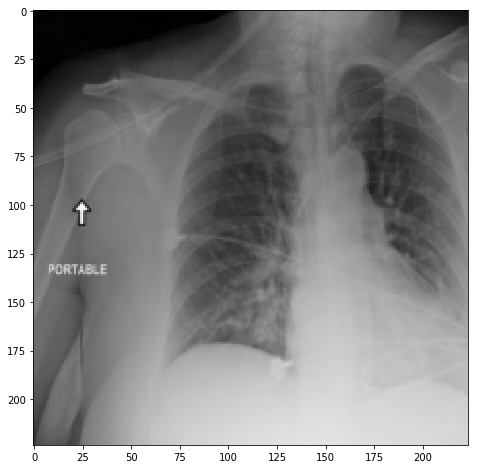

In [23]:
index = 2009
img = test_X[index]
print(torch.sum(img > 0))
print(img)
print(type(img))
to_plot = img.cpu().numpy() #+ mean_image
print(to_plot.shape)
plt.imshow(to_plot[0])
plt.show()

In [24]:
print(type(csv_test))
print(len(test_X))

<class 'pandas.core.frame.DataFrame'>
12386


In [25]:
try:
    del csv_test['age']
except KeyError as e:
    print(e)
try:
    del csv_test['gender']
except KeyError as e:
    print(e)
try:
    del csv_test['view_position']
except KeyError as e:
    print(e)
try:
    del csv_test['image_name']
except KeyError as e:
    print(e)
try:
    del csv_test['detected']
except KeyError as e:
    print(e)

print(list(csv_test))

'detected'
['row_id']


In [34]:
inputs = test_X[0]
print(inputs.unsqueeze(0).size())
test = torch.cat((inputs.unsqueeze(0), inputs.unsqueeze(0)), 0)
print(test.size())
if torch.cuda.is_available:
    inputs = inputs.cuda()
    test.cuda()
outputs = model(Variable(test).cuda())
_, preds = torch.max(outputs, 1)
print(preds)

torch.Size([1, 3, 224, 224])
torch.Size([2, 3, 224, 224])
Variable containing:
 6
 6
[torch.cuda.LongTensor of size 2 (GPU 0)]



## Prediction and Submission CSV

In [30]:
import pandas as pd
index = 0
jump = 30
detected = []
pred_set = set()
debug_length = 10
for i in tqdm(range(len(test_X))):
#for i in tqdm(range(debug_length)):
    #start = index
    #end = index + jump
    #if end >= (test_X.size()[0]) :
    #    end = test_X.size()[0]
    inputs = test_X[i]
    inputs = Variable(inputs.unsqueeze(0))
    #print(inputs.data.size())
    if torch.cuda.is_available:
        inputs = inputs.cuda()
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    ###
    int_list_preds = preds.data.cpu().numpy().tolist()
    for pred_num in int_list_preds:
        pred_set.add(pred_num + 1)
    str_list_preds = [('class_' + str(pred_num + 1)) for pred_num in int_list_preds]
    detected.extend(str_list_preds)
    ####
    #if end == test_X.size()[0]:
    #    break
    #index += jump

100%|██████████| 12386/12386 [05:30<00:00, 37.47it/s]


In [31]:
print(pred_set)
csv_test['detected'] = pd.Series(detected)
csv_test.to_csv('submission.csv', index=False)
print(csv_test)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
         row_id  detected
0        id_100   class_7
1      id_10002   class_8
2      id_10005   class_3
3      id_10008   class_6
4      id_10009   class_3
5      id_10013   class_7
6      id_10015   class_2
7      id_10017   class_3
8      id_10018   class_5
9      id_10020   class_7
10     id_10023   class_7
11     id_10024   class_3
12     id_10027   class_3
13     id_10028   class_6
14     id_10029   class_5
15     id_10030   class_3
16     id_10031   class_4
17     id_10033  class_11
18     id_10035   class_4
19     id_10037   class_3
20     id_10048   class_3
21     id_10050   class_3
22     id_10052   class_6
23     id_10054   class_3
24     id_10056   class_3
25     id_10057   class_3
26     id_10060   class_6
27     id_10061   class_7
28     id_10063   class_5
29     id_10068   class_3
...         ...       ...
12356   id_9943  class_12
12357   id_9947   class_5
12358   id_9948   class_3
12359    id_995   class_4
12360   id_9950 

model.save("models/classification_cnn.model")